#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


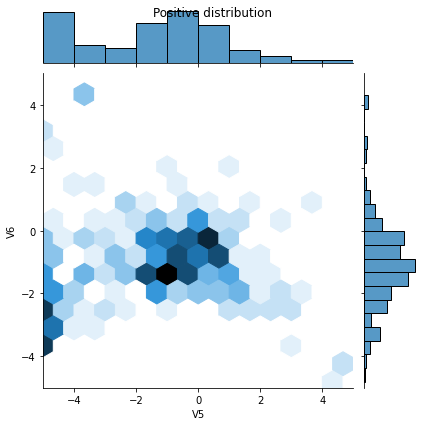

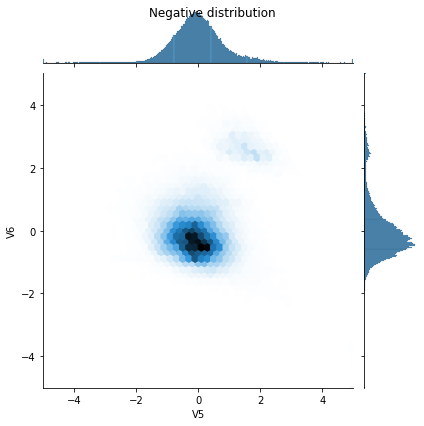

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

array([[0.16105835],
       [0.33830184],
       [0.30945653],
       [0.34930834],
       [0.3607132 ],
       [0.31011787],
       [0.20363246],
       [0.2789183 ],
       [0.25884733],
       [0.33510146]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3234


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00448684],
       [0.00133903],
       [0.00302145],
       [0.00546093],
       [0.00166563],
       [0.00135329],
       [0.00521673],
       [0.00368532],
       [0.01018428],
       [0.00223487]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0132


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

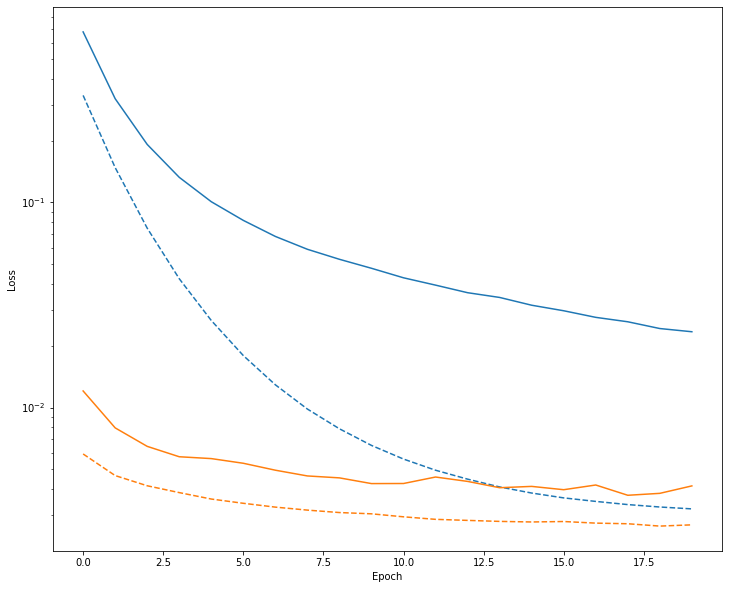

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100


 1/90 [..............................] - ETA: 2:13 - loss: 0.0061 - tp: 57.0000 - fp: 9.0000 - tn: 47538.0000 - fn: 13.0000 - accuracy: 0.9995 - precision: 0.8636 - recall: 0.8143 - auc: 0.9204 - prc: 0.8004

 9/90 [==>...........................] - ETA: 0s - loss: 0.0120 - tp: 59.2222 - fp: 12.8889 - tn: 55710.7778 - fn: 26.1111 - accuracy: 0.9993 - precision: 0.8227 - recall: 0.7036 - auc: 0.8889 - prc: 0.7024 

18/90 [=====>........................] - ETA: 0s - loss: 0.0136 - tp: 60.8333 - fp: 17.1111 - tn: 64906.2222 - fn: 40.8333 - accuracy: 0.9991 - precision: 0.7841 - recall: 0.6170 - auc: 0.8606 - prc: 0.6177

27/90 [========>.....................] - ETA: 0s - loss: 0.0138 - tp: 63.9630 - fp: 19.0741 - tn: 74104.0000 - fn: 53.9630 - accuracy: 0.9991 - precision: 0.7738 - recall: 0.5671 - auc: 0.8451 - prc: 0.5710

36/90 [===========>..................] - ETA: 0s - loss: 0.0137 - tp: 67.3056 - fp: 21.0833 - tn: 83302.3611 - fn: 66.2500 - accuracy: 0.9990 - precision: 0.7655 - recall: 0.5328 - auc: 0.8346 - prc: 0.5380

45/90 [==============>...............] - ETA: 0s - loss: 0.0136 - tp: 70.6444 - fp: 23.3556 - tn: 92500.0444 - fn: 78.9556 - accuracy: 0.9989 - precision: 0.7568 - recall: 0.5049 - auc: 0.8266 - prc: 0.5111

54/90 [=================>............] - ETA: 0s - loss: 0.0134 - tp: 73.9630 - fp: 25.8704 - tn: 101697.5926 - fn: 91.5741 - accuracy: 0.9989 - precision: 0.7477 - recall: 0.4823 - auc: 0.8217 - prc: 0.4888

63/90 [====================>.........] - ETA: 0s - loss: 0.0133 - tp: 76.7302 - fp: 28.3968 - tn: 110895.2381 - fn: 104.6349 - accuracy: 0.9989 - precision: 0.7383 - recall: 0.4617 - auc: 0.8178 - prc: 0.4691

72/90 [=======================>......] - ETA: 0s - loss: 0.0131 - tp: 79.7361 - fp: 30.7361 - tn: 120093.4167 - fn: 117.1111 - accuracy: 0.9988 - precision: 0.7312 - recall: 0.4453 - auc: 0.8156 - prc: 0.4541

81/90 [==========================>...] - ETA: 0s - loss: 0.0130 - tp: 82.5062 - fp: 32.7407 - tn: 129292.0247 - fn: 129.7284 - accuracy: 0.9988 - precision: 0.7257 - recall: 0.4305 - auc: 0.8135 - prc: 0.4414

90/90 [==============================] - ETA: 0s - loss: 0.0128 - tp: 85.4889 - fp: 34.4111 - tn: 138468.2778 - fn: 142.1111 - accuracy: 0.9988 - precision: 0.7226 - recall: 0.4182 - auc: 0.8118 - prc: 0.4310

90/90 [==============================] - 3s 19ms/step - loss: 0.0128 - tp: 85.8242 - fp: 34.5824 - tn: 139445.7363 - fn: 143.4286 - accuracy: 0.9988 - precision: 0.7223 - recall: 0.4169 - auc: 0.8116 - prc: 0.4300 - val_loss: 0.0056 - val_tp: 29.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 39.0000 - val_accuracy: 0.9990 - val_precision: 0.8286 - val_recall: 0.4265 - val_auc: 0.8869 - val_prc: 0.5852


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9681 - prc: 0.5059

10/90 [==>...........................] - ETA: 0s - loss: 0.0058 - tp: 4.1000 - fp: 1.6000 - tn: 11250.6000 - fn: 7.7000 - accuracy: 0.9993 - precision: 0.8090 - recall: 0.3754 - auc: 0.9486 - prc: 0.4954   

19/90 [=====>........................] - ETA: 0s - loss: 0.0069 - tp: 8.6842 - fp: 3.3158 - tn: 20449.9474 - fn: 18.0526 - accuracy: 0.9991 - precision: 0.7638 - recall: 0.3450 - auc: 0.9112 - prc: 0.4267

28/90 [========>.....................] - ETA: 0s - loss: 0.0074 - tp: 14.8214 - fp: 4.9286 - tn: 29646.7500 - fn: 29.5000 - accuracy: 0.9990 - precision: 0.7658 - recall: 0.3437 - auc: 0.8989 - prc: 0.4193

37/90 [===========>..................] - ETA: 0s - loss: 0.0076 - tp: 20.4324 - fp: 6.2432 - tn: 38844.5135 - fn: 40.8108 - accuracy: 0.9989 - precision: 0.7705 - recall: 0.3410 - auc: 0.8894 - prc: 0.4181

46/90 [==============>...............] - ETA: 0s - loss: 0.0078 - tp: 26.0435 - fp: 7.3478 - tn: 48042.7826 - fn: 51.8261 - accuracy: 0.9989 - precision: 0.7772 - recall: 0.3399 - auc: 0.8842 - prc: 0.4203

55/90 [=================>............] - ETA: 0s - loss: 0.0078 - tp: 32.1091 - fp: 8.5091 - tn: 57241.6909 - fn: 61.6909 - accuracy: 0.9989 - precision: 0.7832 - recall: 0.3432 - auc: 0.8825 - prc: 0.4241

64/90 [====================>.........] - ETA: 0s - loss: 0.0078 - tp: 37.3281 - fp: 9.6719 - tn: 66441.4219 - fn: 71.5781 - accuracy: 0.9989 - precision: 0.7862 - recall: 0.3433 - auc: 0.8807 - prc: 0.4272

73/90 [=======================>......] - ETA: 0s - loss: 0.0078 - tp: 43.5205 - fp: 10.9178 - tn: 75640.0411 - fn: 81.5205 - accuracy: 0.9988 - precision: 0.7899 - recall: 0.3460 - auc: 0.8798 - prc: 0.4328

82/90 [==========================>...] - ETA: 0s - loss: 0.0078 - tp: 50.4146 - fp: 12.2317 - tn: 84837.5488 - fn: 91.8049 - accuracy: 0.9988 - precision: 0.7935 - recall: 0.3495 - auc: 0.8798 - prc: 0.4381

90/90 [==============================] - 1s 8ms/step - loss: 0.0078 - tp: 57.2198 - fp: 13.6044 - tn: 93968.6374 - fn: 101.1099 - accuracy: 0.9988 - precision: 0.7962 - recall: 0.3536 - auc: 0.8804 - prc: 0.4441 - val_loss: 0.0046 - val_tp: 37.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 31.0000 - val_accuracy: 0.9992 - val_precision: 0.8409 - val_recall: 0.5441 - val_auc: 0.8965 - val_prc: 0.6553


Epoch 3/100
 1/90 [..............................] - ETA: 0s - loss: 0.0084 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8196 - prc: 0.3518

10/90 [==>...........................] - ETA: 0s - loss: 0.0067 - tp: 7.1000 - fp: 1.8000 - tn: 11244.9000 - fn: 10.2000 - accuracy: 0.9989 - precision: 0.7216 - recall: 0.3796 - auc: 0.8791 - prc: 0.4709

19/90 [=====>........................] - ETA: 0s - loss: 0.0066 - tp: 14.5263 - fp: 1.9474 - tn: 20443.7895 - fn: 19.7368 - accuracy: 0.9989 - precision: 0.8125 - recall: 0.4026 - auc: 0.8946 - prc: 0.5437

28/90 [========>.....................] - ETA: 0s - loss: 0.0067 - tp: 20.0000 - fp: 2.6429 - tn: 29644.1786 - fn: 29.1786 - accuracy: 0.9989 - precision: 0.8360 - recall: 0.3991 - auc: 0.8895 - prc: 0.5463

37/90 [===========>..................] - ETA: 0s - loss: 0.0068 - tp: 26.0811 - fp: 3.6216 - tn: 38844.2973 - fn: 38.0000 - accuracy: 0.9989 - precision: 0.8446 - recall: 0.4009 - auc: 0.8866 - prc: 0.5392

46/90 [==============>...............] - ETA: 0s - loss: 0.0068 - tp: 33.1304 - fp: 4.7174 - tn: 48043.1957 - fn: 46.9565 - accuracy: 0.9989 - precision: 0.8496 - recall: 0.4057 - auc: 0.8855 - prc: 0.5367

55/90 [=================>............] - ETA: 0s - loss: 0.0069 - tp: 40.8000 - fp: 6.0909 - tn: 57240.4000 - fn: 56.7091 - accuracy: 0.9989 - precision: 0.8512 - recall: 0.4095 - auc: 0.8847 - prc: 0.5356

64/90 [====================>.........] - ETA: 0s - loss: 0.0070 - tp: 49.0156 - fp: 7.5781 - tn: 66437.4844 - fn: 65.9219 - accuracy: 0.9989 - precision: 0.8519 - recall: 0.4149 - auc: 0.8846 - prc: 0.5370

73/90 [=======================>......] - ETA: 0s - loss: 0.0070 - tp: 57.1918 - fp: 8.9863 - tn: 75635.4658 - fn: 74.3562 - accuracy: 0.9989 - precision: 0.8527 - recall: 0.4207 - auc: 0.8859 - prc: 0.5404

82/90 [==========================>...] - ETA: 0s - loss: 0.0070 - tp: 65.0976 - fp: 10.3293 - tn: 84833.7439 - fn: 82.8293 - accuracy: 0.9989 - precision: 0.8534 - recall: 0.4250 - auc: 0.8868 - prc: 0.5427

90/90 [==============================] - 1s 8ms/step - loss: 0.0070 - tp: 72.5055 - fp: 11.8132 - tn: 93965.4615 - fn: 90.7912 - accuracy: 0.9989 - precision: 0.8528 - recall: 0.4286 - auc: 0.8877 - prc: 0.5442 - val_loss: 0.0041 - val_tp: 42.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8571 - val_recall: 0.6176 - val_auc: 0.9115 - val_prc: 0.7018


Epoch 4/100
 1/90 [..............................] - ETA: 0s - loss: 0.0041 - tp: 1.0000 - fp: 1.0000 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.5000 - recall: 1.0000 - auc: 0.9995 - prc: 0.3069

10/90 [==>...........................] - ETA: 0s - loss: 0.0050 - tp: 4.6000 - fp: 1.9000 - tn: 11250.0000 - fn: 7.5000 - accuracy: 0.9993 - precision: 0.6708 - recall: 0.5643 - auc: 0.9343 - prc: 0.4243   

19/90 [=====>........................] - ETA: 0s - loss: 0.0051 - tp: 10.9474 - fp: 2.4737 - tn: 20451.2632 - fn: 15.3158 - accuracy: 0.9992 - precision: 0.7522 - recall: 0.4938 - auc: 0.9222 - prc: 0.4836

28/90 [========>.....................] - ETA: 0s - loss: 0.0053 - tp: 19.3571 - fp: 3.7500 - tn: 29650.5357 - fn: 22.3571 - accuracy: 0.9992 - precision: 0.7848 - recall: 0.4952 - auc: 0.9160 - prc: 0.5204

36/90 [===========>..................] - ETA: 0s - loss: 0.0053 - tp: 26.3611 - fp: 5.3889 - tn: 37827.7500 - fn: 28.5000 - accuracy: 0.9992 - precision: 0.7928 - recall: 0.4973 - auc: 0.9134 - prc: 0.5409

44/90 [=============>................] - ETA: 0s - loss: 0.0053 - tp: 34.0909 - fp: 7.0682 - tn: 46004.1364 - fn: 34.7045 - accuracy: 0.9991 - precision: 0.7986 - recall: 0.5021 - auc: 0.9127 - prc: 0.5564

52/90 [================>.............] - ETA: 0s - loss: 0.0054 - tp: 41.2885 - fp: 8.6346 - tn: 54180.5000 - fn: 41.5769 - accuracy: 0.9991 - precision: 0.8025 - recall: 0.5026 - auc: 0.9112 - prc: 0.5642

60/90 [===================>..........] - ETA: 0s - loss: 0.0055 - tp: 47.8667 - fp: 10.1333 - tn: 62357.4833 - fn: 48.5167 - accuracy: 0.9991 - precision: 0.8049 - recall: 0.5012 - auc: 0.9094 - prc: 0.5677

68/90 [=====================>........] - ETA: 0s - loss: 0.0055 - tp: 54.6471 - fp: 11.5735 - tn: 70534.8088 - fn: 54.9706 - accuracy: 0.9991 - precision: 0.8073 - recall: 0.5016 - auc: 0.9084 - prc: 0.5702

76/90 [========================>.....] - ETA: 0s - loss: 0.0055 - tp: 61.8289 - fp: 12.9737 - tn: 78711.9474 - fn: 61.2500 - accuracy: 0.9991 - precision: 0.8098 - recall: 0.5032 - auc: 0.9081 - prc: 0.5728

84/90 [===========================>..] - ETA: 0s - loss: 0.0055 - tp: 69.2619 - fp: 14.3333 - tn: 86888.1190 - fn: 68.2857 - accuracy: 0.9991 - precision: 0.8124 - recall: 0.5038 - auc: 0.9075 - prc: 0.5749

90/90 [==============================] - 1s 8ms/step - loss: 0.0056 - tp: 75.9341 - fp: 15.5385 - tn: 93974.5824 - fn: 74.5165 - accuracy: 0.9991 - precision: 0.8144 - recall: 0.5043 - auc: 0.9071 - prc: 0.5767 - val_loss: 0.0038 - val_tp: 43.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8600 - val_recall: 0.6324 - val_auc: 0.9115 - val_prc: 0.7219


Epoch 5/100


 1/90 [..............................] - ETA: 0s - loss: 0.0063 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.8976 - prc: 0.7287

10/90 [==>...........................] - ETA: 0s - loss: 0.0045 - tp: 11.8000 - fp: 1.5000 - tn: 11242.9000 - fn: 7.8000 - accuracy: 0.9992 - precision: 0.9063 - recall: 0.6179 - auc: 0.9296 - prc: 0.7406  

19/90 [=====>........................] - ETA: 0s - loss: 0.0045 - tp: 20.8947 - fp: 2.6842 - tn: 20440.3684 - fn: 16.0526 - accuracy: 0.9991 - precision: 0.8946 - recall: 0.5873 - auc: 0.9378 - prc: 0.7375

28/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 29.3214 - fp: 3.6071 - tn: 29638.3571 - fn: 24.7143 - accuracy: 0.9991 - precision: 0.8947 - recall: 0.5666 - auc: 0.9397 - prc: 0.7412

37/90 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 36.4324 - fp: 4.7027 - tn: 38837.8649 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8910 - recall: 0.5501 - auc: 0.9344 - prc: 0.7266

46/90 [==============>...............] - ETA: 0s - loss: 0.0049 - tp: 43.4783 - fp: 5.8696 - tn: 48036.9348 - fn: 41.7174 - accuracy: 0.9991 - precision: 0.8871 - recall: 0.5370 - auc: 0.9293 - prc: 0.7129

55/90 [=================>............] - ETA: 0s - loss: 0.0050 - tp: 51.2182 - fp: 6.8909 - tn: 57235.5091 - fn: 50.3818 - accuracy: 0.9990 - precision: 0.8863 - recall: 0.5292 - auc: 0.9254 - prc: 0.7025

64/90 [====================>.........] - ETA: 0s - loss: 0.0051 - tp: 60.0625 - fp: 8.1406 - tn: 66433.4844 - fn: 58.3125 - accuracy: 0.9990 - precision: 0.8853 - recall: 0.5274 - auc: 0.9238 - prc: 0.6960

73/90 [=======================>......] - ETA: 0s - loss: 0.0052 - tp: 68.3562 - fp: 9.6027 - tn: 75632.3836 - fn: 65.6575 - accuracy: 0.9990 - precision: 0.8827 - recall: 0.5264 - auc: 0.9228 - prc: 0.6908

82/90 [==========================>...] - ETA: 0s - loss: 0.0052 - tp: 77.0000 - fp: 10.9878 - tn: 84831.5000 - fn: 72.5122 - accuracy: 0.9990 - precision: 0.8811 - recall: 0.5273 - auc: 0.9223 - prc: 0.6877

90/90 [==============================] - 1s 8ms/step - loss: 0.0052 - tp: 85.5604 - fp: 12.5165 - tn: 93963.4505 - fn: 79.0440 - accuracy: 0.9990 - precision: 0.8791 - recall: 0.5287 - auc: 0.9219 - prc: 0.6853 - val_loss: 0.0036 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7206 - val_auc: 0.9189 - val_prc: 0.7450


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0049 - tp: 9.8000 - fp: 2.3000 - tn: 11243.9000 - fn: 8.0000 - accuracy: 0.9991 - precision: 0.7792 - recall: 0.5480 - auc: 0.8937 - prc: 0.6219       

19/90 [=====>........................] - ETA: 0s - loss: 0.0050 - tp: 17.6842 - fp: 3.5789 - tn: 20444.6842 - fn: 14.0526 - accuracy: 0.9991 - precision: 0.8104 - recall: 0.5557 - auc: 0.8967 - prc: 0.6274

28/90 [========>.....................] - ETA: 0s - loss: 0.0051 - tp: 25.1071 - fp: 5.3571 - tn: 29644.7857 - fn: 20.7500 - accuracy: 0.9991 - precision: 0.8127 - recall: 0.5501 - auc: 0.8958 - prc: 0.6181

37/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 31.6486 - fp: 7.2973 - tn: 38846.1081 - fn: 26.9459 - accuracy: 0.9991 - precision: 0.8087 - recall: 0.5449 - auc: 0.8947 - prc: 0.6099

46/90 [==============>...............] - ETA: 0s - loss: 0.0051 - tp: 39.5652 - fp: 9.2391 - tn: 48046.0217 - fn: 33.1739 - accuracy: 0.9991 - precision: 0.8084 - recall: 0.5461 - auc: 0.8963 - prc: 0.6120

55/90 [=================>............] - ETA: 0s - loss: 0.0052 - tp: 47.8182 - fp: 11.3091 - tn: 57244.4000 - fn: 40.4727 - accuracy: 0.9991 - precision: 0.8077 - recall: 0.5446 - auc: 0.8978 - prc: 0.6132

64/90 [====================>.........] - ETA: 0s - loss: 0.0052 - tp: 56.4062 - fp: 13.0469 - tn: 66442.6719 - fn: 47.8750 - accuracy: 0.9991 - precision: 0.8096 - recall: 0.5438 - auc: 0.8995 - prc: 0.6172

73/90 [=======================>......] - ETA: 0s - loss: 0.0052 - tp: 65.6164 - fp: 14.4932 - tn: 75640.0685 - fn: 55.8219 - accuracy: 0.9991 - precision: 0.8135 - recall: 0.5432 - auc: 0.9005 - prc: 0.6210

82/90 [==========================>...] - ETA: 0s - loss: 0.0052 - tp: 74.7927 - fp: 15.8415 - tn: 84838.0488 - fn: 63.3171 - accuracy: 0.9991 - precision: 0.8172 - recall: 0.5435 - auc: 0.9015 - prc: 0.6240

90/90 [==============================] - 1s 8ms/step - loss: 0.0052 - tp: 83.9121 - fp: 17.2637 - tn: 93969.3297 - fn: 70.0659 - accuracy: 0.9991 - precision: 0.8201 - recall: 0.5450 - auc: 0.9025 - prc: 0.6265 - val_loss: 0.0034 - val_tp: 49.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7206 - val_auc: 0.9189 - val_prc: 0.7694


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 9.4324e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0038 - tp: 7.5000 - fp: 1.6000 - tn: 11248.6000 - fn: 6.3000 - accuracy: 0.9994 - precision: 0.8055 - recall: 0.5826 - auc: 0.8613 - prc: 0.6686           

19/90 [=====>........................] - ETA: 0s - loss: 0.0038 - tp: 15.6842 - fp: 2.4211 - tn: 20450.9474 - fn: 10.9474 - accuracy: 0.9994 - precision: 0.8422 - recall: 0.5922 - auc: 0.8764 - prc: 0.6834

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 23.3929 - fp: 3.5000 - tn: 29652.5357 - fn: 16.5714 - accuracy: 0.9993 - precision: 0.8521 - recall: 0.5892 - auc: 0.8844 - prc: 0.6916

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 30.9189 - fp: 5.7297 - tn: 38852.5405 - fn: 22.8108 - accuracy: 0.9993 - precision: 0.8425 - recall: 0.5827 - auc: 0.8907 - prc: 0.6875

46/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 38.8261 - fp: 8.1304 - tn: 48052.2826 - fn: 28.7609 - accuracy: 0.9993 - precision: 0.8339 - recall: 0.5806 - auc: 0.8945 - prc: 0.6807

55/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 46.8000 - fp: 10.7091 - tn: 57252.3636 - fn: 34.1273 - accuracy: 0.9993 - precision: 0.8260 - recall: 0.5817 - auc: 0.8980 - prc: 0.6762

64/90 [====================>.........] - ETA: 0s - loss: 0.0042 - tp: 55.9688 - fp: 13.1875 - tn: 66450.3281 - fn: 40.5156 - accuracy: 0.9992 - precision: 0.8220 - recall: 0.5821 - auc: 0.9008 - prc: 0.6728

73/90 [=======================>......] - ETA: 0s - loss: 0.0043 - tp: 65.3836 - fp: 15.3562 - tn: 75647.6986 - fn: 47.5616 - accuracy: 0.9992 - precision: 0.8207 - recall: 0.5813 - auc: 0.9026 - prc: 0.6707

82/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 74.9634 - fp: 17.4146 - tn: 84844.7561 - fn: 54.8659 - accuracy: 0.9992 - precision: 0.8203 - recall: 0.5803 - auc: 0.9037 - prc: 0.6695

90/90 [==============================] - ETA: 0s - loss: 0.0044 - tp: 83.3667 - fp: 19.1778 - tn: 92997.2444 - fn: 61.5000 - accuracy: 0.9992 - precision: 0.8203 - recall: 0.5791 - auc: 0.9044 - prc: 0.6689

90/90 [==============================] - 1s 8ms/step - loss: 0.0044 - tp: 84.3626 - fp: 19.3846 - tn: 93974.5055 - fn: 62.3187 - accuracy: 0.9992 - precision: 0.8203 - recall: 0.5790 - auc: 0.9044 - prc: 0.6688 - val_loss: 0.0033 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8772 - val_recall: 0.7353 - val_auc: 0.9189 - val_prc: 0.7776


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.0080 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.7972 - prc: 0.6028

 9/90 [==>...........................] - ETA: 0s - loss: 0.0047 - tp: 14.8889 - fp: 0.4444 - tn: 10217.8889 - fn: 6.7778 - accuracy: 0.9992 - precision: 0.9805 - recall: 0.6534 - auc: 0.8921 - prc: 0.7706  

18/90 [=====>........................] - ETA: 0s - loss: 0.0051 - tp: 25.4444 - fp: 2.2778 - tn: 19413.8333 - fn: 14.4444 - accuracy: 0.9991 - precision: 0.9401 - recall: 0.6385 - auc: 0.8886 - prc: 0.7372

27/90 [========>.....................] - ETA: 0s - loss: 0.0051 - tp: 33.7407 - fp: 3.5185 - tn: 28613.8519 - fn: 20.8889 - accuracy: 0.9992 - precision: 0.9247 - recall: 0.6255 - auc: 0.8858 - prc: 0.7188

36/90 [===========>..................] - ETA: 0s - loss: 0.0051 - tp: 43.3333 - fp: 4.6944 - tn: 37811.8056 - fn: 28.1667 - accuracy: 0.9991 - precision: 0.9179 - recall: 0.6167 - auc: 0.8837 - prc: 0.7093

45/90 [==============>...............] - ETA: 0s - loss: 0.0051 - tp: 52.9556 - fp: 6.2000 - tn: 47010.0444 - fn: 34.8000 - accuracy: 0.9991 - precision: 0.9108 - recall: 0.6131 - auc: 0.8855 - prc: 0.7063

54/90 [=================>............] - ETA: 0s - loss: 0.0050 - tp: 62.2963 - fp: 7.6667 - tn: 56208.7407 - fn: 41.2963 - accuracy: 0.9991 - precision: 0.9055 - recall: 0.6103 - auc: 0.8876 - prc: 0.7062

63/90 [====================>.........] - ETA: 0s - loss: 0.0050 - tp: 71.0000 - fp: 9.1587 - tn: 65407.6190 - fn: 48.2222 - accuracy: 0.9991 - precision: 0.9007 - recall: 0.6058 - auc: 0.8889 - prc: 0.7028

71/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 78.3521 - fp: 10.5070 - tn: 73584.6901 - fn: 54.4507 - accuracy: 0.9991 - precision: 0.8968 - recall: 0.6016 - auc: 0.8892 - prc: 0.6996

80/90 [=========================>....] - ETA: 0s - loss: 0.0050 - tp: 86.4875 - fp: 12.1625 - tn: 82784.2000 - fn: 61.1500 - accuracy: 0.9991 - precision: 0.8923 - recall: 0.5980 - auc: 0.8896 - prc: 0.6961

89/90 [============================>.] - ETA: 0s - loss: 0.0050 - tp: 94.6517 - fp: 13.7528 - tn: 91983.6742 - fn: 67.9213 - accuracy: 0.9991 - precision: 0.8887 - recall: 0.5947 - auc: 0.8905 - prc: 0.6934

90/90 [==============================] - 1s 8ms/step - loss: 0.0050 - tp: 96.3956 - fp: 14.0879 - tn: 93960.6703 - fn: 69.4176 - accuracy: 0.9991 - precision: 0.8880 - recall: 0.5940 - auc: 0.8907 - prc: 0.6928 - val_loss: 0.0032 - val_tp: 50.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 18.0000 - val_accuracy: 0.9995 - val_precision: 0.8772 - val_recall: 0.7353 - val_auc: 0.9190 - val_prc: 0.7800


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9995 - prc: 0.4507

10/90 [==>...........................] - ETA: 0s - loss: 0.0042 - tp: 7.4000 - fp: 1.0000 - tn: 11248.5000 - fn: 7.1000 - accuracy: 0.9992 - precision: 0.7414 - recall: 0.4141 - auc: 0.9302 - prc: 0.6349           

19/90 [=====>........................] - ETA: 0s - loss: 0.0042 - tp: 16.6842 - fp: 1.6842 - tn: 20448.2632 - fn: 13.3684 - accuracy: 0.9992 - precision: 0.8277 - recall: 0.4883 - auc: 0.9154 - prc: 0.6687

27/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 25.1852 - fp: 3.0741 - tn: 28623.8519 - fn: 19.8889 - accuracy: 0.9992 - precision: 0.8423 - recall: 0.5104 - auc: 0.9106 - prc: 0.6732

36/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 33.4722 - fp: 4.6667 - tn: 37822.7222 - fn: 27.1389 - accuracy: 0.9992 - precision: 0.8469 - recall: 0.5187 - auc: 0.9101 - prc: 0.6698

45/90 [==============>...............] - ETA: 0s - loss: 0.0046 - tp: 42.3778 - fp: 6.4000 - tn: 47021.0667 - fn: 34.1556 - accuracy: 0.9992 - precision: 0.8484 - recall: 0.5262 - auc: 0.9104 - prc: 0.6679

54/90 [=================>............] - ETA: 0s - loss: 0.0046 - tp: 50.9074 - fp: 8.2407 - tn: 56220.2593 - fn: 40.5926 - accuracy: 0.9992 - precision: 0.8474 - recall: 0.5322 - auc: 0.9104 - prc: 0.6627

63/90 [====================>.........] - ETA: 0s - loss: 0.0047 - tp: 59.5873 - fp: 9.8730 - tn: 65419.8413 - fn: 46.6984 - accuracy: 0.9992 - precision: 0.8478 - recall: 0.5380 - auc: 0.9101 - prc: 0.6600

72/90 [=======================>......] - ETA: 0s - loss: 0.0047 - tp: 68.9167 - fp: 11.3333 - tn: 74618.2083 - fn: 53.5417 - accuracy: 0.9991 - precision: 0.8495 - recall: 0.5420 - auc: 0.9095 - prc: 0.6590

81/90 [==========================>...] - ETA: 0s - loss: 0.0047 - tp: 78.4568 - fp: 12.6667 - tn: 83816.3457 - fn: 60.5309 - accuracy: 0.9991 - precision: 0.8517 - recall: 0.5451 - auc: 0.9097 - prc: 0.6605

90/90 [==============================] - ETA: 0s - loss: 0.0047 - tp: 88.1000 - fp: 13.8333 - tn: 92992.1222 - fn: 67.2333 - accuracy: 0.9991 - precision: 0.8543 - recall: 0.5485 - auc: 0.9101 - prc: 0.6629

90/90 [==============================] - 1s 8ms/step - loss: 0.0047 - tp: 89.1099 - fp: 13.9560 - tn: 93969.5824 - fn: 67.9231 - accuracy: 0.9991 - precision: 0.8546 - recall: 0.5488 - auc: 0.9101 - prc: 0.6632 - val_loss: 0.0031 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7862


Epoch 10/100
 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000 - prc: 1.0000

 9/90 [==>...........................] - ETA: 0s - loss: 0.0045 - tp: 10.3333 - fp: 0.8889 - tn: 10220.0000 - fn: 8.7778 - accuracy: 0.9991 - precision: 0.9130 - recall: 0.5617 - auc: 0.9053 - prc: 0.7659  

18/90 [=====>........................] - ETA: 0s - loss: 0.0043 - tp: 20.7778 - fp: 1.9444 - tn: 19418.5556 - fn: 14.7222 - accuracy: 0.9991 - precision: 0.9150 - recall: 0.5811 - auc: 0.9224 - prc: 0.7737

27/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 31.0741 - fp: 3.4074 - tn: 28617.8519 - fn: 19.6667 - accuracy: 0.9992 - precision: 0.9072 - recall: 0.5992 - auc: 0.9316 - prc: 0.7766

36/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 40.8611 - fp: 4.8889 - tn: 37817.4167 - fn: 24.8333 - accuracy: 0.9992 - precision: 0.9009 - recall: 0.6080 - auc: 0.9326 - prc: 0.7692

45/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 52.1556 - fp: 6.2667 - tn: 47015.2444 - fn: 30.3333 - accuracy: 0.9992 - precision: 0.8992 - recall: 0.6165 - auc: 0.9338 - prc: 0.7685

54/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 61.9444 - fp: 7.7222 - tn: 56214.0000 - fn: 36.3333 - accuracy: 0.9992 - precision: 0.8961 - recall: 0.6180 - auc: 0.9342 - prc: 0.7653

63/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 71.9206 - fp: 9.3968 - tn: 65412.0159 - fn: 42.6667 - accuracy: 0.9992 - precision: 0.8927 - recall: 0.6183 - auc: 0.9344 - prc: 0.7610

72/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 81.6250 - fp: 10.9722 - tn: 74610.1111 - fn: 49.2917 - accuracy: 0.9992 - precision: 0.8900 - recall: 0.6173 - auc: 0.9342 - prc: 0.7566

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 91.2716 - fp: 12.8148 - tn: 83808.0000 - fn: 55.9136 - accuracy: 0.9992 - precision: 0.8867 - recall: 0.6162 - auc: 0.9341 - prc: 0.7527

90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 100.6111 - fp: 14.9667 - tn: 92983.7556 - fn: 61.9556 - accuracy: 0.9992 - precision: 0.8823 - recall: 0.6159 - auc: 0.9338 - prc: 0.7489

90/90 [==============================] - 1s 8ms/step - loss: 0.0041 - tp: 101.6044 - fp: 15.1978 - tn: 93961.1868 - fn: 62.5824 - accuracy: 0.9992 - precision: 0.8819 - recall: 0.6159 - auc: 0.9338 - prc: 0.7485 - val_loss: 0.0031 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7877


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0024 - tp: 10.1000 - fp: 0.7000 - tn: 11250.2000 - fn: 3.0000 - accuracy: 0.9997 - precision: 0.9466 - recall: 0.8158 - auc: 0.9691 - prc: 0.8300      

19/90 [=====>........................] - ETA: 0s - loss: 0.0026 - tp: 19.8421 - fp: 1.8421 - tn: 20451.5263 - fn: 6.7895 - accuracy: 0.9996 - precision: 0.9322 - recall: 0.7789 - auc: 0.9653 - prc: 0.8211

28/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 29.9643 - fp: 3.8929 - tn: 29650.1786 - fn: 11.9643 - accuracy: 0.9996 - precision: 0.9095 - recall: 0.7515 - auc: 0.9618 - prc: 0.8071

37/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 39.9730 - fp: 5.6216 - tn: 38849.1892 - fn: 17.2162 - accuracy: 0.9995 - precision: 0.8988 - recall: 0.7341 - auc: 0.9580 - prc: 0.7992

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 50.3696 - fp: 7.0435 - tn: 48047.4130 - fn: 23.1739 - accuracy: 0.9995 - precision: 0.8948 - recall: 0.7199 - auc: 0.9540 - prc: 0.7941

55/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 61.1455 - fp: 8.3091 - tn: 57245.2182 - fn: 29.3273 - accuracy: 0.9994 - precision: 0.8936 - recall: 0.7096 - auc: 0.9502 - prc: 0.7906

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 71.0781 - fp: 10.0781 - tn: 66443.0312 - fn: 35.8125 - accuracy: 0.9994 - precision: 0.8893 - recall: 0.6993 - auc: 0.9465 - prc: 0.7841

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 80.4521 - fp: 11.5205 - tn: 75640.7671 - fn: 43.2603 - accuracy: 0.9994 - precision: 0.8871 - recall: 0.6876 - auc: 0.9424 - prc: 0.7766

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 89.6098 - fp: 12.6829 - tn: 84839.1463 - fn: 50.5610 - accuracy: 0.9994 - precision: 0.8864 - recall: 0.6779 - auc: 0.9393 - prc: 0.7713

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 98.8132 - fp: 14.0220 - tn: 93970.1648 - fn: 57.5714 - accuracy: 0.9993 - precision: 0.8852 - recall: 0.6702 - auc: 0.9372 - prc: 0.7668 - val_loss: 0.0030 - val_tp: 53.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8833 - val_recall: 0.7794 - val_auc: 0.9188 - val_prc: 0.7876


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.0043 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.9979 - prc: 0.7205

10/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 7.8000 - fp: 1.5000 - tn: 11246.7000 - fn: 8.0000 - accuracy: 0.9991 - precision: 0.8670 - recall: 0.4857 - auc: 0.9310 - prc: 0.7030   

19/90 [=====>........................] - ETA: 0s - loss: 0.0042 - tp: 16.0000 - fp: 2.8421 - tn: 20445.7895 - fn: 15.3684 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.4982 - auc: 0.9205 - prc: 0.6894

28/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 25.1786 - fp: 3.8214 - tn: 29644.6429 - fn: 22.3571 - accuracy: 0.9991 - precision: 0.8662 - recall: 0.5123 - auc: 0.9188 - prc: 0.6945

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 36.1622 - fp: 5.4054 - tn: 38842.4324 - fn: 28.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5352 - auc: 0.9190 - prc: 0.6955

46/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 45.5870 - fp: 6.9783 - tn: 48041.7391 - fn: 33.6957 - accuracy: 0.9991 - precision: 0.8665 - recall: 0.5472 - auc: 0.9178 - prc: 0.6933

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 56.1455 - fp: 8.4727 - tn: 57239.7455 - fn: 39.6364 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5577 - auc: 0.9168 - prc: 0.6942

64/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 66.5781 - fp: 9.9844 - tn: 66438.1406 - fn: 45.2969 - accuracy: 0.9992 - precision: 0.8680 - recall: 0.5664 - auc: 0.9165 - prc: 0.6958

73/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 77.0000 - fp: 11.5479 - tn: 75636.6164 - fn: 50.8356 - accuracy: 0.9992 - precision: 0.8682 - recall: 0.5738 - auc: 0.9162 - prc: 0.6975

82/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 87.6463 - fp: 13.3415 - tn: 84834.3537 - fn: 56.6585 - accuracy: 0.9992 - precision: 0.8675 - recall: 0.5795 - auc: 0.9162 - prc: 0.6993

90/90 [==============================] - ETA: 0s - loss: 0.0044 - tp: 96.5333 - fp: 15.0333 - tn: 92987.9556 - fn: 61.7667 - accuracy: 0.9992 - precision: 0.8662 - recall: 0.5833 - auc: 0.9161 - prc: 0.7000

90/90 [==============================] - 1s 8ms/step - loss: 0.0044 - tp: 97.6044 - fp: 15.2308 - tn: 93965.3736 - fn: 62.3626 - accuracy: 0.9992 - precision: 0.8661 - recall: 0.5838 - auc: 0.9161 - prc: 0.7001 - val_loss: 0.0029 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7936


Epoch 13/100
 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9997 - prc: 0.8512

10/90 [==>...........................] - ETA: 0s - loss: 0.0029 - tp: 13.5000 - fp: 2.1000 - tn: 11243.7000 - fn: 4.7000 - accuracy: 0.9994 - precision: 0.8787 - recall: 0.7289 - auc: 0.9481 - prc: 0.8142  

19/90 [=====>........................] - ETA: 0s - loss: 0.0028 - tp: 22.8421 - fp: 2.7895 - tn: 20446.6842 - fn: 7.6842 - accuracy: 0.9995 - precision: 0.8901 - recall: 0.7387 - auc: 0.9500 - prc: 0.8211

28/90 [========>.....................] - ETA: 0s - loss: 0.0029 - tp: 31.0000 - fp: 4.4643 - tn: 29648.6071 - fn: 11.9286 - accuracy: 0.9994 - precision: 0.8805 - recall: 0.7264 - auc: 0.9472 - prc: 0.7999

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 40.1351 - fp: 5.8649 - tn: 38849.1892 - fn: 16.8108 - accuracy: 0.9994 - precision: 0.8778 - recall: 0.7155 - auc: 0.9455 - prc: 0.7888

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 49.4565 - fp: 7.0652 - tn: 48048.5652 - fn: 22.9130 - accuracy: 0.9994 - precision: 0.8781 - recall: 0.7022 - auc: 0.9434 - prc: 0.7822

55/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 58.2727 - fp: 8.2182 - tn: 57248.8727 - fn: 28.6364 - accuracy: 0.9994 - precision: 0.8784 - recall: 0.6922 - auc: 0.9412 - prc: 0.7748

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 67.8281 - fp: 9.6562 - tn: 66447.5781 - fn: 34.9375 - accuracy: 0.9994 - precision: 0.8776 - recall: 0.6837 - auc: 0.9399 - prc: 0.7693

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 77.6712 - fp: 11.3014 - tn: 75646.0959 - fn: 40.9315 - accuracy: 0.9994 - precision: 0.8761 - recall: 0.6782 - auc: 0.9387 - prc: 0.7635

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 87.0000 - fp: 12.8780 - tn: 84844.6707 - fn: 47.4512 - accuracy: 0.9993 - precision: 0.8747 - recall: 0.6716 - auc: 0.9370 - prc: 0.7570

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 96.4615 - fp: 14.4615 - tn: 93975.3187 - fn: 54.3297 - accuracy: 0.9993 - precision: 0.8736 - recall: 0.6655 - auc: 0.9356 - prc: 0.7517 - val_loss: 0.0029 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9188 - val_prc: 0.7951


Epoch 14/100
 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041

10/90 [==>...........................] - ETA: 0s - loss: 0.0033 - tp: 12.4000 - fp: 2.5000 - tn: 11241.9000 - fn: 7.2000 - accuracy: 0.9993 - precision: 0.8239 - recall: 0.7203 - auc: 0.9593 - prc: 0.8118  

19/90 [=====>........................] - ETA: 0s - loss: 0.0038 - tp: 19.7368 - fp: 4.6316 - tn: 20440.8421 - fn: 14.7895 - accuracy: 0.9991 - precision: 0.8121 - recall: 0.6378 - auc: 0.9395 - prc: 0.7605

28/90 [========>.....................] - ETA: 0s - loss: 0.0042 - tp: 27.9286 - fp: 6.0357 - tn: 29639.5714 - fn: 22.4643 - accuracy: 0.9991 - precision: 0.8185 - recall: 0.6059 - auc: 0.9251 - prc: 0.7311

37/90 [===========>..................] - ETA: 0s - loss: 0.0043 - tp: 37.0270 - fp: 7.0270 - tn: 38837.7838 - fn: 30.1622 - accuracy: 0.9991 - precision: 0.8300 - recall: 0.5916 - auc: 0.9177 - prc: 0.7177

46/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 45.6739 - fp: 7.8913 - tn: 48037.5652 - fn: 36.8696 - accuracy: 0.9991 - precision: 0.8391 - recall: 0.5848 - auc: 0.9144 - prc: 0.7113

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 54.9455 - fp: 8.8545 - tn: 57237.0364 - fn: 43.1636 - accuracy: 0.9991 - precision: 0.8460 - recall: 0.5834 - auc: 0.9128 - prc: 0.7084

64/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 64.2031 - fp: 10.1250 - tn: 66436.4688 - fn: 49.2031 - accuracy: 0.9991 - precision: 0.8495 - recall: 0.5834 - auc: 0.9122 - prc: 0.7062

73/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 73.7123 - fp: 11.4384 - tn: 75635.5479 - fn: 55.3014 - accuracy: 0.9991 - precision: 0.8523 - recall: 0.5841 - auc: 0.9128 - prc: 0.7056

82/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 83.5244 - fp: 12.8171 - tn: 84834.3171 - fn: 61.3415 - accuracy: 0.9991 - precision: 0.8544 - recall: 0.5854 - auc: 0.9136 - prc: 0.7054

90/90 [==============================] - 1s 8ms/step - loss: 0.0043 - tp: 93.4176 - fp: 14.2527 - tn: 93965.8791 - fn: 67.0220 - accuracy: 0.9991 - precision: 0.8560 - recall: 0.5876 - auc: 0.9145 - prc: 0.7059 - val_loss: 0.0028 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7954


Epoch 15/100
 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8741 - prc: 0.6589

10/90 [==>...........................] - ETA: 0s - loss: 0.0059 - tp: 12.5000 - fp: 0.0000e+00 - tn: 11241.4000 - fn: 10.1000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5320 - auc: 0.8656 - prc: 0.6934

19/90 [=====>........................] - ETA: 0s - loss: 0.0051 - tp: 23.2105 - fp: 0.8947 - tn: 20439.7895 - fn: 16.1053 - accuracy: 0.9991 - precision: 0.9754 - recall: 0.5666 - auc: 0.8894 - prc: 0.7305    

28/90 [========>.....................] - ETA: 0s - loss: 0.0048 - tp: 33.1786 - fp: 1.8214 - tn: 29639.1429 - fn: 21.8571 - accuracy: 0.9992 - precision: 0.9628 - recall: 0.5822 - auc: 0.8971 - prc: 0.7423

37/90 [===========>..................] - ETA: 0s - loss: 0.0046 - tp: 43.1622 - fp: 3.4595 - tn: 38837.3243 - fn: 28.0541 - accuracy: 0.9992 - precision: 0.9467 - recall: 0.5892 - auc: 0.9011 - prc: 0.7430

46/90 [==============>...............] - ETA: 0s - loss: 0.0046 - tp: 52.3913 - fp: 5.0652 - tn: 48036.1522 - fn: 34.3913 - accuracy: 0.9992 - precision: 0.9348 - recall: 0.5911 - auc: 0.9033 - prc: 0.7391

55/90 [=================>............] - ETA: 0s - loss: 0.0045 - tp: 61.3091 - fp: 6.8545 - tn: 57235.1818 - fn: 40.6545 - accuracy: 0.9992 - precision: 0.9242 - recall: 0.5918 - auc: 0.9060 - prc: 0.7366

64/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 70.3750 - fp: 8.4219 - tn: 66434.4375 - fn: 46.7656 - accuracy: 0.9992 - precision: 0.9172 - recall: 0.5929 - auc: 0.9090 - prc: 0.7373

73/90 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 80.1644 - fp: 10.1644 - tn: 75633.1507 - fn: 52.5205 - accuracy: 0.9992 - precision: 0.9113 - recall: 0.5957 - auc: 0.9113 - prc: 0.7382

82/90 [==========================>...] - ETA: 0s - loss: 0.0043 - tp: 89.9878 - fp: 11.8537 - tn: 84832.2195 - fn: 57.9390 - accuracy: 0.9992 - precision: 0.9067 - recall: 0.5989 - auc: 0.9136 - prc: 0.7391

90/90 [==============================] - 1s 8ms/step - loss: 0.0043 - tp: 99.6264 - fp: 13.4945 - tn: 93964.0989 - fn: 63.3516 - accuracy: 0.9992 - precision: 0.9029 - recall: 0.6014 - auc: 0.9154 - prc: 0.7398 - val_loss: 0.0028 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7998


Epoch 16/100
 1/90 [..............................] - ETA: 0s - loss: 5.9591e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

10/90 [==>...........................] - ETA: 0s - loss: 0.0026 - tp: 11.2000 - fp: 0.9000 - tn: 11246.4000 - fn: 5.5000 - accuracy: 0.9995 - precision: 0.8534 - recall: 0.6354 - auc: 0.8461 - prc: 0.7220                              

19/90 [=====>........................] - ETA: 0s - loss: 0.0028 - tp: 21.4211 - fp: 2.0526 - tn: 20446.5263 - fn: 10.0000 - accuracy: 0.9995 - precision: 0.8794 - recall: 0.6609 - auc: 0.8925 - prc: 0.7527

28/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 33.0357 - fp: 3.0714 - tn: 29643.3214 - fn: 16.5714 - accuracy: 0.9994 - precision: 0.8915 - recall: 0.6592 - auc: 0.9053 - prc: 0.7622

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 44.1351 - fp: 3.9459 - tn: 38840.1351 - fn: 23.7838 - accuracy: 0.9994 - precision: 0.8989 - recall: 0.6522 - auc: 0.9091 - prc: 0.7628

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 54.5435 - fp: 4.9783 - tn: 48038.1087 - fn: 30.3696 - accuracy: 0.9993 - precision: 0.9018 - recall: 0.6476 - auc: 0.9121 - prc: 0.7633

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 64.5273 - fp: 6.0727 - tn: 57237.7273 - fn: 35.6727 - accuracy: 0.9993 - precision: 0.9029 - recall: 0.6476 - auc: 0.9144 - prc: 0.7635

64/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 75.4219 - fp: 7.5625 - tn: 66435.9844 - fn: 41.0312 - accuracy: 0.9993 - precision: 0.9018 - recall: 0.6490 - auc: 0.9166 - prc: 0.7633

73/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 86.1644 - fp: 9.2055 - tn: 75634.2603 - fn: 46.3699 - accuracy: 0.9993 - precision: 0.8999 - recall: 0.6502 - auc: 0.9181 - prc: 0.7621

82/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 96.5610 - fp: 10.9024 - tn: 84833.0976 - fn: 51.4390 - accuracy: 0.9993 - precision: 0.8977 - recall: 0.6514 - auc: 0.9190 - prc: 0.7602

90/90 [==============================] - 1s 8ms/step - loss: 0.0037 - tp: 106.5714 - fp: 12.2967 - tn: 93964.9560 - fn: 56.7473 - accuracy: 0.9993 - precision: 0.8967 - recall: 0.6516 - auc: 0.9198 - prc: 0.7593 - val_loss: 0.0027 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.7995


Epoch 17/100
 1/90 [..............................] - ETA: 0s - loss: 6.9878e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0031 - tp: 8.4000 - fp: 0.8000 - tn: 11249.1000 - fn: 5.7000 - accuracy: 0.9995 - precision: 0.9442 - recall: 0.6662 - auc: 0.8712 - prc: 0.7210           

18/90 [=====>........................] - ETA: 0s - loss: 0.0033 - tp: 18.3333 - fp: 1.7778 - tn: 19426.4444 - fn: 9.4444 - accuracy: 0.9995 - precision: 0.9308 - recall: 0.6737 - auc: 0.8778 - prc: 0.7290

27/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 27.8148 - fp: 3.8519 - tn: 28627.2593 - fn: 13.0741 - accuracy: 0.9995 - precision: 0.9053 - recall: 0.6816 - auc: 0.8848 - prc: 0.7214

36/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 37.3889 - fp: 5.3056 - tn: 37827.5278 - fn: 17.7778 - accuracy: 0.9994 - precision: 0.8971 - recall: 0.6799 - auc: 0.8926 - prc: 0.7268

45/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 47.0222 - fp: 6.6667 - tn: 47027.8667 - fn: 22.4444 - accuracy: 0.9994 - precision: 0.8928 - recall: 0.6789 - auc: 0.8991 - prc: 0.7305

54/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 56.9444 - fp: 7.7222 - tn: 56228.3148 - fn: 27.0185 - accuracy: 0.9994 - precision: 0.8925 - recall: 0.6793 - auc: 0.9049 - prc: 0.7346

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 67.4444 - fp: 8.8571 - tn: 65427.8889 - fn: 31.8095 - accuracy: 0.9994 - precision: 0.8926 - recall: 0.6798 - auc: 0.9088 - prc: 0.7378

72/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 77.6111 - fp: 10.3611 - tn: 74627.2639 - fn: 36.7639 - accuracy: 0.9994 - precision: 0.8906 - recall: 0.6793 - auc: 0.9116 - prc: 0.7382

81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 87.6420 - fp: 11.8148 - tn: 83825.5802 - fn: 42.9630 - accuracy: 0.9994 - precision: 0.8892 - recall: 0.6755 - auc: 0.9134 - prc: 0.7379

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 97.7778 - fp: 13.1333 - tn: 93000.6556 - fn: 49.7222 - accuracy: 0.9994 - precision: 0.8886 - recall: 0.6710 - auc: 0.9148 - prc: 0.7379

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 98.8462 - fp: 13.2637 - tn: 93978.0220 - fn: 50.4396 - accuracy: 0.9994 - precision: 0.8885 - recall: 0.6706 - auc: 0.9149 - prc: 0.7379 - val_loss: 0.0027 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9188 - val_prc: 0.8033


Epoch 18/100
 1/90 [..............................] - ETA: 0s - loss: 0.0026 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9993 - prc: 0.6653

10/90 [==>...........................] - ETA: 0s - loss: 0.0043 - tp: 10.4000 - fp: 1.5000 - tn: 11244.5000 - fn: 7.6000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.5655 - auc: 0.9131 - prc: 0.6827  

19/90 [=====>........................] - ETA: 0s - loss: 0.0041 - tp: 20.1579 - fp: 3.4211 - tn: 20443.6316 - fn: 12.7895 - accuracy: 0.9992 - precision: 0.8651 - recall: 0.5947 - auc: 0.9253 - prc: 0.6806

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 29.8571 - fp: 4.8571 - tn: 29642.9286 - fn: 18.3571 - accuracy: 0.9992 - precision: 0.8645 - recall: 0.6046 - auc: 0.9272 - prc: 0.6885

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 38.9730 - fp: 6.5135 - tn: 38841.5676 - fn: 24.9459 - accuracy: 0.9992 - precision: 0.8617 - recall: 0.6029 - auc: 0.9264 - prc: 0.6873

45/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 46.9111 - fp: 7.9111 - tn: 47018.9333 - fn: 30.2444 - accuracy: 0.9992 - precision: 0.8602 - recall: 0.6032 - auc: 0.9257 - prc: 0.6863

54/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 55.7963 - fp: 9.4074 - tn: 56218.1111 - fn: 36.6852 - accuracy: 0.9992 - precision: 0.8594 - recall: 0.6014 - auc: 0.9240 - prc: 0.6844

63/90 [====================>.........] - ETA: 0s - loss: 0.0041 - tp: 65.2063 - fp: 11.0000 - tn: 65417.3175 - fn: 42.4762 - accuracy: 0.9992 - precision: 0.8589 - recall: 0.6029 - auc: 0.9234 - prc: 0.6850

72/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 74.6667 - fp: 12.5139 - tn: 74616.7361 - fn: 48.0833 - accuracy: 0.9992 - precision: 0.8589 - recall: 0.6046 - auc: 0.9234 - prc: 0.6865

81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 84.4938 - fp: 14.0617 - tn: 83815.3210 - fn: 54.1235 - accuracy: 0.9992 - precision: 0.8591 - recall: 0.6057 - auc: 0.9237 - prc: 0.6894

90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 94.3889 - fp: 15.5333 - tn: 92990.8889 - fn: 60.4778 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6061 - auc: 0.9240 - prc: 0.6917

90/90 [==============================] - 1s 8ms/step - loss: 0.0041 - tp: 95.4396 - fp: 15.6923 - tn: 93968.3077 - fn: 61.1319 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6062 - auc: 0.9241 - prc: 0.6920 - val_loss: 0.0027 - val_tp: 53.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8689 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8029


Epoch 19/100
 1/90 [..............................] - ETA: 0s - loss: 0.0037 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4971 - prc: 4.7628e-04

10/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 12.3000 - fp: 0.9000 - tn: 11244.3000 - fn: 6.5000 - accuracy: 0.9994 - precision: 0.7978 - recall: 0.6000 - auc: 0.8783 - prc: 0.6070                  

19/90 [=====>........................] - ETA: 0s - loss: 0.0037 - tp: 23.2632 - fp: 1.2632 - tn: 20443.3684 - fn: 12.1053 - accuracy: 0.9994 - precision: 0.8725 - recall: 0.6260 - auc: 0.9088 - prc: 0.6996

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 33.6429 - fp: 2.0357 - tn: 29641.8214 - fn: 18.5000 - accuracy: 0.9993 - precision: 0.8939 - recall: 0.6293 - auc: 0.9126 - prc: 0.7215

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 42.1892 - fp: 3.2703 - tn: 38840.8919 - fn: 25.6486 - accuracy: 0.9993 - precision: 0.8970 - recall: 0.6196 - auc: 0.9143 - prc: 0.7249

46/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 51.6304 - fp: 4.2609 - tn: 48040.0870 - fn: 32.0217 - accuracy: 0.9993 - precision: 0.9006 - recall: 0.6174 - auc: 0.9160 - prc: 0.7288

55/90 [=================>............] - ETA: 0s - loss: 0.0038 - tp: 60.5636 - fp: 5.4909 - tn: 57238.9818 - fn: 38.9636 - accuracy: 0.9993 - precision: 0.9006 - recall: 0.6126 - auc: 0.9166 - prc: 0.7285

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 69.3750 - fp: 7.0625 - tn: 66437.4844 - fn: 46.0781 - accuracy: 0.9992 - precision: 0.8978 - recall: 0.6079 - auc: 0.9166 - prc: 0.7252

73/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 77.9726 - fp: 8.7534 - tn: 75636.6712 - fn: 52.6027 - accuracy: 0.9992 - precision: 0.8944 - recall: 0.6049 - auc: 0.9167 - prc: 0.7221

82/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 87.3902 - fp: 10.5976 - tn: 84835.5854 - fn: 58.4268 - accuracy: 0.9992 - precision: 0.8912 - recall: 0.6052 - auc: 0.9173 - prc: 0.7203

90/90 [==============================] - ETA: 0s - loss: 0.0040 - tp: 95.8111 - fp: 12.0556 - tn: 92989.8000 - fn: 63.6222 - accuracy: 0.9992 - precision: 0.8894 - recall: 0.6056 - auc: 0.9180 - prc: 0.7197

90/90 [==============================] - 1s 8ms/step - loss: 0.0040 - tp: 96.8571 - fp: 12.2198 - tn: 93967.2637 - fn: 64.2308 - accuracy: 0.9992 - precision: 0.8893 - recall: 0.6057 - auc: 0.9181 - prc: 0.7197 - val_loss: 0.0027 - val_tp: 53.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8833 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8040


Epoch 20/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9973 - prc: 0.0794

10/90 [==>...........................] - ETA: 0s - loss: 0.0034 - tp: 8.2000 - fp: 0.4000 - tn: 11249.3000 - fn: 6.1000 - accuracy: 0.9994 - precision: 0.8718 - recall: 0.4856 - auc: 0.8963 - prc: 0.5918               

19/90 [=====>........................] - ETA: 0s - loss: 0.0034 - tp: 20.5263 - fp: 1.4737 - tn: 20447.7895 - fn: 10.2105 - accuracy: 0.9994 - precision: 0.9011 - recall: 0.5834 - auc: 0.9032 - prc: 0.6725

28/90 [========>.....................] - ETA: 0s - loss: 0.0035 - tp: 31.9286 - fp: 3.5000 - tn: 29645.8571 - fn: 14.7143 - accuracy: 0.9994 - precision: 0.8938 - recall: 0.6208 - auc: 0.9095 - prc: 0.6969

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 42.8649 - fp: 5.3243 - tn: 38843.7568 - fn: 20.0541 - accuracy: 0.9994 - precision: 0.8893 - recall: 0.6346 - auc: 0.9149 - prc: 0.7118

46/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 53.9565 - fp: 7.1739 - tn: 48041.1522 - fn: 25.7174 - accuracy: 0.9994 - precision: 0.8857 - recall: 0.6417 - auc: 0.9178 - prc: 0.7200

55/90 [=================>............] - ETA: 0s - loss: 0.0037 - tp: 64.2364 - fp: 9.0909 - tn: 57238.3455 - fn: 32.3273 - accuracy: 0.9993 - precision: 0.8816 - recall: 0.6412 - auc: 0.9187 - prc: 0.7211

64/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 74.1562 - fp: 10.9688 - tn: 66436.4219 - fn: 38.4531 - accuracy: 0.9993 - precision: 0.8782 - recall: 0.6410 - auc: 0.9201 - prc: 0.7232

73/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 84.2192 - fp: 12.6575 - tn: 75634.8219 - fn: 44.3014 - accuracy: 0.9993 - precision: 0.8763 - recall: 0.6414 - auc: 0.9215 - prc: 0.7250

82/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 94.3049 - fp: 14.0854 - tn: 84833.5732 - fn: 50.0366 - accuracy: 0.9993 - precision: 0.8759 - recall: 0.6419 - auc: 0.9223 - prc: 0.7259

90/90 [==============================] - 1s 8ms/step - loss: 0.0038 - tp: 103.8681 - fp: 15.3956 - tn: 93965.3846 - fn: 55.9231 - accuracy: 0.9993 - precision: 0.8758 - recall: 0.6413 - auc: 0.9228 - prc: 0.7262 - val_loss: 0.0027 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8814 - val_recall: 0.7647 - val_auc: 0.9189 - val_prc: 0.8042


Epoch 21/100
 1/90 [..............................] - ETA: 0s - loss: 0.0078 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.7482 - prc: 0.5028

10/90 [==>...........................] - ETA: 0s - loss: 0.0051 - tp: 12.0000 - fp: 2.5000 - tn: 11242.7000 - fn: 6.8000 - accuracy: 0.9992 - precision: 0.8461 - recall: 0.6351 - auc: 0.8818 - prc: 0.6220  

19/90 [=====>........................] - ETA: 0s - loss: 0.0046 - tp: 21.0000 - fp: 3.2105 - tn: 20442.3158 - fn: 13.4737 - accuracy: 0.9992 - precision: 0.8630 - recall: 0.6167 - auc: 0.8964 - prc: 0.6567

28/90 [========>.....................] - ETA: 0s - loss: 0.0043 - tp: 29.6786 - fp: 3.4643 - tn: 29644.0000 - fn: 18.8571 - accuracy: 0.9992 - precision: 0.8820 - recall: 0.6158 - auc: 0.9024 - prc: 0.6768

37/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 38.5946 - fp: 3.9459 - tn: 38844.6486 - fn: 24.8108 - accuracy: 0.9992 - precision: 0.8923 - recall: 0.6132 - auc: 0.9053 - prc: 0.6870

46/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 47.3913 - fp: 4.6304 - tn: 48045.7174 - fn: 30.2609 - accuracy: 0.9992 - precision: 0.8974 - recall: 0.6132 - auc: 0.9083 - prc: 0.6970

55/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 56.8364 - fp: 5.6000 - tn: 57245.8182 - fn: 35.7455 - accuracy: 0.9993 - precision: 0.8993 - recall: 0.6147 - auc: 0.9122 - prc: 0.7070

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 66.9844 - fp: 7.0312 - tn: 66445.0469 - fn: 40.9375 - accuracy: 0.9993 - precision: 0.8982 - recall: 0.6182 - auc: 0.9154 - prc: 0.7136

73/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 77.6849 - fp: 8.3973 - tn: 75643.5342 - fn: 46.3836 - accuracy: 0.9993 - precision: 0.8977 - recall: 0.6213 - auc: 0.9180 - prc: 0.7191

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 88.0000 - fp: 9.8659 - tn: 84841.9024 - fn: 52.2317 - accuracy: 0.9993 - precision: 0.8966 - recall: 0.6226 - auc: 0.9198 - prc: 0.7220

90/90 [==============================] - 1s 8ms/step - loss: 0.0039 - tp: 98.0330 - fp: 11.1648 - tn: 93973.3407 - fn: 58.0330 - accuracy: 0.9993 - precision: 0.8961 - recall: 0.6234 - auc: 0.9210 - prc: 0.7244 - val_loss: 0.0027 - val_tp: 55.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8594 - val_recall: 0.8088 - val_auc: 0.9188 - val_prc: 0.8058


Epoch 22/100
 1/90 [..............................] - ETA: 0s - loss: 4.7113e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

10/90 [==>...........................] - ETA: 0s - loss: 0.0031 - tp: 12.4000 - fp: 1.9000 - tn: 11242.4000 - fn: 7.3000 - accuracy: 0.9993 - precision: 0.7913 - recall: 0.5649 - auc: 0.8535 - prc: 0.7314                              

19/90 [=====>........................] - ETA: 0s - loss: 0.0034 - tp: 21.5789 - fp: 3.1053 - tn: 20441.2105 - fn: 14.1053 - accuracy: 0.9992 - precision: 0.8322 - recall: 0.5810 - auc: 0.8911 - prc: 0.7508

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 29.9286 - fp: 4.6429 - tn: 29639.8571 - fn: 21.5714 - accuracy: 0.9992 - precision: 0.8408 - recall: 0.5747 - auc: 0.8973 - prc: 0.7370

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 37.3784 - fp: 6.2703 - tn: 38839.4324 - fn: 28.9189 - accuracy: 0.9991 - precision: 0.8412 - recall: 0.5659 - auc: 0.8977 - prc: 0.7210

46/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 46.1739 - fp: 7.8478 - tn: 48038.7174 - fn: 35.2609 - accuracy: 0.9991 - precision: 0.8433 - recall: 0.5672 - auc: 0.8994 - prc: 0.7137

55/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 56.0364 - fp: 9.6364 - tn: 57237.1273 - fn: 41.2000 - accuracy: 0.9991 - precision: 0.8444 - recall: 0.5722 - auc: 0.9014 - prc: 0.7101

64/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 65.5938 - fp: 11.5781 - tn: 66436.3438 - fn: 46.4844 - accuracy: 0.9991 - precision: 0.8440 - recall: 0.5778 - auc: 0.9032 - prc: 0.7081

73/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 75.0137 - fp: 13.6164 - tn: 75635.7534 - fn: 51.6164 - accuracy: 0.9991 - precision: 0.8428 - recall: 0.5826 - auc: 0.9049 - prc: 0.7061

82/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 84.7317 - fp: 15.5976 - tn: 84834.6585 - fn: 57.0122 - accuracy: 0.9992 - precision: 0.8423 - recall: 0.5866 - auc: 0.9066 - prc: 0.7061

90/90 [==============================] - 1s 8ms/step - loss: 0.0040 - tp: 94.7582 - fp: 17.5714 - tn: 93965.6484 - fn: 62.5934 - accuracy: 0.9992 - precision: 0.8420 - recall: 0.5900 - auc: 0.9084 - prc: 0.7070 - val_loss: 0.0026 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9189 - val_prc: 0.8065


Epoch 23/100
 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9996 - prc: 0.7500

10/90 [==>...........................] - ETA: 0s - loss: 0.0048 - tp: 6.6000 - fp: 1.7000 - tn: 11248.1000 - fn: 7.6000 - accuracy: 0.9992 - precision: 0.7936 - recall: 0.4325 - auc: 0.8848 - prc: 0.5994   

19/90 [=====>........................] - ETA: 0s - loss: 0.0044 - tp: 13.5263 - fp: 3.1053 - tn: 20448.5263 - fn: 14.8421 - accuracy: 0.9991 - precision: 0.8052 - recall: 0.4567 - auc: 0.8946 - prc: 0.6285

28/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 23.8571 - fp: 4.5714 - tn: 29645.0357 - fn: 22.5357 - accuracy: 0.9991 - precision: 0.8209 - recall: 0.4834 - auc: 0.9000 - prc: 0.6564

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 34.5405 - fp: 6.1622 - tn: 38840.2703 - fn: 31.0270 - accuracy: 0.9991 - precision: 0.8302 - recall: 0.4973 - auc: 0.9039 - prc: 0.6711

46/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 45.1957 - fp: 7.8696 - tn: 48036.8261 - fn: 38.1087 - accuracy: 0.9991 - precision: 0.8354 - recall: 0.5114 - auc: 0.9078 - prc: 0.6827

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 56.0182 - fp: 10.0000 - tn: 57233.5455 - fn: 44.4364 - accuracy: 0.9991 - precision: 0.8364 - recall: 0.5245 - auc: 0.9110 - prc: 0.6913

64/90 [====================>.........] - ETA: 0s - loss: 0.0044 - tp: 66.3750 - fp: 11.8594 - tn: 66431.5000 - fn: 50.2656 - accuracy: 0.9991 - precision: 0.8381 - recall: 0.5353 - auc: 0.9135 - prc: 0.6983

73/90 [=======================>......] - ETA: 0s - loss: 0.0043 - tp: 75.9452 - fp: 13.6027 - tn: 75630.2740 - fn: 56.1781 - accuracy: 0.9991 - precision: 0.8392 - recall: 0.5426 - auc: 0.9150 - prc: 0.7023

82/90 [==========================>...] - ETA: 0s - loss: 0.0043 - tp: 85.2317 - fp: 15.1829 - tn: 84829.5854 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8405 - recall: 0.5484 - auc: 0.9160 - prc: 0.7053

90/90 [==============================] - ETA: 0s - loss: 0.0043 - tp: 93.4889 - fp: 16.7556 - tn: 92983.5778 - fn: 67.4667 - accuracy: 0.9991 - precision: 0.8409 - recall: 0.5521 - auc: 0.9169 - prc: 0.7074

90/90 [==============================] - 1s 8ms/step - loss: 0.0043 - tp: 94.4725 - fp: 16.9670 - tn: 93961.0110 - fn: 68.1209 - accuracy: 0.9991 - precision: 0.8408 - recall: 0.5526 - auc: 0.9170 - prc: 0.7076 - val_loss: 0.0026 - val_tp: 53.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8833 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8072


Epoch 24/100
 1/90 [..............................] - ETA: 0s - loss: 0.0028 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9999 - prc: 0.9708

10/90 [==>...........................] - ETA: 0s - loss: 0.0038 - tp: 9.9000 - fp: 0.7000 - tn: 11246.1000 - fn: 7.3000 - accuracy: 0.9992 - precision: 0.9529 - recall: 0.5339 - auc: 0.9172 - prc: 0.7580   

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 21.5789 - fp: 1.8421 - tn: 20445.1053 - fn: 11.4737 - accuracy: 0.9993 - precision: 0.9361 - recall: 0.6039 - auc: 0.9180 - prc: 0.7702

28/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 32.6429 - fp: 2.7500 - tn: 29642.9286 - fn: 17.6786 - accuracy: 0.9993 - precision: 0.9321 - recall: 0.6174 - auc: 0.9178 - prc: 0.7734

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 43.5405 - fp: 4.0000 - tn: 38839.8378 - fn: 24.6216 - accuracy: 0.9993 - precision: 0.9261 - recall: 0.6196 - auc: 0.9203 - prc: 0.7776

46/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 53.1522 - fp: 5.5000 - tn: 48037.7391 - fn: 31.6087 - accuracy: 0.9992 - precision: 0.9187 - recall: 0.6169 - auc: 0.9211 - prc: 0.7749

55/90 [=================>............] - ETA: 0s - loss: 0.0037 - tp: 62.9636 - fp: 7.4727 - tn: 57235.5818 - fn: 37.9818 - accuracy: 0.9992 - precision: 0.9101 - recall: 0.6167 - auc: 0.9223 - prc: 0.7720

64/90 [====================>.........] - ETA: 0s - loss: 0.0037 - tp: 72.5781 - fp: 9.6094 - tn: 66433.1094 - fn: 44.7031 - accuracy: 0.9992 - precision: 0.9021 - recall: 0.6151 - auc: 0.9233 - prc: 0.7689

73/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 81.1644 - fp: 11.8219 - tn: 75631.6438 - fn: 51.3699 - accuracy: 0.9992 - precision: 0.8941 - recall: 0.6120 - auc: 0.9230 - prc: 0.7635

82/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 89.8780 - fp: 13.7195 - tn: 84830.2073 - fn: 58.1951 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6091 - auc: 0.9227 - prc: 0.7593

90/90 [==============================] - ETA: 0s - loss: 0.0038 - tp: 97.7889 - fp: 15.1667 - tn: 92984.3667 - fn: 63.9667 - accuracy: 0.9992 - precision: 0.8860 - recall: 0.6076 - auc: 0.9227 - prc: 0.7572

90/90 [==============================] - 1s 8ms/step - loss: 0.0038 - tp: 98.7363 - fp: 15.3297 - tn: 93961.8571 - fn: 64.6484 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.6075 - auc: 0.9227 - prc: 0.7570 - val_loss: 0.0026 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8080


Epoch 25/100
 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.8990 - prc: 0.7572

10/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 14.7000 - fp: 1.3000 - tn: 11241.7000 - fn: 6.3000 - accuracy: 0.9993 - precision: 0.9351 - recall: 0.7044 - auc: 0.9306 - prc: 0.8146  

19/90 [=====>........................] - ETA: 0s - loss: 0.0038 - tp: 21.9474 - fp: 2.7368 - tn: 20443.6842 - fn: 11.6316 - accuracy: 0.9993 - precision: 0.9072 - recall: 0.6701 - auc: 0.9132 - prc: 0.7615

28/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 31.6429 - fp: 4.5714 - tn: 29642.6786 - fn: 17.1071 - accuracy: 0.9993 - precision: 0.8923 - recall: 0.6622 - auc: 0.9110 - prc: 0.7485

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 41.1351 - fp: 6.2703 - tn: 38841.9459 - fn: 22.6486 - accuracy: 0.9993 - precision: 0.8843 - recall: 0.6567 - auc: 0.9126 - prc: 0.7455

46/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 51.4130 - fp: 7.7391 - tn: 48041.1304 - fn: 27.7174 - accuracy: 0.9993 - precision: 0.8817 - recall: 0.6569 - auc: 0.9160 - prc: 0.7491

55/90 [=================>............] - ETA: 0s - loss: 0.0037 - tp: 62.0545 - fp: 9.6182 - tn: 57239.8727 - fn: 32.4545 - accuracy: 0.9993 - precision: 0.8779 - recall: 0.6595 - auc: 0.9188 - prc: 0.7515

63/90 [====================>.........] - ETA: 0s - loss: 0.0037 - tp: 71.4286 - fp: 11.2381 - tn: 65416.5397 - fn: 36.7937 - accuracy: 0.9993 - precision: 0.8755 - recall: 0.6609 - auc: 0.9215 - prc: 0.7541

72/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 81.8333 - fp: 12.8889 - tn: 74615.5417 - fn: 41.7361 - accuracy: 0.9993 - precision: 0.8740 - recall: 0.6620 - auc: 0.9237 - prc: 0.7562

81/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 91.8519 - fp: 14.4321 - tn: 83814.4568 - fn: 47.2593 - accuracy: 0.9993 - precision: 0.8730 - recall: 0.6610 - auc: 0.9253 - prc: 0.7574

90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 101.7778 - fp: 15.7556 - tn: 92990.6222 - fn: 53.1333 - accuracy: 0.9993 - precision: 0.8731 - recall: 0.6593 - auc: 0.9259 - prc: 0.7576

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 102.8352 - fp: 15.9011 - tn: 93968.0549 - fn: 53.7802 - accuracy: 0.9993 - precision: 0.8731 - recall: 0.6590 - auc: 0.9260 - prc: 0.7575 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8730 - val_recall: 0.8088 - val_auc: 0.9188 - val_prc: 0.8079


Epoch 26/100
 1/90 [..............................] - ETA: 0s - loss: 0.0053 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.8319 - prc: 0.5332

10/90 [==>...........................] - ETA: 0s - loss: 0.0047 - tp: 12.5000 - fp: 4.2000 - tn: 11242.2000 - fn: 5.1000 - accuracy: 0.9992 - precision: 0.7482 - recall: 0.7167 - auc: 0.8968 - prc: 0.6156

19/90 [=====>........................] - ETA: 0s - loss: 0.0047 - tp: 21.0526 - fp: 6.4211 - tn: 20440.8947 - fn: 11.6316 - accuracy: 0.9991 - precision: 0.7604 - recall: 0.6706 - auc: 0.8969 - prc: 0.6287

28/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 29.5000 - fp: 8.2857 - tn: 29640.0357 - fn: 18.1786 - accuracy: 0.9991 - precision: 0.7715 - recall: 0.6472 - auc: 0.8945 - prc: 0.6403

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 37.2162 - fp: 9.7027 - tn: 38840.3243 - fn: 24.7568 - accuracy: 0.9991 - precision: 0.7814 - recall: 0.6297 - auc: 0.8944 - prc: 0.6498

46/90 [==============>...............] - ETA: 0s - loss: 0.0044 - tp: 46.2826 - fp: 11.2174 - tn: 48039.7391 - fn: 30.7609 - accuracy: 0.9991 - precision: 0.7902 - recall: 0.6239 - auc: 0.8981 - prc: 0.6627

55/90 [=================>............] - ETA: 0s - loss: 0.0044 - tp: 55.6545 - fp: 12.5818 - tn: 57238.6727 - fn: 37.0909 - accuracy: 0.9991 - precision: 0.7986 - recall: 0.6198 - auc: 0.9008 - prc: 0.6727

64/90 [====================>.........] - ETA: 0s - loss: 0.0043 - tp: 64.7656 - fp: 14.0781 - tn: 66438.3438 - fn: 42.8125 - accuracy: 0.9991 - precision: 0.8041 - recall: 0.6181 - auc: 0.9029 - prc: 0.6799

73/90 [=======================>......] - ETA: 0s - loss: 0.0042 - tp: 74.2877 - fp: 15.5068 - tn: 75637.6986 - fn: 48.5068 - accuracy: 0.9991 - precision: 0.8094 - recall: 0.6177 - auc: 0.9058 - prc: 0.6870

82/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 84.1707 - fp: 16.8293 - tn: 84836.4512 - fn: 54.5488 - accuracy: 0.9992 - precision: 0.8146 - recall: 0.6172 - auc: 0.9082 - prc: 0.6932

90/90 [==============================] - 1s 8ms/step - loss: 0.0041 - tp: 94.2747 - fp: 18.1978 - tn: 93967.5385 - fn: 60.5604 - accuracy: 0.9992 - precision: 0.8189 - recall: 0.6172 - auc: 0.9104 - prc: 0.6988 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8730 - val_recall: 0.8088 - val_auc: 0.9188 - val_prc: 0.8082


Epoch 27/100
 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

 9/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 12.0000 - fp: 2.1111 - tn: 10222.1111 - fn: 3.7778 - accuracy: 0.9994 - precision: 0.8299 - recall: 0.7899 - auc: 0.9572 - prc: 0.8483  

17/90 [====>.........................] - ETA: 0s - loss: 0.0028 - tp: 21.1765 - fp: 3.2941 - tn: 18400.4706 - fn: 7.0588 - accuracy: 0.9994 - precision: 0.8489 - recall: 0.7697 - auc: 0.9511 - prc: 0.8287

26/90 [=======>......................] - ETA: 0s - loss: 0.0029 - tp: 31.4615 - fp: 4.9615 - tn: 27599.7692 - fn: 11.8077 - accuracy: 0.9994 - precision: 0.8544 - recall: 0.7489 - auc: 0.9477 - prc: 0.8148

35/90 [==========>...................] - ETA: 0s - loss: 0.0030 - tp: 40.4000 - fp: 7.0286 - tn: 36799.9714 - fn: 16.6000 - accuracy: 0.9994 - precision: 0.8497 - recall: 0.7328 - auc: 0.9467 - prc: 0.8069

44/90 [=============>................] - ETA: 0s - loss: 0.0031 - tp: 49.3864 - fp: 8.8636 - tn: 45999.1364 - fn: 22.6136 - accuracy: 0.9994 - precision: 0.8478 - recall: 0.7153 - auc: 0.9420 - prc: 0.7946

53/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 58.3962 - fp: 10.3962 - tn: 55198.7736 - fn: 28.4340 - accuracy: 0.9993 - precision: 0.8483 - recall: 0.7031 - auc: 0.9384 - prc: 0.7843

62/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 67.5000 - fp: 11.9032 - tn: 64398.3065 - fn: 34.2903 - accuracy: 0.9993 - precision: 0.8491 - recall: 0.6936 - auc: 0.9361 - prc: 0.7772

71/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 77.0141 - fp: 13.3803 - tn: 73597.0845 - fn: 40.5211 - accuracy: 0.9993 - precision: 0.8502 - recall: 0.6856 - auc: 0.9344 - prc: 0.7724

80/90 [=========================>....] - ETA: 0s - loss: 0.0034 - tp: 86.6250 - fp: 14.8000 - tn: 82795.6625 - fn: 46.9125 - accuracy: 0.9993 - precision: 0.8516 - recall: 0.6788 - auc: 0.9330 - prc: 0.7686

88/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 95.4091 - fp: 16.1364 - tn: 90972.1477 - fn: 52.3068 - accuracy: 0.9993 - precision: 0.8525 - recall: 0.6747 - auc: 0.9323 - prc: 0.7664

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 98.6593 - fp: 16.6593 - tn: 93970.8462 - fn: 54.4066 - accuracy: 0.9993 - precision: 0.8527 - recall: 0.6731 - auc: 0.9321 - prc: 0.7655 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8750 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8095


Epoch 28/100
 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9999 - prc: 0.9489

10/90 [==>...........................] - ETA: 0s - loss: 0.0026 - tp: 10.7000 - fp: 2.1000 - tn: 11246.1000 - fn: 5.1000 - accuracy: 0.9994 - precision: 0.8460 - recall: 0.6775 - auc: 0.9747 - prc: 0.8252  

19/90 [=====>........................] - ETA: 0s - loss: 0.0028 - tp: 22.7895 - fp: 3.8947 - tn: 20443.8947 - fn: 9.4211 - accuracy: 0.9994 - precision: 0.8516 - recall: 0.6962 - auc: 0.9755 - prc: 0.8088

28/90 [========>.....................] - ETA: 0s - loss: 0.0029 - tp: 33.0714 - fp: 5.2857 - tn: 29642.4643 - fn: 15.1786 - accuracy: 0.9993 - precision: 0.8577 - recall: 0.6872 - auc: 0.9711 - prc: 0.8031

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 42.5676 - fp: 6.5405 - tn: 38841.2703 - fn: 21.6216 - accuracy: 0.9993 - precision: 0.8615 - recall: 0.6744 - auc: 0.9632 - prc: 0.7882

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 51.6304 - fp: 7.6087 - tn: 48041.2174 - fn: 27.5435 - accuracy: 0.9993 - precision: 0.8652 - recall: 0.6659 - auc: 0.9572 - prc: 0.7773

55/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 61.4909 - fp: 8.3273 - tn: 57241.0727 - fn: 33.1091 - accuracy: 0.9993 - precision: 0.8714 - recall: 0.6624 - auc: 0.9533 - prc: 0.7734

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 72.2656 - fp: 9.0312 - tn: 66439.7031 - fn: 39.0000 - accuracy: 0.9993 - precision: 0.8771 - recall: 0.6604 - auc: 0.9492 - prc: 0.7700

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 83.0000 - fp: 10.0000 - tn: 75638.2192 - fn: 44.7808 - accuracy: 0.9993 - precision: 0.8804 - recall: 0.6591 - auc: 0.9461 - prc: 0.7665

82/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 93.0122 - fp: 11.0610 - tn: 84837.6707 - fn: 50.2561 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.6579 - auc: 0.9437 - prc: 0.7636

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 102.9011 - fp: 12.5275 - tn: 93969.4505 - fn: 55.6923 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.6568 - auc: 0.9419 - prc: 0.7602 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8065


Epoch 29/100
 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9162 - prc: 0.8354

10/90 [==>...........................] - ETA: 0s - loss: 0.0044 - tp: 15.0000 - fp: 1.7000 - tn: 11240.4000 - fn: 6.9000 - accuracy: 0.9992 - precision: 0.9010 - recall: 0.6949 - auc: 0.9085 - prc: 0.7151  

19/90 [=====>........................] - ETA: 0s - loss: 0.0042 - tp: 23.7895 - fp: 4.7368 - tn: 20440.0526 - fn: 11.4211 - accuracy: 0.9992 - precision: 0.8579 - recall: 0.6820 - auc: 0.9101 - prc: 0.7073

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 33.4643 - fp: 7.2857 - tn: 29638.7857 - fn: 16.4643 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6769 - auc: 0.9128 - prc: 0.7107

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 44.4054 - fp: 9.3243 - tn: 38836.8108 - fn: 21.4595 - accuracy: 0.9992 - precision: 0.8401 - recall: 0.6774 - auc: 0.9169 - prc: 0.7216

46/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 54.9348 - fp: 11.3696 - tn: 48034.7609 - fn: 26.9348 - accuracy: 0.9992 - precision: 0.8386 - recall: 0.6750 - auc: 0.9200 - prc: 0.7275

55/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 64.7818 - fp: 13.1455 - tn: 57233.8545 - fn: 32.2182 - accuracy: 0.9992 - precision: 0.8385 - recall: 0.6727 - auc: 0.9219 - prc: 0.7306

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 73.7500 - fp: 14.7969 - tn: 66433.2656 - fn: 38.1875 - accuracy: 0.9992 - precision: 0.8384 - recall: 0.6670 - auc: 0.9228 - prc: 0.7309

73/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 83.1370 - fp: 16.1781 - tn: 75632.5890 - fn: 44.0959 - accuracy: 0.9992 - precision: 0.8401 - recall: 0.6631 - auc: 0.9241 - prc: 0.7335

82/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 93.3415 - fp: 17.4390 - tn: 84831.1951 - fn: 50.0244 - accuracy: 0.9992 - precision: 0.8428 - recall: 0.6608 - auc: 0.9255 - prc: 0.7370

90/90 [==============================] - 1s 8ms/step - loss: 0.0038 - tp: 103.0440 - fp: 18.6264 - tn: 93962.9451 - fn: 55.9560 - accuracy: 0.9992 - precision: 0.8451 - recall: 0.6583 - auc: 0.9262 - prc: 0.7390 - val_loss: 0.0027 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8077


Epoch 30/100
 1/90 [..............................] - ETA: 0s - loss: 0.0069 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.8564 - prc: 0.7180

10/90 [==>...........................] - ETA: 0s - loss: 0.0042 - tp: 15.9000 - fp: 2.3000 - tn: 11240.7000 - fn: 5.1000 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.7692 - auc: 0.9248 - prc: 0.7145  

19/90 [=====>........................] - ETA: 0s - loss: 0.0040 - tp: 26.3684 - fp: 4.0000 - tn: 20439.2105 - fn: 10.4211 - accuracy: 0.9993 - precision: 0.8739 - recall: 0.7373 - auc: 0.9361 - prc: 0.7342

28/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 35.2500 - fp: 5.2143 - tn: 29639.0357 - fn: 16.5000 - accuracy: 0.9993 - precision: 0.8737 - recall: 0.7090 - auc: 0.9369 - prc: 0.7295

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 45.4324 - fp: 6.7568 - tn: 38836.9730 - fn: 22.8378 - accuracy: 0.9993 - precision: 0.8728 - recall: 0.6932 - auc: 0.9365 - prc: 0.7272

45/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 54.8667 - fp: 8.7111 - tn: 47012.3333 - fn: 28.0889 - accuracy: 0.9992 - precision: 0.8683 - recall: 0.6860 - auc: 0.9367 - prc: 0.7271

54/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 66.0370 - fp: 10.6296 - tn: 56209.3519 - fn: 33.9815 - accuracy: 0.9992 - precision: 0.8665 - recall: 0.6813 - auc: 0.9371 - prc: 0.7293

63/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 76.6032 - fp: 12.6667 - tn: 65406.2063 - fn: 40.5238 - accuracy: 0.9992 - precision: 0.8640 - recall: 0.6750 - auc: 0.9359 - prc: 0.7285

72/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 86.8194 - fp: 14.5278 - tn: 74604.3194 - fn: 46.3333 - accuracy: 0.9992 - precision: 0.8625 - recall: 0.6713 - auc: 0.9356 - prc: 0.7291

81/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 96.5679 - fp: 16.0988 - tn: 83803.2963 - fn: 52.0370 - accuracy: 0.9992 - precision: 0.8621 - recall: 0.6679 - auc: 0.9353 - prc: 0.7303

90/90 [==============================] - ETA: 0s - loss: 0.0040 - tp: 106.3889 - fp: 17.5000 - tn: 92979.8333 - fn: 57.5667 - accuracy: 0.9992 - precision: 0.8625 - recall: 0.6656 - auc: 0.9352 - prc: 0.7320

90/90 [==============================] - 1s 8ms/step - loss: 0.0040 - tp: 107.3956 - fp: 17.6484 - tn: 93957.3626 - fn: 58.1648 - accuracy: 0.9992 - precision: 0.8625 - recall: 0.6653 - auc: 0.9352 - prc: 0.7321 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8100


Epoch 31/100
 1/90 [..............................] - ETA: 0s - loss: 0.0069 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.8324 - prc: 0.6702

10/90 [==>...........................] - ETA: 0s - loss: 0.0061 - tp: 15.4000 - fp: 1.9000 - tn: 11238.7000 - fn: 8.0000 - accuracy: 0.9990 - precision: 0.8936 - recall: 0.6528 - auc: 0.8744 - prc: 0.6449  

19/90 [=====>........................] - ETA: 0s - loss: 0.0052 - tp: 25.1053 - fp: 3.5263 - tn: 20438.3158 - fn: 13.0526 - accuracy: 0.9991 - precision: 0.8827 - recall: 0.6551 - auc: 0.8886 - prc: 0.6729

28/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 32.8214 - fp: 5.1429 - tn: 29640.9286 - fn: 17.1071 - accuracy: 0.9992 - precision: 0.8729 - recall: 0.6560 - auc: 0.8992 - prc: 0.6904

37/90 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 40.4865 - fp: 7.1081 - tn: 38842.5135 - fn: 21.8919 - accuracy: 0.9992 - precision: 0.8622 - recall: 0.6511 - auc: 0.9056 - prc: 0.6974

46/90 [==============>...............] - ETA: 0s - loss: 0.0042 - tp: 48.9348 - fp: 8.5217 - tn: 48044.0217 - fn: 26.5217 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6503 - auc: 0.9102 - prc: 0.7047

55/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 57.7273 - fp: 9.8000 - tn: 57245.7455 - fn: 30.7273 - accuracy: 0.9992 - precision: 0.8609 - recall: 0.6523 - auc: 0.9140 - prc: 0.7123

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 67.3438 - fp: 11.3125 - tn: 66444.8750 - fn: 36.4688 - accuracy: 0.9992 - precision: 0.8607 - recall: 0.6504 - auc: 0.9156 - prc: 0.7154

73/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 76.7260 - fp: 12.9178 - tn: 75643.5068 - fn: 42.8493 - accuracy: 0.9992 - precision: 0.8600 - recall: 0.6466 - auc: 0.9158 - prc: 0.7158

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 86.8780 - fp: 14.6220 - tn: 84841.1098 - fn: 49.3902 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6440 - auc: 0.9160 - prc: 0.7169

90/90 [==============================] - 1s 8ms/step - loss: 0.0039 - tp: 97.1868 - fp: 16.2747 - tn: 93971.4945 - fn: 55.6154 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6426 - auc: 0.9168 - prc: 0.7193 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8594 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8093


Epoch 32/100
 1/90 [..............................] - ETA: 0s - loss: 0.0039 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8742 - prc: 0.7519

10/90 [==>...........................] - ETA: 0s - loss: 0.0025 - tp: 12.4000 - fp: 0.7000 - tn: 11245.4000 - fn: 5.5000 - accuracy: 0.9994 - precision: 0.9565 - recall: 0.6886 - auc: 0.9469 - prc: 0.8497  

19/90 [=====>........................] - ETA: 0s - loss: 0.0025 - tp: 22.1579 - fp: 1.2632 - tn: 20446.8421 - fn: 9.7368 - accuracy: 0.9995 - precision: 0.9514 - recall: 0.6928 - auc: 0.9455 - prc: 0.8469

28/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 30.6429 - fp: 2.0357 - tn: 29646.7143 - fn: 16.6071 - accuracy: 0.9994 - precision: 0.9449 - recall: 0.6664 - auc: 0.9396 - prc: 0.8252

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 41.8919 - fp: 3.7568 - tn: 38842.8108 - fn: 23.5405 - accuracy: 0.9994 - precision: 0.9329 - recall: 0.6575 - auc: 0.9386 - prc: 0.8154

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 52.2609 - fp: 5.7826 - tn: 48040.0435 - fn: 29.9130 - accuracy: 0.9993 - precision: 0.9208 - recall: 0.6517 - auc: 0.9372 - prc: 0.8058

55/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 62.7273 - fp: 7.8727 - tn: 57237.5636 - fn: 35.8364 - accuracy: 0.9993 - precision: 0.9112 - recall: 0.6494 - auc: 0.9365 - prc: 0.7995

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 73.0312 - fp: 10.0781 - tn: 66435.7656 - fn: 41.1250 - accuracy: 0.9993 - precision: 0.9029 - recall: 0.6494 - auc: 0.9365 - prc: 0.7944

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 82.9452 - fp: 12.0000 - tn: 75634.9315 - fn: 46.1233 - accuracy: 0.9993 - precision: 0.8972 - recall: 0.6498 - auc: 0.9366 - prc: 0.7916

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 92.8415 - fp: 13.7561 - tn: 84833.7683 - fn: 51.6341 - accuracy: 0.9993 - precision: 0.8932 - recall: 0.6490 - auc: 0.9359 - prc: 0.7883

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 102.7912 - fp: 15.3297 - tn: 93965.3626 - fn: 57.0879 - accuracy: 0.9993 - precision: 0.8906 - recall: 0.6485 - auc: 0.9354 - prc: 0.7856 - val_loss: 0.0026 - val_tp: 54.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8571 - val_recall: 0.7941 - val_auc: 0.9189 - val_prc: 0.8104


Epoch 33/100
 1/90 [..............................] - ETA: 0s - loss: 0.0030 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9985 - prc: 0.7384

10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 11.9000 - fp: 1.4000 - tn: 11242.3000 - fn: 8.4000 - accuracy: 0.9992 - precision: 0.9158 - recall: 0.5680 - auc: 0.9452 - prc: 0.7178  

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 22.0000 - fp: 2.2105 - tn: 20439.9474 - fn: 15.8421 - accuracy: 0.9991 - precision: 0.9143 - recall: 0.5735 - auc: 0.9410 - prc: 0.7432

28/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 32.9643 - fp: 3.2143 - tn: 29637.7143 - fn: 22.1071 - accuracy: 0.9992 - precision: 0.9143 - recall: 0.5864 - auc: 0.9416 - prc: 0.7520

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 43.7027 - fp: 4.4865 - tn: 38835.9459 - fn: 27.8649 - accuracy: 0.9992 - precision: 0.9111 - recall: 0.5963 - auc: 0.9405 - prc: 0.7524

46/90 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 54.3696 - fp: 5.5870 - tn: 48034.6087 - fn: 33.4348 - accuracy: 0.9992 - precision: 0.9102 - recall: 0.6040 - auc: 0.9393 - prc: 0.7517

55/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 64.9273 - fp: 6.9636 - tn: 57232.8364 - fn: 39.2727 - accuracy: 0.9992 - precision: 0.9077 - recall: 0.6086 - auc: 0.9385 - prc: 0.7511

63/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 74.0635 - fp: 8.4127 - tn: 65408.9524 - fn: 44.5714 - accuracy: 0.9992 - precision: 0.9044 - recall: 0.6111 - auc: 0.9374 - prc: 0.7490

72/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 84.7778 - fp: 10.3333 - tn: 74607.1528 - fn: 49.7361 - accuracy: 0.9992 - precision: 0.9002 - recall: 0.6160 - auc: 0.9368 - prc: 0.7486

80/90 [=========================>....] - ETA: 0s - loss: 0.0039 - tp: 94.4875 - fp: 11.8500 - tn: 82783.5000 - fn: 54.1625 - accuracy: 0.9992 - precision: 0.8978 - recall: 0.6203 - auc: 0.9366 - prc: 0.7499

88/90 [============================>.] - ETA: 0s - loss: 0.0039 - tp: 103.6818 - fp: 13.3864 - tn: 90960.4886 - fn: 58.4432 - accuracy: 0.9992 - precision: 0.8955 - recall: 0.6238 - auc: 0.9363 - prc: 0.7508

90/90 [==============================] - 1s 8ms/step - loss: 0.0039 - tp: 106.9890 - fp: 13.9670 - tn: 93959.6044 - fn: 60.0110 - accuracy: 0.9992 - precision: 0.8946 - recall: 0.6250 - auc: 0.9362 - prc: 0.7510 - val_loss: 0.0026 - val_tp: 53.0000 - val_fp: 5.0000 - val_tn: 45496.0000 - val_fn: 15.0000 - val_accuracy: 0.9996 - val_precision: 0.9138 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8118


Epoch 34/100
 1/90 [..............................] - ETA: 0s - loss: 0.0026 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.9996 - prc: 0.8333

 9/90 [==>...........................] - ETA: 0s - loss: 0.0023 - tp: 14.0000 - fp: 1.2222 - tn: 10221.8889 - fn: 2.8889 - accuracy: 0.9996 - precision: 0.9354 - recall: 0.8229 - auc: 0.9694 - prc: 0.8660  

17/90 [====>.........................] - ETA: 0s - loss: 0.0025 - tp: 24.5294 - fp: 2.1765 - tn: 18397.4118 - fn: 7.8824 - accuracy: 0.9995 - precision: 0.9277 - recall: 0.7809 - auc: 0.9704 - prc: 0.8591

25/90 [=======>......................] - ETA: 0s - loss: 0.0027 - tp: 33.2000 - fp: 2.8400 - tn: 26575.0400 - fn: 12.9200 - accuracy: 0.9995 - precision: 0.9265 - recall: 0.7509 - auc: 0.9650 - prc: 0.8474

34/90 [==========>...................] - ETA: 0s - loss: 0.0028 - tp: 41.6471 - fp: 3.6176 - tn: 35777.1765 - fn: 17.5588 - accuracy: 0.9995 - precision: 0.9243 - recall: 0.7324 - auc: 0.9601 - prc: 0.8310

43/90 [=============>................] - ETA: 0s - loss: 0.0029 - tp: 50.1395 - fp: 4.1628 - tn: 44979.2093 - fn: 22.4884 - accuracy: 0.9994 - precision: 0.9254 - recall: 0.7187 - auc: 0.9551 - prc: 0.8193

52/90 [================>.............] - ETA: 0s - loss: 0.0029 - tp: 59.2692 - fp: 4.9038 - tn: 54179.8269 - fn: 28.0000 - accuracy: 0.9994 - precision: 0.9252 - recall: 0.7077 - auc: 0.9515 - prc: 0.8128

61/90 [===================>..........] - ETA: 0s - loss: 0.0030 - tp: 68.7377 - fp: 5.6721 - tn: 63379.9016 - fn: 33.6885 - accuracy: 0.9994 - precision: 0.9251 - recall: 0.6991 - auc: 0.9488 - prc: 0.8075

70/90 [======================>.......] - ETA: 0s - loss: 0.0030 - tp: 78.3571 - fp: 6.7857 - tn: 72579.3714 - fn: 39.4857 - accuracy: 0.9994 - precision: 0.9231 - recall: 0.6922 - auc: 0.9467 - prc: 0.8030

79/90 [=========================>....] - ETA: 0s - loss: 0.0031 - tp: 88.1646 - fp: 7.7215 - tn: 81778.8481 - fn: 45.2658 - accuracy: 0.9994 - precision: 0.9223 - recall: 0.6869 - auc: 0.9449 - prc: 0.7999

88/90 [============================>.] - ETA: 0s - loss: 0.0031 - tp: 98.0795 - fp: 8.8977 - tn: 90978.0227 - fn: 51.0000 - accuracy: 0.9994 - precision: 0.9206 - recall: 0.6828 - auc: 0.9435 - prc: 0.7964

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 101.4725 - fp: 9.3297 - tn: 93976.8571 - fn: 52.9121 - accuracy: 0.9994 - precision: 0.9200 - recall: 0.6816 - auc: 0.9432 - prc: 0.7955 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 13.0000 - val_accuracy: 0.9995 - val_precision: 0.8594 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8108


Epoch 35/100
 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9995 - prc: 0.5379

10/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 11.1000 - fp: 1.9000 - tn: 11247.3000 - fn: 3.7000 - accuracy: 0.9995 - precision: 0.8459 - recall: 0.7964 - auc: 0.9557 - prc: 0.7688  

19/90 [=====>........................] - ETA: 0s - loss: 0.0029 - tp: 22.0000 - fp: 4.0000 - tn: 20446.0526 - fn: 7.9474 - accuracy: 0.9995 - precision: 0.8453 - recall: 0.7638 - auc: 0.9514 - prc: 0.7728

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 33.0000 - fp: 6.2143 - tn: 29643.5357 - fn: 13.2500 - accuracy: 0.9994 - precision: 0.8427 - recall: 0.7427 - auc: 0.9436 - prc: 0.7650

37/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 42.9730 - fp: 8.1081 - tn: 38842.2162 - fn: 18.7027 - accuracy: 0.9994 - precision: 0.8423 - recall: 0.7264 - auc: 0.9405 - prc: 0.7590

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 52.3696 - fp: 9.8478 - tn: 48041.1087 - fn: 24.6739 - accuracy: 0.9993 - precision: 0.8423 - recall: 0.7113 - auc: 0.9384 - prc: 0.7548

55/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 62.4364 - fp: 11.3273 - tn: 57239.3818 - fn: 30.8545 - accuracy: 0.9993 - precision: 0.8448 - recall: 0.7007 - auc: 0.9383 - prc: 0.7561

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 72.3438 - fp: 12.7344 - tn: 66437.5469 - fn: 37.3750 - accuracy: 0.9993 - precision: 0.8472 - recall: 0.6911 - auc: 0.9382 - prc: 0.7565

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 82.3562 - fp: 14.3014 - tn: 75635.8356 - fn: 43.5068 - accuracy: 0.9993 - precision: 0.8485 - recall: 0.6846 - auc: 0.9376 - prc: 0.7560

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 92.0366 - fp: 16.1951 - tn: 84834.1098 - fn: 49.6585 - accuracy: 0.9993 - precision: 0.8480 - recall: 0.6787 - auc: 0.9368 - prc: 0.7538

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 102.0110 - fp: 18.2747 - tn: 93964.6813 - fn: 55.6044 - accuracy: 0.9993 - precision: 0.8471 - recall: 0.6746 - auc: 0.9360 - prc: 0.7521 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8983 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8106


Epoch 36/100
 1/90 [..............................] - ETA: 0s - loss: 0.0015 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0032 - tp: 9.6000 - fp: 0.7000 - tn: 11245.3000 - fn: 8.4000 - accuracy: 0.9992 - precision: 0.9414 - recall: 0.5010 - auc: 0.9541 - prc: 0.7937   

19/90 [=====>........................] - ETA: 0s - loss: 0.0031 - tp: 17.3684 - fp: 1.2632 - tn: 20447.3158 - fn: 14.0526 - accuracy: 0.9993 - precision: 0.9371 - recall: 0.5297 - auc: 0.9469 - prc: 0.7840

27/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 25.7037 - fp: 2.3704 - tn: 28623.9259 - fn: 20.0000 - accuracy: 0.9992 - precision: 0.9273 - recall: 0.5410 - auc: 0.9435 - prc: 0.7782

36/90 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 36.2222 - fp: 3.8889 - tn: 37821.6111 - fn: 26.2778 - accuracy: 0.9992 - precision: 0.9179 - recall: 0.5558 - auc: 0.9395 - prc: 0.7715

45/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 45.3778 - fp: 5.3778 - tn: 47021.6444 - fn: 31.6000 - accuracy: 0.9992 - precision: 0.9101 - recall: 0.5663 - auc: 0.9366 - prc: 0.7643

54/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 54.4444 - fp: 6.8704 - tn: 56221.7037 - fn: 36.9815 - accuracy: 0.9992 - precision: 0.9041 - recall: 0.5735 - auc: 0.9350 - prc: 0.7590

63/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 64.6984 - fp: 8.3492 - tn: 65421.3175 - fn: 41.6349 - accuracy: 0.9992 - precision: 0.9007 - recall: 0.5836 - auc: 0.9348 - prc: 0.7582

72/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 75.2500 - fp: 9.9306 - tn: 74619.9028 - fn: 46.9167 - accuracy: 0.9992 - precision: 0.8977 - recall: 0.5907 - auc: 0.9349 - prc: 0.7576

81/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 85.5309 - fp: 11.6914 - tn: 83817.7778 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8942 - recall: 0.5942 - auc: 0.9346 - prc: 0.7566

90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 95.2222 - fp: 13.3000 - tn: 92993.1889 - fn: 59.5778 - accuracy: 0.9992 - precision: 0.8916 - recall: 0.5954 - auc: 0.9341 - prc: 0.7555

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 96.2308 - fp: 13.4725 - tn: 93970.5934 - fn: 60.2747 - accuracy: 0.9992 - precision: 0.8913 - recall: 0.5955 - auc: 0.9341 - prc: 0.7553 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8983 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8117


Epoch 37/100
 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9998 - prc: 0.9288

10/90 [==>...........................] - ETA: 0s - loss: 0.0044 - tp: 9.3000 - fp: 2.2000 - tn: 11244.0000 - fn: 8.5000 - accuracy: 0.9990 - precision: 0.8611 - recall: 0.5186 - auc: 0.9170 - prc: 0.7387   

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 16.2105 - fp: 4.8947 - tn: 20446.6316 - fn: 12.2632 - accuracy: 0.9991 - precision: 0.8082 - recall: 0.5524 - auc: 0.9155 - prc: 0.7311

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 27.8214 - fp: 7.0357 - tn: 29644.5000 - fn: 16.6429 - accuracy: 0.9991 - precision: 0.8109 - recall: 0.5886 - auc: 0.9217 - prc: 0.7403

37/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 41.7838 - fp: 8.8378 - tn: 38840.6486 - fn: 20.7297 - accuracy: 0.9992 - precision: 0.8217 - recall: 0.6201 - auc: 0.9279 - prc: 0.7558

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 54.0000 - fp: 10.5000 - tn: 48038.2609 - fn: 25.2391 - accuracy: 0.9992 - precision: 0.8286 - recall: 0.6366 - auc: 0.9321 - prc: 0.7644

55/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 64.9818 - fp: 11.9273 - tn: 57236.7636 - fn: 30.3273 - accuracy: 0.9992 - precision: 0.8342 - recall: 0.6442 - auc: 0.9347 - prc: 0.7690

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 74.8438 - fp: 13.4375 - tn: 66436.3438 - fn: 35.3750 - accuracy: 0.9992 - precision: 0.8374 - recall: 0.6480 - auc: 0.9365 - prc: 0.7722

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 84.4795 - fp: 15.0822 - tn: 75635.3288 - fn: 41.1096 - accuracy: 0.9992 - precision: 0.8391 - recall: 0.6484 - auc: 0.9372 - prc: 0.7737

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 94.0366 - fp: 16.8293 - tn: 84833.9390 - fn: 47.1951 - accuracy: 0.9992 - precision: 0.8399 - recall: 0.6475 - auc: 0.9375 - prc: 0.7734

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 103.7143 - fp: 18.4176 - tn: 93965.2527 - fn: 53.1868 - accuracy: 0.9992 - precision: 0.8413 - recall: 0.6468 - auc: 0.9377 - prc: 0.7731 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8983 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8126


Epoch 38/100
 1/90 [..............................] - ETA: 0s - loss: 4.4197e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0026 - tp: 8.6000 - fp: 0.9000 - tn: 11248.5000 - fn: 6.0000 - accuracy: 0.9995 - precision: 0.9319 - recall: 0.6410 - auc: 0.9293 - prc: 0.7784           

19/90 [=====>........................] - ETA: 0s - loss: 0.0031 - tp: 17.8947 - fp: 2.6842 - tn: 20447.4211 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.8982 - recall: 0.6229 - auc: 0.9281 - prc: 0.7435

28/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 29.2500 - fp: 4.9286 - tn: 29643.8929 - fn: 17.9286 - accuracy: 0.9993 - precision: 0.8816 - recall: 0.6267 - auc: 0.9297 - prc: 0.7421

37/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 41.2703 - fp: 6.6216 - tn: 38840.1622 - fn: 23.9459 - accuracy: 0.9993 - precision: 0.8783 - recall: 0.6318 - auc: 0.9321 - prc: 0.7478

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 52.3261 - fp: 8.0652 - tn: 48038.4783 - fn: 29.1304 - accuracy: 0.9993 - precision: 0.8776 - recall: 0.6373 - auc: 0.9335 - prc: 0.7506

55/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 62.8364 - fp: 9.5273 - tn: 57237.6182 - fn: 34.0182 - accuracy: 0.9993 - precision: 0.8768 - recall: 0.6416 - auc: 0.9341 - prc: 0.7519

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 73.0469 - fp: 11.0312 - tn: 66436.7344 - fn: 39.1875 - accuracy: 0.9993 - precision: 0.8759 - recall: 0.6438 - auc: 0.9344 - prc: 0.7535

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 83.7260 - fp: 12.5616 - tn: 75635.1918 - fn: 44.5205 - accuracy: 0.9993 - precision: 0.8754 - recall: 0.6457 - auc: 0.9343 - prc: 0.7544

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 94.2683 - fp: 14.3293 - tn: 84833.2683 - fn: 50.1341 - accuracy: 0.9993 - precision: 0.8740 - recall: 0.6465 - auc: 0.9342 - prc: 0.7549

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 104.4396 - fp: 16.0549 - tn: 93964.2637 - fn: 55.8132 - accuracy: 0.9993 - precision: 0.8727 - recall: 0.6465 - auc: 0.9343 - prc: 0.7556 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8103


Epoch 39/100
 1/90 [..............................] - ETA: 0s - loss: 0.0064 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.9280 - prc: 0.8147

10/90 [==>...........................] - ETA: 0s - loss: 0.0051 - tp: 13.3000 - fp: 1.2000 - tn: 11240.4000 - fn: 9.1000 - accuracy: 0.9991 - precision: 0.9391 - recall: 0.6043 - auc: 0.8999 - prc: 0.7399  

19/90 [=====>........................] - ETA: 0s - loss: 0.0047 - tp: 22.7368 - fp: 2.2632 - tn: 20438.8947 - fn: 16.1053 - accuracy: 0.9991 - precision: 0.9250 - recall: 0.5945 - auc: 0.9055 - prc: 0.7462

28/90 [========>.....................] - ETA: 0s - loss: 0.0046 - tp: 32.8214 - fp: 4.3571 - tn: 29635.8571 - fn: 22.9643 - accuracy: 0.9991 - precision: 0.9045 - recall: 0.5932 - auc: 0.9055 - prc: 0.7389

37/90 [===========>..................] - ETA: 0s - loss: 0.0045 - tp: 42.5135 - fp: 6.1892 - tn: 38835.2432 - fn: 28.0541 - accuracy: 0.9991 - precision: 0.8933 - recall: 0.6003 - auc: 0.9083 - prc: 0.7367

46/90 [==============>...............] - ETA: 0s - loss: 0.0043 - tp: 52.0217 - fp: 7.3261 - tn: 48035.6522 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8913 - recall: 0.6063 - auc: 0.9110 - prc: 0.7387

55/90 [=================>............] - ETA: 0s - loss: 0.0042 - tp: 61.7455 - fp: 8.2364 - tn: 57236.0182 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8921 - recall: 0.6113 - auc: 0.9135 - prc: 0.7422

64/90 [====================>.........] - ETA: 0s - loss: 0.0041 - tp: 71.0000 - fp: 9.1562 - tn: 66436.5156 - fn: 43.3281 - accuracy: 0.9992 - precision: 0.8927 - recall: 0.6135 - auc: 0.9150 - prc: 0.7433

73/90 [=======================>......] - ETA: 0s - loss: 0.0041 - tp: 80.9041 - fp: 10.1233 - tn: 75636.5205 - fn: 48.4521 - accuracy: 0.9992 - precision: 0.8935 - recall: 0.6168 - auc: 0.9167 - prc: 0.7446

82/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 91.7805 - fp: 11.2561 - tn: 84835.3293 - fn: 53.6341 - accuracy: 0.9992 - precision: 0.8940 - recall: 0.6208 - auc: 0.9180 - prc: 0.7457

90/90 [==============================] - 1s 8ms/step - loss: 0.0040 - tp: 102.4725 - fp: 12.5714 - tn: 93967.0110 - fn: 58.5165 - accuracy: 0.9992 - precision: 0.8937 - recall: 0.6246 - auc: 0.9189 - prc: 0.7465 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8127


Epoch 40/100
 1/90 [..............................] - ETA: 0s - loss: 4.0568e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

10/90 [==>...........................] - ETA: 0s - loss: 0.0033 - tp: 8.8000 - fp: 2.5000 - tn: 11247.8000 - fn: 4.9000 - accuracy: 0.9993 - precision: 0.6994 - recall: 0.5538 - auc: 0.8330 - prc: 0.5861                               

19/90 [=====>........................] - ETA: 0s - loss: 0.0031 - tp: 16.0000 - fp: 4.0526 - tn: 20450.8947 - fn: 9.0526 - accuracy: 0.9993 - precision: 0.7491 - recall: 0.5950 - auc: 0.8910 - prc: 0.6473

28/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 23.9643 - fp: 5.7143 - tn: 29652.8929 - fn: 13.4286 - accuracy: 0.9993 - precision: 0.7708 - recall: 0.6102 - auc: 0.9076 - prc: 0.6680

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 34.0000 - fp: 7.5405 - tn: 38851.4324 - fn: 19.0270 - accuracy: 0.9993 - precision: 0.7853 - recall: 0.6178 - auc: 0.9136 - prc: 0.6827

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 45.4565 - fp: 9.1957 - tn: 48048.5000 - fn: 24.8478 - accuracy: 0.9993 - precision: 0.7983 - recall: 0.6250 - auc: 0.9178 - prc: 0.6979

55/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 58.0545 - fp: 11.2182 - tn: 57243.4545 - fn: 31.2727 - accuracy: 0.9993 - precision: 0.8068 - recall: 0.6301 - auc: 0.9215 - prc: 0.7111

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 70.6094 - fp: 13.0938 - tn: 66438.8125 - fn: 37.4844 - accuracy: 0.9993 - precision: 0.8139 - recall: 0.6345 - auc: 0.9239 - prc: 0.7201

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 82.2466 - fp: 14.7671 - tn: 75635.6712 - fn: 43.3151 - accuracy: 0.9993 - precision: 0.8197 - recall: 0.6377 - auc: 0.9260 - prc: 0.7275

82/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 92.9756 - fp: 16.5610 - tn: 84833.3902 - fn: 49.0732 - accuracy: 0.9993 - precision: 0.8233 - recall: 0.6394 - auc: 0.9270 - prc: 0.7312

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 103.3846 - fp: 18.2747 - tn: 93964.5275 - fn: 54.3846 - accuracy: 0.9993 - precision: 0.8263 - recall: 0.6413 - auc: 0.9277 - prc: 0.7341 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8117


Epoch 41/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9999 - prc: 0.9635

10/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 14.0000 - fp: 0.7000 - tn: 11242.0000 - fn: 7.3000 - accuracy: 0.9992 - precision: 0.9563 - recall: 0.6485 - auc: 0.9852 - prc: 0.8193  

19/90 [=====>........................] - ETA: 0s - loss: 0.0032 - tp: 25.5789 - fp: 1.2105 - tn: 20442.1053 - fn: 11.1053 - accuracy: 0.9993 - precision: 0.9571 - recall: 0.6794 - auc: 0.9786 - prc: 0.8369

28/90 [========>.....................] - ETA: 0s - loss: 0.0030 - tp: 35.5357 - fp: 2.7500 - tn: 29643.6786 - fn: 14.0357 - accuracy: 0.9994 - precision: 0.9404 - recall: 0.6979 - auc: 0.9732 - prc: 0.8339

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 45.1081 - fp: 4.6757 - tn: 38843.9189 - fn: 18.2973 - accuracy: 0.9994 - precision: 0.9247 - recall: 0.6994 - auc: 0.9683 - prc: 0.8182

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 55.5435 - fp: 6.2826 - tn: 48043.1087 - fn: 23.0652 - accuracy: 0.9994 - precision: 0.9167 - recall: 0.6992 - auc: 0.9645 - prc: 0.8069

55/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 66.0545 - fp: 7.8364 - tn: 57242.3455 - fn: 27.7636 - accuracy: 0.9994 - precision: 0.9113 - recall: 0.6990 - auc: 0.9628 - prc: 0.8011

64/90 [====================>.........] - ETA: 0s - loss: 0.0032 - tp: 76.3906 - fp: 9.2500 - tn: 66441.5469 - fn: 32.8125 - accuracy: 0.9994 - precision: 0.9078 - recall: 0.6973 - auc: 0.9605 - prc: 0.7963

73/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 86.3973 - fp: 10.4658 - tn: 75641.5205 - fn: 37.6164 - accuracy: 0.9994 - precision: 0.9058 - recall: 0.6961 - auc: 0.9582 - prc: 0.7917

82/90 [==========================>...] - ETA: 0s - loss: 0.0032 - tp: 96.4390 - fp: 11.5122 - tn: 84841.0488 - fn: 43.0000 - accuracy: 0.9994 - precision: 0.9051 - recall: 0.6935 - auc: 0.9560 - prc: 0.7883

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 106.4505 - fp: 12.4725 - tn: 93972.9341 - fn: 48.7143 - accuracy: 0.9994 - precision: 0.9049 - recall: 0.6904 - auc: 0.9539 - prc: 0.7850 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8117


Epoch 42/100
 1/90 [..............................] - ETA: 0s - loss: 0.0024 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9994 - prc: 0.6937

10/90 [==>...........................] - ETA: 0s - loss: 0.0023 - tp: 13.0000 - fp: 0.5000 - tn: 11245.6000 - fn: 4.9000 - accuracy: 0.9996 - precision: 0.9737 - recall: 0.7220 - auc: 0.9593 - prc: 0.8346  

19/90 [=====>........................] - ETA: 0s - loss: 0.0027 - tp: 25.0526 - fp: 0.7895 - tn: 20442.8947 - fn: 11.2632 - accuracy: 0.9995 - precision: 0.9727 - recall: 0.7004 - auc: 0.9497 - prc: 0.8257

28/90 [========>.....................] - ETA: 0s - loss: 0.0029 - tp: 36.3214 - fp: 1.6071 - tn: 29640.4286 - fn: 17.6429 - accuracy: 0.9994 - precision: 0.9648 - recall: 0.6872 - auc: 0.9471 - prc: 0.8137

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 48.4595 - fp: 2.9459 - tn: 38836.0000 - fn: 24.5946 - accuracy: 0.9994 - precision: 0.9552 - recall: 0.6783 - auc: 0.9463 - prc: 0.8082

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 60.5435 - fp: 4.4783 - tn: 48032.2391 - fn: 30.7391 - accuracy: 0.9993 - precision: 0.9466 - recall: 0.6754 - auc: 0.9456 - prc: 0.8049

54/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 70.7222 - fp: 5.6667 - tn: 56207.7222 - fn: 35.8889 - accuracy: 0.9993 - precision: 0.9414 - recall: 0.6737 - auc: 0.9442 - prc: 0.8017

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 81.1746 - fp: 7.0317 - tn: 65406.2381 - fn: 41.5556 - accuracy: 0.9993 - precision: 0.9361 - recall: 0.6711 - auc: 0.9420 - prc: 0.7968

72/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 91.3472 - fp: 8.2778 - tn: 74605.3472 - fn: 47.0278 - accuracy: 0.9993 - precision: 0.9323 - recall: 0.6692 - auc: 0.9400 - prc: 0.7924

81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 101.0741 - fp: 9.4321 - tn: 83805.0741 - fn: 52.4198 - accuracy: 0.9993 - precision: 0.9293 - recall: 0.6672 - auc: 0.9386 - prc: 0.7895

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 110.4333 - fp: 10.5556 - tn: 92982.3667 - fn: 57.9333 - accuracy: 0.9993 - precision: 0.9268 - recall: 0.6649 - auc: 0.9375 - prc: 0.7871

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 111.4066 - fp: 10.6703 - tn: 93959.9780 - fn: 58.5165 - accuracy: 0.9993 - precision: 0.9265 - recall: 0.6647 - auc: 0.9373 - prc: 0.7868 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8121


Epoch 43/100
 1/90 [..............................] - ETA: 0s - loss: 0.0104 - tp: 2.0000 - fp: 2.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.5000 - recall: 0.5000 - auc: 0.8727 - prc: 0.2503

10/90 [==>...........................] - ETA: 0s - loss: 0.0049 - tp: 11.6000 - fp: 2.2000 - tn: 11244.1000 - fn: 6.1000 - accuracy: 0.9991 - precision: 0.7878 - recall: 0.6131 - auc: 0.9144 - prc: 0.6602

18/90 [=====>........................] - ETA: 0s - loss: 0.0042 - tp: 22.9444 - fp: 3.0000 - tn: 19419.5000 - fn: 10.5556 - accuracy: 0.9992 - precision: 0.8379 - recall: 0.6529 - auc: 0.9230 - prc: 0.7195

27/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 33.7037 - fp: 4.1852 - tn: 28617.5185 - fn: 16.5926 - accuracy: 0.9992 - precision: 0.8576 - recall: 0.6550 - auc: 0.9235 - prc: 0.7378

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 42.2500 - fp: 6.1667 - tn: 37816.9444 - fn: 22.6389 - accuracy: 0.9992 - precision: 0.8554 - recall: 0.6475 - auc: 0.9242 - prc: 0.7388

45/90 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 50.4000 - fp: 7.6222 - tn: 47017.3333 - fn: 28.6444 - accuracy: 0.9992 - precision: 0.8564 - recall: 0.6404 - auc: 0.9252 - prc: 0.7394

54/90 [=================>............] - ETA: 0s - loss: 0.0038 - tp: 59.2593 - fp: 8.7778 - tn: 56217.3889 - fn: 34.5741 - accuracy: 0.9992 - precision: 0.8598 - recall: 0.6365 - auc: 0.9270 - prc: 0.7427

63/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 68.7460 - fp: 10.3810 - tn: 65416.5556 - fn: 40.3175 - accuracy: 0.9992 - precision: 0.8602 - recall: 0.6352 - auc: 0.9280 - prc: 0.7429

72/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 78.6667 - fp: 12.1667 - tn: 74615.0833 - fn: 46.0833 - accuracy: 0.9992 - precision: 0.8599 - recall: 0.6347 - auc: 0.9290 - prc: 0.7435

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 88.5556 - fp: 14.1852 - tn: 83813.4198 - fn: 51.8395 - accuracy: 0.9992 - precision: 0.8584 - recall: 0.6343 - auc: 0.9298 - prc: 0.7437

89/90 [============================>.] - ETA: 0s - loss: 0.0037 - tp: 97.6966 - fp: 15.8876 - tn: 91989.1573 - fn: 57.2584 - accuracy: 0.9992 - precision: 0.8578 - recall: 0.6338 - auc: 0.9305 - prc: 0.7443

90/90 [==============================] - 1s 8ms/step - loss: 0.0037 - tp: 99.8571 - fp: 16.3077 - tn: 93965.9011 - fn: 58.5055 - accuracy: 0.9992 - precision: 0.8576 - recall: 0.6338 - auc: 0.9307 - prc: 0.7444 - val_loss: 0.0025 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8118


Epoch 44/100
 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0037 - tp: 14.9000 - fp: 0.1000 - tn: 11240.8000 - fn: 8.2000 - accuracy: 0.9993 - precision: 0.9958 - recall: 0.6613 - auc: 0.9349 - prc: 0.8368  

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 23.6316 - fp: 1.1053 - tn: 20442.5263 - fn: 12.7368 - accuracy: 0.9993 - precision: 0.9692 - recall: 0.6565 - auc: 0.9284 - prc: 0.8147

28/90 [========>.....................] - ETA: 0s - loss: 0.0035 - tp: 34.0357 - fp: 2.4643 - tn: 29641.6071 - fn: 17.8929 - accuracy: 0.9993 - precision: 0.9513 - recall: 0.6575 - auc: 0.9297 - prc: 0.8004

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 45.8378 - fp: 3.8649 - tn: 38839.4054 - fn: 22.8919 - accuracy: 0.9993 - precision: 0.9412 - recall: 0.6634 - auc: 0.9291 - prc: 0.7926

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 56.2826 - fp: 5.6087 - tn: 48038.9565 - fn: 27.1522 - accuracy: 0.9993 - precision: 0.9305 - recall: 0.6685 - auc: 0.9299 - prc: 0.7877

55/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 66.0000 - fp: 7.1636 - tn: 57240.0000 - fn: 30.8364 - accuracy: 0.9993 - precision: 0.9230 - recall: 0.6736 - auc: 0.9313 - prc: 0.7866

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 76.3281 - fp: 8.8906 - tn: 66440.2344 - fn: 34.5469 - accuracy: 0.9993 - precision: 0.9166 - recall: 0.6785 - auc: 0.9328 - prc: 0.7871

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 87.7534 - fp: 10.6712 - tn: 75638.7123 - fn: 38.8630 - accuracy: 0.9993 - precision: 0.9119 - recall: 0.6822 - auc: 0.9341 - prc: 0.7877

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 98.9756 - fp: 12.2439 - tn: 84837.0122 - fn: 43.7683 - accuracy: 0.9993 - precision: 0.9088 - recall: 0.6836 - auc: 0.9355 - prc: 0.7888

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 109.6484 - fp: 13.6813 - tn: 93968.2637 - fn: 48.9780 - accuracy: 0.9993 - precision: 0.9065 - recall: 0.6834 - auc: 0.9362 - prc: 0.7890 - val_loss: 0.0025 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8127


Epoch 45/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 17.7000 - fp: 3.4000 - tn: 11237.7000 - fn: 5.2000 - accuracy: 0.9993 - precision: 0.8510 - recall: 0.8025 - auc: 0.9679 - prc: 0.7795      

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 29.3684 - fp: 4.4211 - tn: 20437.1579 - fn: 9.0526 - accuracy: 0.9993 - precision: 0.8662 - recall: 0.7823 - auc: 0.9626 - prc: 0.7961

28/90 [========>.....................] - ETA: 0s - loss: 0.0029 - tp: 40.8214 - fp: 5.0357 - tn: 29636.5357 - fn: 13.6071 - accuracy: 0.9994 - precision: 0.8806 - recall: 0.7678 - auc: 0.9594 - prc: 0.8061

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 52.0000 - fp: 6.0270 - tn: 38835.1081 - fn: 18.8649 - accuracy: 0.9994 - precision: 0.8866 - recall: 0.7542 - auc: 0.9546 - prc: 0.8040

46/90 [==============>...............] - ETA: 0s - loss: 0.0030 - tp: 64.0000 - fp: 7.0652 - tn: 48032.8913 - fn: 24.0435 - accuracy: 0.9994 - precision: 0.8910 - recall: 0.7462 - auc: 0.9513 - prc: 0.8038

55/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 74.6727 - fp: 8.2364 - tn: 57232.0182 - fn: 29.0727 - accuracy: 0.9993 - precision: 0.8926 - recall: 0.7391 - auc: 0.9494 - prc: 0.8030

64/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 84.9531 - fp: 9.5000 - tn: 66431.0781 - fn: 34.4688 - accuracy: 0.9993 - precision: 0.8930 - recall: 0.7317 - auc: 0.9473 - prc: 0.8002

72/90 [=======================>......] - ETA: 0s - loss: 0.0031 - tp: 94.9306 - fp: 10.6111 - tn: 74607.2361 - fn: 39.2222 - accuracy: 0.9993 - precision: 0.8938 - recall: 0.7274 - auc: 0.9459 - prc: 0.7991

81/90 [==========================>...] - ETA: 0s - loss: 0.0031 - tp: 105.6543 - fp: 12.0864 - tn: 83805.9383 - fn: 44.3210 - accuracy: 0.9993 - precision: 0.8933 - recall: 0.7235 - auc: 0.9446 - prc: 0.7975

90/90 [==============================] - ETA: 0s - loss: 0.0032 - tp: 115.8667 - fp: 13.5111 - tn: 92982.7222 - fn: 49.1889 - accuracy: 0.9993 - precision: 0.8927 - recall: 0.7203 - auc: 0.9436 - prc: 0.7955

90/90 [==============================] - 1s 8ms/step - loss: 0.0032 - tp: 116.9451 - fp: 13.6593 - tn: 93960.2637 - fn: 49.7033 - accuracy: 0.9993 - precision: 0.8926 - recall: 0.7199 - auc: 0.9435 - prc: 0.7952 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8121


Epoch 46/100
 1/90 [..............................] - ETA: 0s - loss: 0.0053 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7489 - prc: 0.5015

10/90 [==>...........................] - ETA: 0s - loss: 0.0058 - tp: 7.9000 - fp: 1.6000 - tn: 11244.0000 - fn: 10.5000 - accuracy: 0.9989 - precision: 0.7416 - recall: 0.3571 - auc: 0.8364 - prc: 0.5010              

18/90 [=====>........................] - ETA: 0s - loss: 0.0055 - tp: 14.6111 - fp: 3.6111 - tn: 19420.3889 - fn: 17.3889 - accuracy: 0.9989 - precision: 0.7655 - recall: 0.4070 - auc: 0.8569 - prc: 0.5431

27/90 [========>.....................] - ETA: 0s - loss: 0.0053 - tp: 22.5556 - fp: 5.6296 - tn: 28620.2222 - fn: 23.5926 - accuracy: 0.9990 - precision: 0.7761 - recall: 0.4428 - auc: 0.8690 - prc: 0.5639

36/90 [===========>..................] - ETA: 0s - loss: 0.0050 - tp: 31.4167 - fp: 6.7500 - tn: 37820.6944 - fn: 29.1389 - accuracy: 0.9990 - precision: 0.7948 - recall: 0.4718 - auc: 0.8798 - prc: 0.5891

45/90 [==============>...............] - ETA: 0s - loss: 0.0048 - tp: 40.2000 - fp: 8.1111 - tn: 47021.2444 - fn: 34.4444 - accuracy: 0.9990 - precision: 0.8054 - recall: 0.4923 - auc: 0.8866 - prc: 0.6071

54/90 [=================>............] - ETA: 0s - loss: 0.0047 - tp: 49.2037 - fp: 9.4630 - tn: 56220.8519 - fn: 40.4815 - accuracy: 0.9991 - precision: 0.8133 - recall: 0.5055 - auc: 0.8922 - prc: 0.6214

63/90 [====================>.........] - ETA: 0s - loss: 0.0046 - tp: 58.3651 - fp: 10.7619 - tn: 65419.9365 - fn: 46.9365 - accuracy: 0.9991 - precision: 0.8199 - recall: 0.5146 - auc: 0.8963 - prc: 0.6330

72/90 [=======================>......] - ETA: 0s - loss: 0.0045 - tp: 68.9028 - fp: 12.1528 - tn: 74617.9167 - fn: 53.0278 - accuracy: 0.9991 - precision: 0.8257 - recall: 0.5251 - auc: 0.8994 - prc: 0.6438

81/90 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 80.2469 - fp: 13.6667 - tn: 83815.3086 - fn: 58.7778 - accuracy: 0.9991 - precision: 0.8306 - recall: 0.5356 - auc: 0.9022 - prc: 0.6539

90/90 [==============================] - ETA: 0s - loss: 0.0043 - tp: 91.3000 - fp: 15.1333 - tn: 92990.8111 - fn: 64.0444 - accuracy: 0.9991 - precision: 0.8346 - recall: 0.5452 - auc: 0.9049 - prc: 0.6631

90/90 [==============================] - 1s 8ms/step - loss: 0.0043 - tp: 92.4396 - fp: 15.2857 - tn: 93968.2418 - fn: 64.6044 - accuracy: 0.9991 - precision: 0.8350 - recall: 0.5461 - auc: 0.9052 - prc: 0.6640 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8122


Epoch 47/100
 1/90 [..............................] - ETA: 0s - loss: 0.0028 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 12.0000 - fp: 0.3000 - tn: 11244.3000 - fn: 7.4000 - accuracy: 0.9992 - precision: 0.9870 - recall: 0.5465 - auc: 0.9724 - prc: 0.8937  

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 24.8421 - fp: 1.6316 - tn: 20441.5789 - fn: 11.9474 - accuracy: 0.9993 - precision: 0.9596 - recall: 0.6179 - auc: 0.9739 - prc: 0.8680

28/90 [========>.....................] - ETA: 0s - loss: 0.0030 - tp: 36.3929 - fp: 2.8571 - tn: 29640.6786 - fn: 16.0714 - accuracy: 0.9993 - precision: 0.9462 - recall: 0.6479 - auc: 0.9706 - prc: 0.8484

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 47.4324 - fp: 3.7838 - tn: 38839.5135 - fn: 21.2703 - accuracy: 0.9993 - precision: 0.9410 - recall: 0.6572 - auc: 0.9644 - prc: 0.8323

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 59.5870 - fp: 4.9130 - tn: 48036.9565 - fn: 26.5435 - accuracy: 0.9993 - precision: 0.9368 - recall: 0.6645 - auc: 0.9603 - prc: 0.8220

54/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 70.0926 - fp: 5.8148 - tn: 56213.6481 - fn: 30.4444 - accuracy: 0.9993 - precision: 0.9346 - recall: 0.6714 - auc: 0.9579 - prc: 0.8169

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 80.8254 - fp: 6.9683 - tn: 65413.5714 - fn: 34.6349 - accuracy: 0.9993 - precision: 0.9315 - recall: 0.6767 - auc: 0.9553 - prc: 0.8105

72/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 91.3056 - fp: 8.2778 - tn: 74613.2778 - fn: 39.1389 - accuracy: 0.9993 - precision: 0.9281 - recall: 0.6796 - auc: 0.9533 - prc: 0.8052

81/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 102.1235 - fp: 9.8642 - tn: 83811.8889 - fn: 44.1235 - accuracy: 0.9993 - precision: 0.9243 - recall: 0.6810 - auc: 0.9518 - prc: 0.8007

90/90 [==============================] - ETA: 0s - loss: 0.0033 - tp: 112.6889 - fp: 11.2778 - tn: 92988.4222 - fn: 48.9000 - accuracy: 0.9993 - precision: 0.9215 - recall: 0.6822 - auc: 0.9505 - prc: 0.7973

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 113.8022 - fp: 11.4176 - tn: 93965.9341 - fn: 49.4176 - accuracy: 0.9993 - precision: 0.9212 - recall: 0.6823 - auc: 0.9503 - prc: 0.7969 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 5.0000 - val_tn: 45496.0000 - val_fn: 15.0000 - val_accuracy: 0.9996 - val_precision: 0.9138 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8123


Epoch 48/100
 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0035 - tp: 17.4000 - fp: 2.6000 - tn: 11237.8000 - fn: 6.2000 - accuracy: 0.9992 - precision: 0.8528 - recall: 0.7654 - auc: 0.9492 - prc: 0.8382  

19/90 [=====>........................] - ETA: 0s - loss: 0.0033 - tp: 27.4211 - fp: 4.1579 - tn: 20438.9474 - fn: 9.4737 - accuracy: 0.9993 - precision: 0.8597 - recall: 0.7568 - auc: 0.9488 - prc: 0.8237

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 38.4643 - fp: 5.3214 - tn: 29638.0357 - fn: 14.1786 - accuracy: 0.9993 - precision: 0.8688 - recall: 0.7454 - auc: 0.9499 - prc: 0.8241

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 47.9189 - fp: 6.5676 - tn: 38837.8649 - fn: 19.6486 - accuracy: 0.9993 - precision: 0.8718 - recall: 0.7292 - auc: 0.9501 - prc: 0.8209

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 57.6087 - fp: 7.7391 - tn: 48037.2826 - fn: 25.3696 - accuracy: 0.9993 - precision: 0.8746 - recall: 0.7168 - auc: 0.9490 - prc: 0.8159

54/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 66.2222 - fp: 8.6667 - tn: 56214.7037 - fn: 30.4074 - accuracy: 0.9993 - precision: 0.8772 - recall: 0.7085 - auc: 0.9479 - prc: 0.8120

63/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 76.4127 - fp: 9.8730 - tn: 65413.7778 - fn: 35.9365 - accuracy: 0.9993 - precision: 0.8789 - recall: 0.7024 - auc: 0.9461 - prc: 0.8077

71/90 [======================>.......] - ETA: 0s - loss: 0.0033 - tp: 84.6761 - fp: 11.0423 - tn: 73591.5634 - fn: 40.7183 - accuracy: 0.9993 - precision: 0.8791 - recall: 0.6972 - auc: 0.9441 - prc: 0.8024

80/90 [=========================>....] - ETA: 0s - loss: 0.0034 - tp: 94.1875 - fp: 12.2875 - tn: 82791.0625 - fn: 46.4625 - accuracy: 0.9993 - precision: 0.8797 - recall: 0.6917 - auc: 0.9422 - prc: 0.7974

89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 104.0787 - fp: 13.4045 - tn: 91990.3371 - fn: 52.1798 - accuracy: 0.9993 - precision: 0.8809 - recall: 0.6876 - auc: 0.9411 - prc: 0.7944

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 106.2088 - fp: 13.6374 - tn: 93967.2967 - fn: 53.4286 - accuracy: 0.9993 - precision: 0.8812 - recall: 0.6867 - auc: 0.9409 - prc: 0.7938 - val_loss: 0.0025 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8120


Epoch 49/100
 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8333 - auc: 0.9998 - prc: 0.9555

10/90 [==>...........................] - ETA: 0s - loss: 0.0024 - tp: 17.1000 - fp: 0.5000 - tn: 11240.3000 - fn: 6.1000 - accuracy: 0.9995 - precision: 0.9813 - recall: 0.7626 - auc: 0.9758 - prc: 0.9115  

19/90 [=====>........................] - ETA: 0s - loss: 0.0028 - tp: 27.4211 - fp: 2.2105 - tn: 20438.5789 - fn: 11.7895 - accuracy: 0.9994 - precision: 0.9466 - recall: 0.7245 - auc: 0.9665 - prc: 0.8704

28/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 38.4643 - fp: 3.6071 - tn: 29637.7857 - fn: 16.1429 - accuracy: 0.9994 - precision: 0.9329 - recall: 0.7196 - auc: 0.9630 - prc: 0.8563

37/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 48.2432 - fp: 5.4054 - tn: 38837.1081 - fn: 21.2432 - accuracy: 0.9993 - precision: 0.9194 - recall: 0.7099 - auc: 0.9579 - prc: 0.8411

46/90 [==============>...............] - ETA: 0s - loss: 0.0030 - tp: 58.4130 - fp: 7.1957 - tn: 48036.3261 - fn: 26.0652 - accuracy: 0.9993 - precision: 0.9105 - recall: 0.7052 - auc: 0.9545 - prc: 0.8314

55/90 [=================>............] - ETA: 0s - loss: 0.0030 - tp: 69.0000 - fp: 9.4182 - tn: 57234.0182 - fn: 31.5636 - accuracy: 0.9993 - precision: 0.9015 - recall: 0.7001 - auc: 0.9524 - prc: 0.8230

64/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 78.8438 - fp: 11.0469 - tn: 66432.5938 - fn: 37.5156 - accuracy: 0.9993 - precision: 0.8968 - recall: 0.6935 - auc: 0.9504 - prc: 0.8162

73/90 [=======================>......] - ETA: 0s - loss: 0.0031 - tp: 88.3973 - fp: 12.3014 - tn: 75632.3562 - fn: 42.9452 - accuracy: 0.9993 - precision: 0.8948 - recall: 0.6890 - auc: 0.9488 - prc: 0.8114

81/90 [==========================>...] - ETA: 0s - loss: 0.0032 - tp: 96.9753 - fp: 13.4815 - tn: 83809.8765 - fn: 47.6667 - accuracy: 0.9993 - precision: 0.8932 - recall: 0.6860 - auc: 0.9478 - prc: 0.8081

90/90 [==============================] - ETA: 0s - loss: 0.0032 - tp: 106.6556 - fp: 14.9556 - tn: 92986.2889 - fn: 53.3889 - accuracy: 0.9993 - precision: 0.8912 - recall: 0.6823 - auc: 0.9465 - prc: 0.8043

90/90 [==============================] - 1s 8ms/step - loss: 0.0032 - tp: 107.6923 - fp: 15.1209 - tn: 93963.7582 - fn: 54.0000 - accuracy: 0.9993 - precision: 0.8910 - recall: 0.6819 - auc: 0.9464 - prc: 0.8039 - val_loss: 0.0025 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9188 - val_prc: 0.8123


Epoch 50/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 10.4000 - fp: 2.5000 - tn: 11245.5000 - fn: 5.6000 - accuracy: 0.9993 - precision: 0.7926 - recall: 0.6638 - auc: 0.9276 - prc: 0.7535  

19/90 [=====>........................] - ETA: 0s - loss: 0.0031 - tp: 20.5789 - fp: 4.4211 - tn: 20443.5789 - fn: 11.4211 - accuracy: 0.9993 - precision: 0.8096 - recall: 0.6527 - auc: 0.9375 - prc: 0.7693

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 30.5000 - fp: 5.7857 - tn: 29642.3214 - fn: 17.3929 - accuracy: 0.9992 - precision: 0.8245 - recall: 0.6466 - auc: 0.9395 - prc: 0.7702

37/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 38.5135 - fp: 6.9459 - tn: 38842.5135 - fn: 24.0270 - accuracy: 0.9992 - precision: 0.8328 - recall: 0.6320 - auc: 0.9378 - prc: 0.7612

46/90 [==============>...............] - ETA: 0s - loss: 0.0034 - tp: 48.5870 - fp: 8.5000 - tn: 48040.8478 - fn: 30.0652 - accuracy: 0.9992 - precision: 0.8376 - recall: 0.6299 - auc: 0.9376 - prc: 0.7596

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 59.0000 - fp: 9.7455 - tn: 57238.8545 - fn: 36.4000 - accuracy: 0.9992 - precision: 0.8436 - recall: 0.6283 - auc: 0.9384 - prc: 0.7613

64/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 69.6875 - fp: 10.8281 - tn: 66436.7969 - fn: 42.6875 - accuracy: 0.9992 - precision: 0.8495 - recall: 0.6278 - auc: 0.9395 - prc: 0.7645

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 80.3151 - fp: 12.2192 - tn: 75634.9726 - fn: 48.4932 - accuracy: 0.9992 - precision: 0.8528 - recall: 0.6286 - auc: 0.9404 - prc: 0.7665

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 90.8537 - fp: 13.6341 - tn: 84833.2927 - fn: 54.2195 - accuracy: 0.9992 - precision: 0.8552 - recall: 0.6295 - auc: 0.9410 - prc: 0.7676

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 101.0000 - fp: 15.2857 - tn: 93964.5714 - fn: 59.7143 - accuracy: 0.9992 - precision: 0.8562 - recall: 0.6303 - auc: 0.9412 - prc: 0.7679 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8117


Epoch 51/100
 1/90 [..............................] - ETA: 0s - loss: 0.0085 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.7994 - prc: 0.6036

10/90 [==>...........................] - ETA: 0s - loss: 0.0046 - tp: 13.8000 - fp: 0.4000 - tn: 11240.8000 - fn: 9.0000 - accuracy: 0.9991 - precision: 0.9826 - recall: 0.5575 - auc: 0.8864 - prc: 0.7600  

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 25.6842 - fp: 0.7368 - tn: 20440.5789 - fn: 13.0000 - accuracy: 0.9992 - precision: 0.9777 - recall: 0.6205 - auc: 0.9187 - prc: 0.8205

28/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 34.7857 - fp: 1.9286 - tn: 29642.3571 - fn: 16.9286 - accuracy: 0.9993 - precision: 0.9606 - recall: 0.6404 - auc: 0.9278 - prc: 0.8244

36/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 43.1944 - fp: 2.8889 - tn: 37821.2778 - fn: 20.6389 - accuracy: 0.9993 - precision: 0.9518 - recall: 0.6500 - auc: 0.9300 - prc: 0.8222

45/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 52.7778 - fp: 4.1778 - tn: 47021.1778 - fn: 25.8667 - accuracy: 0.9993 - precision: 0.9429 - recall: 0.6522 - auc: 0.9309 - prc: 0.8185

54/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 62.3148 - fp: 5.3704 - tn: 56220.5556 - fn: 31.7593 - accuracy: 0.9993 - precision: 0.9368 - recall: 0.6507 - auc: 0.9314 - prc: 0.8142

62/90 [===================>..........] - ETA: 0s - loss: 0.0031 - tp: 71.3710 - fp: 6.5000 - tn: 64396.4355 - fn: 37.6935 - accuracy: 0.9993 - precision: 0.9326 - recall: 0.6481 - auc: 0.9316 - prc: 0.8110

71/90 [======================>.......] - ETA: 0s - loss: 0.0032 - tp: 81.0845 - fp: 8.2394 - tn: 73594.2394 - fn: 44.4366 - accuracy: 0.9993 - precision: 0.9259 - recall: 0.6444 - auc: 0.9312 - prc: 0.8054

80/90 [=========================>....] - ETA: 0s - loss: 0.0032 - tp: 90.7125 - fp: 10.2500 - tn: 82792.3250 - fn: 50.7125 - accuracy: 0.9993 - precision: 0.9190 - recall: 0.6422 - auc: 0.9310 - prc: 0.7998

89/90 [============================>.] - ETA: 0s - loss: 0.0032 - tp: 99.9213 - fp: 12.0337 - tn: 91990.8427 - fn: 57.2022 - accuracy: 0.9993 - precision: 0.9137 - recall: 0.6392 - auc: 0.9309 - prc: 0.7955

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 101.8571 - fp: 12.4505 - tn: 93967.6374 - fn: 58.6264 - accuracy: 0.9993 - precision: 0.9125 - recall: 0.6385 - auc: 0.9308 - prc: 0.7944 - val_loss: 0.0025 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9188 - val_prc: 0.8124


Epoch 52/100
 1/90 [..............................] - ETA: 0s - loss: 0.0038 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8327 - prc: 0.6686

10/90 [==>...........................] - ETA: 0s - loss: 0.0033 - tp: 13.4000 - fp: 1.4000 - tn: 11243.3000 - fn: 5.9000 - accuracy: 0.9994 - precision: 0.8939 - recall: 0.6769 - auc: 0.9117 - prc: 0.7952  

19/90 [=====>........................] - ETA: 0s - loss: 0.0037 - tp: 25.5263 - fp: 2.6316 - tn: 20438.1579 - fn: 13.6842 - accuracy: 0.9993 - precision: 0.9004 - recall: 0.6585 - auc: 0.9120 - prc: 0.7917

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 37.2143 - fp: 4.1071 - tn: 29634.5714 - fn: 20.1071 - accuracy: 0.9992 - precision: 0.8990 - recall: 0.6551 - auc: 0.9186 - prc: 0.7981

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 47.4324 - fp: 5.5135 - tn: 38833.3243 - fn: 25.7297 - accuracy: 0.9992 - precision: 0.8966 - recall: 0.6530 - auc: 0.9240 - prc: 0.8037

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 58.7391 - fp: 7.1304 - tn: 48031.2609 - fn: 30.8696 - accuracy: 0.9992 - precision: 0.8942 - recall: 0.6562 - auc: 0.9274 - prc: 0.8065

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 69.8000 - fp: 9.0545 - tn: 57229.2727 - fn: 35.8727 - accuracy: 0.9992 - precision: 0.8903 - recall: 0.6590 - auc: 0.9288 - prc: 0.8055

63/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 79.1270 - fp: 10.7143 - tn: 65405.5397 - fn: 40.6190 - accuracy: 0.9992 - precision: 0.8872 - recall: 0.6593 - auc: 0.9294 - prc: 0.8036

71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 88.5352 - fp: 12.4085 - tn: 73581.9296 - fn: 45.1268 - accuracy: 0.9992 - precision: 0.8845 - recall: 0.6603 - auc: 0.9301 - prc: 0.8017

80/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 98.9000 - fp: 14.0875 - tn: 82780.6750 - fn: 50.3375 - accuracy: 0.9992 - precision: 0.8827 - recall: 0.6607 - auc: 0.9308 - prc: 0.8004

89/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 108.8427 - fp: 15.7079 - tn: 91980.0674 - fn: 55.3820 - accuracy: 0.9992 - precision: 0.8812 - recall: 0.6610 - auc: 0.9315 - prc: 0.7991

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 110.9780 - fp: 16.0659 - tn: 93957.0769 - fn: 56.4505 - accuracy: 0.9992 - precision: 0.8809 - recall: 0.6611 - auc: 0.9317 - prc: 0.7987 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8119


Epoch 53/100
 1/90 [..............................] - ETA: 0s - loss: 0.0061 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8320 - prc: 0.4454

10/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 11.1000 - fp: 1.4000 - tn: 11243.8000 - fn: 7.7000 - accuracy: 0.9991 - precision: 0.8306 - recall: 0.5474 - auc: 0.8936 - prc: 0.6599

19/90 [=====>........................] - ETA: 0s - loss: 0.0040 - tp: 20.5789 - fp: 2.4737 - tn: 20444.2632 - fn: 12.6842 - accuracy: 0.9992 - precision: 0.8614 - recall: 0.5866 - auc: 0.8935 - prc: 0.6815

28/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 28.7143 - fp: 3.8214 - tn: 29645.5357 - fn: 17.9286 - accuracy: 0.9992 - precision: 0.8651 - recall: 0.5953 - auc: 0.8999 - prc: 0.6895

37/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 36.5135 - fp: 4.8649 - tn: 38847.8378 - fn: 22.7838 - accuracy: 0.9992 - precision: 0.8692 - recall: 0.6003 - auc: 0.9065 - prc: 0.6997

46/90 [==============>...............] - ETA: 0s - loss: 0.0037 - tp: 44.0435 - fp: 6.3478 - tn: 48049.9348 - fn: 27.6739 - accuracy: 0.9993 - precision: 0.8669 - recall: 0.6024 - auc: 0.9121 - prc: 0.7056

55/90 [=================>............] - ETA: 0s - loss: 0.0036 - tp: 52.6000 - fp: 7.5455 - tn: 57251.0182 - fn: 32.8364 - accuracy: 0.9993 - precision: 0.8683 - recall: 0.6051 - auc: 0.9164 - prc: 0.7133

64/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 61.7500 - fp: 8.6250 - tn: 66451.1250 - fn: 38.5000 - accuracy: 0.9993 - precision: 0.8707 - recall: 0.6067 - auc: 0.9192 - prc: 0.7189

73/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 72.0822 - fp: 9.8356 - tn: 75649.9589 - fn: 44.1233 - accuracy: 0.9993 - precision: 0.8728 - recall: 0.6101 - auc: 0.9215 - prc: 0.7239

82/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 82.2073 - fp: 11.2073 - tn: 84848.4634 - fn: 50.1220 - accuracy: 0.9993 - precision: 0.8737 - recall: 0.6117 - auc: 0.9230 - prc: 0.7271

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 92.7912 - fp: 12.6374 - tn: 93978.9341 - fn: 56.2088 - accuracy: 0.9993 - precision: 0.8743 - recall: 0.6134 - auc: 0.9244 - prc: 0.7301 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8123


Epoch 54/100
 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 0.8324 - prc: 0.6685

10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 12.0000 - fp: 1.0000 - tn: 11243.4000 - fn: 7.6000 - accuracy: 0.9993 - precision: 0.9482 - recall: 0.6130 - auc: 0.9108 - prc: 0.7210  

19/90 [=====>........................] - ETA: 0s - loss: 0.0040 - tp: 19.7895 - fp: 2.8947 - tn: 20442.9474 - fn: 14.3684 - accuracy: 0.9992 - precision: 0.9040 - recall: 0.5915 - auc: 0.9227 - prc: 0.7186

28/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 28.1071 - fp: 5.0000 - tn: 29642.5000 - fn: 20.3929 - accuracy: 0.9992 - precision: 0.8797 - recall: 0.5873 - auc: 0.9252 - prc: 0.7063

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 37.5676 - fp: 6.6486 - tn: 38842.2703 - fn: 25.5135 - accuracy: 0.9992 - precision: 0.8726 - recall: 0.5948 - auc: 0.9286 - prc: 0.7081

46/90 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 47.1304 - fp: 8.2609 - tn: 48041.5652 - fn: 31.0435 - accuracy: 0.9992 - precision: 0.8688 - recall: 0.5990 - auc: 0.9305 - prc: 0.7095

55/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 56.8909 - fp: 9.9636 - tn: 57240.2182 - fn: 36.9273 - accuracy: 0.9992 - precision: 0.8659 - recall: 0.6016 - auc: 0.9310 - prc: 0.7101

64/90 [====================>.........] - ETA: 0s - loss: 0.0039 - tp: 66.3594 - fp: 11.5625 - tn: 66439.0625 - fn: 43.0156 - accuracy: 0.9992 - precision: 0.8641 - recall: 0.6024 - auc: 0.9305 - prc: 0.7107

73/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 76.1507 - fp: 12.8630 - tn: 75637.9726 - fn: 49.0137 - accuracy: 0.9992 - precision: 0.8646 - recall: 0.6038 - auc: 0.9302 - prc: 0.7131

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 86.3659 - fp: 14.0610 - tn: 84836.9512 - fn: 54.6220 - accuracy: 0.9992 - precision: 0.8660 - recall: 0.6065 - auc: 0.9305 - prc: 0.7168

90/90 [==============================] - 1s 8ms/step - loss: 0.0038 - tp: 97.0879 - fp: 15.4176 - tn: 93968.2857 - fn: 59.7802 - accuracy: 0.9992 - precision: 0.8669 - recall: 0.6103 - auc: 0.9308 - prc: 0.7203 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8131


Epoch 55/100
 1/90 [..............................] - ETA: 0s - loss: 0.0010 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0038 - tp: 11.7000 - fp: 3.5000 - tn: 11243.5000 - fn: 5.3000 - accuracy: 0.9992 - precision: 0.7262 - recall: 0.7362 - auc: 0.9474 - prc: 0.7118  

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 23.3158 - fp: 3.8421 - tn: 20441.0526 - fn: 11.7895 - accuracy: 0.9992 - precision: 0.8058 - recall: 0.7001 - auc: 0.9470 - prc: 0.7550

28/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 33.0714 - fp: 4.3929 - tn: 29640.5357 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.8382 - recall: 0.6784 - auc: 0.9450 - prc: 0.7653

36/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 41.9722 - fp: 5.3889 - tn: 37818.2500 - fn: 22.3889 - accuracy: 0.9993 - precision: 0.8502 - recall: 0.6742 - auc: 0.9433 - prc: 0.7676

45/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 51.8444 - fp: 7.1111 - tn: 47016.6889 - fn: 28.3556 - accuracy: 0.9992 - precision: 0.8536 - recall: 0.6668 - auc: 0.9430 - prc: 0.7678

54/90 [=================>............] - ETA: 0s - loss: 0.0036 - tp: 61.2222 - fp: 8.5926 - tn: 56215.2037 - fn: 34.9815 - accuracy: 0.9992 - precision: 0.8565 - recall: 0.6579 - auc: 0.9432 - prc: 0.7677

62/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 69.3710 - fp: 9.6935 - tn: 64392.3548 - fn: 40.5806 - accuracy: 0.9992 - precision: 0.8594 - recall: 0.6522 - auc: 0.9427 - prc: 0.7674

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 79.4507 - fp: 11.3662 - tn: 73590.1268 - fn: 47.0563 - accuracy: 0.9992 - precision: 0.8604 - recall: 0.6480 - auc: 0.9421 - prc: 0.7660

80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 89.4250 - fp: 13.1875 - tn: 82787.9000 - fn: 53.4875 - accuracy: 0.9992 - precision: 0.8602 - recall: 0.6445 - auc: 0.9411 - prc: 0.7644

89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 99.2022 - fp: 14.7978 - tn: 91986.4607 - fn: 59.5393 - accuracy: 0.9992 - precision: 0.8607 - recall: 0.6422 - auc: 0.9403 - prc: 0.7636

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 101.2637 - fp: 15.1319 - tn: 93963.3736 - fn: 60.8022 - accuracy: 0.9992 - precision: 0.8608 - recall: 0.6418 - auc: 0.9401 - prc: 0.7634 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8118


Epoch 56/100
 1/90 [..............................] - ETA: 0s - loss: 4.8305e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

 9/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 13.8889 - fp: 1.4444 - tn: 10220.0000 - fn: 4.6667 - accuracy: 0.9995 - precision: 0.9066 - recall: 0.8012 - auc: 0.9341 - prc: 0.7882          

18/90 [=====>........................] - ETA: 0s - loss: 0.0034 - tp: 26.6111 - fp: 3.5556 - tn: 19413.2778 - fn: 12.5556 - accuracy: 0.9993 - precision: 0.8911 - recall: 0.7307 - auc: 0.9275 - prc: 0.7900

27/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 36.7407 - fp: 5.0000 - tn: 28610.9630 - fn: 19.2963 - accuracy: 0.9992 - precision: 0.8871 - recall: 0.6988 - auc: 0.9238 - prc: 0.7839

35/90 [==========>...................] - ETA: 0s - loss: 0.0036 - tp: 45.2571 - fp: 6.4286 - tn: 36788.2000 - fn: 24.1143 - accuracy: 0.9992 - precision: 0.8828 - recall: 0.6869 - auc: 0.9226 - prc: 0.7817

44/90 [=============>................] - ETA: 0s - loss: 0.0036 - tp: 55.2727 - fp: 8.1591 - tn: 45987.4318 - fn: 29.1364 - accuracy: 0.9992 - precision: 0.8788 - recall: 0.6812 - auc: 0.9224 - prc: 0.7770

53/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 65.4151 - fp: 9.8113 - tn: 55186.6604 - fn: 34.1132 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.6781 - auc: 0.9238 - prc: 0.7749

62/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 75.8871 - fp: 11.2581 - tn: 64385.1290 - fn: 39.7258 - accuracy: 0.9992 - precision: 0.8762 - recall: 0.6746 - auc: 0.9244 - prc: 0.7727

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 86.6479 - fp: 12.8028 - tn: 73583.2254 - fn: 45.3239 - accuracy: 0.9992 - precision: 0.8757 - recall: 0.6724 - auc: 0.9252 - prc: 0.7717

80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 97.0750 - fp: 14.3875 - tn: 82781.8125 - fn: 50.7250 - accuracy: 0.9992 - precision: 0.8751 - recall: 0.6707 - auc: 0.9262 - prc: 0.7710

89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 106.8652 - fp: 15.8652 - tn: 91981.0112 - fn: 56.2584 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6684 - auc: 0.9269 - prc: 0.7705

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 108.9121 - fp: 16.1758 - tn: 93958.0440 - fn: 57.4396 - accuracy: 0.9992 - precision: 0.8744 - recall: 0.6679 - auc: 0.9271 - prc: 0.7703 - val_loss: 0.0026 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8121


Epoch 57/100
 1/90 [..............................] - ETA: 0s - loss: 0.0047 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8324 - prc: 0.6685

10/90 [==>...........................] - ETA: 0s - loss: 0.0035 - tp: 9.5000 - fp: 1.7000 - tn: 11242.9000 - fn: 9.9000 - accuracy: 0.9989 - precision: 0.7767 - recall: 0.4470 - auc: 0.9365 - prc: 0.7672               

19/90 [=====>........................] - ETA: 0s - loss: 0.0034 - tp: 18.4211 - fp: 2.7895 - tn: 20442.3684 - fn: 16.4211 - accuracy: 0.9990 - precision: 0.8234 - recall: 0.4910 - auc: 0.9433 - prc: 0.7692

28/90 [========>.....................] - ETA: 0s - loss: 0.0034 - tp: 30.0000 - fp: 3.9643 - tn: 29640.2857 - fn: 21.7500 - accuracy: 0.9991 - precision: 0.8465 - recall: 0.5326 - auc: 0.9417 - prc: 0.7685

37/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 40.8649 - fp: 5.5135 - tn: 38838.9189 - fn: 26.7027 - accuracy: 0.9991 - precision: 0.8544 - recall: 0.5584 - auc: 0.9387 - prc: 0.7603

46/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 52.1087 - fp: 7.5435 - tn: 48036.3043 - fn: 32.0435 - accuracy: 0.9991 - precision: 0.8557 - recall: 0.5754 - auc: 0.9384 - prc: 0.7554

54/90 [=================>............] - ETA: 0s - loss: 0.0036 - tp: 61.6667 - fp: 9.2407 - tn: 56212.8333 - fn: 36.2593 - accuracy: 0.9991 - precision: 0.8563 - recall: 0.5877 - auc: 0.9393 - prc: 0.7540

63/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 72.0317 - fp: 10.9206 - tn: 65411.2222 - fn: 41.8254 - accuracy: 0.9991 - precision: 0.8575 - recall: 0.5953 - auc: 0.9389 - prc: 0.7516

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 80.8873 - fp: 12.2958 - tn: 73588.2113 - fn: 46.6056 - accuracy: 0.9992 - precision: 0.8585 - recall: 0.6005 - auc: 0.9386 - prc: 0.7506

80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 90.7000 - fp: 13.8000 - tn: 82787.8750 - fn: 51.6250 - accuracy: 0.9992 - precision: 0.8595 - recall: 0.6059 - auc: 0.9387 - prc: 0.7508

89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 100.8202 - fp: 15.3371 - tn: 91986.7978 - fn: 57.0449 - accuracy: 0.9992 - precision: 0.8604 - recall: 0.6098 - auc: 0.9387 - prc: 0.7515

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 103.0220 - fp: 15.6813 - tn: 93963.6813 - fn: 58.1868 - accuracy: 0.9992 - precision: 0.8605 - recall: 0.6106 - auc: 0.9387 - prc: 0.7517 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8124


Epoch 58/100
 1/90 [..............................] - ETA: 0s - loss: 3.8912e-04 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0025 - tp: 15.0000 - fp: 2.9000 - tn: 11241.7000 - fn: 4.4000 - accuracy: 0.9994 - precision: 0.8559 - recall: 0.8131 - auc: 0.9573 - prc: 0.8817          

19/90 [=====>........................] - ETA: 0s - loss: 0.0029 - tp: 26.7895 - fp: 4.2105 - tn: 20440.0526 - fn: 8.9474 - accuracy: 0.9994 - precision: 0.8656 - recall: 0.7796 - auc: 0.9479 - prc: 0.8505

28/90 [========>.....................] - ETA: 0s - loss: 0.0030 - tp: 37.8214 - fp: 5.8929 - tn: 29638.6071 - fn: 13.6786 - accuracy: 0.9994 - precision: 0.8656 - recall: 0.7610 - auc: 0.9419 - prc: 0.8284

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 48.7568 - fp: 7.4595 - tn: 38837.0541 - fn: 18.7297 - accuracy: 0.9994 - precision: 0.8668 - recall: 0.7478 - auc: 0.9388 - prc: 0.8169

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 60.3913 - fp: 9.0000 - tn: 48034.5870 - fn: 24.0217 - accuracy: 0.9993 - precision: 0.8685 - recall: 0.7390 - auc: 0.9377 - prc: 0.8108

55/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 71.4182 - fp: 10.4545 - tn: 57233.0182 - fn: 29.1091 - accuracy: 0.9993 - precision: 0.8699 - recall: 0.7324 - auc: 0.9368 - prc: 0.8053

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 81.5781 - fp: 11.5156 - tn: 66432.7500 - fn: 34.1562 - accuracy: 0.9993 - precision: 0.8725 - recall: 0.7262 - auc: 0.9364 - prc: 0.8025

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 91.3425 - fp: 12.7260 - tn: 75632.7534 - fn: 39.1781 - accuracy: 0.9993 - precision: 0.8738 - recall: 0.7208 - auc: 0.9363 - prc: 0.8002

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 101.1951 - fp: 13.8537 - tn: 84832.5366 - fn: 44.4146 - accuracy: 0.9993 - precision: 0.8753 - recall: 0.7159 - auc: 0.9363 - prc: 0.7983

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 110.8462 - fp: 15.1429 - tn: 93964.6374 - fn: 49.9451 - accuracy: 0.9993 - precision: 0.8759 - recall: 0.7108 - auc: 0.9361 - prc: 0.7958 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8113


Epoch 59/100
 1/90 [..............................] - ETA: 0s - loss: 3.7963e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0023 - tp: 11.6000 - fp: 1.5000 - tn: 11247.6000 - fn: 3.3000 - accuracy: 0.9997 - precision: 0.9034 - recall: 0.8367 - auc: 0.9640 - prc: 0.8077          

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 21.5263 - fp: 3.1053 - tn: 20444.1579 - fn: 11.2105 - accuracy: 0.9995 - precision: 0.8866 - recall: 0.7360 - auc: 0.9493 - prc: 0.7825

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 33.0714 - fp: 4.3929 - tn: 29640.6429 - fn: 17.8929 - accuracy: 0.9994 - precision: 0.8877 - recall: 0.7057 - auc: 0.9429 - prc: 0.7799

37/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 43.6486 - fp: 5.2973 - tn: 38838.5676 - fn: 24.4865 - accuracy: 0.9993 - precision: 0.8917 - recall: 0.6873 - auc: 0.9370 - prc: 0.7763

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 54.3261 - fp: 6.5000 - tn: 48036.8478 - fn: 30.3261 - accuracy: 0.9993 - precision: 0.8925 - recall: 0.6787 - auc: 0.9340 - prc: 0.7740

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 64.1273 - fp: 7.8727 - tn: 57236.4545 - fn: 35.5455 - accuracy: 0.9993 - precision: 0.8912 - recall: 0.6736 - auc: 0.9323 - prc: 0.7704

64/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 73.2031 - fp: 9.1562 - tn: 66437.0938 - fn: 40.5469 - accuracy: 0.9993 - precision: 0.8901 - recall: 0.6694 - auc: 0.9309 - prc: 0.7664

72/90 [=======================>......] - ETA: 0s - loss: 0.0035 - tp: 82.3333 - fp: 10.0278 - tn: 74614.4861 - fn: 45.1528 - accuracy: 0.9993 - precision: 0.8913 - recall: 0.6678 - auc: 0.9308 - prc: 0.7658

81/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 92.5556 - fp: 11.0494 - tn: 83813.6790 - fn: 50.7160 - accuracy: 0.9993 - precision: 0.8924 - recall: 0.6654 - auc: 0.9308 - prc: 0.7654

90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 102.6333 - fp: 12.2556 - tn: 92990.1333 - fn: 56.2667 - accuracy: 0.9993 - precision: 0.8925 - recall: 0.6634 - auc: 0.9310 - prc: 0.7654

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 103.7033 - fp: 12.3846 - tn: 93967.6264 - fn: 56.8571 - accuracy: 0.9993 - precision: 0.8925 - recall: 0.6632 - auc: 0.9310 - prc: 0.7654 - val_loss: 0.0026 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 13.0000 - val_accuracy: 0.9996 - val_precision: 0.8871 - val_recall: 0.8088 - val_auc: 0.9189 - val_prc: 0.8124


Epoch 60/100
 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9987 - prc: 0.7458

10/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 12.0000 - fp: 2.5000 - tn: 11242.9000 - fn: 6.6000 - accuracy: 0.9992 - precision: 0.8089 - recall: 0.6527 - auc: 0.9243 - prc: 0.7252

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 22.0526 - fp: 3.6842 - tn: 20441.2105 - fn: 13.0526 - accuracy: 0.9992 - precision: 0.8371 - recall: 0.6384 - auc: 0.9251 - prc: 0.7272

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 32.0357 - fp: 5.1429 - tn: 29638.5714 - fn: 20.2500 - accuracy: 0.9992 - precision: 0.8466 - recall: 0.6259 - auc: 0.9198 - prc: 0.7226

37/90 [===========>..................] - ETA: 0s - loss: 0.0041 - tp: 41.2703 - fp: 6.4324 - tn: 38837.6486 - fn: 26.6486 - accuracy: 0.9992 - precision: 0.8523 - recall: 0.6199 - auc: 0.9163 - prc: 0.7204

46/90 [==============>...............] - ETA: 0s - loss: 0.0041 - tp: 51.3043 - fp: 7.8913 - tn: 48035.7391 - fn: 33.0652 - accuracy: 0.9992 - precision: 0.8557 - recall: 0.6177 - auc: 0.9150 - prc: 0.7209

55/90 [=================>............] - ETA: 0s - loss: 0.0041 - tp: 61.3818 - fp: 9.0545 - tn: 57234.2182 - fn: 39.3455 - accuracy: 0.9992 - precision: 0.8601 - recall: 0.6168 - auc: 0.9155 - prc: 0.7238

64/90 [====================>.........] - ETA: 0s - loss: 0.0041 - tp: 71.6562 - fp: 10.0469 - tn: 66433.3125 - fn: 44.9844 - accuracy: 0.9992 - precision: 0.8647 - recall: 0.6184 - auc: 0.9171 - prc: 0.7291

73/90 [=======================>......] - ETA: 0s - loss: 0.0040 - tp: 82.1781 - fp: 11.2192 - tn: 75631.9041 - fn: 50.6986 - accuracy: 0.9992 - precision: 0.8677 - recall: 0.6201 - auc: 0.9183 - prc: 0.7338

82/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 92.8780 - fp: 12.3415 - tn: 84831.0732 - fn: 55.7073 - accuracy: 0.9992 - precision: 0.8705 - recall: 0.6235 - auc: 0.9200 - prc: 0.7395

90/90 [==============================] - 1s 8ms/step - loss: 0.0039 - tp: 103.7143 - fp: 13.6703 - tn: 93962.8242 - fn: 60.3626 - accuracy: 0.9992 - precision: 0.8722 - recall: 0.6274 - auc: 0.9213 - prc: 0.7442 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8116


Epoch 61/100
 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7485 - prc: 0.5015

10/90 [==>...........................] - ETA: 0s - loss: 0.0026 - tp: 14.1000 - fp: 1.4000 - tn: 11244.1000 - fn: 4.4000 - accuracy: 0.9994 - precision: 0.9133 - recall: 0.7178 - auc: 0.9307 - prc: 0.8332  

18/90 [=====>........................] - ETA: 0s - loss: 0.0022 - tp: 24.1667 - fp: 3.0556 - tn: 19422.5556 - fn: 6.2222 - accuracy: 0.9995 - precision: 0.8978 - recall: 0.7598 - auc: 0.9509 - prc: 0.8512

26/90 [=======>......................] - ETA: 0s - loss: 0.0022 - tp: 34.6538 - fp: 4.6154 - tn: 27600.1923 - fn: 8.5385 - accuracy: 0.9995 - precision: 0.8920 - recall: 0.7754 - auc: 0.9568 - prc: 0.8522

34/90 [==========>...................] - ETA: 0s - loss: 0.0024 - tp: 43.5000 - fp: 6.5000 - tn: 35777.2353 - fn: 12.7647 - accuracy: 0.9995 - precision: 0.8824 - recall: 0.7653 - auc: 0.9564 - prc: 0.8410

43/90 [=============>................] - ETA: 0s - loss: 0.0025 - tp: 52.7907 - fp: 8.3256 - tn: 44977.2558 - fn: 17.6279 - accuracy: 0.9994 - precision: 0.8761 - recall: 0.7536 - auc: 0.9548 - prc: 0.8301

52/90 [================>.............] - ETA: 0s - loss: 0.0026 - tp: 63.2115 - fp: 9.6538 - tn: 54176.5962 - fn: 22.5385 - accuracy: 0.9994 - precision: 0.8760 - recall: 0.7461 - auc: 0.9532 - prc: 0.8248

61/90 [===================>..........] - ETA: 0s - loss: 0.0026 - tp: 74.3607 - fp: 10.8525 - tn: 63375.4098 - fn: 27.3770 - accuracy: 0.9994 - precision: 0.8775 - recall: 0.7415 - auc: 0.9527 - prc: 0.8224

70/90 [======================>.......] - ETA: 0s - loss: 0.0026 - tp: 85.0143 - fp: 11.9429 - tn: 72575.0286 - fn: 32.0143 - accuracy: 0.9994 - precision: 0.8792 - recall: 0.7378 - auc: 0.9523 - prc: 0.8206

79/90 [=========================>....] - ETA: 0s - loss: 0.0027 - tp: 95.5570 - fp: 13.1646 - tn: 81774.4684 - fn: 36.8101 - accuracy: 0.9994 - precision: 0.8801 - recall: 0.7341 - auc: 0.9518 - prc: 0.8178

88/90 [============================>.] - ETA: 0s - loss: 0.0027 - tp: 106.4659 - fp: 14.6250 - tn: 90972.9659 - fn: 41.9432 - accuracy: 0.9994 - precision: 0.8801 - recall: 0.7306 - auc: 0.9510 - prc: 0.8138

90/90 [==============================] - 1s 8ms/step - loss: 0.0028 - tp: 110.0769 - fp: 15.0989 - tn: 93971.7363 - fn: 43.6593 - accuracy: 0.9994 - precision: 0.8802 - recall: 0.7295 - auc: 0.9507 - prc: 0.8124 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9000 - val_recall: 0.7941 - val_auc: 0.9189 - val_prc: 0.8127


Epoch 62/100
 1/90 [..............................] - ETA: 0s - loss: 7.7135e-04 - tp: 7.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0024 - tp: 16.1000 - fp: 1.1000 - tn: 11241.8000 - fn: 5.0000 - accuracy: 0.9995 - precision: 0.9504 - recall: 0.7940 - auc: 0.9520 - prc: 0.8722          

19/90 [=====>........................] - ETA: 0s - loss: 0.0026 - tp: 26.1053 - fp: 2.8947 - tn: 20441.4211 - fn: 9.5789 - accuracy: 0.9995 - precision: 0.9193 - recall: 0.7573 - auc: 0.9509 - prc: 0.8502

28/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 37.2857 - fp: 4.3929 - tn: 29639.8214 - fn: 14.5000 - accuracy: 0.9994 - precision: 0.9096 - recall: 0.7422 - auc: 0.9480 - prc: 0.8358

37/90 [===========>..................] - ETA: 0s - loss: 0.0030 - tp: 48.4865 - fp: 5.5676 - tn: 38837.3243 - fn: 20.6216 - accuracy: 0.9994 - precision: 0.9073 - recall: 0.7266 - auc: 0.9460 - prc: 0.8255

46/90 [==============>...............] - ETA: 0s - loss: 0.0030 - tp: 58.8478 - fp: 6.8696 - tn: 48036.3043 - fn: 25.9783 - accuracy: 0.9994 - precision: 0.9044 - recall: 0.7172 - auc: 0.9458 - prc: 0.8194

55/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 69.3818 - fp: 8.3091 - tn: 57235.2000 - fn: 31.1091 - accuracy: 0.9994 - precision: 0.9016 - recall: 0.7116 - auc: 0.9454 - prc: 0.8141

64/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 79.9062 - fp: 9.9062 - tn: 66433.7344 - fn: 36.4531 - accuracy: 0.9993 - precision: 0.8986 - recall: 0.7066 - auc: 0.9439 - prc: 0.8078

73/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 90.6164 - fp: 11.3425 - tn: 75631.6712 - fn: 42.3699 - accuracy: 0.9993 - precision: 0.8970 - recall: 0.7013 - auc: 0.9426 - prc: 0.8030

82/90 [==========================>...] - ETA: 0s - loss: 0.0032 - tp: 100.6098 - fp: 12.9756 - tn: 84830.0488 - fn: 48.3659 - accuracy: 0.9993 - precision: 0.8945 - recall: 0.6959 - auc: 0.9420 - prc: 0.7994

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 109.6264 - fp: 14.5275 - tn: 93961.8242 - fn: 54.5934 - accuracy: 0.9993 - precision: 0.8920 - recall: 0.6897 - auc: 0.9415 - prc: 0.7955 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8983 - val_recall: 0.7794 - val_auc: 0.9189 - val_prc: 0.8133


Epoch 63/100
 1/90 [..............................] - ETA: 0s - loss: 0.0019 - tp: 5.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.8333 - auc: 0.9998 - prc: 0.9439

10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 13.6000 - fp: 2.7000 - tn: 11239.5000 - fn: 8.2000 - accuracy: 0.9990 - precision: 0.8297 - recall: 0.6528 - auc: 0.9642 - prc: 0.7570

19/90 [=====>........................] - ETA: 0s - loss: 0.0035 - tp: 22.9474 - fp: 3.8421 - tn: 20441.5263 - fn: 11.6842 - accuracy: 0.9992 - precision: 0.8471 - recall: 0.6659 - auc: 0.9616 - prc: 0.7695

28/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 32.0000 - fp: 5.3571 - tn: 29642.3214 - fn: 16.3214 - accuracy: 0.9992 - precision: 0.8503 - recall: 0.6645 - auc: 0.9633 - prc: 0.7742

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 41.2973 - fp: 6.7027 - tn: 38843.1892 - fn: 20.8108 - accuracy: 0.9992 - precision: 0.8540 - recall: 0.6656 - auc: 0.9644 - prc: 0.7776

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 50.0435 - fp: 7.9130 - tn: 48044.8043 - fn: 25.2391 - accuracy: 0.9993 - precision: 0.8571 - recall: 0.6653 - auc: 0.9644 - prc: 0.7776

55/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 58.9455 - fp: 9.2000 - tn: 57246.1818 - fn: 29.6727 - accuracy: 0.9993 - precision: 0.8590 - recall: 0.6655 - auc: 0.9627 - prc: 0.7759

64/90 [====================>.........] - ETA: 0s - loss: 0.0032 - tp: 69.5312 - fp: 10.5938 - tn: 66445.0000 - fn: 34.8750 - accuracy: 0.9993 - precision: 0.8613 - recall: 0.6658 - auc: 0.9602 - prc: 0.7743

73/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 80.2740 - fp: 11.8767 - tn: 75643.7260 - fn: 40.1233 - accuracy: 0.9993 - precision: 0.8638 - recall: 0.6663 - auc: 0.9588 - prc: 0.7750

82/90 [==========================>...] - ETA: 0s - loss: 0.0032 - tp: 91.0000 - fp: 13.0732 - tn: 84841.9390 - fn: 45.9878 - accuracy: 0.9993 - precision: 0.8663 - recall: 0.6651 - auc: 0.9571 - prc: 0.7755

90/90 [==============================] - 1s 8ms/step - loss: 0.0032 - tp: 101.8791 - fp: 14.3736 - tn: 93972.7253 - fn: 51.5934 - accuracy: 0.9993 - precision: 0.8681 - recall: 0.6648 - auc: 0.9556 - prc: 0.7755 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8152


Epoch 64/100
 1/90 [..............................] - ETA: 0s - loss: 9.3663e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0038 - tp: 12.3000 - fp: 1.9000 - tn: 11240.9000 - fn: 8.9000 - accuracy: 0.9991 - precision: 0.9118 - recall: 0.5886 - auc: 0.9168 - prc: 0.7758      

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 22.3158 - fp: 4.1579 - tn: 20438.1053 - fn: 15.4211 - accuracy: 0.9991 - precision: 0.8731 - recall: 0.5935 - auc: 0.9154 - prc: 0.7611

28/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 32.2500 - fp: 5.5357 - tn: 29635.4643 - fn: 22.7500 - accuracy: 0.9991 - precision: 0.8699 - recall: 0.5898 - auc: 0.9186 - prc: 0.7593

37/90 [===========>..................] - ETA: 0s - loss: 0.0040 - tp: 42.5135 - fp: 6.8649 - tn: 38832.8378 - fn: 29.7838 - accuracy: 0.9991 - precision: 0.8701 - recall: 0.5898 - auc: 0.9224 - prc: 0.7601

46/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 52.3696 - fp: 8.3043 - tn: 48030.8913 - fn: 36.4348 - accuracy: 0.9991 - precision: 0.8695 - recall: 0.5903 - auc: 0.9238 - prc: 0.7570

55/90 [=================>............] - ETA: 0s - loss: 0.0040 - tp: 62.0364 - fp: 9.4545 - tn: 57230.9091 - fn: 41.6000 - accuracy: 0.9991 - precision: 0.8711 - recall: 0.5953 - auc: 0.9252 - prc: 0.7569

63/90 [====================>.........] - ETA: 0s - loss: 0.0040 - tp: 70.8413 - fp: 10.3175 - tn: 65408.3492 - fn: 46.4921 - accuracy: 0.9991 - precision: 0.8734 - recall: 0.5986 - auc: 0.9267 - prc: 0.7575

72/90 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 80.6944 - fp: 11.3611 - tn: 74607.8889 - fn: 52.0556 - accuracy: 0.9991 - precision: 0.8754 - recall: 0.6015 - auc: 0.9280 - prc: 0.7579

81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 90.4198 - fp: 12.4568 - tn: 83807.6543 - fn: 57.4691 - accuracy: 0.9991 - precision: 0.8768 - recall: 0.6041 - auc: 0.9290 - prc: 0.7583

90/90 [==============================] - ETA: 0s - loss: 0.0039 - tp: 100.1778 - fp: 13.9778 - tn: 92984.4000 - fn: 62.7333 - accuracy: 0.9991 - precision: 0.8763 - recall: 0.6068 - auc: 0.9302 - prc: 0.7584

90/90 [==============================] - 1s 8ms/step - loss: 0.0039 - tp: 101.2308 - fp: 14.1319 - tn: 93961.9121 - fn: 63.2967 - accuracy: 0.9991 - precision: 0.8763 - recall: 0.6071 - auc: 0.9303 - prc: 0.7584 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8133


Epoch 65/100
 1/90 [..............................] - ETA: 0s - loss: 0.0013 - tp: 6.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8571 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0032 - tp: 16.9000 - fp: 3.6000 - tn: 11235.7000 - fn: 7.8000 - accuracy: 0.9990 - precision: 0.8573 - recall: 0.6952 - auc: 0.9635 - prc: 0.8719  

19/90 [=====>........................] - ETA: 0s - loss: 0.0033 - tp: 25.0000 - fp: 5.2632 - tn: 20436.8947 - fn: 12.8421 - accuracy: 0.9991 - precision: 0.8412 - recall: 0.6716 - auc: 0.9461 - prc: 0.8259

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 33.9643 - fp: 6.4286 - tn: 29638.1071 - fn: 17.5000 - accuracy: 0.9991 - precision: 0.8458 - recall: 0.6677 - auc: 0.9413 - prc: 0.8151

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 43.7838 - fp: 7.2973 - tn: 38839.3784 - fn: 21.5405 - accuracy: 0.9992 - precision: 0.8544 - recall: 0.6720 - auc: 0.9416 - prc: 0.8165

46/90 [==============>...............] - ETA: 0s - loss: 0.0030 - tp: 54.2826 - fp: 8.1304 - tn: 48039.1304 - fn: 26.4565 - accuracy: 0.9992 - precision: 0.8621 - recall: 0.6729 - auc: 0.9418 - prc: 0.8169

55/90 [=================>............] - ETA: 0s - loss: 0.0030 - tp: 64.9818 - fp: 9.1818 - tn: 57237.9273 - fn: 31.9091 - accuracy: 0.9992 - precision: 0.8669 - recall: 0.6718 - auc: 0.9418 - prc: 0.8138

64/90 [====================>.........] - ETA: 0s - loss: 0.0030 - tp: 74.9375 - fp: 10.1875 - tn: 66437.6250 - fn: 37.2500 - accuracy: 0.9992 - precision: 0.8705 - recall: 0.6702 - auc: 0.9421 - prc: 0.8115

73/90 [=======================>......] - ETA: 0s - loss: 0.0030 - tp: 84.8082 - fp: 11.5068 - tn: 75636.6986 - fn: 42.9863 - accuracy: 0.9992 - precision: 0.8719 - recall: 0.6676 - auc: 0.9424 - prc: 0.8088

82/90 [==========================>...] - ETA: 0s - loss: 0.0031 - tp: 94.8293 - fp: 12.7805 - tn: 84835.7439 - fn: 48.6463 - accuracy: 0.9992 - precision: 0.8732 - recall: 0.6658 - auc: 0.9426 - prc: 0.8065

90/90 [==============================] - ETA: 0s - loss: 0.0031 - tp: 103.9333 - fp: 13.9111 - tn: 92989.7556 - fn: 53.6889 - accuracy: 0.9992 - precision: 0.8743 - recall: 0.6645 - auc: 0.9424 - prc: 0.8044

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 105.0000 - fp: 14.0440 - tn: 93967.2308 - fn: 54.2967 - accuracy: 0.9992 - precision: 0.8744 - recall: 0.6644 - auc: 0.9423 - prc: 0.8041 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8137


Epoch 66/100
 1/90 [..............................] - ETA: 0s - loss: 0.0078 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8989 - prc: 0.7572

10/90 [==>...........................] - ETA: 0s - loss: 0.0042 - tp: 9.7000 - fp: 1.8000 - tn: 11246.9000 - fn: 5.6000 - accuracy: 0.9993 - precision: 0.8772 - recall: 0.6034 - auc: 0.9171 - prc: 0.6753   

19/90 [=====>........................] - ETA: 0s - loss: 0.0041 - tp: 19.7895 - fp: 3.9474 - tn: 20445.1579 - fn: 11.1053 - accuracy: 0.9992 - precision: 0.8550 - recall: 0.6222 - auc: 0.9179 - prc: 0.6797

28/90 [========>.....................] - ETA: 0s - loss: 0.0040 - tp: 30.7500 - fp: 5.6429 - tn: 29643.3571 - fn: 16.2500 - accuracy: 0.9993 - precision: 0.8548 - recall: 0.6360 - auc: 0.9210 - prc: 0.6961

36/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 38.8889 - fp: 7.4444 - tn: 37820.6111 - fn: 21.0556 - accuracy: 0.9992 - precision: 0.8493 - recall: 0.6369 - auc: 0.9239 - prc: 0.7011

45/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 49.8889 - fp: 8.8444 - tn: 47018.4000 - fn: 26.8667 - accuracy: 0.9992 - precision: 0.8526 - recall: 0.6399 - auc: 0.9270 - prc: 0.7104

54/90 [=================>............] - ETA: 0s - loss: 0.0038 - tp: 61.8889 - fp: 10.0926 - tn: 56215.2963 - fn: 32.7222 - accuracy: 0.9992 - precision: 0.8575 - recall: 0.6437 - auc: 0.9296 - prc: 0.7189

63/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 73.4603 - fp: 11.1429 - tn: 65413.1587 - fn: 38.2381 - accuracy: 0.9992 - precision: 0.8623 - recall: 0.6471 - auc: 0.9310 - prc: 0.7254

72/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 84.9306 - fp: 12.2361 - tn: 74611.2500 - fn: 43.5833 - accuracy: 0.9992 - precision: 0.8660 - recall: 0.6501 - auc: 0.9325 - prc: 0.7312

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 96.1235 - fp: 13.3086 - tn: 83809.5062 - fn: 49.0617 - accuracy: 0.9993 - precision: 0.8692 - recall: 0.6519 - auc: 0.9337 - prc: 0.7359

90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 106.5222 - fp: 14.4111 - tn: 92985.9778 - fn: 54.3778 - accuracy: 0.9993 - precision: 0.8715 - recall: 0.6529 - auc: 0.9343 - prc: 0.7386

90/90 [==============================] - 1s 8ms/step - loss: 0.0037 - tp: 107.6154 - fp: 14.5495 - tn: 93963.4835 - fn: 54.9231 - accuracy: 0.9993 - precision: 0.8716 - recall: 0.6530 - auc: 0.9344 - prc: 0.7388 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8750 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8129


Epoch 67/100
 1/90 [..............................] - ETA: 0s - loss: 8.5089e-04 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

10/90 [==>...........................] - ETA: 0s - loss: 0.0027 - tp: 13.0000 - fp: 1.8000 - tn: 11241.8000 - fn: 7.4000 - accuracy: 0.9993 - precision: 0.7872 - recall: 0.6115 - auc: 0.8553 - prc: 0.7489                          

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 22.1053 - fp: 2.5789 - tn: 20442.8421 - fn: 12.4737 - accuracy: 0.9993 - precision: 0.8421 - recall: 0.6244 - auc: 0.8845 - prc: 0.7607

28/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 32.8214 - fp: 3.9643 - tn: 29643.1786 - fn: 16.0357 - accuracy: 0.9993 - precision: 0.8578 - recall: 0.6488 - auc: 0.8959 - prc: 0.7618

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 44.7838 - fp: 5.9189 - tn: 38839.9189 - fn: 21.3784 - accuracy: 0.9993 - precision: 0.8615 - recall: 0.6574 - auc: 0.9027 - prc: 0.7610

46/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 56.5000 - fp: 7.8043 - tn: 48036.5217 - fn: 27.1739 - accuracy: 0.9993 - precision: 0.8632 - recall: 0.6604 - auc: 0.9069 - prc: 0.7601

54/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 66.4815 - fp: 9.2963 - tn: 56211.3704 - fn: 32.8519 - accuracy: 0.9993 - precision: 0.8648 - recall: 0.6595 - auc: 0.9096 - prc: 0.7602

63/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 76.9841 - fp: 10.6825 - tn: 65409.5079 - fn: 38.8254 - accuracy: 0.9993 - precision: 0.8670 - recall: 0.6584 - auc: 0.9123 - prc: 0.7614

72/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 87.0000 - fp: 11.8194 - tn: 74608.6111 - fn: 44.5694 - accuracy: 0.9993 - precision: 0.8696 - recall: 0.6573 - auc: 0.9143 - prc: 0.7627

81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 96.6667 - fp: 13.0864 - tn: 83808.0247 - fn: 50.2222 - accuracy: 0.9993 - precision: 0.8711 - recall: 0.6560 - auc: 0.9162 - prc: 0.7633

89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 105.5393 - fp: 14.1910 - tn: 91985.1910 - fn: 55.0787 - accuracy: 0.9993 - precision: 0.8723 - recall: 0.6557 - auc: 0.9177 - prc: 0.7641

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 107.6593 - fp: 14.4505 - tn: 93962.2198 - fn: 56.2418 - accuracy: 0.9993 - precision: 0.8726 - recall: 0.6556 - auc: 0.9181 - prc: 0.7642 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.8852 - val_recall: 0.7941 - val_auc: 0.9188 - val_prc: 0.8121


Epoch 68/100
 1/90 [..............................] - ETA: 0s - loss: 0.0058 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.9977 - prc: 0.6194

10/90 [==>...........................] - ETA: 0s - loss: 0.0035 - tp: 13.3000 - fp: 3.8000 - tn: 11243.7000 - fn: 3.2000 - accuracy: 0.9992 - precision: 0.7437 - recall: 0.7642 - auc: 0.9771 - prc: 0.7489

18/90 [=====>........................] - ETA: 0s - loss: 0.0031 - tp: 23.2778 - fp: 5.5000 - tn: 19421.2778 - fn: 5.9444 - accuracy: 0.9993 - precision: 0.7785 - recall: 0.7787 - auc: 0.9695 - prc: 0.7851

26/90 [=======>......................] - ETA: 0s - loss: 0.0029 - tp: 33.0385 - fp: 6.9231 - tn: 27598.8462 - fn: 9.1923 - accuracy: 0.9994 - precision: 0.7989 - recall: 0.7762 - auc: 0.9674 - prc: 0.7991

35/90 [==========>...................] - ETA: 0s - loss: 0.0029 - tp: 43.4000 - fp: 8.3429 - tn: 36798.4571 - fn: 13.8000 - accuracy: 0.9994 - precision: 0.8132 - recall: 0.7648 - auc: 0.9643 - prc: 0.8034

44/90 [=============>................] - ETA: 0s - loss: 0.0029 - tp: 53.3409 - fp: 9.3409 - tn: 45998.1591 - fn: 19.1591 - accuracy: 0.9994 - precision: 0.8257 - recall: 0.7511 - auc: 0.9590 - prc: 0.7989

53/90 [================>.............] - ETA: 0s - loss: 0.0030 - tp: 63.8491 - fp: 10.2264 - tn: 55197.2830 - fn: 24.6415 - accuracy: 0.9994 - precision: 0.8362 - recall: 0.7409 - auc: 0.9549 - prc: 0.7952

62/90 [===================>..........] - ETA: 0s - loss: 0.0030 - tp: 74.4355 - fp: 11.1613 - tn: 64396.4194 - fn: 29.9839 - accuracy: 0.9994 - precision: 0.8442 - recall: 0.7336 - auc: 0.9525 - prc: 0.7944

71/90 [======================>.......] - ETA: 0s - loss: 0.0030 - tp: 85.3380 - fp: 12.1831 - tn: 73594.4366 - fn: 36.0423 - accuracy: 0.9993 - precision: 0.8504 - recall: 0.7260 - auc: 0.9507 - prc: 0.7938

80/90 [=========================>....] - ETA: 0s - loss: 0.0031 - tp: 95.6375 - fp: 13.3500 - tn: 82792.8125 - fn: 42.2000 - accuracy: 0.9993 - precision: 0.8545 - recall: 0.7187 - auc: 0.9490 - prc: 0.7921

89/90 [============================>.] - ETA: 0s - loss: 0.0031 - tp: 105.6966 - fp: 14.5618 - tn: 91991.5618 - fn: 48.1798 - accuracy: 0.9993 - precision: 0.8576 - recall: 0.7126 - auc: 0.9474 - prc: 0.7901

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 107.8791 - fp: 14.8132 - tn: 93968.4505 - fn: 49.4286 - accuracy: 0.9993 - precision: 0.8583 - recall: 0.7114 - auc: 0.9471 - prc: 0.7898 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8181


Epoch 69/100
 1/90 [..............................] - ETA: 0s - loss: 0.0067 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.6642 - prc: 0.3356

10/90 [==>...........................] - ETA: 0s - loss: 0.0045 - tp: 8.9000 - fp: 0.2000 - tn: 11245.1000 - fn: 9.8000 - accuracy: 0.9991 - precision: 0.9889 - recall: 0.4667 - auc: 0.8915 - prc: 0.6780   

19/90 [=====>........................] - ETA: 0s - loss: 0.0041 - tp: 18.7895 - fp: 1.6842 - tn: 20443.8421 - fn: 15.6842 - accuracy: 0.9991 - precision: 0.9461 - recall: 0.5118 - auc: 0.9139 - prc: 0.7172

28/90 [========>.....................] - ETA: 0s - loss: 0.0038 - tp: 29.0714 - fp: 2.8214 - tn: 29644.0357 - fn: 20.0714 - accuracy: 0.9992 - precision: 0.9336 - recall: 0.5514 - auc: 0.9243 - prc: 0.7438

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 38.4595 - fp: 3.9730 - tn: 38845.0270 - fn: 24.5405 - accuracy: 0.9992 - precision: 0.9255 - recall: 0.5723 - auc: 0.9302 - prc: 0.7573

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 48.5652 - fp: 5.6522 - tn: 48044.2609 - fn: 29.5217 - accuracy: 0.9992 - precision: 0.9162 - recall: 0.5862 - auc: 0.9334 - prc: 0.7606

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 59.0000 - fp: 7.3455 - tn: 57243.1455 - fn: 34.5091 - accuracy: 0.9992 - precision: 0.9095 - recall: 0.5969 - auc: 0.9353 - prc: 0.7623

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 69.1875 - fp: 8.8750 - tn: 66443.0469 - fn: 38.8906 - accuracy: 0.9992 - precision: 0.9051 - recall: 0.6067 - auc: 0.9374 - prc: 0.7657

73/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 79.6986 - fp: 10.1644 - tn: 75642.0137 - fn: 44.1233 - accuracy: 0.9993 - precision: 0.9031 - recall: 0.6128 - auc: 0.9389 - prc: 0.7691

82/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 90.3293 - fp: 11.6829 - tn: 84840.3537 - fn: 49.6341 - accuracy: 0.9993 - precision: 0.9006 - recall: 0.6170 - auc: 0.9398 - prc: 0.7709

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 100.0667 - fp: 13.2778 - tn: 92993.4889 - fn: 54.4556 - accuracy: 0.9993 - precision: 0.8980 - recall: 0.6207 - auc: 0.9399 - prc: 0.7708

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 101.1978 - fp: 13.4725 - tn: 93970.8681 - fn: 55.0330 - accuracy: 0.9993 - precision: 0.8976 - recall: 0.6211 - auc: 0.9399 - prc: 0.7708 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8175


Epoch 70/100
 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9995 - prc: 0.3069

10/90 [==>...........................] - ETA: 0s - loss: 0.0025 - tp: 11.2000 - fp: 0.0000e+00 - tn: 11246.2000 - fn: 6.6000 - accuracy: 0.9994 - precision: 0.8000 - recall: 0.4712 - auc: 0.9375 - prc: 0.6915          

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 23.7368 - fp: 1.5789 - tn: 20442.1579 - fn: 12.5263 - accuracy: 0.9994 - precision: 0.8573 - recall: 0.5608 - auc: 0.9385 - prc: 0.7356   

28/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 37.3929 - fp: 2.8929 - tn: 29638.9286 - fn: 16.7857 - accuracy: 0.9994 - precision: 0.8778 - recall: 0.6118 - auc: 0.9407 - prc: 0.7632

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 48.8649 - fp: 4.2973 - tn: 38837.5405 - fn: 21.2973 - accuracy: 0.9994 - precision: 0.8851 - recall: 0.6345 - auc: 0.9410 - prc: 0.7753

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 61.0652 - fp: 5.8913 - tn: 48034.6957 - fn: 26.3478 - accuracy: 0.9993 - precision: 0.8879 - recall: 0.6478 - auc: 0.9424 - prc: 0.7851

55/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 72.5091 - fp: 7.6182 - tn: 57232.4364 - fn: 31.4364 - accuracy: 0.9993 - precision: 0.8880 - recall: 0.6556 - auc: 0.9441 - prc: 0.7903

64/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 83.3125 - fp: 9.2031 - tn: 66430.6719 - fn: 36.8125 - accuracy: 0.9993 - precision: 0.8880 - recall: 0.6593 - auc: 0.9449 - prc: 0.7919

73/90 [=======================>......] - ETA: 0s - loss: 0.0031 - tp: 93.4110 - fp: 10.7534 - tn: 75629.5753 - fn: 42.2603 - accuracy: 0.9993 - precision: 0.8874 - recall: 0.6608 - auc: 0.9448 - prc: 0.7918

82/90 [==========================>...] - ETA: 0s - loss: 0.0031 - tp: 103.5854 - fp: 12.3537 - tn: 84828.7195 - fn: 47.3415 - accuracy: 0.9993 - precision: 0.8866 - recall: 0.6626 - auc: 0.9449 - prc: 0.7918

90/90 [==============================] - 1s 10ms/step - loss: 0.0032 - tp: 113.5495 - fp: 13.8901 - tn: 93960.8901 - fn: 52.2418 - accuracy: 0.9993 - precision: 0.8860 - recall: 0.6642 - auc: 0.9449 - prc: 0.7916 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8138


Epoch 71/100
 1/90 [..............................] - ETA: 0s - loss: 0.0027 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 12.7000 - fp: 1.8000 - tn: 11240.9000 - fn: 8.6000 - accuracy: 0.9991 - precision: 0.8911 - recall: 0.5936 - auc: 0.9674 - prc: 0.7275  

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 25.2632 - fp: 4.6842 - tn: 20438.1579 - fn: 11.8947 - accuracy: 0.9991 - precision: 0.8635 - recall: 0.6502 - auc: 0.9620 - prc: 0.7374

28/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 37.7143 - fp: 6.5000 - tn: 29636.7500 - fn: 15.0357 - accuracy: 0.9992 - precision: 0.8626 - recall: 0.6815 - auc: 0.9646 - prc: 0.7613

37/90 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 48.1622 - fp: 7.7297 - tn: 38837.1351 - fn: 18.9730 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6912 - auc: 0.9657 - prc: 0.7745

46/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 58.0652 - fp: 9.1304 - tn: 48037.2826 - fn: 23.5217 - accuracy: 0.9993 - precision: 0.8662 - recall: 0.6931 - auc: 0.9644 - prc: 0.7761

55/90 [=================>............] - ETA: 0s - loss: 0.0033 - tp: 66.9091 - fp: 10.5636 - tn: 57237.8364 - fn: 28.6909 - accuracy: 0.9993 - precision: 0.8656 - recall: 0.6895 - auc: 0.9621 - prc: 0.7730

64/90 [====================>.........] - ETA: 0s - loss: 0.0033 - tp: 76.3125 - fp: 11.6094 - tn: 66437.8750 - fn: 34.2031 - accuracy: 0.9993 - precision: 0.8678 - recall: 0.6858 - auc: 0.9602 - prc: 0.7719

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 85.6849 - fp: 12.4932 - tn: 75638.5890 - fn: 39.2329 - accuracy: 0.9993 - precision: 0.8705 - recall: 0.6839 - auc: 0.9589 - prc: 0.7725

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 95.4512 - fp: 13.4146 - tn: 84838.2195 - fn: 44.9146 - accuracy: 0.9993 - precision: 0.8730 - recall: 0.6810 - auc: 0.9578 - prc: 0.7725

90/90 [==============================] - ETA: 0s - loss: 0.0033 - tp: 104.5222 - fp: 14.2333 - tn: 92992.3889 - fn: 50.1444 - accuracy: 0.9993 - precision: 0.8752 - recall: 0.6787 - auc: 0.9567 - prc: 0.7724

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 105.6264 - fp: 14.3297 - tn: 93969.8681 - fn: 50.7473 - accuracy: 0.9993 - precision: 0.8754 - recall: 0.6786 - auc: 0.9566 - prc: 0.7724 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8135


Epoch 72/100
 1/90 [..............................] - ETA: 0s - loss: 0.0017 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0033 - tp: 11.6000 - fp: 1.3000 - tn: 11241.4000 - fn: 9.7000 - accuracy: 0.9990 - precision: 0.8979 - recall: 0.5459 - auc: 0.9539 - prc: 0.8209  

18/90 [=====>........................] - ETA: 0s - loss: 0.0035 - tp: 19.9444 - fp: 2.1667 - tn: 19417.6667 - fn: 16.2222 - accuracy: 0.9990 - precision: 0.9017 - recall: 0.5492 - auc: 0.9463 - prc: 0.7986

27/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 27.6667 - fp: 4.4444 - tn: 28617.2222 - fn: 22.6667 - accuracy: 0.9990 - precision: 0.8776 - recall: 0.5486 - auc: 0.9403 - prc: 0.7699

36/90 [===========>..................] - ETA: 0s - loss: 0.0037 - tp: 36.1111 - fp: 6.7222 - tn: 37816.5556 - fn: 28.6111 - accuracy: 0.9991 - precision: 0.8630 - recall: 0.5536 - auc: 0.9374 - prc: 0.7573

45/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 46.9778 - fp: 8.6444 - tn: 47013.7111 - fn: 34.6667 - accuracy: 0.9991 - precision: 0.8597 - recall: 0.5640 - auc: 0.9363 - prc: 0.7564

53/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 56.8679 - fp: 10.0000 - tn: 55189.5660 - fn: 39.5660 - accuracy: 0.9991 - precision: 0.8604 - recall: 0.5733 - auc: 0.9366 - prc: 0.7592

62/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 68.4516 - fp: 11.3226 - tn: 64387.8226 - fn: 44.4032 - accuracy: 0.9991 - precision: 0.8629 - recall: 0.5848 - auc: 0.9377 - prc: 0.7635

71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 78.7183 - fp: 12.6479 - tn: 73587.2676 - fn: 49.3662 - accuracy: 0.9991 - precision: 0.8641 - recall: 0.5920 - auc: 0.9388 - prc: 0.7650

80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 88.7250 - fp: 13.9000 - tn: 82787.0125 - fn: 54.3625 - accuracy: 0.9991 - precision: 0.8654 - recall: 0.5975 - auc: 0.9396 - prc: 0.7654

89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 98.8989 - fp: 15.0787 - tn: 91986.5393 - fn: 59.4831 - accuracy: 0.9991 - precision: 0.8670 - recall: 0.6021 - auc: 0.9402 - prc: 0.7656

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 101.1209 - fp: 15.3187 - tn: 93963.5385 - fn: 60.5934 - accuracy: 0.9991 - precision: 0.8674 - recall: 0.6031 - auc: 0.9403 - prc: 0.7656 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 45493.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8750 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8141


Epoch 73/100
 1/90 [..............................] - ETA: 0s - loss: 0.0057 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.9994 - prc: 0.7894

10/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 14.4000 - fp: 2.2000 - tn: 11239.8000 - fn: 7.6000 - accuracy: 0.9991 - precision: 0.8578 - recall: 0.6533 - auc: 0.9726 - prc: 0.8044

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 24.6316 - fp: 3.7368 - tn: 20439.4211 - fn: 12.2105 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.6636 - auc: 0.9677 - prc: 0.7955

28/90 [========>.....................] - ETA: 0s - loss: 0.0036 - tp: 35.9286 - fp: 5.4286 - tn: 29637.5714 - fn: 17.0714 - accuracy: 0.9992 - precision: 0.8654 - recall: 0.6707 - auc: 0.9618 - prc: 0.7848

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 46.4054 - fp: 6.8919 - tn: 38835.8919 - fn: 22.8108 - accuracy: 0.9992 - precision: 0.8674 - recall: 0.6683 - auc: 0.9582 - prc: 0.7784

46/90 [==============>...............] - ETA: 0s - loss: 0.0036 - tp: 56.2391 - fp: 8.0652 - tn: 48035.4783 - fn: 28.2174 - accuracy: 0.9992 - precision: 0.8703 - recall: 0.6661 - auc: 0.9569 - prc: 0.7783

55/90 [=================>............] - ETA: 0s - loss: 0.0035 - tp: 65.5818 - fp: 8.9636 - tn: 57236.0545 - fn: 33.4000 - accuracy: 0.9992 - precision: 0.8740 - recall: 0.6641 - auc: 0.9567 - prc: 0.7811

64/90 [====================>.........] - ETA: 0s - loss: 0.0035 - tp: 74.9062 - fp: 9.7344 - tn: 66436.9688 - fn: 38.3906 - accuracy: 0.9992 - precision: 0.8778 - recall: 0.6631 - auc: 0.9560 - prc: 0.7830

72/90 [=======================>......] - ETA: 0s - loss: 0.0034 - tp: 83.7361 - fp: 10.6111 - tn: 74614.7500 - fn: 42.9028 - accuracy: 0.9992 - precision: 0.8800 - recall: 0.6629 - auc: 0.9553 - prc: 0.7835

81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 93.9259 - fp: 11.7037 - tn: 83814.4815 - fn: 47.8889 - accuracy: 0.9993 - precision: 0.8818 - recall: 0.6633 - auc: 0.9541 - prc: 0.7832

90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 104.4000 - fp: 12.7889 - tn: 92990.9000 - fn: 53.2000 - accuracy: 0.9993 - precision: 0.8834 - recall: 0.6633 - auc: 0.9525 - prc: 0.7821

90/90 [==============================] - 1s 8ms/step - loss: 0.0034 - tp: 105.5055 - fp: 12.9011 - tn: 93968.3956 - fn: 53.7692 - accuracy: 0.9993 - precision: 0.8836 - recall: 0.6633 - auc: 0.9523 - prc: 0.7820 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9189 - val_prc: 0.8134


Epoch 74/100
 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041

10/90 [==>...........................] - ETA: 0s - loss: 0.0031 - tp: 15.2000 - fp: 1.9000 - tn: 11241.1000 - fn: 5.8000 - accuracy: 0.9994 - precision: 0.8744 - recall: 0.7666 - auc: 0.9160 - prc: 0.7936  

19/90 [=====>........................] - ETA: 0s - loss: 0.0036 - tp: 29.1053 - fp: 2.8421 - tn: 20435.7895 - fn: 12.2632 - accuracy: 0.9993 - precision: 0.8943 - recall: 0.7306 - auc: 0.9084 - prc: 0.7771

27/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 41.4815 - fp: 3.6296 - tn: 28609.5556 - fn: 17.3333 - accuracy: 0.9993 - precision: 0.9042 - recall: 0.7235 - auc: 0.9121 - prc: 0.7817

35/90 [==========>...................] - ETA: 0s - loss: 0.0037 - tp: 52.6286 - fp: 4.6857 - tn: 36784.4286 - fn: 22.2571 - accuracy: 0.9993 - precision: 0.9071 - recall: 0.7180 - auc: 0.9161 - prc: 0.7848

44/90 [=============>................] - ETA: 0s - loss: 0.0036 - tp: 64.1136 - fp: 5.9318 - tn: 45982.4773 - fn: 27.4773 - accuracy: 0.9993 - precision: 0.9077 - recall: 0.7132 - auc: 0.9195 - prc: 0.7863

53/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 75.9434 - fp: 6.9811 - tn: 55180.5660 - fn: 32.5094 - accuracy: 0.9993 - precision: 0.9092 - recall: 0.7111 - auc: 0.9220 - prc: 0.7887

62/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 87.4516 - fp: 8.0161 - tn: 64378.8548 - fn: 37.6774 - accuracy: 0.9993 - precision: 0.9103 - recall: 0.7088 - auc: 0.9235 - prc: 0.7894

71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 98.1972 - fp: 9.4648 - tn: 73577.8310 - fn: 42.5070 - accuracy: 0.9993 - precision: 0.9088 - recall: 0.7069 - auc: 0.9248 - prc: 0.7897

80/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 108.7875 - fp: 11.0375 - tn: 82777.4750 - fn: 46.7000 - accuracy: 0.9993 - precision: 0.9069 - recall: 0.7069 - auc: 0.9260 - prc: 0.7902

88/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 118.1932 - fp: 12.5795 - tn: 90955.0455 - fn: 50.1818 - accuracy: 0.9993 - precision: 0.9048 - recall: 0.7076 - auc: 0.9272 - prc: 0.7907

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 121.5824 - fp: 13.2198 - tn: 93954.3077 - fn: 51.4615 - accuracy: 0.9993 - precision: 0.9037 - recall: 0.7077 - auc: 0.9275 - prc: 0.7906 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9000 - val_recall: 0.7941 - val_auc: 0.9189 - val_prc: 0.8144


Epoch 75/100
 1/90 [..............................] - ETA: 0s - loss: 0.0015 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9999 - prc: 0.9635

10/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 10.8000 - fp: 2.0000 - tn: 11244.8000 - fn: 6.4000 - accuracy: 0.9992 - precision: 0.8645 - recall: 0.6209 - auc: 0.9580 - prc: 0.7522  

19/90 [=====>........................] - ETA: 0s - loss: 0.0025 - tp: 18.8947 - fp: 2.9474 - tn: 20449.3684 - fn: 8.7895 - accuracy: 0.9993 - precision: 0.8688 - recall: 0.6627 - auc: 0.9614 - prc: 0.7801

28/90 [========>.....................] - ETA: 0s - loss: 0.0025 - tp: 26.5000 - fp: 4.0000 - tn: 29653.2143 - fn: 12.2857 - accuracy: 0.9994 - precision: 0.8702 - recall: 0.6698 - auc: 0.9588 - prc: 0.7772

37/90 [===========>..................] - ETA: 0s - loss: 0.0025 - tp: 34.6216 - fp: 5.3243 - tn: 38855.3784 - fn: 16.6757 - accuracy: 0.9994 - precision: 0.8683 - recall: 0.6680 - auc: 0.9569 - prc: 0.7690

46/90 [==============>...............] - ETA: 0s - loss: 0.0026 - tp: 43.8913 - fp: 6.8261 - tn: 48054.9130 - fn: 22.3696 - accuracy: 0.9994 - precision: 0.8674 - recall: 0.6630 - auc: 0.9550 - prc: 0.7642

55/90 [=================>............] - ETA: 0s - loss: 0.0027 - tp: 53.2182 - fp: 8.4727 - tn: 57253.0545 - fn: 29.2545 - accuracy: 0.9994 - precision: 0.8656 - recall: 0.6544 - auc: 0.9518 - prc: 0.7581

64/90 [====================>.........] - ETA: 0s - loss: 0.0029 - tp: 63.2031 - fp: 9.7969 - tn: 66450.5312 - fn: 36.4688 - accuracy: 0.9993 - precision: 0.8668 - recall: 0.6477 - auc: 0.9494 - prc: 0.7553

73/90 [=======================>......] - ETA: 0s - loss: 0.0029 - tp: 73.1781 - fp: 11.0137 - tn: 75648.5479 - fn: 43.2603 - accuracy: 0.9993 - precision: 0.8684 - recall: 0.6432 - auc: 0.9478 - prc: 0.7543

82/90 [==========================>...] - ETA: 0s - loss: 0.0030 - tp: 83.3659 - fp: 12.2195 - tn: 84846.5000 - fn: 49.9146 - accuracy: 0.9993 - precision: 0.8700 - recall: 0.6401 - auc: 0.9467 - prc: 0.7545

90/90 [==============================] - 1s 8ms/step - loss: 0.0030 - tp: 93.4945 - fp: 13.2857 - tn: 93977.4725 - fn: 56.3187 - accuracy: 0.9993 - precision: 0.8720 - recall: 0.6380 - auc: 0.9458 - prc: 0.7553 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 9.0000 - val_tn: 45492.0000 - val_fn: 12.0000 - val_accuracy: 0.9995 - val_precision: 0.8615 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8218


Epoch 76/100
 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8743 - prc: 0.7519

 9/90 [==>...........................] - ETA: 0s - loss: 0.0054 - tp: 14.8889 - fp: 0.8889 - tn: 10217.0000 - fn: 7.2222 - accuracy: 0.9992 - precision: 0.9492 - recall: 0.6724 - auc: 0.8803 - prc: 0.6958  

18/90 [=====>........................] - ETA: 0s - loss: 0.0048 - tp: 25.3889 - fp: 3.0000 - tn: 19415.4444 - fn: 12.1667 - accuracy: 0.9992 - precision: 0.9168 - recall: 0.6744 - auc: 0.8975 - prc: 0.7056

27/90 [========>.....................] - ETA: 0s - loss: 0.0045 - tp: 36.6667 - fp: 5.8889 - tn: 28612.7778 - fn: 16.6667 - accuracy: 0.9992 - precision: 0.8895 - recall: 0.6820 - auc: 0.9097 - prc: 0.7124

36/90 [===========>..................] - ETA: 0s - loss: 0.0042 - tp: 48.6389 - fp: 7.7778 - tn: 37810.7500 - fn: 20.8333 - accuracy: 0.9992 - precision: 0.8827 - recall: 0.6909 - auc: 0.9178 - prc: 0.7262

45/90 [==============>...............] - ETA: 0s - loss: 0.0040 - tp: 59.3556 - fp: 9.5556 - tn: 47009.4222 - fn: 25.6667 - accuracy: 0.9992 - precision: 0.8782 - recall: 0.6917 - auc: 0.9232 - prc: 0.7374

54/90 [=================>............] - ETA: 0s - loss: 0.0039 - tp: 68.7222 - fp: 11.2222 - tn: 56209.1296 - fn: 30.9259 - accuracy: 0.9992 - precision: 0.8744 - recall: 0.6879 - auc: 0.9260 - prc: 0.7428

63/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 78.6190 - fp: 13.1111 - tn: 65408.4127 - fn: 35.8571 - accuracy: 0.9992 - precision: 0.8708 - recall: 0.6865 - auc: 0.9286 - prc: 0.7474

72/90 [=======================>......] - ETA: 0s - loss: 0.0037 - tp: 88.5278 - fp: 14.8333 - tn: 74608.3194 - fn: 40.3194 - accuracy: 0.9993 - precision: 0.8688 - recall: 0.6867 - auc: 0.9306 - prc: 0.7516

81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 98.7778 - fp: 16.3951 - tn: 83807.8519 - fn: 44.9753 - accuracy: 0.9993 - precision: 0.8680 - recall: 0.6867 - auc: 0.9321 - prc: 0.7551

90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 109.2333 - fp: 17.8222 - tn: 92984.3111 - fn: 49.9222 - accuracy: 0.9993 - precision: 0.8681 - recall: 0.6863 - auc: 0.9333 - prc: 0.7581

90/90 [==============================] - 1s 8ms/step - loss: 0.0036 - tp: 110.3516 - fp: 17.9780 - tn: 93961.7802 - fn: 50.4615 - accuracy: 0.9993 - precision: 0.8681 - recall: 0.6863 - auc: 0.9334 - prc: 0.7584 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8195


Epoch 77/100
 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 10.3000 - fp: 0.6000 - tn: 11244.0000 - fn: 9.1000 - accuracy: 0.9992 - precision: 0.9693 - recall: 0.5149 - auc: 0.9347 - prc: 0.7783  

19/90 [=====>........................] - ETA: 0s - loss: 0.0039 - tp: 19.7895 - fp: 2.5263 - tn: 20441.8947 - fn: 15.7895 - accuracy: 0.9991 - precision: 0.9201 - recall: 0.5381 - auc: 0.9317 - prc: 0.7608

28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 30.6429 - fp: 4.0357 - tn: 29640.9286 - fn: 20.3929 - accuracy: 0.9992 - precision: 0.9076 - recall: 0.5704 - auc: 0.9360 - prc: 0.7671

37/90 [===========>..................] - ETA: 0s - loss: 0.0036 - tp: 41.9189 - fp: 5.1892 - tn: 38840.2162 - fn: 24.6757 - accuracy: 0.9992 - precision: 0.9052 - recall: 0.5945 - auc: 0.9371 - prc: 0.7715

46/90 [==============>...............] - ETA: 0s - loss: 0.0035 - tp: 53.1957 - fp: 6.3696 - tn: 48039.3261 - fn: 29.1087 - accuracy: 0.9992 - precision: 0.9039 - recall: 0.6108 - auc: 0.9371 - prc: 0.7756

55/90 [=================>............] - ETA: 0s - loss: 0.0034 - tp: 63.4545 - fp: 7.5091 - tn: 57239.4364 - fn: 33.6000 - accuracy: 0.9992 - precision: 0.9028 - recall: 0.6209 - auc: 0.9374 - prc: 0.7788

64/90 [====================>.........] - ETA: 0s - loss: 0.0034 - tp: 73.7656 - fp: 8.7188 - tn: 66439.2656 - fn: 38.2500 - accuracy: 0.9993 - precision: 0.9017 - recall: 0.6281 - auc: 0.9388 - prc: 0.7827

73/90 [=======================>......] - ETA: 0s - loss: 0.0033 - tp: 84.5753 - fp: 10.3151 - tn: 75638.1507 - fn: 42.9589 - accuracy: 0.9993 - precision: 0.8992 - recall: 0.6343 - auc: 0.9398 - prc: 0.7836

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 95.4146 - fp: 11.8171 - tn: 84836.8780 - fn: 47.8902 - accuracy: 0.9993 - precision: 0.8976 - recall: 0.6389 - auc: 0.9404 - prc: 0.7837

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 105.8352 - fp: 13.1538 - tn: 93968.4945 - fn: 53.0879 - accuracy: 0.9993 - precision: 0.8966 - recall: 0.6416 - auc: 0.9405 - prc: 0.7829 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8194


Epoch 78/100
 1/90 [..............................] - ETA: 0s - loss: 0.0049 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9162 - prc: 0.8050

10/90 [==>...........................] - ETA: 0s - loss: 0.0044 - tp: 10.0000 - fp: 0.0000e+00 - tn: 11245.1000 - fn: 8.9000 - accuracy: 0.9992 - precision: 1.0000 - recall: 0.5460 - auc: 0.8729 - prc: 0.7170

19/90 [=====>........................] - ETA: 0s - loss: 0.0043 - tp: 18.3158 - fp: 1.2632 - tn: 20444.6316 - fn: 15.7895 - accuracy: 0.9992 - precision: 0.9639 - recall: 0.5427 - auc: 0.8829 - prc: 0.7216   

28/90 [========>.....................] - ETA: 0s - loss: 0.0041 - tp: 27.8571 - fp: 3.2500 - tn: 29644.4643 - fn: 20.4286 - accuracy: 0.9992 - precision: 0.9325 - recall: 0.5648 - auc: 0.8913 - prc: 0.7287

37/90 [===========>..................] - ETA: 0s - loss: 0.0039 - tp: 38.4324 - fp: 4.7568 - tn: 38844.5946 - fn: 24.2162 - accuracy: 0.9992 - precision: 0.9204 - recall: 0.5890 - auc: 0.8987 - prc: 0.7398

46/90 [==============>...............] - ETA: 0s - loss: 0.0038 - tp: 49.4130 - fp: 6.5000 - tn: 48043.3696 - fn: 28.7174 - accuracy: 0.9992 - precision: 0.9112 - recall: 0.6042 - auc: 0.9034 - prc: 0.7470

55/90 [=================>............] - ETA: 0s - loss: 0.0037 - tp: 59.4182 - fp: 8.4727 - tn: 57242.2545 - fn: 33.8545 - accuracy: 0.9992 - precision: 0.9022 - recall: 0.6114 - auc: 0.9078 - prc: 0.7514

64/90 [====================>.........] - ETA: 0s - loss: 0.0036 - tp: 69.8594 - fp: 10.2031 - tn: 66440.9375 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8970 - recall: 0.6174 - auc: 0.9119 - prc: 0.7567

73/90 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 80.7397 - fp: 11.9863 - tn: 75639.1781 - fn: 44.0959 - accuracy: 0.9992 - precision: 0.8931 - recall: 0.6231 - auc: 0.9149 - prc: 0.7609

82/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 91.9512 - fp: 13.6951 - tn: 84837.0854 - fn: 49.2683 - accuracy: 0.9992 - precision: 0.8904 - recall: 0.6279 - auc: 0.9175 - prc: 0.7648

90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 101.6444 - fp: 15.1222 - tn: 92990.7444 - fn: 53.7778 - accuracy: 0.9992 - precision: 0.8887 - recall: 0.6315 - auc: 0.9192 - prc: 0.7676

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 102.8022 - fp: 15.2857 - tn: 93968.1648 - fn: 54.3187 - accuracy: 0.9992 - precision: 0.8885 - recall: 0.6319 - auc: 0.9194 - prc: 0.7679 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8197


Epoch 79/100
 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8738 - prc: 0.7518

10/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 10.5000 - fp: 1.3000 - tn: 11247.5000 - fn: 4.7000 - accuracy: 0.9994 - precision: 0.8934 - recall: 0.6980 - auc: 0.8897 - prc: 0.7452  

19/90 [=====>........................] - ETA: 0s - loss: 0.0033 - tp: 17.4737 - fp: 2.8947 - tn: 20451.2632 - fn: 8.3684 - accuracy: 0.9995 - precision: 0.8723 - recall: 0.6861 - auc: 0.9000 - prc: 0.7313

28/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 25.9286 - fp: 4.7143 - tn: 29652.8214 - fn: 12.5357 - accuracy: 0.9994 - precision: 0.8604 - recall: 0.6817 - auc: 0.9131 - prc: 0.7350

37/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 34.4595 - fp: 6.2432 - tn: 38853.7027 - fn: 17.5946 - accuracy: 0.9994 - precision: 0.8571 - recall: 0.6734 - auc: 0.9185 - prc: 0.7351

46/90 [==============>...............] - ETA: 0s - loss: 0.0032 - tp: 44.4348 - fp: 7.4348 - tn: 48052.9130 - fn: 23.2174 - accuracy: 0.9994 - precision: 0.8602 - recall: 0.6684 - auc: 0.9230 - prc: 0.7401

55/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 55.1091 - fp: 9.1091 - tn: 57251.7818 - fn: 28.0000 - accuracy: 0.9994 - precision: 0.8604 - recall: 0.6697 - auc: 0.9271 - prc: 0.7439

64/90 [====================>.........] - ETA: 0s - loss: 0.0032 - tp: 66.4375 - fp: 10.8281 - tn: 66449.6562 - fn: 33.0781 - accuracy: 0.9994 - precision: 0.8609 - recall: 0.6710 - auc: 0.9295 - prc: 0.7458

73/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 77.3699 - fp: 12.3699 - tn: 75647.6986 - fn: 38.5616 - accuracy: 0.9994 - precision: 0.8619 - recall: 0.6705 - auc: 0.9311 - prc: 0.7466

82/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 88.9634 - fp: 14.0854 - tn: 84845.0976 - fn: 43.8537 - accuracy: 0.9994 - precision: 0.8625 - recall: 0.6713 - auc: 0.9326 - prc: 0.7481

90/90 [==============================] - 1s 8ms/step - loss: 0.0033 - tp: 100.5385 - fp: 15.6374 - tn: 93975.2088 - fn: 49.1868 - accuracy: 0.9993 - precision: 0.8636 - recall: 0.6720 - auc: 0.9338 - prc: 0.7498 - val_loss: 0.0025 - val_tp: 56.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.9032 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8137


Epoch 80/100
 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.9985 - prc: 0.8064

 9/90 [==>...........................] - ETA: 0s - loss: 0.0037 - tp: 12.1111 - fp: 1.2222 - tn: 10219.4444 - fn: 7.2222 - accuracy: 0.9991 - precision: 0.9315 - recall: 0.5958 - auc: 0.9399 - prc: 0.7848  

18/90 [=====>........................] - ETA: 0s - loss: 0.0032 - tp: 21.9444 - fp: 2.1111 - tn: 19421.6111 - fn: 10.3333 - accuracy: 0.9993 - precision: 0.9229 - recall: 0.6496 - auc: 0.9401 - prc: 0.7989

27/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 33.5185 - fp: 3.4074 - tn: 28619.9259 - fn: 15.1481 - accuracy: 0.9993 - precision: 0.9167 - recall: 0.6651 - auc: 0.9417 - prc: 0.8043

36/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 47.1944 - fp: 5.3611 - tn: 37815.7778 - fn: 19.6667 - accuracy: 0.9993 - precision: 0.9092 - recall: 0.6802 - auc: 0.9434 - prc: 0.8087

45/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 59.9556 - fp: 6.9778 - tn: 47013.4667 - fn: 23.6000 - accuracy: 0.9993 - precision: 0.9058 - recall: 0.6918 - auc: 0.9445 - prc: 0.8133

54/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 71.0000 - fp: 8.4259 - tn: 56212.5741 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.9031 - recall: 0.6960 - auc: 0.9443 - prc: 0.8142

63/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 81.1429 - fp: 9.7143 - tn: 65412.0794 - fn: 33.0635 - accuracy: 0.9993 - precision: 0.9013 - recall: 0.6953 - auc: 0.9432 - prc: 0.8112

72/90 [=======================>......] - ETA: 0s - loss: 0.0031 - tp: 90.6528 - fp: 11.1389 - tn: 74611.9722 - fn: 38.2361 - accuracy: 0.9993 - precision: 0.8988 - recall: 0.6932 - auc: 0.9420 - prc: 0.8076

81/90 [==========================>...] - ETA: 0s - loss: 0.0031 - tp: 100.3580 - fp: 12.5185 - tn: 83811.7654 - fn: 43.3580 - accuracy: 0.9993 - precision: 0.8971 - recall: 0.6916 - auc: 0.9414 - prc: 0.8058

90/90 [==============================] - ETA: 0s - loss: 0.0031 - tp: 110.3667 - fp: 13.9000 - tn: 92988.3889 - fn: 48.6333 - accuracy: 0.9993 - precision: 0.8958 - recall: 0.6900 - auc: 0.9410 - prc: 0.8045

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 111.4396 - fp: 14.0440 - tn: 93965.8681 - fn: 49.2198 - accuracy: 0.9993 - precision: 0.8957 - recall: 0.6898 - auc: 0.9409 - prc: 0.8043 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9188 - val_prc: 0.8121


Epoch 81/100
 1/90 [..............................] - ETA: 0s - loss: 0.0014 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9998 - prc: 0.9041

10/90 [==>...........................] - ETA: 0s - loss: 0.0021 - tp: 9.8000 - fp: 1.9000 - tn: 11246.9000 - fn: 5.4000 - accuracy: 0.9993 - precision: 0.8081 - recall: 0.6533 - auc: 0.9718 - prc: 0.8400

19/90 [=====>........................] - ETA: 0s - loss: 0.0025 - tp: 18.0000 - fp: 3.1053 - tn: 20448.1579 - fn: 10.7368 - accuracy: 0.9993 - precision: 0.8345 - recall: 0.6364 - auc: 0.9508 - prc: 0.8059

28/90 [========>.....................] - ETA: 0s - loss: 0.0028 - tp: 27.0714 - fp: 5.2143 - tn: 29648.0714 - fn: 15.6429 - accuracy: 0.9993 - precision: 0.8319 - recall: 0.6376 - auc: 0.9430 - prc: 0.7859

37/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 36.6216 - fp: 6.3784 - tn: 38848.8378 - fn: 20.1622 - accuracy: 0.9993 - precision: 0.8407 - recall: 0.6428 - auc: 0.9399 - prc: 0.7798

46/90 [==============>...............] - ETA: 0s - loss: 0.0029 - tp: 47.0652 - fp: 7.2609 - tn: 48048.1957 - fn: 25.4783 - accuracy: 0.9993 - precision: 0.8507 - recall: 0.6452 - auc: 0.9385 - prc: 0.7794

55/90 [=================>............] - ETA: 0s - loss: 0.0030 - tp: 58.2000 - fp: 8.4364 - tn: 57246.4000 - fn: 30.9636 - accuracy: 0.9993 - precision: 0.8569 - recall: 0.6478 - auc: 0.9390 - prc: 0.7820

64/90 [====================>.........] - ETA: 0s - loss: 0.0030 - tp: 69.2344 - fp: 9.7344 - tn: 66444.6406 - fn: 36.3906 - accuracy: 0.9993 - precision: 0.8609 - recall: 0.6499 - auc: 0.9392 - prc: 0.7839

73/90 [=======================>......] - ETA: 0s - loss: 0.0030 - tp: 79.9863 - fp: 11.0274 - tn: 75643.2466 - fn: 41.7397 - accuracy: 0.9993 - precision: 0.8640 - recall: 0.6514 - auc: 0.9397 - prc: 0.7854

81/90 [==========================>...] - ETA: 0s - loss: 0.0030 - tp: 89.2346 - fp: 12.3580 - tn: 83819.9630 - fn: 46.4444 - accuracy: 0.9993 - precision: 0.8652 - recall: 0.6523 - auc: 0.9402 - prc: 0.7856

89/90 [============================>.] - ETA: 0s - loss: 0.0030 - tp: 98.7528 - fp: 13.8315 - tn: 91996.3596 - fn: 51.0562 - accuracy: 0.9993 - precision: 0.8658 - recall: 0.6535 - auc: 0.9406 - prc: 0.7856

90/90 [==============================] - 1s 8ms/step - loss: 0.0030 - tp: 101.1538 - fp: 14.1648 - tn: 93973.0769 - fn: 52.1758 - accuracy: 0.9993 - precision: 0.8660 - recall: 0.6539 - auc: 0.9406 - prc: 0.7857 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8189


Epoch 82/100
 1/90 [..............................] - ETA: 0s - loss: 8.2199e-04 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 15.8000 - fp: 1.9000 - tn: 11241.7000 - fn: 4.6000 - accuracy: 0.9995 - precision: 0.9119 - recall: 0.7939 - auc: 0.9746 - prc: 0.8635          

19/90 [=====>........................] - ETA: 0s - loss: 0.0029 - tp: 26.6842 - fp: 3.1053 - tn: 20440.3684 - fn: 9.8421 - accuracy: 0.9994 - precision: 0.9057 - recall: 0.7573 - auc: 0.9676 - prc: 0.8452

28/90 [========>.....................] - ETA: 0s - loss: 0.0029 - tp: 35.8571 - fp: 4.2143 - tn: 29641.5714 - fn: 14.3571 - accuracy: 0.9994 - precision: 0.9017 - recall: 0.7379 - auc: 0.9636 - prc: 0.8379

37/90 [===========>..................] - ETA: 0s - loss: 0.0029 - tp: 46.2162 - fp: 5.8649 - tn: 38840.7027 - fn: 19.2162 - accuracy: 0.9994 - precision: 0.8959 - recall: 0.7277 - auc: 0.9619 - prc: 0.8346

46/90 [==============>...............] - ETA: 0s - loss: 0.0029 - tp: 55.8478 - fp: 7.6739 - tn: 48039.9783 - fn: 24.5000 - accuracy: 0.9994 - precision: 0.8895 - recall: 0.7173 - auc: 0.9592 - prc: 0.8287

55/90 [=================>............] - ETA: 0s - loss: 0.0029 - tp: 65.5091 - fp: 9.1273 - tn: 57239.0545 - fn: 30.3091 - accuracy: 0.9994 - precision: 0.8870 - recall: 0.7075 - auc: 0.9569 - prc: 0.8240

64/90 [====================>.........] - ETA: 0s - loss: 0.0030 - tp: 75.2969 - fp: 10.5469 - tn: 66438.1875 - fn: 35.9688 - accuracy: 0.9993 - precision: 0.8854 - recall: 0.7004 - auc: 0.9555 - prc: 0.8213

73/90 [=======================>......] - ETA: 0s - loss: 0.0030 - tp: 84.9315 - fp: 11.8493 - tn: 75637.7260 - fn: 41.4932 - accuracy: 0.9993 - precision: 0.8846 - recall: 0.6948 - auc: 0.9543 - prc: 0.8180

82/90 [==========================>...] - ETA: 0s - loss: 0.0030 - tp: 94.9512 - fp: 13.2561 - tn: 84836.5488 - fn: 47.2439 - accuracy: 0.9993 - precision: 0.8838 - recall: 0.6902 - auc: 0.9526 - prc: 0.8139

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 105.2527 - fp: 14.5165 - tn: 93968.0769 - fn: 52.7253 - accuracy: 0.9993 - precision: 0.8838 - recall: 0.6871 - auc: 0.9512 - prc: 0.8111 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8179


Epoch 83/100
 1/90 [..............................] - ETA: 0s - loss: 0.0023 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

10/90 [==>...........................] - ETA: 0s - loss: 0.0024 - tp: 13.6000 - fp: 3.5000 - tn: 11243.3000 - fn: 3.6000 - accuracy: 0.9994 - precision: 0.7715 - recall: 0.8343 - auc: 0.9962 - prc: 0.8498  

19/90 [=====>........................] - ETA: 0s - loss: 0.0030 - tp: 24.9474 - fp: 6.0526 - tn: 20440.5789 - fn: 8.4211 - accuracy: 0.9993 - precision: 0.7887 - recall: 0.7846 - auc: 0.9733 - prc: 0.8141

28/90 [========>.....................] - ETA: 0s - loss: 0.0031 - tp: 36.1429 - fp: 7.8929 - tn: 29638.4643 - fn: 13.5000 - accuracy: 0.9993 - precision: 0.8036 - recall: 0.7610 - auc: 0.9663 - prc: 0.8086

37/90 [===========>..................] - ETA: 0s - loss: 0.0031 - tp: 46.5135 - fp: 9.3243 - tn: 38837.6757 - fn: 18.4865 - accuracy: 0.9993 - precision: 0.8151 - recall: 0.7460 - auc: 0.9633 - prc: 0.8082

46/90 [==============>...............] - ETA: 0s - loss: 0.0031 - tp: 56.9783 - fp: 10.5435 - tn: 48036.8261 - fn: 23.6522 - accuracy: 0.9993 - precision: 0.8250 - recall: 0.7350 - auc: 0.9610 - prc: 0.8074

54/90 [=================>............] - ETA: 0s - loss: 0.0031 - tp: 66.5926 - fp: 12.0000 - tn: 56213.6296 - fn: 27.7778 - accuracy: 0.9993 - precision: 0.8297 - recall: 0.7302 - auc: 0.9598 - prc: 0.8069

63/90 [====================>.........] - ETA: 0s - loss: 0.0031 - tp: 76.4921 - fp: 13.5714 - tn: 65413.8254 - fn: 32.1111 - accuracy: 0.9993 - precision: 0.8334 - recall: 0.7260 - auc: 0.9588 - prc: 0.8060

72/90 [=======================>......] - ETA: 0s - loss: 0.0031 - tp: 85.8472 - fp: 14.9444 - tn: 74614.0833 - fn: 37.1250 - accuracy: 0.9993 - precision: 0.8367 - recall: 0.7199 - auc: 0.9571 - prc: 0.8038

81/90 [==========================>...] - ETA: 0s - loss: 0.0031 - tp: 95.9753 - fp: 16.2346 - tn: 83813.0617 - fn: 42.7284 - accuracy: 0.9993 - precision: 0.8404 - recall: 0.7143 - auc: 0.9552 - prc: 0.8012

89/90 [============================>.] - ETA: 0s - loss: 0.0031 - tp: 105.4382 - fp: 17.2921 - tn: 91989.6404 - fn: 47.6292 - accuracy: 0.9993 - precision: 0.8437 - recall: 0.7107 - auc: 0.9538 - prc: 0.7998

90/90 [==============================] - 1s 8ms/step - loss: 0.0031 - tp: 107.6703 - fp: 17.5275 - tn: 93966.5275 - fn: 48.8462 - accuracy: 0.9993 - precision: 0.8445 - recall: 0.7097 - auc: 0.9534 - prc: 0.7994 - val_loss: 0.0026 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45494.0000 - val_fn: 12.0000 - val_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.8235 - val_auc: 0.9262 - val_prc: 0.8180


Epoch 84/100
 1/90 [..............................] - ETA: 0s - loss: 0.0035 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9990 - prc: 0.3069

 9/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 6.5556 - fp: 0.8889 - tn: 10226.4444 - fn: 6.1111 - accuracy: 0.9992 - precision: 0.7378 - recall: 0.4327 - auc: 0.8894 - prc: 0.5688               

18/90 [=====>........................] - ETA: 0s - loss: 0.0032 - tp: 17.6667 - fp: 2.0000 - tn: 19426.3889 - fn: 9.9444 - accuracy: 0.9993 - precision: 0.8236 - recall: 0.5520 - auc: 0.9026 - prc: 0.6683

27/90 [========>.....................] - ETA: 0s - loss: 0.0032 - tp: 28.7037 - fp: 4.2222 - tn: 28625.4444 - fn: 13.6296 - accuracy: 0.9993 - precision: 0.8342 - recall: 0.6036 - auc: 0.9102 - prc: 0.6926

36/90 [===========>..................] - ETA: 0s - loss: 0.0032 - tp: 39.1944 - fp: 6.3056 - tn: 37824.2778 - fn: 18.2222 - accuracy: 0.9993 - precision: 0.8379 - recall: 0.6249 - auc: 0.9110 - prc: 0.6979

45/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 50.7111 - fp: 8.4667 - tn: 47021.7333 - fn: 23.0889 - accuracy: 0.9993 - precision: 0.8403 - recall: 0.6387 - auc: 0.9129 - prc: 0.7056

54/90 [=================>............] - ETA: 0s - loss: 0.0032 - tp: 62.0185 - fp: 10.2778 - tn: 56220.2963 - fn: 27.4074 - accuracy: 0.9993 - precision: 0.8435 - recall: 0.6502 - auc: 0.9163 - prc: 0.7155

63/90 [====================>.........] - ETA: 0s - loss: 0.0032 - tp: 72.7302 - fp: 11.8095 - tn: 65419.7778 - fn: 31.6825 - accuracy: 0.9993 - precision: 0.8468 - recall: 0.6580 - auc: 0.9194 - prc: 0.7239

72/90 [=======================>......] - ETA: 0s - loss: 0.0032 - tp: 83.6389 - fp: 13.1944 - tn: 74618.7222 - fn: 36.4444 - accuracy: 0.9993 - precision: 0.8503 - recall: 0.6628 - auc: 0.9215 - prc: 0.7309

81/90 [==========================>...] - ETA: 0s - loss: 0.0032 - tp: 94.6667 - fp: 14.8395 - tn: 83816.7654 - fn: 41.7284 - accuracy: 0.9993 - precision: 0.8522 - recall: 0.6653 - auc: 0.9230 - prc: 0.7357

90/90 [==============================] - ETA: 0s - loss: 0.0032 - tp: 105.5556 - fp: 16.5000 - tn: 92992.1222 - fn: 47.1111 - accuracy: 0.9993 - precision: 0.8536 - recall: 0.6669 - auc: 0.9237 - prc: 0.7389

90/90 [==============================] - 1s 8ms/step - loss: 0.0032 - tp: 106.7033 - fp: 16.6703 - tn: 93969.5055 - fn: 47.6923 - accuracy: 0.9993 - precision: 0.8538 - recall: 0.6670 - auc: 0.9237 - prc: 0.7391 - val_loss: 0.0025 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 45495.0000 - val_fn: 15.0000 - val_accuracy: 0.9995 - val_precision: 0.8983 - val_recall: 0.7794 - val_auc: 0.9262 - val_prc: 0.8196


Epoch 85/100
 1/90 [..............................] - ETA: 0s - loss: 0.0082 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.8992 - prc: 0.5383

10/90 [==>...........................] - ETA: 0s - loss: 0.0047 - tp: 18.5000 - fp: 2.4000 - tn: 11235.4000 - fn: 7.7000 - accuracy: 0.9990 - precision: 0.8724 - recall: 0.6968 - auc: 0.9298 - prc: 0.7394

19/90 [=====>........................] - ETA: 0s - loss: 0.0041 - tp: 29.4211 - fp: 3.5789 - tn: 20433.6842 - fn: 13.3158 - accuracy: 0.9991 - precision: 0.8834 - recall: 0.6894 - auc: 0.9317 - prc: 0.7676

28/90 [========>.....................] - ETA: 0s - loss: 0.0039 - tp: 40.2143 - fp: 4.7500 - tn: 29632.2500 - fn: 18.7857 - accuracy: 0.9992 - precision: 0.8875 - recall: 0.6846 - auc: 0.9297 - prc: 0.7742

36/90 [===========>..................] - ETA: 0s - loss: 0.0038 - tp: 50.0278 - fp: 5.6667 - tn: 37808.6667 - fn: 23.6389 - accuracy: 0.9992 - precision: 0.8913 - recall: 0.6825 - auc: 0.9295 - prc: 0.7778

44/90 [=============>................] - ETA: 0s - loss: 0.0037 - tp: 58.7955 - fp: 6.5909 - tn: 45986.3864 - fn: 28.2273 - accuracy: 0.9992 - precision: 0.8932 - recall: 0.6799 - auc: 0.9300 - prc: 0.7792

52/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 66.5000 - fp: 7.8654 - tn: 54164.9423 - fn: 32.6923 - accuracy: 0.9992 - precision: 0.8911 - recall: 0.6761 - auc: 0.9304 - prc: 0.7787

61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 75.9508 - fp: 9.3443 - tn: 63364.6557 - fn: 38.0492 - accuracy: 0.9992 - precision: 0.8894 - recall: 0.6729 - auc: 0.9313 - prc: 0.7801

70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 85.2429 - fp: 11.0143 - tn: 72564.1714 - fn: 43.5714 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.6695 - auc: 0.9318 - prc: 0.7801

79/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 94.5696 - fp: 12.6329 - tn: 81763.5696 - fn: 49.2278 - accuracy: 0.9992 - precision: 0.8848 - recall: 0.6664 - auc: 0.9317 - prc: 0.7796

88/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 104.3182 - fp: 14.1477 - tn: 90962.8295 - fn: 54.7045 - accuracy: 0.9992 - precision: 0.8836 - recall: 0.6646 - auc: 0.9320 - prc: 0.7802

90/90 [==============================] - 1s 8ms/step - loss: 0.0035 - tp: 107.5714 - fp: 14.6044 - tn: 93961.9670 - fn: 56.4286 - accuracy: 0.9992 - precision: 0.8835 - recall: 0.6642 - auc: 0.9320 - prc: 0.7804 - val_loss: 0.0025 - val_tp: 54.0000 - val_fp: 5.0000 - val_tn: 45496.0000 - val_fn: 14.0000 - val_accuracy: 0.9996 - val_precision: 0.9153 - val_recall: 0.7941 - val_auc: 0.9261 - val_prc: 0.8199


Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

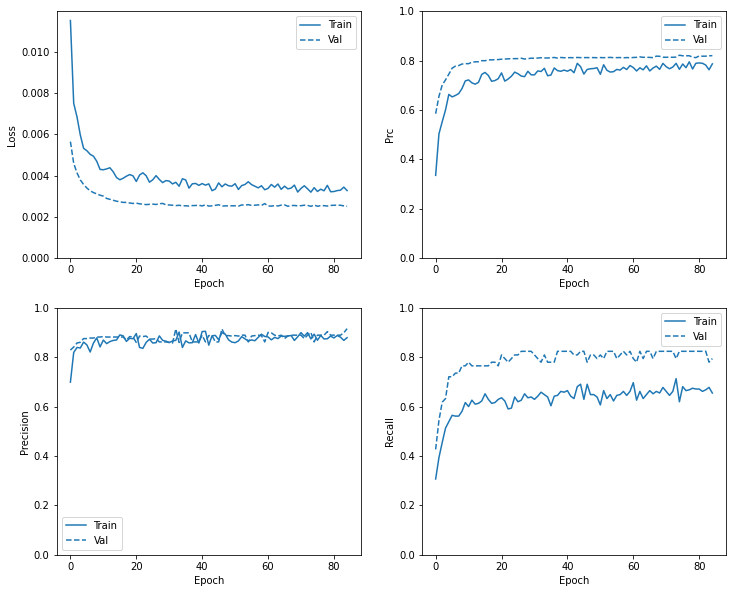

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.0036890378687530756
tp :  86.0
fp :  16.0
tn :  56832.0
fn :  28.0
accuracy :  0.9992275834083557
precision :  0.843137264251709
recall :  0.7543859481811523
auc :  0.9251542687416077
prc :  0.80972820520401

Legitimate Transactions Detected (True Negatives):  56832
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  28
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  114


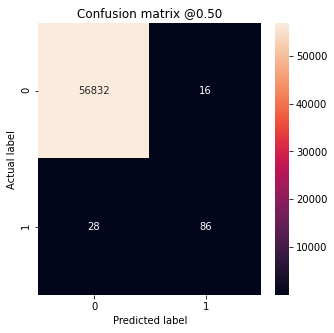

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

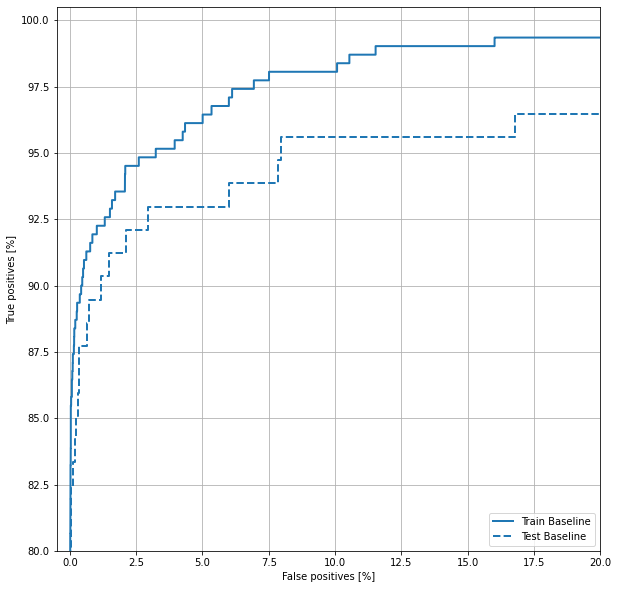

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Plot the ROC
Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

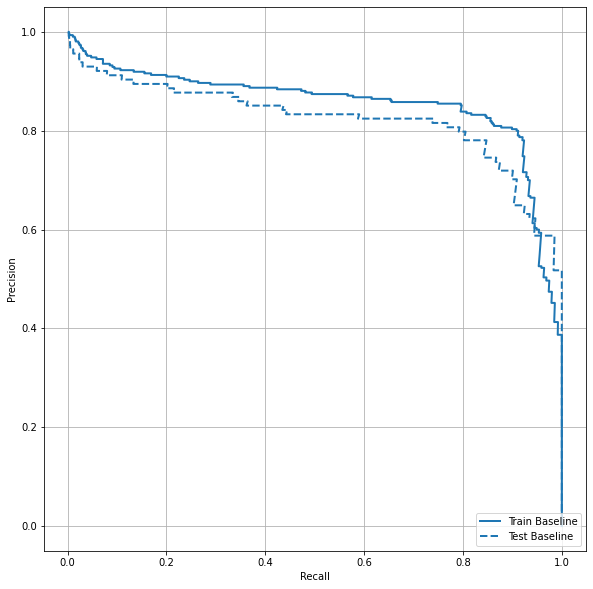

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100


 1/90 [..............................] - ETA: 2:12 - loss: 2.0469 - tp: 87.0000 - fp: 18.0000 - tn: 58876.0000 - fn: 29.0000 - accuracy: 0.9992 - precision: 0.8286 - recall: 0.7500 - auc: 0.9213 - prc: 0.7815

 9/90 [==>...........................] - ETA: 0s - loss: 2.8017 - tp: 87.3333 - fp: 26.3333 - tn: 67044.8889 - fn: 43.4444 - accuracy: 0.9990 - precision: 0.7698 - recall: 0.6709 - auc: 0.8951 - prc: 0.6917  

18/90 [=====>........................] - ETA: 0s - loss: 2.7843 - tp: 89.2778 - fp: 32.2778 - tn: 76237.3889 - fn: 59.0556 - accuracy: 0.9988 - precision: 0.7378 - recall: 0.6112 - auc: 0.8717 - prc: 0.6285

27/90 [========>.....................] - ETA: 0s - loss: 2.7087 - tp: 91.9259 - fp: 39.8519 - tn: 85429.7037 - fn: 72.5185 - accuracy: 0.9987 - precision: 0.7050 - recall: 0.5723 - auc: 0.8549 - prc: 0.5866

36/90 [===========>..................] - ETA: 0s - loss: 2.6092 - tp: 95.5833 - fp: 49.3333 - tn: 94621.0278 - fn: 84.0556 - accuracy: 0.9986 - precision: 0.6735 - recall: 0.5476 - auc: 0.8442 - prc: 0.5573

45/90 [==============>...............] - ETA: 0s - loss: 2.5073 - tp: 99.0889 - fp: 60.2667 - tn: 103812.1556 - fn: 94.4889 - accuracy: 0.9986 - precision: 0.6431 - recall: 0.5288 - auc: 0.8367 - prc: 0.5338

54/90 [=================>............] - ETA: 0s - loss: 2.4281 - tp: 102.6667 - fp: 72.6481 - tn: 113001.0926 - fn: 105.5926 - accuracy: 0.9985 - precision: 0.6147 - recall: 0.5121 - auc: 0.8317 - prc: 0.5123

63/90 [====================>.........] - ETA: 0s - loss: 2.3626 - tp: 106.7778 - fp: 85.8571 - tn: 122188.5714 - fn: 116.7937 - accuracy: 0.9984 - precision: 0.5903 - recall: 0.4985 - auc: 0.8285 - prc: 0.4943

72/90 [=======================>......] - ETA: 0s - loss: 2.3033 - tp: 111.5972 - fp: 100.9583 - tn: 131373.8472 - fn: 127.5972 - accuracy: 0.9984 - precision: 0.5682 - recall: 0.4883 - auc: 0.8263 - prc: 0.4798

81/90 [==========================>...] - ETA: 0s - loss: 2.2460 - tp: 116.6173 - fp: 117.5185 - tn: 140558.0370 - fn: 137.8272 - accuracy: 0.9983 - precision: 0.5479 - recall: 0.4803 - auc: 0.8250 - prc: 0.4676

90/90 [==============================] - ETA: 0s - loss: 2.1942 - tp: 122.3444 - fp: 134.5667 - tn: 149718.3889 - fn: 147.9889 - accuracy: 0.9983 - precision: 0.5307 - recall: 0.4743 - auc: 0.8245 - prc: 0.4574

90/90 [==============================] - 3s 17ms/step - loss: 2.1890 - tp: 122.9560 - fp: 136.3516 - tn: 150694.1978 - fn: 149.0659 - accuracy: 0.9982 - precision: 0.5290 - recall: 0.4737 - auc: 0.8244 - prc: 0.4563 - val_loss: 0.0090 - val_tp: 47.0000 - val_fp: 12.0000 - val_tn: 45489.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.7966 - val_recall: 0.6912 - val_auc: 0.9233 - val_prc: 0.6339


Epoch 2/100
 1/90 [..............................] - ETA: 0s - loss: 2.0876 - tp: 2.0000 - fp: 8.0000 - tn: 2035.0000 - fn: 3.0000 - accuracy: 0.9946 - precision: 0.2000 - recall: 0.4000 - auc: 0.7269 - prc: 0.4411

 9/90 [==>...........................] - ETA: 0s - loss: 1.1363 - tp: 7.5556 - fp: 29.4444 - tn: 10195.7778 - fn: 7.2222 - accuracy: 0.9961 - precision: 0.2050 - recall: 0.5136 - auc: 0.8154 - prc: 0.4073

18/90 [=====>........................] - ETA: 0s - loss: 1.0883 - tp: 16.8333 - fp: 53.4444 - tn: 19371.1111 - fn: 14.6111 - accuracy: 0.9963 - precision: 0.2295 - recall: 0.5276 - auc: 0.8334 - prc: 0.4230

26/90 [=======>......................] - ETA: 0s - loss: 1.0539 - tp: 23.1154 - fp: 77.8462 - tn: 27526.1923 - fn: 20.8462 - accuracy: 0.9964 - precision: 0.2265 - recall: 0.5243 - auc: 0.8414 - prc: 0.4193

34/90 [==========>...................] - ETA: 0s - loss: 1.0406 - tp: 30.8824 - fp: 105.3529 - tn: 35676.2059 - fn: 27.5588 - accuracy: 0.9963 - precision: 0.2258 - recall: 0.5260 - auc: 0.8482 - prc: 0.4239

42/90 [=============>................] - ETA: 0s - loss: 1.0307 - tp: 38.9762 - fp: 131.5000 - tn: 43827.4762 - fn: 34.0476 - accuracy: 0.9963 - precision: 0.2270 - recall: 0.5293 - auc: 0.8533 - prc: 0.4258

50/90 [===============>..............] - ETA: 0s - loss: 1.0147 - tp: 46.3400 - fp: 159.3800 - tn: 51978.6600 - fn: 39.6200 - accuracy: 0.9962 - precision: 0.2256 - recall: 0.5330 - auc: 0.8564 - prc: 0.4265

58/90 [==================>...........] - ETA: 0s - loss: 0.9936 - tp: 53.3966 - fp: 189.6034 - tn: 60128.4655 - fn: 44.5345 - accuracy: 0.9962 - precision: 0.2227 - recall: 0.5373 - auc: 0.8587 - prc: 0.4254

66/90 [=====================>........] - ETA: 0s - loss: 0.9767 - tp: 60.9545 - fp: 221.9697 - tn: 68275.5000 - fn: 49.5758 - accuracy: 0.9961 - precision: 0.2202 - recall: 0.5417 - auc: 0.8607 - prc: 0.4238

74/90 [=======================>......] - ETA: 0s - loss: 0.9595 - tp: 68.7432 - fp: 256.9595 - tn: 76419.9865 - fn: 54.3108 - accuracy: 0.9961 - precision: 0.2176 - recall: 0.5466 - auc: 0.8628 - prc: 0.4230

83/90 [==========================>...] - ETA: 0s - loss: 0.9426 - tp: 78.3373 - fp: 297.5422 - tn: 85580.3614 - fn: 59.7590 - accuracy: 0.9960 - precision: 0.2156 - recall: 0.5525 - auc: 0.8655 - prc: 0.4230

90/90 [==============================] - 1s 8ms/step - loss: 0.9281 - tp: 87.6923 - fp: 335.0330 - tn: 93653.0659 - fn: 64.7802 - accuracy: 0.9959 - precision: 0.2146 - recall: 0.5577 - auc: 0.8684 - prc: 0.4249 - val_loss: 0.0124 - val_tp: 53.0000 - val_fp: 16.0000 - val_tn: 45485.0000 - val_fn: 15.0000 - val_accuracy: 0.9993 - val_precision: 0.7681 - val_recall: 0.7794 - val_auc: 0.9468 - val_prc: 0.6940


Epoch 3/100
 1/90 [..............................] - ETA: 0s - loss: 0.0657 - tp: 3.0000 - fp: 10.0000 - tn: 2035.0000 - fn: 0.0000e+00 - accuracy: 0.9951 - precision: 0.2308 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041

10/90 [==>...........................] - ETA: 0s - loss: 0.2984 - tp: 17.9000 - fp: 66.3000 - tn: 11177.0000 - fn: 2.8000 - accuracy: 0.9942 - precision: 0.2241 - recall: 0.8815 - auc: 0.9568 - prc: 0.6075  

18/90 [=====>........................] - ETA: 0s - loss: 0.3500 - tp: 27.0000 - fp: 118.7222 - tn: 19303.9444 - fn: 6.3333 - accuracy: 0.9938 - precision: 0.2010 - recall: 0.8371 - auc: 0.9525 - prc: 0.5615

26/90 [=======>......................] - ETA: 0s - loss: 0.4076 - tp: 35.8846 - fp: 173.1538 - tn: 27428.4615 - fn: 10.5000 - accuracy: 0.9936 - precision: 0.1883 - recall: 0.8067 - auc: 0.9430 - prc: 0.5284

34/90 [==========>...................] - ETA: 0s - loss: 0.4310 - tp: 44.2059 - fp: 227.3824 - tn: 35554.2059 - fn: 14.2059 - accuracy: 0.9935 - precision: 0.1793 - recall: 0.7892 - auc: 0.9377 - prc: 0.5080

42/90 [=============>................] - ETA: 0s - loss: 0.4487 - tp: 53.0238 - fp: 280.5714 - tn: 43680.1905 - fn: 18.2143 - accuracy: 0.9934 - precision: 0.1740 - recall: 0.7758 - auc: 0.9338 - prc: 0.4976

50/90 [===============>..............] - ETA: 0s - loss: 0.4596 - tp: 62.4800 - fp: 336.3000 - tn: 51803.2200 - fn: 22.0000 - accuracy: 0.9934 - precision: 0.1704 - recall: 0.7682 - auc: 0.9312 - prc: 0.4955

58/90 [==================>...........] - ETA: 0s - loss: 0.4681 - tp: 72.3448 - fp: 394.8793 - tn: 59923.1034 - fn: 25.6724 - accuracy: 0.9933 - precision: 0.1675 - recall: 0.7634 - auc: 0.9291 - prc: 0.4943

66/90 [=====================>........] - ETA: 0s - loss: 0.4739 - tp: 82.4091 - fp: 454.3333 - tn: 68041.9394 - fn: 29.3182 - accuracy: 0.9932 - precision: 0.1653 - recall: 0.7601 - auc: 0.9278 - prc: 0.4952

75/90 [========================>.....] - ETA: 0s - loss: 0.4846 - tp: 93.9200 - fp: 523.9600 - tn: 77172.2133 - fn: 33.9067 - accuracy: 0.9931 - precision: 0.1631 - recall: 0.7560 - auc: 0.9258 - prc: 0.4960

84/90 [===========================>..] - ETA: 0s - loss: 0.4934 - tp: 105.4881 - fp: 595.1905 - tn: 86300.8571 - fn: 38.4643 - accuracy: 0.9930 - precision: 0.1612 - recall: 0.7527 - auc: 0.9243 - prc: 0.4968

90/90 [==============================] - 1s 8ms/step - loss: 0.4995 - tp: 114.1978 - fp: 651.0440 - tn: 93333.2967 - fn: 42.0330 - accuracy: 0.9930 - precision: 0.1597 - recall: 0.7502 - auc: 0.9231 - prc: 0.4971 - val_loss: 0.0168 - val_tp: 55.0000 - val_fp: 31.0000 - val_tn: 45470.0000 - val_fn: 13.0000 - val_accuracy: 0.9990 - val_precision: 0.6395 - val_recall: 0.8088 - val_auc: 0.9510 - val_prc: 0.7183


Epoch 4/100
 1/90 [..............................] - ETA: 0s - loss: 0.6648 - tp: 2.0000 - fp: 22.0000 - tn: 2023.0000 - fn: 1.0000 - accuracy: 0.9888 - precision: 0.0833 - recall: 0.6667 - auc: 0.9165 - prc: 0.3599

 9/90 [==>...........................] - ETA: 0s - loss: 0.5351 - tp: 9.6667 - fp: 110.1111 - tn: 10114.8889 - fn: 5.3333 - accuracy: 0.9888 - precision: 0.0797 - recall: 0.6442 - auc: 0.9360 - prc: 0.4158

17/90 [====>.........................] - ETA: 0s - loss: 0.6258 - tp: 19.4706 - fp: 196.1176 - tn: 18206.2353 - fn: 10.1765 - accuracy: 0.9888 - precision: 0.0862 - recall: 0.6506 - auc: 0.9087 - prc: 0.4139

26/90 [=======>......................] - ETA: 0s - loss: 0.6434 - tp: 32.3846 - fp: 294.8077 - tn: 27306.3462 - fn: 14.4615 - accuracy: 0.9888 - precision: 0.0929 - recall: 0.6727 - auc: 0.9033 - prc: 0.4201

35/90 [==========>...................] - ETA: 0s - loss: 0.6225 - tp: 45.6857 - fp: 394.4000 - tn: 36406.0571 - fn: 17.8571 - accuracy: 0.9888 - precision: 0.0972 - recall: 0.6932 - auc: 0.9060 - prc: 0.4270

44/90 [=============>................] - ETA: 0s - loss: 0.6098 - tp: 59.1818 - fp: 497.3182 - tn: 45501.8864 - fn: 21.6136 - accuracy: 0.9888 - precision: 0.1000 - recall: 0.7059 - auc: 0.9077 - prc: 0.4338

53/90 [================>.............] - ETA: 0s - loss: 0.6051 - tp: 72.3208 - fp: 605.9811 - tn: 54591.8868 - fn: 25.8113 - accuracy: 0.9887 - precision: 0.1012 - recall: 0.7128 - auc: 0.9078 - prc: 0.4361

62/90 [===================>..........] - ETA: 0s - loss: 0.5991 - tp: 84.6774 - fp: 715.8710 - tn: 63681.6452 - fn: 29.8065 - accuracy: 0.9886 - precision: 0.1016 - recall: 0.7177 - auc: 0.9080 - prc: 0.4361

71/90 [======================>.......] - ETA: 0s - loss: 0.5903 - tp: 96.7042 - fp: 829.0423 - tn: 72768.9014 - fn: 33.3521 - accuracy: 0.9885 - precision: 0.1014 - recall: 0.7226 - auc: 0.9087 - prc: 0.4362

80/90 [=========================>....] - ETA: 0s - loss: 0.5793 - tp: 109.7750 - fp: 946.7625 - tn: 81850.9500 - fn: 36.5125 - accuracy: 0.9884 - precision: 0.1015 - recall: 0.7286 - auc: 0.9103 - prc: 0.4384

89/90 [============================>.] - ETA: 0s - loss: 0.5701 - tp: 122.2697 - fp: 1064.9438 - tn: 90933.0899 - fn: 39.6966 - accuracy: 0.9883 - precision: 0.1013 - recall: 0.7333 - auc: 0.9114 - prc: 0.4401

90/90 [==============================] - 1s 8ms/step - loss: 0.5683 - tp: 124.8352 - fp: 1090.5275 - tn: 92884.8242 - fn: 40.3846 - accuracy: 0.9883 - precision: 0.1012 - recall: 0.7341 - auc: 0.9115 - prc: 0.4402 - val_loss: 0.0228 - val_tp: 57.0000 - val_fp: 86.0000 - val_tn: 45415.0000 - val_fn: 11.0000 - val_accuracy: 0.9979 - val_precision: 0.3986 - val_recall: 0.8382 - val_auc: 0.9621 - val_prc: 0.7217


Epoch 5/100
 1/90 [..............................] - ETA: 0s - loss: 0.3395 - tp: 6.0000 - fp: 30.0000 - tn: 2011.0000 - fn: 1.0000 - accuracy: 0.9849 - precision: 0.1667 - recall: 0.8571 - auc: 0.9910 - prc: 0.8040

10/90 [==>...........................] - ETA: 0s - loss: 0.4658 - tp: 14.6000 - fp: 156.7000 - tn: 11087.2000 - fn: 5.5000 - accuracy: 0.9855 - precision: 0.0950 - recall: 0.7367 - auc: 0.9510 - prc: 0.4588

19/90 [=====>........................] - ETA: 0s - loss: 0.4636 - tp: 26.2632 - fp: 292.5263 - tn: 20152.5263 - fn: 8.6842 - accuracy: 0.9854 - precision: 0.0885 - recall: 0.7491 - auc: 0.9405 - prc: 0.4239

28/90 [========>.....................] - ETA: 0s - loss: 0.4834 - tp: 37.6071 - fp: 430.7143 - tn: 29215.6786 - fn: 12.0000 - accuracy: 0.9852 - precision: 0.0853 - recall: 0.7539 - auc: 0.9306 - prc: 0.4021

37/90 [===========>..................] - ETA: 0s - loss: 0.4727 - tp: 48.7297 - fp: 572.0541 - tn: 38276.8919 - fn: 14.3243 - accuracy: 0.9851 - precision: 0.0830 - recall: 0.7636 - auc: 0.9279 - prc: 0.3988

46/90 [==============>...............] - ETA: 0s - loss: 0.4656 - tp: 60.9783 - fp: 709.0217 - tn: 47341.0217 - fn: 16.9783 - accuracy: 0.9850 - precision: 0.0825 - recall: 0.7706 - auc: 0.9269 - prc: 0.4017

55/90 [=================>............] - ETA: 0s - loss: 0.4612 - tp: 73.7273 - fp: 848.8727 - tn: 56401.6909 - fn: 19.7091 - accuracy: 0.9850 - precision: 0.0824 - recall: 0.7762 - auc: 0.9257 - prc: 0.4024

64/90 [====================>.........] - ETA: 0s - loss: 0.4625 - tp: 87.2969 - fp: 991.2500 - tn: 65458.5312 - fn: 22.9219 - accuracy: 0.9849 - precision: 0.0826 - recall: 0.7796 - auc: 0.9241 - prc: 0.4046

73/90 [=======================>......] - ETA: 0s - loss: 0.4618 - tp: 100.3151 - fp: 1137.7123 - tn: 74511.5890 - fn: 26.3836 - accuracy: 0.9848 - precision: 0.0824 - recall: 0.7810 - auc: 0.9236 - prc: 0.4054

82/90 [==========================>...] - ETA: 0s - loss: 0.4582 - tp: 113.0488 - fp: 1289.7561 - tn: 83559.6829 - fn: 29.5122 - accuracy: 0.9847 - precision: 0.0820 - recall: 0.7828 - auc: 0.9236 - prc: 0.4066

90/90 [==============================] - 1s 8ms/step - loss: 0.4563 - tp: 125.4835 - fp: 1442.9560 - tn: 92539.3187 - fn: 32.8132 - accuracy: 0.9846 - precision: 0.0816 - recall: 0.7837 - auc: 0.9236 - prc: 0.4064 - val_loss: 0.0286 - val_tp: 57.0000 - val_fp: 163.0000 - val_tn: 45338.0000 - val_fn: 11.0000 - val_accuracy: 0.9962 - val_precision: 0.2591 - val_recall: 0.8382 - val_auc: 0.9678 - val_prc: 0.7198


Epoch 6/100
 1/90 [..............................] - ETA: 0s - loss: 0.0363 - tp: 0.0000e+00 - fp: 44.0000 - tn: 2004.0000 - fn: 0.0000e+00 - accuracy: 0.9785 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00

10/90 [==>...........................] - ETA: 0s - loss: 0.4027 - tp: 12.9000 - fp: 212.6000 - tn: 11035.4000 - fn: 3.1000 - accuracy: 0.9807 - precision: 0.0492 - recall: 0.6951 - auc: 0.8044 - prc: 0.2602                     

19/90 [=====>........................] - ETA: 0s - loss: 0.3829 - tp: 26.4211 - fp: 386.6316 - tn: 20060.4737 - fn: 6.4737 - accuracy: 0.9808 - precision: 0.0575 - recall: 0.7457 - auc: 0.8722 - prc: 0.3051

28/90 [========>.....................] - ETA: 0s - loss: 0.3718 - tp: 39.4643 - fp: 567.1429 - tn: 29080.1071 - fn: 9.2857 - accuracy: 0.9806 - precision: 0.0602 - recall: 0.7676 - auc: 0.8967 - prc: 0.3241

37/90 [===========>..................] - ETA: 0s - loss: 0.3602 - tp: 54.1622 - fp: 751.9459 - tn: 38094.3243 - fn: 11.5676 - accuracy: 0.9805 - precision: 0.0625 - recall: 0.7857 - auc: 0.9102 - prc: 0.3505

46/90 [==============>...............] - ETA: 0s - loss: 0.3520 - tp: 67.8696 - fp: 938.9348 - tn: 47107.0000 - fn: 14.1957 - accuracy: 0.9804 - precision: 0.0636 - recall: 0.7950 - auc: 0.9187 - prc: 0.3680

55/90 [=================>............] - ETA: 0s - loss: 0.3489 - tp: 80.8364 - fp: 1127.7455 - tn: 56118.3091 - fn: 17.1091 - accuracy: 0.9803 - precision: 0.0639 - recall: 0.7993 - auc: 0.9237 - prc: 0.3764

64/90 [====================>.........] - ETA: 0s - loss: 0.3497 - tp: 92.9219 - fp: 1315.6094 - tn: 65131.3594 - fn: 20.1094 - accuracy: 0.9802 - precision: 0.0639 - recall: 0.8012 - auc: 0.9265 - prc: 0.3809

73/90 [=======================>......] - ETA: 0s - loss: 0.3507 - tp: 105.5890 - fp: 1507.1233 - tn: 74140.3151 - fn: 22.9726 - accuracy: 0.9801 - precision: 0.0639 - recall: 0.8033 - auc: 0.9284 - prc: 0.3845

82/90 [==========================>...] - ETA: 0s - loss: 0.3513 - tp: 118.8659 - fp: 1701.1098 - tn: 83146.1829 - fn: 25.8415 - accuracy: 0.9800 - precision: 0.0639 - recall: 0.8053 - auc: 0.9302 - prc: 0.3872

90/90 [==============================] - 1s 8ms/step - loss: 0.3511 - tp: 131.8791 - fp: 1896.7363 - tn: 92083.4505 - fn: 28.5055 - accuracy: 0.9799 - precision: 0.0639 - recall: 0.8074 - auc: 0.9315 - prc: 0.3888 - val_loss: 0.0363 - val_tp: 57.0000 - val_fp: 260.0000 - val_tn: 45241.0000 - val_fn: 11.0000 - val_accuracy: 0.9941 - val_precision: 0.1798 - val_recall: 0.8382 - val_auc: 0.9705 - val_prc: 0.7030


Epoch 7/100
 1/90 [..............................] - ETA: 0s - loss: 0.9617 - tp: 1.0000 - fp: 44.0000 - tn: 2002.0000 - fn: 1.0000 - accuracy: 0.9780 - precision: 0.0222 - recall: 0.5000 - auc: 0.5954 - prc: 0.1004

10/90 [==>...........................] - ETA: 0s - loss: 0.4955 - tp: 14.1000 - fp: 238.8000 - tn: 11006.7000 - fn: 4.4000 - accuracy: 0.9788 - precision: 0.0498 - recall: 0.7283 - auc: 0.8658 - prc: 0.3497

19/90 [=====>........................] - ETA: 0s - loss: 0.4980 - tp: 28.9474 - fp: 457.1579 - tn: 19985.0000 - fn: 8.8947 - accuracy: 0.9779 - precision: 0.0550 - recall: 0.7463 - auc: 0.8911 - prc: 0.3456

28/90 [========>.....................] - ETA: 0s - loss: 0.4847 - tp: 43.1786 - fp: 688.0000 - tn: 28952.8214 - fn: 12.0000 - accuracy: 0.9772 - precision: 0.0562 - recall: 0.7628 - auc: 0.9017 - prc: 0.3541

37/90 [===========>..................] - ETA: 0s - loss: 0.4667 - tp: 58.6216 - fp: 923.5135 - tn: 37915.2432 - fn: 14.6216 - accuracy: 0.9767 - precision: 0.0573 - recall: 0.7776 - auc: 0.9100 - prc: 0.3618

46/90 [==============>...............] - ETA: 0s - loss: 0.4455 - tp: 73.2174 - fp: 1161.1739 - tn: 46876.8261 - fn: 16.7826 - accuracy: 0.9763 - precision: 0.0576 - recall: 0.7895 - auc: 0.9166 - prc: 0.3648

55/90 [=================>............] - ETA: 0s - loss: 0.4315 - tp: 87.2727 - fp: 1401.6000 - tn: 55835.9636 - fn: 19.1636 - accuracy: 0.9760 - precision: 0.0575 - recall: 0.7970 - auc: 0.9211 - prc: 0.3646

63/90 [====================>.........] - ETA: 0s - loss: 0.4230 - tp: 100.0952 - fp: 1615.4921 - tn: 63799.0476 - fn: 21.3651 - accuracy: 0.9758 - precision: 0.0575 - recall: 0.8021 - auc: 0.9239 - prc: 0.3647

71/90 [======================>.......] - ETA: 0s - loss: 0.4156 - tp: 112.1549 - fp: 1831.3944 - tn: 71760.8873 - fn: 23.5634 - accuracy: 0.9756 - precision: 0.0572 - recall: 0.8059 - auc: 0.9261 - prc: 0.3624

80/90 [=========================>....] - ETA: 0s - loss: 0.4066 - tp: 124.9250 - fp: 2073.5375 - tn: 80719.6625 - fn: 25.8750 - accuracy: 0.9755 - precision: 0.0568 - recall: 0.8093 - auc: 0.9283 - prc: 0.3589

89/90 [============================>.] - ETA: 0s - loss: 0.3994 - tp: 137.3483 - fp: 2317.3258 - tn: 89677.1910 - fn: 28.1348 - accuracy: 0.9753 - precision: 0.0564 - recall: 0.8121 - auc: 0.9300 - prc: 0.3554

90/90 [==============================] - 1s 8ms/step - loss: 0.3982 - tp: 140.0220 - fp: 2369.8462 - tn: 91602.0659 - fn: 28.6374 - accuracy: 0.9753 - precision: 0.0563 - recall: 0.8126 - auc: 0.9303 - prc: 0.3547 - val_loss: 0.0433 - val_tp: 57.0000 - val_fp: 340.0000 - val_tn: 45161.0000 - val_fn: 11.0000 - val_accuracy: 0.9923 - val_precision: 0.1436 - val_recall: 0.8382 - val_auc: 0.9772 - val_prc: 0.6970


Epoch 8/100
 1/90 [..............................] - ETA: 0s - loss: 0.0558 - tp: 2.0000 - fp: 70.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9658 - precision: 0.0278 - recall: 1.0000 - auc: 0.9995 - prc: 0.5000

10/90 [==>...........................] - ETA: 0s - loss: 0.2974 - tp: 14.2000 - fp: 332.1000 - tn: 10915.2000 - fn: 2.5000 - accuracy: 0.9698 - precision: 0.0386 - recall: 0.8750 - auc: 0.9500 - prc: 0.3050 

19/90 [=====>........................] - ETA: 0s - loss: 0.3281 - tp: 27.6316 - fp: 594.3158 - tn: 19852.2105 - fn: 5.8421 - accuracy: 0.9703 - precision: 0.0420 - recall: 0.8484 - auc: 0.9449 - prc: 0.2893

28/90 [========>.....................] - ETA: 0s - loss: 0.3281 - tp: 40.4643 - fp: 858.2857 - tn: 28788.6071 - fn: 8.6429 - accuracy: 0.9705 - precision: 0.0431 - recall: 0.8398 - auc: 0.9446 - prc: 0.2917

37/90 [===========>..................] - ETA: 0s - loss: 0.3136 - tp: 53.4595 - fp: 1128.9730 - tn: 37719.0541 - fn: 10.5135 - accuracy: 0.9705 - precision: 0.0437 - recall: 0.8427 - auc: 0.9473 - prc: 0.2922

46/90 [==============>...............] - ETA: 0s - loss: 0.3058 - tp: 65.4130 - fp: 1392.1304 - tn: 46657.8261 - fn: 12.6304 - accuracy: 0.9706 - precision: 0.0438 - recall: 0.8427 - auc: 0.9486 - prc: 0.2918

55/90 [=================>............] - ETA: 0s - loss: 0.3018 - tp: 78.0364 - fp: 1649.0182 - tn: 55602.2364 - fn: 14.7091 - accuracy: 0.9707 - precision: 0.0441 - recall: 0.8438 - auc: 0.9489 - prc: 0.2925

64/90 [====================>.........] - ETA: 0s - loss: 0.3020 - tp: 91.1250 - fp: 1906.6406 - tn: 64545.1406 - fn: 17.0938 - accuracy: 0.9708 - precision: 0.0445 - recall: 0.8439 - auc: 0.9486 - prc: 0.2930

73/90 [=======================>......] - ETA: 0s - loss: 0.3049 - tp: 104.8904 - fp: 2169.0548 - tn: 73482.2603 - fn: 19.7945 - accuracy: 0.9709 - precision: 0.0449 - recall: 0.8432 - auc: 0.9480 - prc: 0.2943

82/90 [==========================>...] - ETA: 0s - loss: 0.3083 - tp: 119.0122 - fp: 2430.6829 - tn: 82419.8902 - fn: 22.4146 - accuracy: 0.9709 - precision: 0.0454 - recall: 0.8431 - auc: 0.9474 - prc: 0.2958

90/90 [==============================] - 1s 8ms/step - loss: 0.3107 - tp: 132.4835 - fp: 2692.9341 - tn: 91290.3297 - fn: 24.8242 - accuracy: 0.9709 - precision: 0.0456 - recall: 0.8433 - auc: 0.9469 - prc: 0.2969 - val_loss: 0.0495 - val_tp: 57.0000 - val_fp: 404.0000 - val_tn: 45097.0000 - val_fn: 11.0000 - val_accuracy: 0.9909 - val_precision: 0.1236 - val_recall: 0.8382 - val_auc: 0.9773 - val_prc: 0.6773


Epoch 9/100
 1/90 [..............................] - ETA: 0s - loss: 0.0839 - tp: 3.0000 - fp: 58.0000 - tn: 1987.0000 - fn: 0.0000e+00 - accuracy: 0.9717 - precision: 0.0492 - recall: 1.0000 - auc: 0.9948 - prc: 0.2931

10/90 [==>...........................] - ETA: 0s - loss: 0.3042 - tp: 18.5000 - fp: 333.0000 - tn: 10909.3000 - fn: 3.2000 - accuracy: 0.9703 - precision: 0.0522 - recall: 0.8893 - auc: 0.9556 - prc: 0.3606 

19/90 [=====>........................] - ETA: 0s - loss: 0.3137 - tp: 29.9474 - fp: 603.3684 - tn: 19841.2105 - fn: 5.4737 - accuracy: 0.9703 - precision: 0.0490 - recall: 0.8671 - auc: 0.9500 - prc: 0.3395

28/90 [========>.....................] - ETA: 0s - loss: 0.3102 - tp: 40.9286 - fp: 885.6429 - tn: 28762.0714 - fn: 7.3571 - accuracy: 0.9701 - precision: 0.0466 - recall: 0.8614 - auc: 0.9476 - prc: 0.3239

37/90 [===========>..................] - ETA: 0s - loss: 0.3046 - tp: 52.1622 - fp: 1173.8919 - tn: 37676.8919 - fn: 9.0541 - accuracy: 0.9699 - precision: 0.0451 - recall: 0.8607 - auc: 0.9470 - prc: 0.3143

46/90 [==============>...............] - ETA: 0s - loss: 0.2991 - tp: 63.2826 - fp: 1458.2174 - tn: 46595.6957 - fn: 10.8043 - accuracy: 0.9697 - precision: 0.0440 - recall: 0.8602 - auc: 0.9474 - prc: 0.3080

55/90 [=================>............] - ETA: 0s - loss: 0.2928 - tp: 74.6909 - fp: 1742.6182 - tn: 55513.9818 - fn: 12.7091 - accuracy: 0.9697 - precision: 0.0434 - recall: 0.8595 - auc: 0.9486 - prc: 0.3049

64/90 [====================>.........] - ETA: 0s - loss: 0.2871 - tp: 87.1719 - fp: 2032.5625 - tn: 64425.6719 - fn: 14.5938 - accuracy: 0.9695 - precision: 0.0431 - recall: 0.8598 - auc: 0.9500 - prc: 0.3044

73/90 [=======================>......] - ETA: 0s - loss: 0.2820 - tp: 100.2192 - fp: 2322.3973 - tn: 73336.9178 - fn: 16.4658 - accuracy: 0.9694 - precision: 0.0429 - recall: 0.8606 - auc: 0.9512 - prc: 0.3052

82/90 [==========================>...] - ETA: 0s - loss: 0.2802 - tp: 113.9146 - fp: 2614.5732 - tn: 82244.9634 - fn: 18.5488 - accuracy: 0.9693 - precision: 0.0430 - recall: 0.8610 - auc: 0.9517 - prc: 0.3058

90/90 [==============================] - 1s 8ms/step - loss: 0.2811 - tp: 128.4396 - fp: 2906.1429 - tn: 91085.2418 - fn: 20.7473 - accuracy: 0.9693 - precision: 0.0431 - recall: 0.8614 - auc: 0.9516 - prc: 0.3060 - val_loss: 0.0548 - val_tp: 57.0000 - val_fp: 486.0000 - val_tn: 45015.0000 - val_fn: 11.0000 - val_accuracy: 0.9891 - val_precision: 0.1050 - val_recall: 0.8382 - val_auc: 0.9787 - val_prc: 0.6772


Epoch 10/100
 1/90 [..............................] - ETA: 0s - loss: 0.0635 - tp: 1.0000 - fp: 65.0000 - tn: 1982.0000 - fn: 0.0000e+00 - accuracy: 0.9683 - precision: 0.0152 - recall: 1.0000 - auc: 0.9985 - prc: 0.1429

10/90 [==>...........................] - ETA: 0s - loss: 0.3059 - tp: 10.6000 - fp: 375.0000 - tn: 10875.7000 - fn: 2.7000 - accuracy: 0.9672 - precision: 0.0260 - recall: 0.7929 - auc: 0.9359 - prc: 0.1703 

19/90 [=====>........................] - ETA: 0s - loss: 0.2749 - tp: 25.8421 - fp: 688.2105 - tn: 19761.4211 - fn: 4.5263 - accuracy: 0.9666 - precision: 0.0322 - recall: 0.8282 - auc: 0.9490 - prc: 0.2063

28/90 [========>.....................] - ETA: 0s - loss: 0.2500 - tp: 40.6071 - fp: 982.5357 - tn: 28666.5714 - fn: 6.2857 - accuracy: 0.9668 - precision: 0.0356 - recall: 0.8442 - auc: 0.9575 - prc: 0.2315

37/90 [===========>..................] - ETA: 0s - loss: 0.2466 - tp: 53.4054 - fp: 1277.8919 - tn: 37572.0541 - fn: 8.6486 - accuracy: 0.9669 - precision: 0.0369 - recall: 0.8464 - auc: 0.9599 - prc: 0.2389

46/90 [==============>...............] - ETA: 0s - loss: 0.2457 - tp: 66.7826 - fp: 1576.5435 - tn: 46473.9348 - fn: 10.7391 - accuracy: 0.9670 - precision: 0.0378 - recall: 0.8496 - auc: 0.9608 - prc: 0.2456

55/90 [=================>............] - ETA: 0s - loss: 0.2438 - tp: 79.5091 - fp: 1878.4000 - tn: 55373.6182 - fn: 12.4727 - accuracy: 0.9670 - precision: 0.0382 - recall: 0.8532 - auc: 0.9611 - prc: 0.2514

64/90 [====================>.........] - ETA: 0s - loss: 0.2455 - tp: 92.0469 - fp: 2177.6562 - tn: 64275.9844 - fn: 14.3125 - accuracy: 0.9670 - precision: 0.0385 - recall: 0.8553 - auc: 0.9603 - prc: 0.2554

73/90 [=======================>......] - ETA: 0s - loss: 0.2452 - tp: 104.1644 - fp: 2476.0274 - tn: 73179.8904 - fn: 15.9178 - accuracy: 0.9670 - precision: 0.0387 - recall: 0.8577 - auc: 0.9600 - prc: 0.2588

82/90 [==========================>...] - ETA: 0s - loss: 0.2474 - tp: 117.8293 - fp: 2775.9512 - tn: 82080.4390 - fn: 17.7805 - accuracy: 0.9671 - precision: 0.0391 - recall: 0.8595 - auc: 0.9593 - prc: 0.2621

90/90 [==============================] - 1s 8ms/step - loss: 0.2488 - tp: 132.1648 - fp: 3072.9341 - tn: 90915.8462 - fn: 19.6264 - accuracy: 0.9671 - precision: 0.0395 - recall: 0.8613 - auc: 0.9591 - prc: 0.2658 - val_loss: 0.0562 - val_tp: 57.0000 - val_fp: 504.0000 - val_tn: 44997.0000 - val_fn: 11.0000 - val_accuracy: 0.9887 - val_precision: 0.1016 - val_recall: 0.8382 - val_auc: 0.9792 - val_prc: 0.6680


Epoch 11/100
 1/90 [..............................] - ETA: 0s - loss: 0.0685 - tp: 6.0000 - fp: 73.0000 - tn: 1969.0000 - fn: 0.0000e+00 - accuracy: 0.9644 - precision: 0.0759 - recall: 1.0000 - auc: 0.9978 - prc: 0.4000

10/90 [==>...........................] - ETA: 0s - loss: 0.1460 - tp: 19.3000 - fp: 355.8000 - tn: 10887.2000 - fn: 1.7000 - accuracy: 0.9679 - precision: 0.0560 - recall: 0.9342 - auc: 0.9857 - prc: 0.3397 

18/90 [=====>........................] - ETA: 0s - loss: 0.2160 - tp: 31.9444 - fp: 619.8889 - tn: 18799.9444 - fn: 4.2222 - accuracy: 0.9678 - precision: 0.0523 - recall: 0.9039 - auc: 0.9713 - prc: 0.3260

26/90 [=======>......................] - ETA: 0s - loss: 0.2578 - tp: 44.2692 - fp: 886.0769 - tn: 26710.7308 - fn: 6.9231 - accuracy: 0.9677 - precision: 0.0505 - recall: 0.8866 - auc: 0.9624 - prc: 0.3196

35/90 [==========>...................] - ETA: 0s - loss: 0.2804 - tp: 58.2571 - fp: 1184.7429 - tn: 35611.2286 - fn: 9.7714 - accuracy: 0.9677 - precision: 0.0493 - recall: 0.8761 - auc: 0.9573 - prc: 0.3171

44/90 [=============>................] - ETA: 0s - loss: 0.2908 - tp: 71.6364 - fp: 1488.8864 - tn: 44506.8864 - fn: 12.5909 - accuracy: 0.9675 - precision: 0.0483 - recall: 0.8687 - auc: 0.9550 - prc: 0.3130

53/90 [================>.............] - ETA: 0s - loss: 0.3044 - tp: 85.9245 - fp: 1799.0943 - tn: 53395.3019 - fn: 15.6792 - accuracy: 0.9674 - precision: 0.0477 - recall: 0.8630 - auc: 0.9526 - prc: 0.3079

62/90 [===================>..........] - ETA: 0s - loss: 0.3138 - tp: 99.4839 - fp: 2113.6774 - tn: 62280.0000 - fn: 18.8387 - accuracy: 0.9672 - precision: 0.0471 - recall: 0.8578 - auc: 0.9510 - prc: 0.3020

70/90 [======================>.......] - ETA: 0s - loss: 0.3166 - tp: 110.4286 - fp: 2399.3571 - tn: 70173.1429 - fn: 21.0714 - accuracy: 0.9671 - precision: 0.0463 - recall: 0.8553 - auc: 0.9501 - prc: 0.2970

79/90 [=========================>....] - ETA: 0s - loss: 0.3175 - tp: 122.1646 - fp: 2721.2405 - tn: 79053.3671 - fn: 23.2278 - accuracy: 0.9669 - precision: 0.0455 - recall: 0.8538 - auc: 0.9493 - prc: 0.2921

88/90 [============================>.] - ETA: 0s - loss: 0.3163 - tp: 135.1932 - fp: 3044.4318 - tn: 87931.2614 - fn: 25.1136 - accuracy: 0.9668 - precision: 0.0450 - recall: 0.8541 - auc: 0.9492 - prc: 0.2894

90/90 [==============================] - 1s 8ms/step - loss: 0.3162 - tp: 139.4396 - fp: 3150.4396 - tn: 90824.8901 - fn: 25.8022 - accuracy: 0.9667 - precision: 0.0449 - recall: 0.8540 - auc: 0.9491 - prc: 0.2886 - val_loss: 0.0617 - val_tp: 58.0000 - val_fp: 579.0000 - val_tn: 44922.0000 - val_fn: 10.0000 - val_accuracy: 0.9871 - val_precision: 0.0911 - val_recall: 0.8529 - val_auc: 0.9793 - val_prc: 0.6335


Epoch 12/100
 1/90 [..............................] - ETA: 0s - loss: 0.1876 - tp: 4.0000 - fp: 91.0000 - tn: 1953.0000 - fn: 0.0000e+00 - accuracy: 0.9556 - precision: 0.0421 - recall: 1.0000 - auc: 0.9860 - prc: 0.1689

10/90 [==>...........................] - ETA: 0s - loss: 0.3277 - tp: 20.1000 - fp: 430.1000 - tn: 10810.5000 - fn: 3.3000 - accuracy: 0.9607 - precision: 0.0445 - recall: 0.8830 - auc: 0.9595 - prc: 0.2331 

19/90 [=====>........................] - ETA: 0s - loss: 0.3216 - tp: 34.5263 - fp: 765.8421 - tn: 19673.5263 - fn: 6.1053 - accuracy: 0.9616 - precision: 0.0435 - recall: 0.8643 - auc: 0.9586 - prc: 0.2289

28/90 [========>.....................] - ETA: 0s - loss: 0.3071 - tp: 47.3929 - fp: 1103.9286 - tn: 28536.6429 - fn: 8.0357 - accuracy: 0.9620 - precision: 0.0422 - recall: 0.8629 - auc: 0.9586 - prc: 0.2267

37/90 [===========>..................] - ETA: 0s - loss: 0.2995 - tp: 61.8919 - fp: 1440.8649 - tn: 37399.2973 - fn: 9.9459 - accuracy: 0.9622 - precision: 0.0420 - recall: 0.8647 - auc: 0.9586 - prc: 0.2332

46/90 [==============>...............] - ETA: 0s - loss: 0.2903 - tp: 75.7391 - fp: 1772.1739 - tn: 46268.6304 - fn: 11.4565 - accuracy: 0.9624 - precision: 0.0417 - recall: 0.8682 - auc: 0.9592 - prc: 0.2394

55/90 [=================>............] - ETA: 0s - loss: 0.2806 - tp: 89.0545 - fp: 2097.4909 - tn: 55144.8000 - fn: 12.6545 - accuracy: 0.9627 - precision: 0.0414 - recall: 0.8723 - auc: 0.9601 - prc: 0.2448

64/90 [====================>.........] - ETA: 0s - loss: 0.2774 - tp: 101.7344 - fp: 2424.4062 - tn: 64019.5469 - fn: 14.3125 - accuracy: 0.9628 - precision: 0.0411 - recall: 0.8734 - auc: 0.9597 - prc: 0.2474

73/90 [=======================>......] - ETA: 0s - loss: 0.2766 - tp: 114.2877 - fp: 2754.1507 - tn: 72891.3562 - fn: 16.2055 - accuracy: 0.9629 - precision: 0.0408 - recall: 0.8733 - auc: 0.9590 - prc: 0.2487

82/90 [==========================>...] - ETA: 0s - loss: 0.2781 - tp: 127.2683 - fp: 3084.0488 - tn: 81762.1707 - fn: 18.5122 - accuracy: 0.9630 - precision: 0.0405 - recall: 0.8721 - auc: 0.9582 - prc: 0.2496

90/90 [==============================] - 1s 8ms/step - loss: 0.2796 - tp: 140.4066 - fp: 3411.0989 - tn: 90568.3187 - fn: 20.7473 - accuracy: 0.9631 - precision: 0.0404 - recall: 0.8712 - auc: 0.9575 - prc: 0.2504 - val_loss: 0.0669 - val_tp: 58.0000 - val_fp: 669.0000 - val_tn: 44832.0000 - val_fn: 10.0000 - val_accuracy: 0.9851 - val_precision: 0.0798 - val_recall: 0.8529 - val_auc: 0.9794 - val_prc: 0.6173


Epoch 13/100
 1/90 [..............................] - ETA: 0s - loss: 0.0627 - tp: 2.0000 - fp: 78.0000 - tn: 1968.0000 - fn: 0.0000e+00 - accuracy: 0.9619 - precision: 0.0250 - recall: 1.0000 - auc: 0.9983 - prc: 0.2222

10/90 [==>...........................] - ETA: 0s - loss: 0.1719 - tp: 18.8000 - fp: 430.4000 - tn: 10813.0000 - fn: 1.8000 - accuracy: 0.9617 - precision: 0.0407 - recall: 0.9399 - auc: 0.9787 - prc: 0.2293 

19/90 [=====>........................] - ETA: 0s - loss: 0.2203 - tp: 32.9474 - fp: 763.3684 - tn: 19679.1053 - fn: 4.5789 - accuracy: 0.9623 - precision: 0.0410 - recall: 0.9037 - auc: 0.9697 - prc: 0.2459

28/90 [========>.....................] - ETA: 0s - loss: 0.2218 - tp: 45.3571 - fp: 1107.5357 - tn: 28536.6429 - fn: 6.4643 - accuracy: 0.9623 - precision: 0.0399 - recall: 0.8937 - auc: 0.9688 - prc: 0.2494

37/90 [===========>..................] - ETA: 0s - loss: 0.2308 - tp: 57.5676 - fp: 1453.2703 - tn: 37392.6486 - fn: 8.5135 - accuracy: 0.9623 - precision: 0.0391 - recall: 0.8869 - auc: 0.9658 - prc: 0.2479

46/90 [==============>...............] - ETA: 0s - loss: 0.2409 - tp: 71.0217 - fp: 1793.7609 - tn: 46252.4348 - fn: 10.7826 - accuracy: 0.9624 - precision: 0.0389 - recall: 0.8821 - auc: 0.9634 - prc: 0.2462

55/90 [=================>............] - ETA: 0s - loss: 0.2466 - tp: 83.9273 - fp: 2131.9273 - tn: 55115.2727 - fn: 12.8727 - accuracy: 0.9625 - precision: 0.0386 - recall: 0.8792 - auc: 0.9618 - prc: 0.2452

64/90 [====================>.........] - ETA: 0s - loss: 0.2527 - tp: 96.5156 - fp: 2470.5000 - tn: 63977.9219 - fn: 15.0625 - accuracy: 0.9625 - precision: 0.0384 - recall: 0.8764 - auc: 0.9601 - prc: 0.2435

73/90 [=======================>......] - ETA: 0s - loss: 0.2579 - tp: 109.6438 - fp: 2806.1096 - tn: 72843.0137 - fn: 17.2329 - accuracy: 0.9626 - precision: 0.0383 - recall: 0.8745 - auc: 0.9587 - prc: 0.2426

82/90 [==========================>...] - ETA: 0s - loss: 0.2613 - tp: 123.1951 - fp: 3142.8902 - tn: 81706.5244 - fn: 19.3902 - accuracy: 0.9626 - precision: 0.0383 - recall: 0.8733 - auc: 0.9578 - prc: 0.2425

90/90 [==============================] - 1s 8ms/step - loss: 0.2629 - tp: 136.8791 - fp: 3478.8022 - tn: 90503.5604 - fn: 21.3297 - accuracy: 0.9627 - precision: 0.0383 - recall: 0.8730 - auc: 0.9574 - prc: 0.2429 - val_loss: 0.0692 - val_tp: 58.0000 - val_fp: 701.0000 - val_tn: 44800.0000 - val_fn: 10.0000 - val_accuracy: 0.9844 - val_precision: 0.0764 - val_recall: 0.8529 - val_auc: 0.9796 - val_prc: 0.6173


Epoch 14/100
 1/90 [..............................] - ETA: 0s - loss: 0.0579 - tp: 6.0000 - fp: 71.0000 - tn: 1971.0000 - fn: 0.0000e+00 - accuracy: 0.9653 - precision: 0.0779 - recall: 1.0000 - auc: 0.9983 - prc: 0.4615

 9/90 [==>...........................] - ETA: 0s - loss: 0.1206 - tp: 16.0000 - fp: 363.8889 - tn: 9859.2222 - fn: 0.8889 - accuracy: 0.9648 - precision: 0.0484 - recall: 0.9610 - auc: 0.9866 - prc: 0.3317  

18/90 [=====>........................] - ETA: 0s - loss: 0.1518 - tp: 28.7778 - fp: 701.0556 - tn: 18723.5556 - fn: 2.6111 - accuracy: 0.9643 - precision: 0.0434 - recall: 0.9343 - auc: 0.9814 - prc: 0.2994

27/90 [========>.....................] - ETA: 0s - loss: 0.1896 - tp: 43.0000 - fp: 1032.7407 - tn: 27591.0370 - fn: 5.2222 - accuracy: 0.9641 - precision: 0.0424 - recall: 0.9136 - auc: 0.9734 - prc: 0.2923

36/90 [===========>..................] - ETA: 0s - loss: 0.2024 - tp: 56.0000 - fp: 1370.4444 - tn: 36454.3333 - fn: 7.2222 - accuracy: 0.9639 - precision: 0.0414 - recall: 0.9047 - auc: 0.9700 - prc: 0.2873

45/90 [==============>...............] - ETA: 0s - loss: 0.2110 - tp: 67.7556 - fp: 1710.3778 - tn: 45316.2889 - fn: 9.5778 - accuracy: 0.9638 - precision: 0.0403 - recall: 0.8955 - auc: 0.9679 - prc: 0.2799

54/90 [=================>............] - ETA: 0s - loss: 0.2195 - tp: 80.3889 - fp: 2053.0926 - tn: 54174.2778 - fn: 12.2407 - accuracy: 0.9637 - precision: 0.0397 - recall: 0.8877 - auc: 0.9661 - prc: 0.2746

63/90 [====================>.........] - ETA: 0s - loss: 0.2274 - tp: 94.3175 - fp: 2397.0317 - tn: 63029.8095 - fn: 14.8413 - accuracy: 0.9635 - precision: 0.0395 - recall: 0.8829 - auc: 0.9647 - prc: 0.2715

72/90 [=======================>......] - ETA: 0s - loss: 0.2319 - tp: 108.2778 - fp: 2740.7917 - tn: 71885.8056 - fn: 17.1250 - accuracy: 0.9634 - precision: 0.0394 - recall: 0.8802 - auc: 0.9640 - prc: 0.2691

81/90 [==========================>...] - ETA: 0s - loss: 0.2347 - tp: 122.3704 - fp: 3089.5432 - tn: 80736.8642 - fn: 19.2222 - accuracy: 0.9633 - precision: 0.0393 - recall: 0.8787 - auc: 0.9636 - prc: 0.2673

90/90 [==============================] - ETA: 0s - loss: 0.2351 - tp: 136.3444 - fp: 3438.8556 - tn: 89565.1444 - fn: 20.9444 - accuracy: 0.9632 - precision: 0.0392 - recall: 0.8786 - auc: 0.9636 - prc: 0.2660

90/90 [==============================] - 1s 8ms/step - loss: 0.2351 - tp: 137.8462 - fp: 3475.8681 - tn: 90505.7363 - fn: 21.1209 - accuracy: 0.9632 - precision: 0.0392 - recall: 0.8787 - auc: 0.9636 - prc: 0.2659 - val_loss: 0.0715 - val_tp: 58.0000 - val_fp: 726.0000 - val_tn: 44775.0000 - val_fn: 10.0000 - val_accuracy: 0.9838 - val_precision: 0.0740 - val_recall: 0.8529 - val_auc: 0.9812 - val_prc: 0.6174


Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


### Check training history

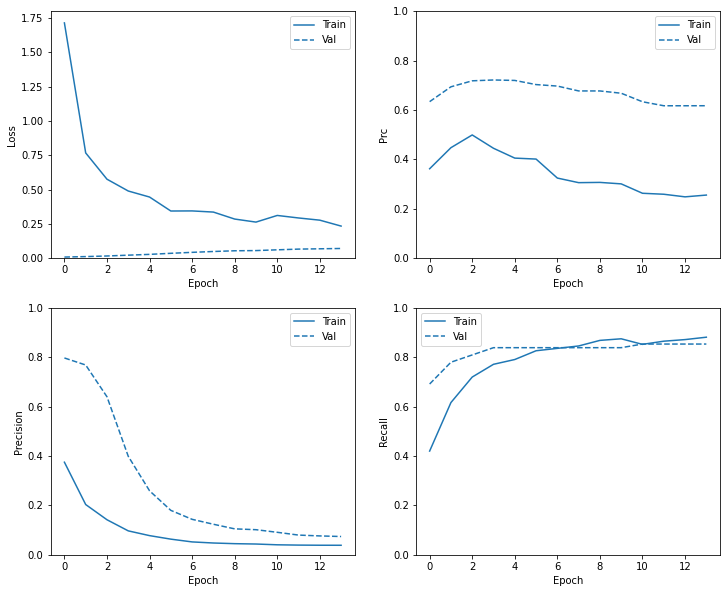

In [36]:
plot_metrics(weighted_history)

### Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.024028101935982704
tp :  93.0
fp :  99.0
tn :  56749.0
fn :  21.0
accuracy :  0.9978933334350586
precision :  0.484375
recall :  0.8157894611358643
auc :  0.9706312417984009
prc :  0.6766911745071411



Legitimate Transactions Detected (True Negatives):  56749
Legitimate Transactions Incorrectly Detected (False Positives):  99
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  93
Total Fraudulent Transactions:  114


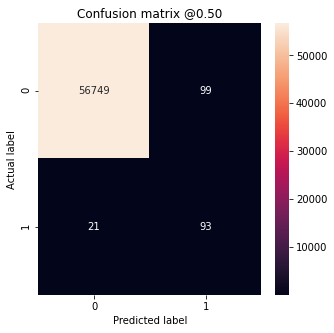

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

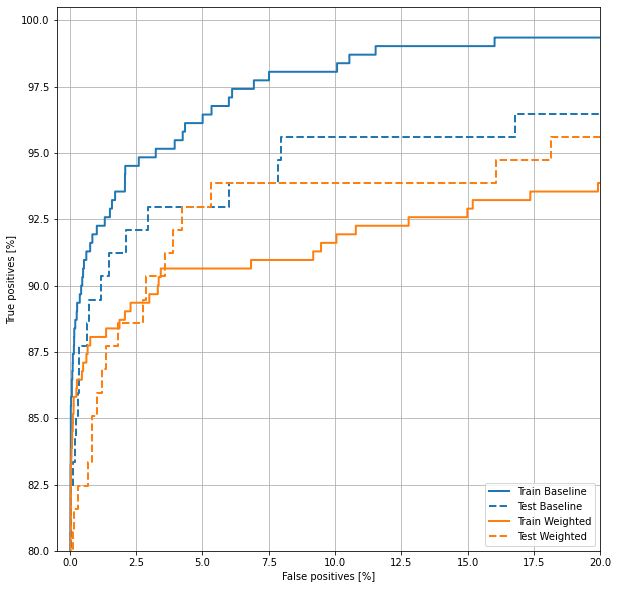

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### Plot the AUPRC

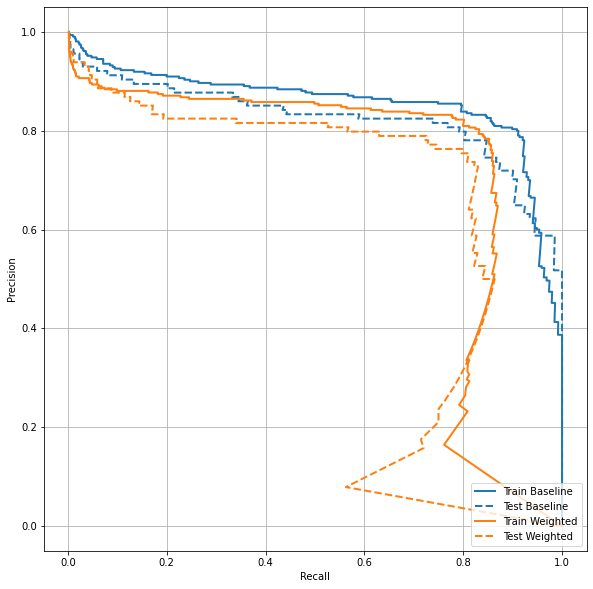

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181966, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363932, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.66303937  0.25245179  0.1263118   0.63886621  0.09535758 -0.27856354
  0.12512054 -0.17039113 -0.07404569 -0.0401322  -0.85920451  0.69018467
  1.58227421 -0.00707812  1.03705783  0.42933153 -1.02645341 -0.0811121
 -0.07953324 -0.0389733  -0.15173702 -0.30237571 -0.19449175 -0.73007126
  1.29012445 -0.85703142  0.08285249  0.06733918 -1.36825945]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4970703125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100


  1/278 [..............................] - ETA: 7:39 - loss: 1.1853 - tp: 653.0000 - fp: 698.0000 - tn: 57172.0000 - fn: 487.0000 - accuracy: 0.9799 - precision: 0.4833 - recall: 0.5728 - auc: 0.9247 - prc: 0.5730

  5/278 [..............................] - ETA: 4s - loss: 1.1651 - tp: 1775.4000 - fp: 1879.6000 - tn: 58044.6000 - fn: 1406.4000 - accuracy: 0.9489 - precision: 0.4834 - recall: 0.5582 - auc: 0.9133 - prc: 0.5937

  8/278 [..............................] - ETA: 4s - loss: 1.1436 - tp: 2692.6250 - fp: 2751.7500 - tn: 58695.5000 - fn: 2038.1250 - accuracy: 0.9298 - precision: 0.4899 - recall: 0.5651 - auc: 0.9079 - prc: 0.6103

 11/278 [>.............................] - ETA: 4s - loss: 1.1219 - tp: 3653.4545 - fp: 3611.1818 - tn: 59350.6364 - fn: 2634.7273 - accuracy: 0.9133 - precision: 0.4961 - recall: 0.5733 - auc: 0.9033 - prc: 0.6248

 14/278 [>.............................] - ETA: 4s - loss: 1.1019 - tp: 4647.1429 - fp: 4464.0714 - tn: 60015.0000 - fn: 3195.7857 - accuracy: 0.8990 - precision: 0.5016 - recall: 0.5815 - auc: 0.8991 - prc: 0.6372

 17/278 [>.............................] - ETA: 4s - loss: 1.0837 - tp: 5666.8824 - fp: 5319.7647 - tn: 60683.9412 - fn: 3723.4118 - accuracy: 0.8863 - precision: 0.5063 - recall: 0.5896 - auc: 0.8952 - prc: 0.6479

 20/278 [=>............................] - ETA: 4s - loss: 1.0671 - tp: 6717.6000 - fp: 6182.3500 - tn: 61346.3500 - fn: 4219.7000 - accuracy: 0.8751 - precision: 0.5104 - recall: 0.5976 - auc: 0.8918 - prc: 0.6575

 23/278 [=>............................] - ETA: 4s - loss: 1.0516 - tp: 7795.9130 - fp: 7040.8696 - tn: 62011.8261 - fn: 4689.3913 - accuracy: 0.8650 - precision: 0.5143 - recall: 0.6054 - auc: 0.8888 - prc: 0.6664

 26/278 [=>............................] - ETA: 4s - loss: 1.0369 - tp: 8896.2692 - fp: 7897.7692 - tn: 62683.3846 - fn: 5132.5769 - accuracy: 0.8561 - precision: 0.5178 - recall: 0.6128 - auc: 0.8861 - prc: 0.6746

 29/278 [==>...........................] - ETA: 4s - loss: 1.0231 - tp: 10015.7931 - fp: 8753.5172 - tn: 63361.6207 - fn: 5551.0690 - accuracy: 0.8480 - precision: 0.5211 - recall: 0.6200 - auc: 0.8838 - prc: 0.6821

 32/278 [==>...........................] - ETA: 4s - loss: 1.0099 - tp: 11158.8750 - fp: 9600.5312 - tn: 64045.5000 - fn: 5949.0938 - accuracy: 0.8408 - precision: 0.5243 - recall: 0.6269 - auc: 0.8817 - prc: 0.6892

 35/278 [==>...........................] - ETA: 4s - loss: 0.9973 - tp: 12316.8571 - fp: 10444.0571 - tn: 64737.6286 - fn: 6327.4571 - accuracy: 0.8343 - precision: 0.5273 - recall: 0.6336 - auc: 0.8798 - prc: 0.6958

 38/278 [===>..........................] - ETA: 4s - loss: 0.9854 - tp: 13492.2105 - fp: 11284.4474 - tn: 65431.8421 - fn: 6689.5000 - accuracy: 0.8283 - precision: 0.5301 - recall: 0.6399 - auc: 0.8782 - prc: 0.7021

 41/278 [===>..........................] - ETA: 4s - loss: 0.9742 - tp: 14681.1707 - fp: 12119.0244 - tn: 66131.7317 - fn: 7038.0732 - accuracy: 0.8229 - precision: 0.5328 - recall: 0.6459 - auc: 0.8767 - prc: 0.7080

 44/278 [===>..........................] - ETA: 4s - loss: 0.9635 - tp: 15884.8864 - fp: 12945.5909 - tn: 66838.1364 - fn: 7373.3864 - accuracy: 0.8180 - precision: 0.5355 - recall: 0.6516 - auc: 0.8755 - prc: 0.7135

 47/278 [====>.........................] - ETA: 4s - loss: 0.9533 - tp: 17098.6596 - fp: 13769.8085 - tn: 67548.5532 - fn: 7696.9787 - accuracy: 0.8134 - precision: 0.5379 - recall: 0.6571 - auc: 0.8743 - prc: 0.7188

 50/278 [====>.........................] - ETA: 4s - loss: 0.9437 - tp: 18322.5200 - fp: 14587.3200 - tn: 68264.9800 - fn: 8011.1800 - accuracy: 0.8092 - precision: 0.5403 - recall: 0.6623 - auc: 0.8733 - prc: 0.7238

 53/278 [====>.........................] - ETA: 4s - loss: 0.9344 - tp: 19556.8113 - fp: 15397.9434 - tn: 68989.0943 - fn: 8314.1509 - accuracy: 0.8054 - precision: 0.5427 - recall: 0.6672 - auc: 0.8724 - prc: 0.7285

 56/278 [=====>........................] - ETA: 4s - loss: 0.9255 - tp: 20798.8393 - fp: 16201.8750 - tn: 69721.7679 - fn: 8607.5179 - accuracy: 0.8019 - precision: 0.5449 - recall: 0.6720 - auc: 0.8716 - prc: 0.7330

 59/278 [=====>........................] - ETA: 4s - loss: 0.9170 - tp: 22048.8305 - fp: 16998.5763 - tn: 70462.3559 - fn: 8892.2373 - accuracy: 0.7986 - precision: 0.5471 - recall: 0.6765 - auc: 0.8709 - prc: 0.7373

 62/278 [=====>........................] - ETA: 3s - loss: 0.9089 - tp: 23305.4194 - fp: 17788.3387 - tn: 71209.8710 - fn: 9170.3710 - accuracy: 0.7956 - precision: 0.5491 - recall: 0.6809 - auc: 0.8703 - prc: 0.7414

 65/278 [======>.......................] - ETA: 3s - loss: 0.9011 - tp: 24569.6923 - fp: 18570.1692 - tn: 71964.2462 - fn: 9441.8923 - accuracy: 0.7928 - precision: 0.5512 - recall: 0.6851 - auc: 0.8697 - prc: 0.7453

 68/278 [======>.......................] - ETA: 3s - loss: 0.8935 - tp: 25838.5000 - fp: 19345.0882 - tn: 72727.2647 - fn: 9707.1471 - accuracy: 0.7902 - precision: 0.5532 - recall: 0.6890 - auc: 0.8692 - prc: 0.7490

 71/278 [======>.......................] - ETA: 3s - loss: 0.8863 - tp: 27110.9014 - fp: 20113.7183 - tn: 73497.7324 - fn: 9967.6479 - accuracy: 0.7878 - precision: 0.5551 - recall: 0.6928 - auc: 0.8688 - prc: 0.7526

 74/278 [======>.......................] - ETA: 3s - loss: 0.8793 - tp: 28389.4054 - fp: 20875.2703 - tn: 74274.6486 - fn: 10222.6757 - accuracy: 0.7856 - precision: 0.5570 - recall: 0.6965 - auc: 0.8684 - prc: 0.7560

 77/278 [=======>......................] - ETA: 3s - loss: 0.8725 - tp: 29673.3117 - fp: 21628.2727 - tn: 75059.9481 - fn: 10472.4675 - accuracy: 0.7835 - precision: 0.5588 - recall: 0.7000 - auc: 0.8681 - prc: 0.7593

 80/278 [=======>......................] - ETA: 3s - loss: 0.8660 - tp: 30958.6625 - fp: 22375.0875 - tn: 75854.4875 - fn: 10717.7625 - accuracy: 0.7816 - precision: 0.5606 - recall: 0.7034 - auc: 0.8679 - prc: 0.7624

 83/278 [=======>......................] - ETA: 3s - loss: 0.8597 - tp: 32246.6747 - fp: 23115.2651 - tn: 76656.8795 - fn: 10959.1807 - accuracy: 0.7798 - precision: 0.5623 - recall: 0.7066 - auc: 0.8676 - prc: 0.7655

 86/278 [========>.....................] - ETA: 3s - loss: 0.8536 - tp: 33539.0581 - fp: 23846.3953 - tn: 77467.0814 - fn: 11197.4651 - accuracy: 0.7782 - precision: 0.5640 - recall: 0.7097 - auc: 0.8675 - prc: 0.7684

 89/278 [========>.....................] - ETA: 3s - loss: 0.8476 - tp: 34836.0787 - fp: 24568.4157 - tn: 78284.6966 - fn: 11432.8090 - accuracy: 0.7766 - precision: 0.5657 - recall: 0.7127 - auc: 0.8673 - prc: 0.7712

 92/278 [========>.....................] - ETA: 3s - loss: 0.8419 - tp: 36136.6196 - fp: 25281.9348 - tn: 79110.5326 - fn: 11664.9130 - accuracy: 0.7752 - precision: 0.5674 - recall: 0.7156 - auc: 0.8672 - prc: 0.7739

 95/278 [=========>....................] - ETA: 3s - loss: 0.8363 - tp: 37440.9474 - fp: 25987.5158 - tn: 79943.6211 - fn: 11893.9158 - accuracy: 0.7739 - precision: 0.5690 - recall: 0.7184 - auc: 0.8671 - prc: 0.7765

 98/278 [=========>....................] - ETA: 3s - loss: 0.8308 - tp: 38749.9082 - fp: 26684.2041 - tn: 80783.0306 - fn: 12120.8571 - accuracy: 0.7726 - precision: 0.5706 - recall: 0.7211 - auc: 0.8671 - prc: 0.7791

101/278 [=========>....................] - ETA: 3s - loss: 0.8255 - tp: 40062.3168 - fp: 27372.7327 - tn: 81629.7426 - fn: 12345.2079 - accuracy: 0.7715 - precision: 0.5722 - recall: 0.7236 - auc: 0.8670 - prc: 0.7815

104/278 [==========>...................] - ETA: 3s - loss: 0.8203 - tp: 41378.5962 - fp: 28052.7019 - tn: 82484.1058 - fn: 12566.5962 - accuracy: 0.7705 - precision: 0.5738 - recall: 0.7261 - auc: 0.8670 - prc: 0.7839

107/278 [==========>...................] - ETA: 3s - loss: 0.8153 - tp: 42698.4299 - fp: 28722.8505 - tn: 83347.4579 - fn: 12785.2617 - accuracy: 0.7695 - precision: 0.5754 - recall: 0.7286 - auc: 0.8671 - prc: 0.7862

110/278 [==========>...................] - ETA: 3s - loss: 0.8103 - tp: 44019.7364 - fp: 29385.7091 - tn: 84218.8091 - fn: 13001.7455 - accuracy: 0.7686 - precision: 0.5769 - recall: 0.7309 - auc: 0.8671 - prc: 0.7885

113/278 [===========>..................] - ETA: 3s - loss: 0.8055 - tp: 45343.4071 - fp: 30040.8319 - tn: 85097.4779 - fn: 13216.2832 - accuracy: 0.7678 - precision: 0.5785 - recall: 0.7332 - auc: 0.8672 - prc: 0.7907

116/278 [===========>..................] - ETA: 3s - loss: 0.8008 - tp: 46670.1207 - fp: 30687.9397 - tn: 85983.1034 - fn: 13428.8362 - accuracy: 0.7670 - precision: 0.5800 - recall: 0.7354 - auc: 0.8673 - prc: 0.7928

119/278 [===========>..................] - ETA: 3s - loss: 0.7962 - tp: 47999.0000 - fp: 31326.4538 - tn: 86877.0168 - fn: 13639.5294 - accuracy: 0.7663 - precision: 0.5815 - recall: 0.7375 - auc: 0.8674 - prc: 0.7948

122/278 [============>.................] - ETA: 3s - loss: 0.7917 - tp: 49328.2049 - fp: 31957.4508 - tn: 87779.8033 - fn: 13848.5410 - accuracy: 0.7657 - precision: 0.5830 - recall: 0.7396 - auc: 0.8675 - prc: 0.7968

125/278 [============>.................] - ETA: 2s - loss: 0.7873 - tp: 50658.1680 - fp: 32580.2080 - tn: 88691.6080 - fn: 14056.0160 - accuracy: 0.7651 - precision: 0.5844 - recall: 0.7416 - auc: 0.8676 - prc: 0.7988

128/278 [============>.................] - ETA: 2s - loss: 0.7830 - tp: 51990.2422 - fp: 33195.2344 - tn: 89610.4297 - fn: 14262.0938 - accuracy: 0.7646 - precision: 0.5859 - recall: 0.7436 - auc: 0.8678 - prc: 0.8007

131/278 [=============>................] - ETA: 2s - loss: 0.7788 - tp: 53325.6031 - fp: 33802.3893 - tn: 90535.5038 - fn: 14466.5038 - accuracy: 0.7641 - precision: 0.5873 - recall: 0.7455 - auc: 0.8679 - prc: 0.8025

134/278 [=============>................] - ETA: 2s - loss: 0.7747 - tp: 54663.0299 - fp: 34402.3731 - tn: 91467.0075 - fn: 14669.5896 - accuracy: 0.7637 - precision: 0.5887 - recall: 0.7473 - auc: 0.8681 - prc: 0.8043

137/278 [=============>................] - ETA: 2s - loss: 0.7707 - tp: 56001.7153 - fp: 34995.1241 - tn: 92406.0073 - fn: 14871.1533 - accuracy: 0.7633 - precision: 0.5901 - recall: 0.7491 - auc: 0.8683 - prc: 0.8060

140/278 [==============>...............] - ETA: 2s - loss: 0.7667 - tp: 57341.2714 - fp: 35580.7357 - tn: 93352.6857 - fn: 15071.3071 - accuracy: 0.7629 - precision: 0.5915 - recall: 0.7508 - auc: 0.8685 - prc: 0.8077

143/278 [==============>...............] - ETA: 2s - loss: 0.7629 - tp: 58681.5175 - fp: 36158.8881 - tn: 94307.3357 - fn: 15270.2587 - accuracy: 0.7626 - precision: 0.5929 - recall: 0.7525 - auc: 0.8686 - prc: 0.8094

146/278 [==============>...............] - ETA: 2s - loss: 0.7591 - tp: 60021.9932 - fp: 36729.4658 - tn: 95270.0616 - fn: 15468.4795 - accuracy: 0.7623 - precision: 0.5943 - recall: 0.7542 - auc: 0.8689 - prc: 0.8110

149/278 [===============>..............] - ETA: 2s - loss: 0.7553 - tp: 61364.0201 - fp: 37293.5839 - tn: 96238.9530 - fn: 15665.4430 - accuracy: 0.7621 - precision: 0.5957 - recall: 0.7558 - auc: 0.8691 - prc: 0.8126

152/278 [===============>..............] - ETA: 2s - loss: 0.7517 - tp: 62707.9408 - fp: 37850.5855 - tn: 97214.0329 - fn: 15861.4408 - accuracy: 0.7618 - precision: 0.5970 - recall: 0.7573 - auc: 0.8693 - prc: 0.8141

155/278 [===============>..............] - ETA: 2s - loss: 0.7481 - tp: 64052.9871 - fp: 38400.5419 - tn: 98196.1548 - fn: 16056.3161 - accuracy: 0.7617 - precision: 0.5983 - recall: 0.7589 - auc: 0.8695 - prc: 0.8157

158/278 [================>.............] - ETA: 2s - loss: 0.7446 - tp: 65399.4810 - fp: 38943.2785 - tn: 99185.3734 - fn: 16249.8671 - accuracy: 0.7615 - precision: 0.5997 - recall: 0.7604 - auc: 0.8697 - prc: 0.8171

161/278 [================>.............] - ETA: 2s - loss: 0.7411 - tp: 66746.9876 - fp: 39478.9379 - tn: 100182.0559 - fn: 16442.0186 - accuracy: 0.7614 - precision: 0.6010 - recall: 0.7618 - auc: 0.8700 - prc: 0.8186

164/278 [================>.............] - ETA: 2s - loss: 0.7377 - tp: 68094.4390 - fp: 40008.2622 - tn: 101185.8963 - fn: 16633.4024 - accuracy: 0.7613 - precision: 0.6023 - recall: 0.7632 - auc: 0.8702 - prc: 0.8200

167/278 [=================>............] - ETA: 2s - loss: 0.7343 - tp: 69442.1677 - fp: 40531.0120 - tn: 102196.7365 - fn: 16824.0838 - accuracy: 0.7612 - precision: 0.6036 - recall: 0.7646 - auc: 0.8705 - prc: 0.8214

170/278 [=================>............] - ETA: 2s - loss: 0.7310 - tp: 70791.1471 - fp: 41046.9941 - tn: 103213.5235 - fn: 17014.3353 - accuracy: 0.7612 - precision: 0.6049 - recall: 0.7659 - auc: 0.8707 - prc: 0.8227

173/278 [=================>............] - ETA: 2s - loss: 0.7278 - tp: 72141.7457 - fp: 41556.4682 - tn: 104235.9480 - fn: 17203.8382 - accuracy: 0.7611 - precision: 0.6062 - recall: 0.7673 - auc: 0.8710 - prc: 0.8240

176/278 [=================>............] - ETA: 1s - loss: 0.7246 - tp: 73493.3352 - fp: 42059.4602 - tn: 105264.5057 - fn: 17392.6989 - accuracy: 0.7611 - precision: 0.6074 - recall: 0.7685 - auc: 0.8712 - prc: 0.8253

179/278 [==================>...........] - ETA: 1s - loss: 0.7215 - tp: 74845.2179 - fp: 42556.4860 - tn: 106299.4358 - fn: 17580.8603 - accuracy: 0.7611 - precision: 0.6087 - recall: 0.7698 - auc: 0.8715 - prc: 0.8266

182/278 [==================>...........] - ETA: 1s - loss: 0.7184 - tp: 76197.6978 - fp: 43047.1703 - tn: 107340.5549 - fn: 17768.5769 - accuracy: 0.7612 - precision: 0.6099 - recall: 0.7710 - auc: 0.8717 - prc: 0.8278

185/278 [==================>...........] - ETA: 1s - loss: 0.7154 - tp: 77550.2054 - fp: 43531.3514 - tn: 108388.4865 - fn: 17955.9568 - accuracy: 0.7612 - precision: 0.6112 - recall: 0.7722 - auc: 0.8720 - prc: 0.8290

188/278 [===================>..........] - ETA: 1s - loss: 0.7124 - tp: 78902.0532 - fp: 44009.2660 - tn: 109443.9521 - fn: 18142.7287 - accuracy: 0.7613 - precision: 0.6124 - recall: 0.7734 - auc: 0.8723 - prc: 0.8302

191/278 [===================>..........] - ETA: 1s - loss: 0.7095 - tp: 80254.3979 - fp: 44482.0366 - tn: 110504.7696 - fn: 18328.7958 - accuracy: 0.7614 - precision: 0.6136 - recall: 0.7745 - auc: 0.8725 - prc: 0.8314

194/278 [===================>..........] - ETA: 1s - loss: 0.7066 - tp: 81607.3969 - fp: 44949.0103 - tn: 111571.2062 - fn: 18514.3866 - accuracy: 0.7615 - precision: 0.6148 - recall: 0.7757 - auc: 0.8728 - prc: 0.8325

197/278 [====================>.........] - ETA: 1s - loss: 0.7038 - tp: 82960.7157 - fp: 45410.5381 - tn: 112643.3959 - fn: 18699.3503 - accuracy: 0.7616 - precision: 0.6160 - recall: 0.7767 - auc: 0.8731 - prc: 0.8337

200/278 [====================>.........] - ETA: 1s - loss: 0.7010 - tp: 84315.2950 - fp: 45866.3450 - tn: 113720.6200 - fn: 18883.7400 - accuracy: 0.7617 - precision: 0.6172 - recall: 0.7778 - auc: 0.8733 - prc: 0.8348

203/278 [====================>.........] - ETA: 1s - loss: 0.6982 - tp: 85670.6700 - fp: 46316.8522 - tn: 114803.2167 - fn: 19067.2611 - accuracy: 0.7619 - precision: 0.6184 - recall: 0.7789 - auc: 0.8736 - prc: 0.8358

206/278 [=====================>........] - ETA: 1s - loss: 0.6955 - tp: 87027.3689 - fp: 46761.3544 - tn: 115891.2864 - fn: 19249.9903 - accuracy: 0.7620 - precision: 0.6196 - recall: 0.7799 - auc: 0.8739 - prc: 0.8369

209/278 [=====================>........] - ETA: 1s - loss: 0.6928 - tp: 88385.1627 - fp: 47199.8995 - tn: 116984.8038 - fn: 19432.1340 - accuracy: 0.7622 - precision: 0.6208 - recall: 0.7809 - auc: 0.8741 - prc: 0.8379

212/278 [=====================>........] - ETA: 1s - loss: 0.6901 - tp: 89742.9057 - fp: 47633.0566 - tn: 118084.1745 - fn: 19613.8632 - accuracy: 0.7624 - precision: 0.6219 - recall: 0.7819 - auc: 0.8744 - prc: 0.8390

215/278 [======================>.......] - ETA: 1s - loss: 0.6875 - tp: 91100.9535 - fp: 48060.7860 - tn: 119188.9767 - fn: 19795.2837 - accuracy: 0.7626 - precision: 0.6231 - recall: 0.7829 - auc: 0.8747 - prc: 0.8400

218/278 [======================>.......] - ETA: 1s - loss: 0.6850 - tp: 92459.4358 - fp: 48483.2248 - tn: 120299.1101 - fn: 19976.2294 - accuracy: 0.7628 - precision: 0.6242 - recall: 0.7838 - auc: 0.8750 - prc: 0.8409

221/278 [======================>.......] - ETA: 1s - loss: 0.6824 - tp: 93818.2262 - fp: 48900.6335 - tn: 121414.4570 - fn: 20156.6833 - accuracy: 0.7630 - precision: 0.6254 - recall: 0.7848 - auc: 0.8752 - prc: 0.8419

224/278 [=======================>......] - ETA: 1s - loss: 0.6799 - tp: 95177.2857 - fp: 49312.8929 - tn: 122535.0848 - fn: 20336.7366 - accuracy: 0.7632 - precision: 0.6265 - recall: 0.7857 - auc: 0.8755 - prc: 0.8429

227/278 [=======================>......] - ETA: 1s - loss: 0.6775 - tp: 96537.1366 - fp: 49719.9295 - tn: 123660.6256 - fn: 20516.3084 - accuracy: 0.7634 - precision: 0.6277 - recall: 0.7866 - auc: 0.8758 - prc: 0.8438

230/278 [=======================>......] - ETA: 0s - loss: 0.6750 - tp: 97897.1609 - fp: 50121.8261 - tn: 124791.6913 - fn: 20695.3217 - accuracy: 0.7637 - precision: 0.6288 - recall: 0.7875 - auc: 0.8761 - prc: 0.8447

233/278 [========================>.....] - ETA: 0s - loss: 0.6726 - tp: 99257.3906 - fp: 50518.8670 - tn: 125927.9700 - fn: 20873.7725 - accuracy: 0.7639 - precision: 0.6299 - recall: 0.7883 - auc: 0.8764 - prc: 0.8456

236/278 [========================>.....] - ETA: 0s - loss: 0.6702 - tp: 100617.8475 - fp: 50911.4280 - tn: 127068.9449 - fn: 21051.7797 - accuracy: 0.7642 - precision: 0.6310 - recall: 0.7892 - auc: 0.8766 - prc: 0.8465

239/278 [========================>.....] - ETA: 0s - loss: 0.6679 - tp: 101978.5063 - fp: 51299.4644 - tn: 128214.4017 - fn: 21229.6276 - accuracy: 0.7644 - precision: 0.6321 - recall: 0.7900 - auc: 0.8769 - prc: 0.8474

242/278 [=========================>....] - ETA: 0s - loss: 0.6656 - tp: 103339.1364 - fp: 51682.6860 - tn: 129365.1364 - fn: 21407.0413 - accuracy: 0.7647 - precision: 0.6332 - recall: 0.7908 - auc: 0.8772 - prc: 0.8483

245/278 [=========================>....] - ETA: 0s - loss: 0.6633 - tp: 104700.0082 - fp: 52061.5796 - tn: 130520.2735 - fn: 21584.1388 - accuracy: 0.7650 - precision: 0.6343 - recall: 0.7917 - auc: 0.8775 - prc: 0.8491

248/278 [=========================>....] - ETA: 0s - loss: 0.6610 - tp: 106061.1573 - fp: 52435.9879 - tn: 131680.0040 - fn: 21760.8508 - accuracy: 0.7653 - precision: 0.6354 - recall: 0.7924 - auc: 0.8777 - prc: 0.8499

251/278 [==========================>...] - ETA: 0s - loss: 0.6588 - tp: 107422.9562 - fp: 52806.2112 - tn: 132843.6494 - fn: 21937.1833 - accuracy: 0.7655 - precision: 0.6364 - recall: 0.7932 - auc: 0.8780 - prc: 0.8508

254/278 [==========================>...] - ETA: 0s - loss: 0.6566 - tp: 108785.2008 - fp: 53172.1299 - tn: 134011.4646 - fn: 22113.2047 - accuracy: 0.7658 - precision: 0.6375 - recall: 0.7940 - auc: 0.8783 - prc: 0.8516

257/278 [==========================>...] - ETA: 0s - loss: 0.6544 - tp: 110147.9416 - fp: 53533.6265 - tn: 135183.4942 - fn: 22288.9377 - accuracy: 0.7661 - precision: 0.6386 - recall: 0.7947 - auc: 0.8786 - prc: 0.8524

259/278 [==========================>...] - ETA: 0s - loss: 0.6530 - tp: 111056.5560 - fp: 53772.4517 - tn: 135967.1042 - fn: 22405.8880 - accuracy: 0.7663 - precision: 0.6393 - recall: 0.7952 - auc: 0.8788 - prc: 0.8529

262/278 [===========================>..] - ETA: 0s - loss: 0.6509 - tp: 112419.6260 - fp: 54127.1183 - tn: 137146.1260 - fn: 22581.1298 - accuracy: 0.7666 - precision: 0.6403 - recall: 0.7960 - auc: 0.8790 - prc: 0.8537

265/278 [===========================>..] - ETA: 0s - loss: 0.6488 - tp: 113782.3849 - fp: 54477.6302 - tn: 138329.9698 - fn: 22756.0151 - accuracy: 0.7669 - precision: 0.6414 - recall: 0.7967 - auc: 0.8793 - prc: 0.8544

268/278 [===========================>..] - ETA: 0s - loss: 0.6467 - tp: 115145.2649 - fp: 54824.3433 - tn: 139517.8955 - fn: 22930.4963 - accuracy: 0.7673 - precision: 0.6424 - recall: 0.7974 - auc: 0.8796 - prc: 0.8552

271/278 [============================>.] - ETA: 0s - loss: 0.6446 - tp: 116508.6125 - fp: 55167.1550 - tn: 140709.5720 - fn: 23104.6605 - accuracy: 0.7676 - precision: 0.6434 - recall: 0.7981 - auc: 0.8799 - prc: 0.8559

274/278 [============================>.] - ETA: 0s - loss: 0.6426 - tp: 117872.0985 - fp: 55506.1898 - tn: 141905.2628 - fn: 23278.4489 - accuracy: 0.7679 - precision: 0.6444 - recall: 0.7988 - auc: 0.8801 - prc: 0.8567

277/278 [============================>.] - ETA: 0s - loss: 0.6406 - tp: 119235.5162 - fp: 55841.3285 - tn: 143105.3249 - fn: 23451.8303 - accuracy: 0.7682 - precision: 0.6455 - recall: 0.7995 - auc: 0.8804 - prc: 0.8574

278/278 [==============================] - 8s 23ms/step - loss: 0.6393 - tp: 120141.5197 - fp: 56062.2867 - tn: 143903.9319 - fn: 23566.9211 - accuracy: 0.7684 - precision: 0.6461 - recall: 0.7999 - auc: 0.8806 - prc: 0.8579 - val_loss: 0.2863 - val_tp: 59.0000 - val_fp: 1232.0000 - val_tn: 44269.0000 - val_fn: 9.0000 - val_accuracy: 0.9728 - val_precision: 0.0457 - val_recall: 0.8676 - val_auc: 0.9627 - val_prc: 0.7346


Epoch 2/100
  1/278 [..............................] - ETA: 2s - loss: 0.2897 - tp: 867.0000 - fp: 127.0000 - tn: 948.0000 - fn: 106.0000 - accuracy: 0.8862 - precision: 0.8722 - recall: 0.8911 - auc: 0.9454 - prc: 0.9600

  4/278 [..............................] - ETA: 4s - loss: 0.2781 - tp: 2238.5000 - fp: 272.5000 - tn: 2340.7500 - fn: 268.2500 - accuracy: 0.8928 - precision: 0.8878 - recall: 0.8928 - auc: 0.9491 - prc: 0.9635

  7/278 [..............................] - ETA: 5s - loss: 0.2758 - tp: 3614.5714 - fp: 418.8571 - tn: 3732.7143 - fn: 425.8571 - accuracy: 0.8951 - precision: 0.8923 - recall: 0.8939 - auc: 0.9499 - prc: 0.9644

 10/278 [>.............................] - ETA: 5s - loss: 0.2749 - tp: 4990.6000 - fp: 566.1000 - tn: 5123.2000 - fn: 584.1000 - accuracy: 0.8962 - precision: 0.8947 - recall: 0.8945 - auc: 0.9501 - prc: 0.9648

 13/278 [>.............................] - ETA: 5s - loss: 0.2742 - tp: 6366.6923 - fp: 714.9231 - tn: 6513.3846 - fn: 741.0000 - accuracy: 0.8969 - precision: 0.8960 - recall: 0.8950 - auc: 0.9504 - prc: 0.9651

 16/278 [>.............................] - ETA: 5s - loss: 0.2738 - tp: 7741.0625 - fp: 862.6875 - tn: 7905.3125 - fn: 898.9375 - accuracy: 0.8974 - precision: 0.8970 - recall: 0.8952 - auc: 0.9505 - prc: 0.9652

 19/278 [=>............................] - ETA: 5s - loss: 0.2736 - tp: 9110.4211 - fp: 1007.9474 - tn: 9303.2632 - fn: 1058.3684 - accuracy: 0.8978 - precision: 0.8978 - recall: 0.8953 - auc: 0.9505 - prc: 0.9653

 22/278 [=>............................] - ETA: 5s - loss: 0.2732 - tp: 10484.7273 - fp: 1149.2273 - tn: 10699.2727 - fn: 1218.7727 - accuracy: 0.8982 - precision: 0.8986 - recall: 0.8954 - auc: 0.9506 - prc: 0.9654

 25/278 [=>............................] - ETA: 5s - loss: 0.2728 - tp: 11865.4000 - fp: 1288.0800 - tn: 12091.9200 - fn: 1378.6000 - accuracy: 0.8985 - precision: 0.8994 - recall: 0.8955 - auc: 0.9507 - prc: 0.9655

 28/278 [==>...........................] - ETA: 5s - loss: 0.2724 - tp: 13249.8571 - fp: 1424.2143 - tn: 13483.7857 - fn: 1538.1429 - accuracy: 0.8989 - precision: 0.9001 - recall: 0.8956 - auc: 0.9508 - prc: 0.9656

 31/278 [==>...........................] - ETA: 5s - loss: 0.2720 - tp: 14631.5161 - fp: 1558.3226 - tn: 14881.1290 - fn: 1697.0323 - accuracy: 0.8992 - precision: 0.9008 - recall: 0.8956 - auc: 0.9509 - prc: 0.9657

 34/278 [==>...........................] - ETA: 5s - loss: 0.2716 - tp: 16010.6471 - fp: 1692.8824 - tn: 16280.0882 - fn: 1856.3824 - accuracy: 0.8995 - precision: 0.9014 - recall: 0.8957 - auc: 0.9510 - prc: 0.9658

 37/278 [==>...........................] - ETA: 5s - loss: 0.2713 - tp: 17389.5135 - fp: 1826.8649 - tn: 17680.1622 - fn: 2015.4595 - accuracy: 0.8998 - precision: 0.9019 - recall: 0.8957 - auc: 0.9511 - prc: 0.9659

 40/278 [===>..........................] - ETA: 5s - loss: 0.2710 - tp: 18768.1500 - fp: 1960.2500 - tn: 19081.1750 - fn: 2174.4250 - accuracy: 0.9000 - precision: 0.9024 - recall: 0.8958 - auc: 0.9512 - prc: 0.9659

 43/278 [===>..........................] - ETA: 4s - loss: 0.2706 - tp: 20148.3488 - fp: 2092.3488 - tn: 20481.5349 - fn: 2333.7674 - accuracy: 0.9003 - precision: 0.9029 - recall: 0.8958 - auc: 0.9513 - prc: 0.9660

 46/278 [===>..........................] - ETA: 4s - loss: 0.2703 - tp: 21529.8043 - fp: 2223.2826 - tn: 21882.8261 - fn: 2492.0870 - accuracy: 0.9005 - precision: 0.9033 - recall: 0.8959 - auc: 0.9514 - prc: 0.9661

 49/278 [====>.........................] - ETA: 4s - loss: 0.2700 - tp: 22909.0408 - fp: 2353.2653 - tn: 23288.0408 - fn: 2649.6531 - accuracy: 0.9007 - precision: 0.9038 - recall: 0.8960 - auc: 0.9514 - prc: 0.9662

 52/278 [====>.........................] - ETA: 4s - loss: 0.2696 - tp: 24289.3269 - fp: 2483.0192 - tn: 24693.3846 - fn: 2806.2692 - accuracy: 0.9010 - precision: 0.9042 - recall: 0.8960 - auc: 0.9515 - prc: 0.9662

 55/278 [====>.........................] - ETA: 4s - loss: 0.2693 - tp: 25670.8182 - fp: 2611.8545 - tn: 26098.5273 - fn: 2962.8000 - accuracy: 0.9012 - precision: 0.9045 - recall: 0.8961 - auc: 0.9516 - prc: 0.9663

 58/278 [=====>........................] - ETA: 4s - loss: 0.2690 - tp: 27051.7931 - fp: 2739.6207 - tn: 27505.4310 - fn: 3119.1552 - accuracy: 0.9014 - precision: 0.9049 - recall: 0.8962 - auc: 0.9517 - prc: 0.9664

 61/278 [=====>........................] - ETA: 4s - loss: 0.2687 - tp: 28430.8525 - fp: 2866.8033 - tn: 28914.2131 - fn: 3276.1311 - accuracy: 0.9016 - precision: 0.9052 - recall: 0.8962 - auc: 0.9518 - prc: 0.9664

 64/278 [=====>........................] - ETA: 4s - loss: 0.2684 - tp: 29810.5156 - fp: 2993.0781 - tn: 30323.5625 - fn: 3432.8438 - accuracy: 0.9018 - precision: 0.9056 - recall: 0.8963 - auc: 0.9519 - prc: 0.9665

 67/278 [======>.......................] - ETA: 4s - loss: 0.2681 - tp: 31188.9403 - fp: 3118.8358 - tn: 31733.8806 - fn: 3590.3433 - accuracy: 0.9019 - precision: 0.9059 - recall: 0.8963 - auc: 0.9520 - prc: 0.9665

 70/278 [======>.......................] - ETA: 4s - loss: 0.2679 - tp: 32567.4429 - fp: 3243.6429 - tn: 33145.2429 - fn: 3747.6714 - accuracy: 0.9021 - precision: 0.9062 - recall: 0.8963 - auc: 0.9520 - prc: 0.9666

 73/278 [======>.......................] - ETA: 4s - loss: 0.2676 - tp: 33946.1370 - fp: 3366.7671 - tn: 34558.3699 - fn: 3904.7260 - accuracy: 0.9023 - precision: 0.9065 - recall: 0.8964 - auc: 0.9521 - prc: 0.9666

 76/278 [=======>......................] - ETA: 4s - loss: 0.2673 - tp: 35326.8684 - fp: 3487.8289 - tn: 35971.2500 - fn: 4062.0526 - accuracy: 0.9025 - precision: 0.9068 - recall: 0.8964 - auc: 0.9522 - prc: 0.9667

 79/278 [=======>......................] - ETA: 4s - loss: 0.2670 - tp: 36709.4051 - fp: 3606.9114 - tn: 37384.3544 - fn: 4219.3291 - accuracy: 0.9026 - precision: 0.9072 - recall: 0.8965 - auc: 0.9523 - prc: 0.9668

 82/278 [=======>......................] - ETA: 4s - loss: 0.2667 - tp: 38094.1951 - fp: 3724.2073 - tn: 38797.6463 - fn: 4375.9512 - accuracy: 0.9028 - precision: 0.9075 - recall: 0.8965 - auc: 0.9524 - prc: 0.9668

 85/278 [========>.....................] - ETA: 4s - loss: 0.2664 - tp: 39479.1647 - fp: 3840.4118 - tn: 40212.0235 - fn: 4532.4000 - accuracy: 0.9030 - precision: 0.9078 - recall: 0.8965 - auc: 0.9524 - prc: 0.9669

 88/278 [========>.....................] - ETA: 3s - loss: 0.2661 - tp: 40864.3182 - fp: 3955.9318 - tn: 41627.0682 - fn: 4688.6818 - accuracy: 0.9032 - precision: 0.9081 - recall: 0.8966 - auc: 0.9525 - prc: 0.9669

 91/278 [========>.....................] - ETA: 3s - loss: 0.2658 - tp: 42247.2418 - fp: 4070.7582 - tn: 43045.5165 - fn: 4844.4835 - accuracy: 0.9034 - precision: 0.9084 - recall: 0.8966 - auc: 0.9526 - prc: 0.9670

 94/278 [=========>....................] - ETA: 3s - loss: 0.2655 - tp: 43628.7447 - fp: 4184.5851 - tn: 44466.2021 - fn: 5000.4681 - accuracy: 0.9035 - precision: 0.9088 - recall: 0.8967 - auc: 0.9527 - prc: 0.9670

 97/278 [=========>....................] - ETA: 3s - loss: 0.2653 - tp: 45008.5464 - fp: 4296.8866 - tn: 45889.9278 - fn: 5156.6392 - accuracy: 0.9037 - precision: 0.9091 - recall: 0.8967 - auc: 0.9528 - prc: 0.9671

100/278 [=========>....................] - ETA: 3s - loss: 0.2650 - tp: 46386.3100 - fp: 4408.3200 - tn: 47316.6300 - fn: 5312.7400 - accuracy: 0.9039 - precision: 0.9094 - recall: 0.8967 - auc: 0.9529 - prc: 0.9671

103/278 [==========>...................] - ETA: 3s - loss: 0.2647 - tp: 47764.0874 - fp: 4518.9029 - tn: 48743.9417 - fn: 5469.0680 - accuracy: 0.9040 - precision: 0.9097 - recall: 0.8968 - auc: 0.9530 - prc: 0.9672

106/278 [==========>...................] - ETA: 3s - loss: 0.2644 - tp: 49142.2547 - fp: 4628.7453 - tn: 50170.9340 - fn: 5626.0660 - accuracy: 0.9042 - precision: 0.9099 - recall: 0.8968 - auc: 0.9530 - prc: 0.9672

109/278 [==========>...................] - ETA: 3s - loss: 0.2641 - tp: 50520.4587 - fp: 4737.6055 - tn: 51599.4495 - fn: 5782.4862 - accuracy: 0.9044 - precision: 0.9102 - recall: 0.8968 - auc: 0.9531 - prc: 0.9673

112/278 [===========>..................] - ETA: 3s - loss: 0.2639 - tp: 51897.2589 - fp: 4845.2679 - tn: 53031.1161 - fn: 5938.3571 - accuracy: 0.9045 - precision: 0.9105 - recall: 0.8968 - auc: 0.9532 - prc: 0.9673

115/278 [===========>..................] - ETA: 3s - loss: 0.2636 - tp: 53273.5391 - fp: 4952.2087 - tn: 54463.7565 - fn: 6094.4957 - accuracy: 0.9047 - precision: 0.9108 - recall: 0.8969 - auc: 0.9533 - prc: 0.9674

118/278 [===========>..................] - ETA: 3s - loss: 0.2633 - tp: 54651.1610 - fp: 5058.2881 - tn: 55896.1186 - fn: 6250.4322 - accuracy: 0.9048 - precision: 0.9111 - recall: 0.8969 - auc: 0.9534 - prc: 0.9674

121/278 [============>.................] - ETA: 3s - loss: 0.2630 - tp: 56030.1818 - fp: 5163.4215 - tn: 57328.1736 - fn: 6406.2231 - accuracy: 0.9050 - precision: 0.9113 - recall: 0.8969 - auc: 0.9535 - prc: 0.9675

124/278 [============>.................] - ETA: 3s - loss: 0.2628 - tp: 57409.8306 - fp: 5267.7984 - tn: 58760.6452 - fn: 6561.7258 - accuracy: 0.9052 - precision: 0.9116 - recall: 0.8969 - auc: 0.9535 - prc: 0.9675

127/278 [============>.................] - ETA: 3s - loss: 0.2625 - tp: 58788.1811 - fp: 5371.7087 - tn: 60194.9764 - fn: 6717.1339 - accuracy: 0.9053 - precision: 0.9119 - recall: 0.8970 - auc: 0.9536 - prc: 0.9676

130/278 [=============>................] - ETA: 3s - loss: 0.2622 - tp: 60166.0538 - fp: 5474.7769 - tn: 61630.5538 - fn: 6872.6154 - accuracy: 0.9055 - precision: 0.9122 - recall: 0.8970 - auc: 0.9537 - prc: 0.9676

133/278 [=============>................] - ETA: 3s - loss: 0.2620 - tp: 61544.3910 - fp: 5577.0376 - tn: 63066.6992 - fn: 7027.8722 - accuracy: 0.9056 - precision: 0.9124 - recall: 0.8970 - auc: 0.9538 - prc: 0.9677

136/278 [=============>................] - ETA: 2s - loss: 0.2617 - tp: 62922.5368 - fp: 5678.9118 - tn: 64503.7426 - fn: 7182.8088 - accuracy: 0.9058 - precision: 0.9127 - recall: 0.8970 - auc: 0.9539 - prc: 0.9677

139/278 [==============>...............] - ETA: 2s - loss: 0.2614 - tp: 64300.8058 - fp: 5780.4388 - tn: 65941.3022 - fn: 7337.4532 - accuracy: 0.9059 - precision: 0.9129 - recall: 0.8971 - auc: 0.9539 - prc: 0.9678

142/278 [==============>...............] - ETA: 2s - loss: 0.2612 - tp: 65679.2676 - fp: 5881.5141 - tn: 67379.8662 - fn: 7491.3521 - accuracy: 0.9061 - precision: 0.9132 - recall: 0.8971 - auc: 0.9540 - prc: 0.9678

145/278 [==============>...............] - ETA: 2s - loss: 0.2609 - tp: 67057.4000 - fp: 5981.8138 - tn: 68820.0138 - fn: 7644.7724 - accuracy: 0.9062 - precision: 0.9134 - recall: 0.8971 - auc: 0.9541 - prc: 0.9679

148/278 [==============>...............] - ETA: 2s - loss: 0.2606 - tp: 68436.3784 - fp: 6081.4122 - tn: 70260.5608 - fn: 7797.6486 - accuracy: 0.9063 - precision: 0.9137 - recall: 0.8972 - auc: 0.9542 - prc: 0.9679

151/278 [===============>..............] - ETA: 2s - loss: 0.2604 - tp: 69815.2384 - fp: 6180.3113 - tn: 71702.1457 - fn: 7950.3046 - accuracy: 0.9065 - precision: 0.9139 - recall: 0.8972 - auc: 0.9543 - prc: 0.9680

154/278 [===============>..............] - ETA: 2s - loss: 0.2601 - tp: 71194.3506 - fp: 6278.6039 - tn: 73144.4416 - fn: 8102.6039 - accuracy: 0.9066 - precision: 0.9141 - recall: 0.8972 - auc: 0.9543 - prc: 0.9680

157/278 [===============>..............] - ETA: 2s - loss: 0.2599 - tp: 72573.7771 - fp: 6376.2229 - tn: 74587.3567 - fn: 8254.6433 - accuracy: 0.9068 - precision: 0.9144 - recall: 0.8973 - auc: 0.9544 - prc: 0.9681

160/278 [================>.............] - ETA: 2s - loss: 0.2596 - tp: 73953.3438 - fp: 6473.2812 - tn: 76030.9688 - fn: 8406.4062 - accuracy: 0.9069 - precision: 0.9146 - recall: 0.8973 - auc: 0.9545 - prc: 0.9681

163/278 [================>.............] - ETA: 2s - loss: 0.2594 - tp: 75333.1104 - fp: 6569.9632 - tn: 77474.8834 - fn: 8558.0429 - accuracy: 0.9071 - precision: 0.9148 - recall: 0.8974 - auc: 0.9546 - prc: 0.9682

166/278 [================>.............] - ETA: 2s - loss: 0.2591 - tp: 76713.3735 - fp: 6666.3133 - tn: 78918.7470 - fn: 8709.5663 - accuracy: 0.9072 - precision: 0.9151 - recall: 0.8974 - auc: 0.9547 - prc: 0.9682

169/278 [=================>............] - ETA: 2s - loss: 0.2589 - tp: 78094.1420 - fp: 6762.1953 - tn: 80362.7574 - fn: 8860.9053 - accuracy: 0.9073 - precision: 0.9153 - recall: 0.8974 - auc: 0.9547 - prc: 0.9683

172/278 [=================>............] - ETA: 2s - loss: 0.2586 - tp: 79475.4360 - fp: 6857.4535 - tn: 81807.4012 - fn: 9011.7093 - accuracy: 0.9075 - precision: 0.9155 - recall: 0.8975 - auc: 0.9548 - prc: 0.9683

175/278 [=================>............] - ETA: 2s - loss: 0.2583 - tp: 80856.8800 - fp: 6952.0057 - tn: 83253.0286 - fn: 9162.0857 - accuracy: 0.9076 - precision: 0.9157 - recall: 0.8975 - auc: 0.9549 - prc: 0.9684

178/278 [==================>...........] - ETA: 2s - loss: 0.2581 - tp: 82239.3315 - fp: 7045.6292 - tn: 84698.7416 - fn: 9312.2978 - accuracy: 0.9077 - precision: 0.9159 - recall: 0.8976 - auc: 0.9550 - prc: 0.9684

181/278 [==================>...........] - ETA: 2s - loss: 0.2578 - tp: 83621.4309 - fp: 7138.7238 - tn: 86145.3812 - fn: 9462.4641 - accuracy: 0.9079 - precision: 0.9161 - recall: 0.8976 - auc: 0.9551 - prc: 0.9684

184/278 [==================>...........] - ETA: 1s - loss: 0.2576 - tp: 85003.0761 - fp: 7231.1467 - tn: 87593.2717 - fn: 9612.5054 - accuracy: 0.9080 - precision: 0.9164 - recall: 0.8977 - auc: 0.9551 - prc: 0.9685

187/278 [===================>..........] - ETA: 1s - loss: 0.2573 - tp: 86383.9626 - fp: 7322.9786 - tn: 89042.4813 - fn: 9762.5775 - accuracy: 0.9081 - precision: 0.9166 - recall: 0.8977 - auc: 0.9552 - prc: 0.9685

190/278 [===================>..........] - ETA: 1s - loss: 0.2571 - tp: 87765.1474 - fp: 7414.4211 - tn: 90492.0842 - fn: 9912.3474 - accuracy: 0.9083 - precision: 0.9168 - recall: 0.8977 - auc: 0.9553 - prc: 0.9686

193/278 [===================>..........] - ETA: 1s - loss: 0.2568 - tp: 89146.7565 - fp: 7505.3264 - tn: 91942.1399 - fn: 10061.7772 - accuracy: 0.9084 - precision: 0.9170 - recall: 0.8978 - auc: 0.9554 - prc: 0.9686

196/278 [====================>.........] - ETA: 1s - loss: 0.2566 - tp: 90528.5612 - fp: 7595.7041 - tn: 93392.7296 - fn: 10211.0051 - accuracy: 0.9085 - precision: 0.9172 - recall: 0.8978 - auc: 0.9555 - prc: 0.9687

199/278 [====================>.........] - ETA: 1s - loss: 0.2564 - tp: 91911.4724 - fp: 7685.5126 - tn: 94843.1407 - fn: 10359.8744 - accuracy: 0.9086 - precision: 0.9174 - recall: 0.8979 - auc: 0.9555 - prc: 0.9687

202/278 [====================>.........] - ETA: 1s - loss: 0.2561 - tp: 93294.2772 - fp: 7774.9653 - tn: 96294.1337 - fn: 10508.6238 - accuracy: 0.9088 - precision: 0.9176 - recall: 0.8979 - auc: 0.9556 - prc: 0.9688

205/278 [=====================>........] - ETA: 1s - loss: 0.2559 - tp: 94677.5610 - fp: 7863.8244 - tn: 97745.4829 - fn: 10657.1317 - accuracy: 0.9089 - precision: 0.9178 - recall: 0.8980 - auc: 0.9557 - prc: 0.9688

208/278 [=====================>........] - ETA: 1s - loss: 0.2556 - tp: 96062.0000 - fp: 7952.1683 - tn: 99196.4231 - fn: 10805.4087 - accuracy: 0.9090 - precision: 0.9180 - recall: 0.8980 - auc: 0.9558 - prc: 0.9689

211/278 [=====================>........] - ETA: 1s - loss: 0.2554 - tp: 97446.8057 - fp: 8040.1137 - tn: 100647.6351 - fn: 10953.4455 - accuracy: 0.9092 - precision: 0.9182 - recall: 0.8980 - auc: 0.9558 - prc: 0.9689

214/278 [======================>.......] - ETA: 1s - loss: 0.2551 - tp: 98832.9579 - fp: 8127.7383 - tn: 102097.8505 - fn: 11101.4533 - accuracy: 0.9093 - precision: 0.9184 - recall: 0.8981 - auc: 0.9559 - prc: 0.9690

217/278 [======================>.......] - ETA: 1s - loss: 0.2549 - tp: 100219.7972 - fp: 8215.0645 - tn: 103547.9171 - fn: 11249.2212 - accuracy: 0.9094 - precision: 0.9186 - recall: 0.8981 - auc: 0.9560 - prc: 0.9690

220/278 [======================>.......] - ETA: 1s - loss: 0.2547 - tp: 101606.9091 - fp: 8301.9591 - tn: 104998.2455 - fn: 11396.8864 - accuracy: 0.9095 - precision: 0.9188 - recall: 0.8982 - auc: 0.9561 - prc: 0.9690

223/278 [=======================>......] - ETA: 1s - loss: 0.2544 - tp: 102994.3318 - fp: 8388.6278 - tn: 106448.7220 - fn: 11544.3184 - accuracy: 0.9096 - precision: 0.9190 - recall: 0.8982 - auc: 0.9561 - prc: 0.9691

226/278 [=======================>......] - ETA: 1s - loss: 0.2542 - tp: 104382.2655 - fp: 8474.8938 - tn: 107899.2168 - fn: 11691.6239 - accuracy: 0.9098 - precision: 0.9192 - recall: 0.8983 - auc: 0.9562 - prc: 0.9691

229/278 [=======================>......] - ETA: 1s - loss: 0.2539 - tp: 105770.7293 - fp: 8560.5371 - tn: 109350.0000 - fn: 11838.7336 - accuracy: 0.9099 - precision: 0.9193 - recall: 0.8983 - auc: 0.9563 - prc: 0.9692

232/278 [========================>.....] - ETA: 0s - loss: 0.2537 - tp: 107159.1681 - fp: 8645.8491 - tn: 110801.3060 - fn: 11985.6767 - accuracy: 0.9100 - precision: 0.9195 - recall: 0.8984 - auc: 0.9564 - prc: 0.9692

235/278 [========================>.....] - ETA: 0s - loss: 0.2535 - tp: 108547.2170 - fp: 8730.7660 - tn: 112253.4936 - fn: 12132.5234 - accuracy: 0.9101 - precision: 0.9197 - recall: 0.8984 - auc: 0.9564 - prc: 0.9693

238/278 [========================>.....] - ETA: 0s - loss: 0.2532 - tp: 109935.3025 - fp: 8815.1303 - tn: 113706.3235 - fn: 12279.2437 - accuracy: 0.9102 - precision: 0.9199 - recall: 0.8985 - auc: 0.9565 - prc: 0.9693

241/278 [=========================>....] - ETA: 0s - loss: 0.2530 - tp: 111323.8880 - fp: 8899.1660 - tn: 115159.3444 - fn: 12425.6017 - accuracy: 0.9103 - precision: 0.9201 - recall: 0.8985 - auc: 0.9566 - prc: 0.9694

244/278 [=========================>....] - ETA: 0s - loss: 0.2528 - tp: 112712.6721 - fp: 8982.7951 - tn: 116612.9385 - fn: 12571.5943 - accuracy: 0.9104 - precision: 0.9203 - recall: 0.8985 - auc: 0.9566 - prc: 0.9694

247/278 [=========================>....] - ETA: 0s - loss: 0.2525 - tp: 114101.5466 - fp: 9065.8016 - tn: 118067.1538 - fn: 12717.4980 - accuracy: 0.9106 - precision: 0.9204 - recall: 0.8986 - auc: 0.9567 - prc: 0.9694

250/278 [=========================>....] - ETA: 0s - loss: 0.2523 - tp: 115490.8600 - fp: 9148.4400 - tn: 119521.3080 - fn: 12863.3920 - accuracy: 0.9107 - precision: 0.9206 - recall: 0.8986 - auc: 0.9568 - prc: 0.9695

253/278 [==========================>...] - ETA: 0s - loss: 0.2521 - tp: 116879.5889 - fp: 9230.7273 - tn: 120976.4545 - fn: 13009.2292 - accuracy: 0.9108 - precision: 0.9208 - recall: 0.8987 - auc: 0.9569 - prc: 0.9695

256/278 [==========================>...] - ETA: 0s - loss: 0.2519 - tp: 118268.6133 - fp: 9312.7695 - tn: 122431.7344 - fn: 13154.8828 - accuracy: 0.9109 - precision: 0.9210 - recall: 0.8987 - auc: 0.9569 - prc: 0.9696

259/278 [==========================>...] - ETA: 0s - loss: 0.2516 - tp: 119657.2973 - fp: 9394.6216 - tn: 123887.8108 - fn: 13300.2703 - accuracy: 0.9110 - precision: 0.9211 - recall: 0.8988 - auc: 0.9570 - prc: 0.9696

262/278 [===========================>..] - ETA: 0s - loss: 0.2514 - tp: 121046.2634 - fp: 9476.1908 - tn: 125344.0802 - fn: 13445.4656 - accuracy: 0.9111 - precision: 0.9213 - recall: 0.8988 - auc: 0.9571 - prc: 0.9697

265/278 [===========================>..] - ETA: 0s - loss: 0.2512 - tp: 122435.2755 - fp: 9557.2868 - tn: 126801.0340 - fn: 13590.4038 - accuracy: 0.9112 - precision: 0.9215 - recall: 0.8989 - auc: 0.9571 - prc: 0.9697

268/278 [===========================>..] - ETA: 0s - loss: 0.2510 - tp: 123824.6381 - fp: 9638.1194 - tn: 128258.0261 - fn: 13735.2164 - accuracy: 0.9113 - precision: 0.9216 - recall: 0.8989 - auc: 0.9572 - prc: 0.9697

271/278 [============================>.] - ETA: 0s - loss: 0.2507 - tp: 125214.6937 - fp: 9718.6015 - tn: 129714.9262 - fn: 13879.7786 - accuracy: 0.9114 - precision: 0.9218 - recall: 0.8989 - auc: 0.9573 - prc: 0.9698

274/278 [============================>.] - ETA: 0s - loss: 0.2505 - tp: 126604.6861 - fp: 9798.7701 - tn: 131172.2628 - fn: 14024.2810 - accuracy: 0.9115 - precision: 0.9220 - recall: 0.8990 - auc: 0.9573 - prc: 0.9698

277/278 [============================>.] - ETA: 0s - loss: 0.2503 - tp: 127994.7653 - fp: 9878.5848 - tn: 132629.9675 - fn: 14168.6823 - accuracy: 0.9116 - precision: 0.9221 - recall: 0.8990 - auc: 0.9574 - prc: 0.9699

278/278 [==============================] - 6s 21ms/step - loss: 0.2501 - tp: 128917.9140 - fp: 9931.4695 - tn: 133598.7133 - fn: 14264.5627 - accuracy: 0.9117 - precision: 0.9222 - recall: 0.8991 - auc: 0.9575 - prc: 0.9699 - val_loss: 0.1571 - val_tp: 60.0000 - val_fp: 859.0000 - val_tn: 44642.0000 - val_fn: 8.0000 - val_accuracy: 0.9810 - val_precision: 0.0653 - val_recall: 0.8824 - val_auc: 0.9751 - val_prc: 0.7387


Epoch 3/100
  1/278 [..............................] - ETA: 1s - loss: 0.1976 - tp: 903.0000 - fp: 43.0000 - tn: 1009.0000 - fn: 93.0000 - accuracy: 0.9336 - precision: 0.9545 - recall: 0.9066 - auc: 0.9719 - prc: 0.9783

  5/278 [..............................] - ETA: 4s - loss: 0.1915 - tp: 2828.2000 - fp: 118.0000 - tn: 2929.2000 - fn: 268.6000 - accuracy: 0.9366 - precision: 0.9591 - recall: 0.9121 - auc: 0.9737 - prc: 0.9805

  8/278 [..............................] - ETA: 4s - loss: 0.1919 - tp: 4242.0000 - fp: 179.1250 - tn: 4392.5000 - fn: 402.3750 - accuracy: 0.9367 - precision: 0.9591 - recall: 0.9126 - auc: 0.9737 - prc: 0.9806

 11/278 [>.............................] - ETA: 5s - loss: 0.1920 - tp: 5663.2727 - fp: 241.6364 - tn: 5847.3636 - fn: 535.7273 - accuracy: 0.9366 - precision: 0.9590 - recall: 0.9129 - auc: 0.9738 - prc: 0.9807

 14/278 [>.............................] - ETA: 5s - loss: 0.1921 - tp: 7083.5714 - fp: 302.2143 - tn: 7304.1429 - fn: 670.0714 - accuracy: 0.9366 - precision: 0.9590 - recall: 0.9131 - auc: 0.9738 - prc: 0.9807

 17/278 [>.............................] - ETA: 5s - loss: 0.1922 - tp: 8498.8235 - fp: 362.8235 - tn: 8765.5294 - fn: 804.8235 - accuracy: 0.9366 - precision: 0.9590 - recall: 0.9131 - auc: 0.9738 - prc: 0.9807

 20/278 [=>............................] - ETA: 4s - loss: 0.1923 - tp: 9910.7500 - fp: 422.4500 - tn: 10230.2000 - fn: 940.6000 - accuracy: 0.9366 - precision: 0.9590 - recall: 0.9131 - auc: 0.9737 - prc: 0.9807

 23/278 [=>............................] - ETA: 4s - loss: 0.1924 - tp: 11321.1739 - fp: 482.8261 - tn: 11694.5652 - fn: 1077.4348 - accuracy: 0.9365 - precision: 0.9590 - recall: 0.9130 - auc: 0.9737 - prc: 0.9807

 26/278 [=>............................] - ETA: 4s - loss: 0.1926 - tp: 12723.2692 - fp: 543.2308 - tn: 13167.2692 - fn: 1214.2308 - accuracy: 0.9365 - precision: 0.9590 - recall: 0.9129 - auc: 0.9736 - prc: 0.9806

 29/278 [==>...........................] - ETA: 4s - loss: 0.1928 - tp: 14118.7931 - fp: 607.2759 - tn: 14641.1379 - fn: 1352.7931 - accuracy: 0.9364 - precision: 0.9589 - recall: 0.9127 - auc: 0.9736 - prc: 0.9805

 32/278 [==>...........................] - ETA: 4s - loss: 0.1930 - tp: 15510.8438 - fp: 670.4062 - tn: 16120.1250 - fn: 1490.6250 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9126 - auc: 0.9735 - prc: 0.9805

 35/278 [==>...........................] - ETA: 4s - loss: 0.1931 - tp: 16900.0286 - fp: 732.1429 - tn: 17603.4000 - fn: 1628.4286 - accuracy: 0.9362 - precision: 0.9587 - recall: 0.9124 - auc: 0.9735 - prc: 0.9805

 38/278 [===>..........................] - ETA: 4s - loss: 0.1932 - tp: 18289.2105 - fp: 793.8947 - tn: 19086.1579 - fn: 1766.7368 - accuracy: 0.9361 - precision: 0.9586 - recall: 0.9123 - auc: 0.9735 - prc: 0.9804

 41/278 [===>..........................] - ETA: 4s - loss: 0.1932 - tp: 19681.2683 - fp: 855.8049 - tn: 20566.4634 - fn: 1904.4634 - accuracy: 0.9361 - precision: 0.9586 - recall: 0.9122 - auc: 0.9735 - prc: 0.9804

 44/278 [===>..........................] - ETA: 4s - loss: 0.1932 - tp: 21072.2727 - fp: 918.3409 - tn: 22048.1136 - fn: 2041.2727 - accuracy: 0.9360 - precision: 0.9585 - recall: 0.9121 - auc: 0.9735 - prc: 0.9804

 47/278 [====>.........................] - ETA: 4s - loss: 0.1931 - tp: 22464.0851 - fp: 980.8723 - tn: 23530.3404 - fn: 2176.7021 - accuracy: 0.9360 - precision: 0.9585 - recall: 0.9121 - auc: 0.9736 - prc: 0.9804

 50/278 [====>.........................] - ETA: 4s - loss: 0.1931 - tp: 23860.2000 - fp: 1043.6200 - tn: 25008.2600 - fn: 2311.9200 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9121 - auc: 0.9736 - prc: 0.9804

 53/278 [====>.........................] - ETA: 4s - loss: 0.1930 - tp: 25258.2642 - fp: 1105.4906 - tn: 26485.6038 - fn: 2446.6415 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9121 - auc: 0.9736 - prc: 0.9804

 56/278 [=====>........................] - ETA: 4s - loss: 0.1930 - tp: 26658.2679 - fp: 1167.0357 - tn: 27960.8750 - fn: 2581.8214 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9120 - auc: 0.9736 - prc: 0.9804

 59/278 [=====>........................] - ETA: 4s - loss: 0.1929 - tp: 28058.3729 - fp: 1228.0508 - tn: 29436.3559 - fn: 2717.2203 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9120 - auc: 0.9737 - prc: 0.9804

 62/278 [=====>........................] - ETA: 4s - loss: 0.1929 - tp: 29458.3710 - fp: 1288.6935 - tn: 30912.1129 - fn: 2852.8226 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9120 - auc: 0.9737 - prc: 0.9805

 65/278 [======>.......................] - ETA: 4s - loss: 0.1928 - tp: 30859.1692 - fp: 1349.3538 - tn: 32387.0462 - fn: 2988.4308 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9120 - auc: 0.9737 - prc: 0.9805

 68/278 [======>.......................] - ETA: 4s - loss: 0.1927 - tp: 32259.1029 - fp: 1409.9118 - tn: 33863.4853 - fn: 3123.5000 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9120 - auc: 0.9737 - prc: 0.9805

 71/278 [======>.......................] - ETA: 4s - loss: 0.1927 - tp: 33658.7324 - fp: 1470.1127 - tn: 35340.4648 - fn: 3258.6901 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9120 - auc: 0.9737 - prc: 0.9805

 74/278 [======>.......................] - ETA: 4s - loss: 0.1926 - tp: 35060.3378 - fp: 1529.6351 - tn: 36816.1081 - fn: 3393.9189 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9120 - auc: 0.9738 - prc: 0.9805

 77/278 [=======>......................] - ETA: 4s - loss: 0.1925 - tp: 36465.5195 - fp: 1588.5844 - tn: 38288.2468 - fn: 3529.6494 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9120 - auc: 0.9738 - prc: 0.9805

 80/278 [=======>......................] - ETA: 3s - loss: 0.1924 - tp: 37869.3500 - fp: 1647.8625 - tn: 39760.8875 - fn: 3665.9000 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9120 - auc: 0.9738 - prc: 0.9805

 83/278 [=======>......................] - ETA: 3s - loss: 0.1923 - tp: 39271.3133 - fp: 1707.5181 - tn: 41234.8193 - fn: 3802.3494 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9119 - auc: 0.9738 - prc: 0.9805

 86/278 [========>.....................] - ETA: 3s - loss: 0.1923 - tp: 40672.9884 - fp: 1767.3721 - tn: 42709.1977 - fn: 3938.4419 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9119 - auc: 0.9738 - prc: 0.9805

 89/278 [========>.....................] - ETA: 3s - loss: 0.1922 - tp: 42073.7303 - fp: 1827.3820 - tn: 44184.4944 - fn: 4074.3933 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9119 - auc: 0.9739 - prc: 0.9806

 92/278 [========>.....................] - ETA: 3s - loss: 0.1921 - tp: 43475.7717 - fp: 1887.0326 - tn: 45659.3587 - fn: 4209.8370 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9119 - auc: 0.9739 - prc: 0.9806

 95/278 [=========>....................] - ETA: 3s - loss: 0.1920 - tp: 44877.0105 - fp: 1946.8421 - tn: 47134.7263 - fn: 4345.4211 - accuracy: 0.9360 - precision: 0.9584 - recall: 0.9119 - auc: 0.9739 - prc: 0.9806

 98/278 [=========>....................] - ETA: 3s - loss: 0.1919 - tp: 46276.5816 - fp: 2006.7959 - tn: 48612.0204 - fn: 4480.6020 - accuracy: 0.9360 - precision: 0.9585 - recall: 0.9119 - auc: 0.9739 - prc: 0.9806

101/278 [=========>....................] - ETA: 3s - loss: 0.1918 - tp: 47675.7921 - fp: 2066.9010 - tn: 50089.6139 - fn: 4615.6931 - accuracy: 0.9360 - precision: 0.9585 - recall: 0.9119 - auc: 0.9740 - prc: 0.9806

104/278 [==========>...................] - ETA: 3s - loss: 0.1918 - tp: 49075.5385 - fp: 2126.5096 - tn: 51567.2019 - fn: 4750.7500 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9740 - prc: 0.9806

107/278 [==========>...................] - ETA: 3s - loss: 0.1917 - tp: 50473.7196 - fp: 2186.3084 - tn: 53046.2523 - fn: 4885.7196 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9740 - prc: 0.9806

110/278 [==========>...................] - ETA: 3s - loss: 0.1916 - tp: 51871.6727 - fp: 2246.0273 - tn: 54525.3182 - fn: 5020.9818 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9740 - prc: 0.9806

113/278 [===========>..................] - ETA: 3s - loss: 0.1915 - tp: 53268.9469 - fp: 2305.4159 - tn: 56005.6106 - fn: 5156.0265 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9741 - prc: 0.9806

116/278 [===========>..................] - ETA: 3s - loss: 0.1914 - tp: 54666.3017 - fp: 2364.6034 - tn: 57486.0172 - fn: 5291.0776 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9741 - prc: 0.9807

119/278 [===========>..................] - ETA: 3s - loss: 0.1913 - tp: 56061.5378 - fp: 2423.7143 - tn: 58968.6471 - fn: 5426.1008 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9741 - prc: 0.9807

122/278 [============>.................] - ETA: 3s - loss: 0.1912 - tp: 57456.5246 - fp: 2482.4672 - tn: 60451.8770 - fn: 5561.1311 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9741 - prc: 0.9807

125/278 [============>.................] - ETA: 3s - loss: 0.1912 - tp: 58851.1120 - fp: 2541.0640 - tn: 61935.7280 - fn: 5696.0960 - accuracy: 0.9361 - precision: 0.9585 - recall: 0.9119 - auc: 0.9741 - prc: 0.9807

128/278 [============>.................] - ETA: 3s - loss: 0.1911 - tp: 60246.0156 - fp: 2599.5469 - tn: 63419.3672 - fn: 5831.0703 - accuracy: 0.9361 - precision: 0.9586 - recall: 0.9119 - auc: 0.9742 - prc: 0.9807

131/278 [=============>................] - ETA: 2s - loss: 0.1910 - tp: 61641.0534 - fp: 2657.8550 - tn: 64902.9160 - fn: 5966.1756 - accuracy: 0.9361 - precision: 0.9586 - recall: 0.9119 - auc: 0.9742 - prc: 0.9807

134/278 [=============>................] - ETA: 2s - loss: 0.1909 - tp: 63035.8433 - fp: 2715.9403 - tn: 66386.9851 - fn: 6101.2313 - accuracy: 0.9362 - precision: 0.9586 - recall: 0.9119 - auc: 0.9742 - prc: 0.9807

137/278 [=============>................] - ETA: 2s - loss: 0.1908 - tp: 64431.2044 - fp: 2774.0219 - tn: 67870.6423 - fn: 6236.1314 - accuracy: 0.9362 - precision: 0.9586 - recall: 0.9119 - auc: 0.9742 - prc: 0.9807

140/278 [==============>...............] - ETA: 2s - loss: 0.1907 - tp: 65825.4571 - fp: 2831.8000 - tn: 69355.6714 - fn: 6371.0714 - accuracy: 0.9362 - precision: 0.9586 - recall: 0.9119 - auc: 0.9743 - prc: 0.9807

143/278 [==============>...............] - ETA: 2s - loss: 0.1906 - tp: 67218.1259 - fp: 2889.6434 - tn: 70842.2448 - fn: 6505.9860 - accuracy: 0.9362 - precision: 0.9586 - recall: 0.9119 - auc: 0.9743 - prc: 0.9808

146/278 [==============>...............] - ETA: 2s - loss: 0.1905 - tp: 68611.0205 - fp: 2947.1438 - tn: 72328.7123 - fn: 6641.1233 - accuracy: 0.9362 - precision: 0.9587 - recall: 0.9119 - auc: 0.9743 - prc: 0.9808

149/278 [===============>..............] - ETA: 2s - loss: 0.1904 - tp: 70003.8725 - fp: 3004.2953 - tn: 73815.5570 - fn: 6776.2752 - accuracy: 0.9362 - precision: 0.9587 - recall: 0.9119 - auc: 0.9743 - prc: 0.9808

152/278 [===============>..............] - ETA: 2s - loss: 0.1903 - tp: 71396.7368 - fp: 3061.2829 - tn: 75302.6118 - fn: 6911.3684 - accuracy: 0.9362 - precision: 0.9587 - recall: 0.9119 - auc: 0.9743 - prc: 0.9808

155/278 [===============>..............] - ETA: 2s - loss: 0.1903 - tp: 72789.6452 - fp: 3117.9226 - tn: 76790.1935 - fn: 7046.2387 - accuracy: 0.9362 - precision: 0.9587 - recall: 0.9119 - auc: 0.9744 - prc: 0.9808

158/278 [================>.............] - ETA: 2s - loss: 0.1902 - tp: 74182.0253 - fp: 3174.2342 - tn: 78278.9177 - fn: 7180.8228 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9119 - auc: 0.9744 - prc: 0.9808

161/278 [================>.............] - ETA: 2s - loss: 0.1901 - tp: 75574.9565 - fp: 3230.3478 - tn: 79767.2981 - fn: 7315.3975 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9119 - auc: 0.9744 - prc: 0.9808

164/278 [================>.............] - ETA: 2s - loss: 0.1900 - tp: 76967.4085 - fp: 3286.5061 - tn: 81256.2744 - fn: 7449.8110 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9119 - auc: 0.9744 - prc: 0.9808

167/278 [=================>............] - ETA: 2s - loss: 0.1899 - tp: 78360.0719 - fp: 3342.6168 - tn: 82745.2455 - fn: 7584.0659 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9119 - auc: 0.9745 - prc: 0.9809

170/278 [=================>............] - ETA: 2s - loss: 0.1898 - tp: 79752.7118 - fp: 3398.6176 - tn: 84234.7353 - fn: 7717.9353 - accuracy: 0.9363 - precision: 0.9589 - recall: 0.9119 - auc: 0.9745 - prc: 0.9809

173/278 [=================>............] - ETA: 2s - loss: 0.1897 - tp: 81146.6474 - fp: 3454.4566 - tn: 85723.0867 - fn: 7851.8092 - accuracy: 0.9363 - precision: 0.9589 - recall: 0.9119 - auc: 0.9745 - prc: 0.9809

176/278 [=================>............] - ETA: 2s - loss: 0.1896 - tp: 82541.3011 - fp: 3510.2273 - tn: 87210.7159 - fn: 7985.7557 - accuracy: 0.9364 - precision: 0.9589 - recall: 0.9119 - auc: 0.9745 - prc: 0.9809

179/278 [==================>...........] - ETA: 2s - loss: 0.1895 - tp: 83935.6704 - fp: 3565.7598 - tn: 88698.8212 - fn: 8119.7486 - accuracy: 0.9364 - precision: 0.9589 - recall: 0.9119 - auc: 0.9746 - prc: 0.9809

182/278 [==================>...........] - ETA: 1s - loss: 0.1894 - tp: 85330.3022 - fp: 3621.0055 - tn: 90186.9231 - fn: 8253.7692 - accuracy: 0.9364 - precision: 0.9590 - recall: 0.9119 - auc: 0.9746 - prc: 0.9809

185/278 [==================>...........] - ETA: 1s - loss: 0.1893 - tp: 86725.4649 - fp: 3676.2108 - tn: 91674.4541 - fn: 8387.8703 - accuracy: 0.9364 - precision: 0.9590 - recall: 0.9119 - auc: 0.9746 - prc: 0.9809

188/278 [===================>..........] - ETA: 1s - loss: 0.1893 - tp: 88121.5000 - fp: 3731.4628 - tn: 93161.1277 - fn: 8521.9096 - accuracy: 0.9364 - precision: 0.9590 - recall: 0.9119 - auc: 0.9746 - prc: 0.9809

191/278 [===================>..........] - ETA: 1s - loss: 0.1892 - tp: 89518.5183 - fp: 3786.6754 - tn: 94646.9005 - fn: 8655.9058 - accuracy: 0.9365 - precision: 0.9590 - recall: 0.9119 - auc: 0.9746 - prc: 0.9810

194/278 [===================>..........] - ETA: 1s - loss: 0.1891 - tp: 90916.6186 - fp: 3841.6031 - tn: 96131.9124 - fn: 8789.8660 - accuracy: 0.9365 - precision: 0.9591 - recall: 0.9119 - auc: 0.9747 - prc: 0.9810

197/278 [====================>.........] - ETA: 1s - loss: 0.1890 - tp: 92315.3147 - fp: 3896.4162 - tn: 97616.5990 - fn: 8923.6701 - accuracy: 0.9365 - precision: 0.9591 - recall: 0.9119 - auc: 0.9747 - prc: 0.9810

200/278 [====================>.........] - ETA: 1s - loss: 0.1889 - tp: 93713.9500 - fp: 3951.1950 - tn: 99101.4700 - fn: 9057.3850 - accuracy: 0.9365 - precision: 0.9591 - recall: 0.9119 - auc: 0.9747 - prc: 0.9810

203/278 [====================>.........] - ETA: 1s - loss: 0.1888 - tp: 95112.5271 - fp: 4005.8571 - tn: 100586.6601 - fn: 9190.9557 - accuracy: 0.9365 - precision: 0.9591 - recall: 0.9119 - auc: 0.9747 - prc: 0.9810

206/278 [=====================>........] - ETA: 1s - loss: 0.1887 - tp: 96511.3592 - fp: 4060.2816 - tn: 102072.0631 - fn: 9324.2961 - accuracy: 0.9365 - precision: 0.9592 - recall: 0.9119 - auc: 0.9748 - prc: 0.9810

209/278 [=====================>........] - ETA: 1s - loss: 0.1886 - tp: 97910.7560 - fp: 4114.6172 - tn: 103557.1100 - fn: 9457.5167 - accuracy: 0.9366 - precision: 0.9592 - recall: 0.9119 - auc: 0.9748 - prc: 0.9810

212/278 [=====================>........] - ETA: 1s - loss: 0.1885 - tp: 99310.3066 - fp: 4169.1368 - tn: 105041.8821 - fn: 9590.6745 - accuracy: 0.9366 - precision: 0.9592 - recall: 0.9119 - auc: 0.9748 - prc: 0.9810

215/278 [======================>.......] - ETA: 1s - loss: 0.1885 - tp: 100710.0372 - fp: 4223.6047 - tn: 106526.4930 - fn: 9723.8651 - accuracy: 0.9366 - precision: 0.9593 - recall: 0.9119 - auc: 0.9748 - prc: 0.9811

218/278 [======================>.......] - ETA: 1s - loss: 0.1884 - tp: 102110.5780 - fp: 4278.1697 - tn: 108010.2248 - fn: 9857.0275 - accuracy: 0.9366 - precision: 0.9593 - recall: 0.9119 - auc: 0.9748 - prc: 0.9811

221/278 [======================>.......] - ETA: 1s - loss: 0.1883 - tp: 103511.2127 - fp: 4332.7511 - tn: 109493.7014 - fn: 9990.3348 - accuracy: 0.9366 - precision: 0.9593 - recall: 0.9120 - auc: 0.9749 - prc: 0.9811

224/278 [=======================>......] - ETA: 1s - loss: 0.1882 - tp: 104911.3214 - fp: 4387.3259 - tn: 110977.7545 - fn: 10123.5982 - accuracy: 0.9367 - precision: 0.9593 - recall: 0.9120 - auc: 0.9749 - prc: 0.9811

227/278 [=======================>......] - ETA: 1s - loss: 0.1881 - tp: 106311.3744 - fp: 4441.6828 - tn: 112462.2335 - fn: 10256.7093 - accuracy: 0.9367 - precision: 0.9594 - recall: 0.9120 - auc: 0.9749 - prc: 0.9811

230/278 [=======================>......] - ETA: 0s - loss: 0.1880 - tp: 107711.6217 - fp: 4495.9261 - tn: 113946.6957 - fn: 10389.7565 - accuracy: 0.9367 - precision: 0.9594 - recall: 0.9120 - auc: 0.9749 - prc: 0.9811

233/278 [========================>.....] - ETA: 0s - loss: 0.1879 - tp: 109111.5365 - fp: 4550.0215 - tn: 115431.8498 - fn: 10522.5923 - accuracy: 0.9367 - precision: 0.9594 - recall: 0.9120 - auc: 0.9749 - prc: 0.9811

236/278 [========================>.....] - ETA: 0s - loss: 0.1878 - tp: 110511.7331 - fp: 4603.8390 - tn: 116917.0212 - fn: 10655.4068 - accuracy: 0.9367 - precision: 0.9594 - recall: 0.9120 - auc: 0.9750 - prc: 0.9812

239/278 [========================>.....] - ETA: 0s - loss: 0.1877 - tp: 111912.9833 - fp: 4657.6109 - tn: 118401.1674 - fn: 10788.2385 - accuracy: 0.9367 - precision: 0.9595 - recall: 0.9120 - auc: 0.9750 - prc: 0.9812

242/278 [=========================>....] - ETA: 0s - loss: 0.1877 - tp: 113314.5207 - fp: 4711.4256 - tn: 119884.9174 - fn: 10921.1364 - accuracy: 0.9368 - precision: 0.9595 - recall: 0.9120 - auc: 0.9750 - prc: 0.9812

245/278 [=========================>....] - ETA: 0s - loss: 0.1876 - tp: 114716.6694 - fp: 4765.1143 - tn: 121368.1592 - fn: 11054.0571 - accuracy: 0.9368 - precision: 0.9595 - recall: 0.9120 - auc: 0.9750 - prc: 0.9812

248/278 [=========================>....] - ETA: 0s - loss: 0.1875 - tp: 116118.9234 - fp: 4818.6855 - tn: 122851.4556 - fn: 11186.9355 - accuracy: 0.9368 - precision: 0.9595 - recall: 0.9120 - auc: 0.9751 - prc: 0.9812

251/278 [==========================>...] - ETA: 0s - loss: 0.1874 - tp: 117521.3187 - fp: 4872.2550 - tn: 124334.8526 - fn: 11319.5737 - accuracy: 0.9368 - precision: 0.9596 - recall: 0.9120 - auc: 0.9751 - prc: 0.9812

254/278 [==========================>...] - ETA: 0s - loss: 0.1873 - tp: 118923.9449 - fp: 4925.7402 - tn: 125818.2283 - fn: 11452.0866 - accuracy: 0.9368 - precision: 0.9596 - recall: 0.9121 - auc: 0.9751 - prc: 0.9812

257/278 [==========================>...] - ETA: 0s - loss: 0.1872 - tp: 120326.8560 - fp: 4979.1245 - tn: 127301.4202 - fn: 11584.5992 - accuracy: 0.9369 - precision: 0.9596 - recall: 0.9121 - auc: 0.9751 - prc: 0.9812

260/278 [===========================>..] - ETA: 0s - loss: 0.1871 - tp: 121729.6192 - fp: 5032.3462 - tn: 128785.0731 - fn: 11716.9615 - accuracy: 0.9369 - precision: 0.9596 - recall: 0.9121 - auc: 0.9751 - prc: 0.9813

263/278 [===========================>..] - ETA: 0s - loss: 0.1870 - tp: 123131.7681 - fp: 5085.4601 - tn: 130269.5970 - fn: 11849.1749 - accuracy: 0.9369 - precision: 0.9597 - recall: 0.9121 - auc: 0.9752 - prc: 0.9813

266/278 [===========================>..] - ETA: 0s - loss: 0.1870 - tp: 124534.2256 - fp: 5138.5789 - tn: 131753.8797 - fn: 11981.3158 - accuracy: 0.9369 - precision: 0.9597 - recall: 0.9121 - auc: 0.9752 - prc: 0.9813

269/278 [============================>.] - ETA: 0s - loss: 0.1869 - tp: 125937.2900 - fp: 5191.6952 - tn: 133237.6506 - fn: 12113.3643 - accuracy: 0.9369 - precision: 0.9597 - recall: 0.9121 - auc: 0.9752 - prc: 0.9813

272/278 [============================>.] - ETA: 0s - loss: 0.1868 - tp: 127341.0184 - fp: 5244.7500 - tn: 134720.8456 - fn: 12245.3860 - accuracy: 0.9369 - precision: 0.9597 - recall: 0.9121 - auc: 0.9752 - prc: 0.9813

275/278 [============================>.] - ETA: 0s - loss: 0.1867 - tp: 128745.3927 - fp: 5297.7273 - tn: 136203.5309 - fn: 12377.3491 - accuracy: 0.9370 - precision: 0.9598 - recall: 0.9121 - auc: 0.9753 - prc: 0.9813

278/278 [==============================] - ETA: 0s - loss: 0.1866 - tp: 130150.1187 - fp: 5350.7266 - tn: 137685.8094 - fn: 12509.3453 - accuracy: 0.9370 - precision: 0.9598 - recall: 0.9121 - auc: 0.9753 - prc: 0.9813

278/278 [==============================] - 6s 21ms/step - loss: 0.1866 - tp: 130614.9857 - fp: 5368.2545 - tn: 138176.4086 - fn: 12553.0108 - accuracy: 0.9370 - precision: 0.9598 - recall: 0.9121 - auc: 0.9753 - prc: 0.9813 - val_loss: 0.1155 - val_tp: 60.0000 - val_fp: 872.0000 - val_tn: 44629.0000 - val_fn: 8.0000 - val_accuracy: 0.9807 - val_precision: 0.0644 - val_recall: 0.8824 - val_auc: 0.9790 - val_prc: 0.7293


Epoch 4/100
  1/278 [..............................] - ETA: 2s - loss: 0.1647 - tp: 962.0000 - fp: 36.0000 - tn: 968.0000 - fn: 82.0000 - accuracy: 0.9424 - precision: 0.9639 - recall: 0.9215 - auc: 0.9792 - prc: 0.9850

  5/278 [..............................] - ETA: 4s - loss: 0.1660 - tp: 2817.6000 - fp: 108.8000 - tn: 2969.0000 - fn: 248.6000 - accuracy: 0.9421 - precision: 0.9630 - recall: 0.9198 - auc: 0.9800 - prc: 0.9847

  8/278 [..............................] - ETA: 4s - loss: 0.1649 - tp: 4214.3750 - fp: 161.5000 - tn: 4464.7500 - fn: 375.3750 - accuracy: 0.9420 - precision: 0.9631 - recall: 0.9190 - auc: 0.9804 - prc: 0.9848

 11/278 [>.............................] - ETA: 5s - loss: 0.1647 - tp: 5605.0000 - fp: 214.7273 - tn: 5964.2727 - fn: 504.0000 - accuracy: 0.9418 - precision: 0.9631 - recall: 0.9184 - auc: 0.9805 - prc: 0.9848

 14/278 [>.............................] - ETA: 5s - loss: 0.1647 - tp: 6989.9286 - fp: 269.2857 - tn: 7468.0000 - fn: 632.7857 - accuracy: 0.9416 - precision: 0.9630 - recall: 0.9179 - auc: 0.9806 - prc: 0.9848

 17/278 [>.............................] - ETA: 5s - loss: 0.1647 - tp: 8372.4118 - fp: 323.7647 - tn: 8973.5882 - fn: 762.2353 - accuracy: 0.9414 - precision: 0.9629 - recall: 0.9175 - auc: 0.9806 - prc: 0.9847

 20/278 [=>............................] - ETA: 5s - loss: 0.1646 - tp: 9766.5000 - fp: 375.1000 - tn: 10470.3000 - fn: 892.1000 - accuracy: 0.9414 - precision: 0.9630 - recall: 0.9172 - auc: 0.9807 - prc: 0.9847

 23/278 [=>............................] - ETA: 4s - loss: 0.1644 - tp: 11168.8261 - fp: 425.7826 - tn: 11959.0435 - fn: 1022.3478 - accuracy: 0.9413 - precision: 0.9631 - recall: 0.9170 - auc: 0.9807 - prc: 0.9847

 26/278 [=>............................] - ETA: 4s - loss: 0.1643 - tp: 12581.3077 - fp: 474.6538 - tn: 13438.2308 - fn: 1153.8077 - accuracy: 0.9413 - precision: 0.9634 - recall: 0.9168 - auc: 0.9807 - prc: 0.9848

 29/278 [==>...........................] - ETA: 4s - loss: 0.1643 - tp: 13986.4483 - fp: 524.5172 - tn: 14924.4828 - fn: 1284.5517 - accuracy: 0.9413 - precision: 0.9635 - recall: 0.9167 - auc: 0.9808 - prc: 0.9848

 32/278 [==>...........................] - ETA: 4s - loss: 0.1643 - tp: 15389.0000 - fp: 575.0312 - tn: 16413.3438 - fn: 1414.6250 - accuracy: 0.9413 - precision: 0.9636 - recall: 0.9166 - auc: 0.9808 - prc: 0.9848

 35/278 [==>...........................] - ETA: 4s - loss: 0.1643 - tp: 16788.3143 - fp: 625.3714 - tn: 17905.5714 - fn: 1544.7429 - accuracy: 0.9413 - precision: 0.9637 - recall: 0.9165 - auc: 0.9808 - prc: 0.9848

 38/278 [===>..........................] - ETA: 4s - loss: 0.1643 - tp: 18190.3158 - fp: 674.7632 - tn: 19395.3158 - fn: 1675.6053 - accuracy: 0.9413 - precision: 0.9638 - recall: 0.9164 - auc: 0.9808 - prc: 0.9848

 41/278 [===>..........................] - ETA: 4s - loss: 0.1643 - tp: 19596.0732 - fp: 724.4146 - tn: 20881.8537 - fn: 1805.6585 - accuracy: 0.9413 - precision: 0.9639 - recall: 0.9163 - auc: 0.9808 - prc: 0.9848

 44/278 [===>..........................] - ETA: 4s - loss: 0.1643 - tp: 21000.7500 - fp: 774.2955 - tn: 22369.8182 - fn: 1935.1364 - accuracy: 0.9413 - precision: 0.9640 - recall: 0.9163 - auc: 0.9808 - prc: 0.9848

 47/278 [====>.........................] - ETA: 4s - loss: 0.1642 - tp: 22407.3617 - fp: 823.8936 - tn: 23855.9787 - fn: 2064.7660 - accuracy: 0.9413 - precision: 0.9641 - recall: 0.9162 - auc: 0.9808 - prc: 0.9848

 50/278 [====>.........................] - ETA: 4s - loss: 0.1642 - tp: 23810.8400 - fp: 873.1600 - tn: 25345.3600 - fn: 2194.6400 - accuracy: 0.9413 - precision: 0.9641 - recall: 0.9162 - auc: 0.9808 - prc: 0.9848

 53/278 [====>.........................] - ETA: 4s - loss: 0.1641 - tp: 25214.6226 - fp: 922.1132 - tn: 26836.0000 - fn: 2323.2642 - accuracy: 0.9413 - precision: 0.9642 - recall: 0.9162 - auc: 0.9808 - prc: 0.9848

 56/278 [=====>........................] - ETA: 4s - loss: 0.1640 - tp: 26620.1964 - fp: 971.3929 - tn: 28324.6786 - fn: 2451.7321 - accuracy: 0.9413 - precision: 0.9643 - recall: 0.9161 - auc: 0.9809 - prc: 0.9848

 59/278 [=====>........................] - ETA: 4s - loss: 0.1639 - tp: 28024.2034 - fp: 1020.3729 - tn: 29814.8644 - fn: 2580.5593 - accuracy: 0.9414 - precision: 0.9643 - recall: 0.9161 - auc: 0.9809 - prc: 0.9848

 62/278 [=====>........................] - ETA: 4s - loss: 0.1638 - tp: 29428.5645 - fp: 1069.4839 - tn: 31305.2581 - fn: 2708.6935 - accuracy: 0.9414 - precision: 0.9644 - recall: 0.9161 - auc: 0.9809 - prc: 0.9848

 65/278 [======>.......................] - ETA: 4s - loss: 0.1638 - tp: 30833.8000 - fp: 1118.8308 - tn: 32795.2769 - fn: 2836.0923 - accuracy: 0.9414 - precision: 0.9644 - recall: 0.9161 - auc: 0.9809 - prc: 0.9849

 68/278 [======>.......................] - ETA: 4s - loss: 0.1637 - tp: 32241.1471 - fp: 1167.9118 - tn: 34283.3235 - fn: 2963.6176 - accuracy: 0.9414 - precision: 0.9645 - recall: 0.9161 - auc: 0.9809 - prc: 0.9849

 71/278 [======>.......................] - ETA: 4s - loss: 0.1637 - tp: 33648.3380 - fp: 1216.9296 - tn: 35770.9155 - fn: 3091.8169 - accuracy: 0.9415 - precision: 0.9645 - recall: 0.9161 - auc: 0.9810 - prc: 0.9849

 74/278 [======>.......................] - ETA: 4s - loss: 0.1636 - tp: 35054.0946 - fp: 1265.7162 - tn: 37260.3649 - fn: 3219.8243 - accuracy: 0.9415 - precision: 0.9646 - recall: 0.9161 - auc: 0.9810 - prc: 0.9849

 77/278 [=======>......................] - ETA: 4s - loss: 0.1636 - tp: 36459.9481 - fp: 1314.5325 - tn: 38750.0779 - fn: 3347.4416 - accuracy: 0.9415 - precision: 0.9646 - recall: 0.9161 - auc: 0.9810 - prc: 0.9849

 80/278 [=======>......................] - ETA: 4s - loss: 0.1635 - tp: 37865.5250 - fp: 1362.9250 - tn: 40240.6875 - fn: 3474.8625 - accuracy: 0.9415 - precision: 0.9647 - recall: 0.9162 - auc: 0.9810 - prc: 0.9849

 83/278 [=======>......................] - ETA: 3s - loss: 0.1635 - tp: 39273.6024 - fp: 1411.3614 - tn: 41728.6747 - fn: 3602.3614 - accuracy: 0.9416 - precision: 0.9647 - recall: 0.9162 - auc: 0.9810 - prc: 0.9849

 86/278 [========>.....................] - ETA: 3s - loss: 0.1634 - tp: 40684.6395 - fp: 1459.5930 - tn: 43213.9767 - fn: 3729.7907 - accuracy: 0.9416 - precision: 0.9648 - recall: 0.9162 - auc: 0.9810 - prc: 0.9849

 89/278 [========>.....................] - ETA: 3s - loss: 0.1633 - tp: 42095.3034 - fp: 1508.1685 - tn: 44699.5730 - fn: 3856.9551 - accuracy: 0.9416 - precision: 0.9648 - recall: 0.9162 - auc: 0.9810 - prc: 0.9850

 92/278 [========>.....................] - ETA: 3s - loss: 0.1633 - tp: 43504.6304 - fp: 1556.6957 - tn: 46186.1630 - fn: 3984.5109 - accuracy: 0.9416 - precision: 0.9649 - recall: 0.9162 - auc: 0.9810 - prc: 0.9850

 95/278 [=========>....................] - ETA: 3s - loss: 0.1632 - tp: 44913.1053 - fp: 1605.1895 - tn: 47673.3789 - fn: 4112.3263 - accuracy: 0.9416 - precision: 0.9649 - recall: 0.9162 - auc: 0.9811 - prc: 0.9850

 98/278 [=========>....................] - ETA: 3s - loss: 0.1632 - tp: 46322.0918 - fp: 1653.3776 - tn: 49160.1633 - fn: 4240.3673 - accuracy: 0.9417 - precision: 0.9650 - recall: 0.9162 - auc: 0.9811 - prc: 0.9850

101/278 [=========>....................] - ETA: 3s - loss: 0.1631 - tp: 47732.1188 - fp: 1701.8119 - tn: 50645.6733 - fn: 4368.3960 - accuracy: 0.9417 - precision: 0.9650 - recall: 0.9162 - auc: 0.9811 - prc: 0.9850

104/278 [==========>...................] - ETA: 3s - loss: 0.1631 - tp: 49142.4423 - fp: 1750.1538 - tn: 52131.1250 - fn: 4496.2788 - accuracy: 0.9417 - precision: 0.9650 - recall: 0.9162 - auc: 0.9811 - prc: 0.9850

107/278 [==========>...................] - ETA: 3s - loss: 0.1630 - tp: 50553.0561 - fp: 1798.0187 - tn: 53617.0000 - fn: 4623.9252 - accuracy: 0.9417 - precision: 0.9651 - recall: 0.9162 - auc: 0.9811 - prc: 0.9850

110/278 [==========>...................] - ETA: 3s - loss: 0.1630 - tp: 51962.6182 - fp: 1845.8273 - tn: 55104.3364 - fn: 4751.2182 - accuracy: 0.9417 - precision: 0.9651 - recall: 0.9163 - auc: 0.9811 - prc: 0.9850

113/278 [===========>..................] - ETA: 3s - loss: 0.1629 - tp: 53372.4159 - fp: 1893.6106 - tn: 56591.9912 - fn: 4877.9823 - accuracy: 0.9418 - precision: 0.9651 - recall: 0.9163 - auc: 0.9811 - prc: 0.9850

116/278 [===========>..................] - ETA: 3s - loss: 0.1629 - tp: 54781.0690 - fp: 1941.1466 - tn: 58081.3276 - fn: 5004.4569 - accuracy: 0.9418 - precision: 0.9652 - recall: 0.9163 - auc: 0.9811 - prc: 0.9851

119/278 [===========>..................] - ETA: 3s - loss: 0.1628 - tp: 56190.5462 - fp: 1988.5630 - tn: 59569.6639 - fn: 5131.2269 - accuracy: 0.9418 - precision: 0.9652 - recall: 0.9163 - auc: 0.9812 - prc: 0.9851

122/278 [============>.................] - ETA: 3s - loss: 0.1628 - tp: 57600.5902 - fp: 2036.4016 - tn: 61056.8770 - fn: 5258.1311 - accuracy: 0.9418 - precision: 0.9652 - recall: 0.9163 - auc: 0.9812 - prc: 0.9851

125/278 [============>.................] - ETA: 3s - loss: 0.1627 - tp: 59010.3440 - fp: 2084.3760 - tn: 62544.1760 - fn: 5385.1040 - accuracy: 0.9418 - precision: 0.9653 - recall: 0.9163 - auc: 0.9812 - prc: 0.9851

128/278 [============>.................] - ETA: 3s - loss: 0.1626 - tp: 60419.9219 - fp: 2132.2422 - tn: 64031.8906 - fn: 5511.9453 - accuracy: 0.9419 - precision: 0.9653 - recall: 0.9164 - auc: 0.9812 - prc: 0.9851

131/278 [=============>................] - ETA: 2s - loss: 0.1626 - tp: 61829.7710 - fp: 2180.0382 - tn: 65519.4885 - fn: 5638.7023 - accuracy: 0.9419 - precision: 0.9653 - recall: 0.9164 - auc: 0.9812 - prc: 0.9851

134/278 [=============>................] - ETA: 2s - loss: 0.1625 - tp: 63238.8209 - fp: 2227.7239 - tn: 67008.1119 - fn: 5765.3433 - accuracy: 0.9419 - precision: 0.9654 - recall: 0.9164 - auc: 0.9812 - prc: 0.9851

137/278 [=============>................] - ETA: 2s - loss: 0.1625 - tp: 64647.8321 - fp: 2275.5985 - tn: 68496.6350 - fn: 5891.9343 - accuracy: 0.9419 - precision: 0.9654 - recall: 0.9164 - auc: 0.9812 - prc: 0.9851

140/278 [==============>...............] - ETA: 2s - loss: 0.1624 - tp: 66056.2571 - fp: 2323.6643 - tn: 69985.5500 - fn: 6018.5286 - accuracy: 0.9419 - precision: 0.9654 - recall: 0.9164 - auc: 0.9813 - prc: 0.9851

143/278 [==============>...............] - ETA: 2s - loss: 0.1624 - tp: 67465.0420 - fp: 2371.5524 - tn: 71474.0210 - fn: 6145.3846 - accuracy: 0.9419 - precision: 0.9654 - recall: 0.9164 - auc: 0.9813 - prc: 0.9852

146/278 [==============>...............] - ETA: 2s - loss: 0.1623 - tp: 68873.0205 - fp: 2419.1438 - tn: 72963.6781 - fn: 6272.1575 - accuracy: 0.9420 - precision: 0.9655 - recall: 0.9164 - auc: 0.9813 - prc: 0.9852

149/278 [===============>..............] - ETA: 2s - loss: 0.1623 - tp: 70281.5101 - fp: 2466.8121 - tn: 74452.6242 - fn: 6399.0537 - accuracy: 0.9420 - precision: 0.9655 - recall: 0.9164 - auc: 0.9813 - prc: 0.9852

152/278 [===============>..............] - ETA: 2s - loss: 0.1623 - tp: 71690.0921 - fp: 2514.3421 - tn: 75941.4079 - fn: 6526.1579 - accuracy: 0.9420 - precision: 0.9655 - recall: 0.9164 - auc: 0.9813 - prc: 0.9852

155/278 [===============>..............] - ETA: 2s - loss: 0.1622 - tp: 73098.4581 - fp: 2562.0065 - tn: 77430.3484 - fn: 6653.1871 - accuracy: 0.9420 - precision: 0.9655 - recall: 0.9165 - auc: 0.9813 - prc: 0.9852

158/278 [================>.............] - ETA: 2s - loss: 0.1622 - tp: 74506.3861 - fp: 2609.5633 - tn: 78919.8038 - fn: 6780.2468 - accuracy: 0.9420 - precision: 0.9656 - recall: 0.9165 - auc: 0.9813 - prc: 0.9852

161/278 [================>.............] - ETA: 2s - loss: 0.1621 - tp: 75913.8696 - fp: 2657.1429 - tn: 80409.7081 - fn: 6907.2795 - accuracy: 0.9420 - precision: 0.9656 - recall: 0.9165 - auc: 0.9813 - prc: 0.9852

164/278 [================>.............] - ETA: 2s - loss: 0.1621 - tp: 77322.2500 - fp: 2704.6524 - tn: 81898.8293 - fn: 7034.2683 - accuracy: 0.9420 - precision: 0.9656 - recall: 0.9165 - auc: 0.9814 - prc: 0.9852

167/278 [=================>............] - ETA: 2s - loss: 0.1620 - tp: 78731.3533 - fp: 2752.1976 - tn: 83387.2275 - fn: 7161.2216 - accuracy: 0.9421 - precision: 0.9656 - recall: 0.9165 - auc: 0.9814 - prc: 0.9852

170/278 [=================>............] - ETA: 2s - loss: 0.1620 - tp: 80140.7588 - fp: 2799.7000 - tn: 84875.5647 - fn: 7287.9765 - accuracy: 0.9421 - precision: 0.9656 - recall: 0.9165 - auc: 0.9814 - prc: 0.9852

173/278 [=================>............] - ETA: 2s - loss: 0.1619 - tp: 81550.1965 - fp: 2846.9653 - tn: 86364.2023 - fn: 7414.6358 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9165 - auc: 0.9814 - prc: 0.9852

176/278 [=================>............] - ETA: 2s - loss: 0.1619 - tp: 82960.2614 - fp: 2894.2045 - tn: 87852.3636 - fn: 7541.1705 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9165 - auc: 0.9814 - prc: 0.9853

179/278 [==================>...........] - ETA: 2s - loss: 0.1618 - tp: 84370.5475 - fp: 2941.5531 - tn: 89340.4637 - fn: 7667.4358 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9165 - auc: 0.9814 - prc: 0.9853

182/278 [==================>...........] - ETA: 1s - loss: 0.1618 - tp: 85780.3352 - fp: 2988.9615 - tn: 90829.2473 - fn: 7793.4560 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9165 - auc: 0.9814 - prc: 0.9853

185/278 [==================>...........] - ETA: 1s - loss: 0.1617 - tp: 87189.6919 - fp: 3036.2486 - tn: 92318.8541 - fn: 7919.2054 - accuracy: 0.9421 - precision: 0.9657 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

188/278 [===================>..........] - ETA: 1s - loss: 0.1617 - tp: 88599.8617 - fp: 3083.4947 - tn: 93807.6117 - fn: 8045.0319 - accuracy: 0.9422 - precision: 0.9658 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

191/278 [===================>..........] - ETA: 1s - loss: 0.1616 - tp: 90010.8901 - fp: 3130.5131 - tn: 95295.7435 - fn: 8170.8534 - accuracy: 0.9422 - precision: 0.9658 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

194/278 [===================>..........] - ETA: 1s - loss: 0.1616 - tp: 91422.3247 - fp: 3177.4742 - tn: 96783.6237 - fn: 8296.5773 - accuracy: 0.9422 - precision: 0.9658 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

197/278 [====================>.........] - ETA: 1s - loss: 0.1615 - tp: 92833.1421 - fp: 3224.5990 - tn: 98271.8629 - fn: 8422.3959 - accuracy: 0.9422 - precision: 0.9658 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

200/278 [====================>.........] - ETA: 1s - loss: 0.1615 - tp: 94243.8050 - fp: 3271.5350 - tn: 99760.5050 - fn: 8548.1550 - accuracy: 0.9422 - precision: 0.9658 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

203/278 [====================>.........] - ETA: 1s - loss: 0.1614 - tp: 95654.5172 - fp: 3318.4877 - tn: 101249.0591 - fn: 8673.9360 - accuracy: 0.9422 - precision: 0.9659 - recall: 0.9166 - auc: 0.9815 - prc: 0.9853

206/278 [=====================>........] - ETA: 1s - loss: 0.1614 - tp: 97065.4563 - fp: 3365.3738 - tn: 102737.6748 - fn: 8799.4951 - accuracy: 0.9423 - precision: 0.9659 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

209/278 [=====================>........] - ETA: 1s - loss: 0.1613 - tp: 98476.7033 - fp: 3412.2919 - tn: 104225.8756 - fn: 8925.1292 - accuracy: 0.9423 - precision: 0.9659 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

212/278 [=====================>........] - ETA: 1s - loss: 0.1613 - tp: 99887.8585 - fp: 3459.0189 - tn: 105714.6132 - fn: 9050.5094 - accuracy: 0.9423 - precision: 0.9659 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

215/278 [======================>.......] - ETA: 1s - loss: 0.1612 - tp: 101299.5674 - fp: 3505.6744 - tn: 107202.9674 - fn: 9175.7907 - accuracy: 0.9423 - precision: 0.9659 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

218/278 [======================>.......] - ETA: 1s - loss: 0.1612 - tp: 102711.6743 - fp: 3552.4404 - tn: 108690.8670 - fn: 9301.0183 - accuracy: 0.9423 - precision: 0.9660 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

221/278 [======================>.......] - ETA: 1s - loss: 0.1611 - tp: 104123.9548 - fp: 3599.1493 - tn: 110178.6290 - fn: 9426.2670 - accuracy: 0.9423 - precision: 0.9660 - recall: 0.9167 - auc: 0.9816 - prc: 0.9854

224/278 [=======================>......] - ETA: 1s - loss: 0.1610 - tp: 105536.2143 - fp: 3645.8036 - tn: 111666.4420 - fn: 9551.5402 - accuracy: 0.9423 - precision: 0.9660 - recall: 0.9167 - auc: 0.9817 - prc: 0.9854

227/278 [=======================>......] - ETA: 1s - loss: 0.1610 - tp: 106949.2643 - fp: 3692.4449 - tn: 113153.6211 - fn: 9676.6696 - accuracy: 0.9424 - precision: 0.9660 - recall: 0.9168 - auc: 0.9817 - prc: 0.9854

230/278 [=======================>......] - ETA: 0s - loss: 0.1609 - tp: 108362.4435 - fp: 3739.1391 - tn: 114640.7435 - fn: 9801.6739 - accuracy: 0.9424 - precision: 0.9660 - recall: 0.9168 - auc: 0.9817 - prc: 0.9854

233/278 [========================>.....] - ETA: 0s - loss: 0.1609 - tp: 109775.9871 - fp: 3785.8369 - tn: 116127.6953 - fn: 9926.4807 - accuracy: 0.9424 - precision: 0.9660 - recall: 0.9168 - auc: 0.9817 - prc: 0.9855

236/278 [========================>.....] - ETA: 0s - loss: 0.1608 - tp: 111189.9788 - fp: 3832.4915 - tn: 117614.2331 - fn: 10051.2966 - accuracy: 0.9424 - precision: 0.9661 - recall: 0.9168 - auc: 0.9817 - prc: 0.9855

239/278 [========================>.....] - ETA: 0s - loss: 0.1608 - tp: 112603.5565 - fp: 3879.0460 - tn: 119101.4393 - fn: 10175.9582 - accuracy: 0.9424 - precision: 0.9661 - recall: 0.9168 - auc: 0.9817 - prc: 0.9855

242/278 [=========================>....] - ETA: 0s - loss: 0.1607 - tp: 114017.5992 - fp: 3925.4339 - tn: 120588.4421 - fn: 10300.5248 - accuracy: 0.9424 - precision: 0.9661 - recall: 0.9168 - auc: 0.9817 - prc: 0.9855

245/278 [=========================>....] - ETA: 0s - loss: 0.1607 - tp: 115431.8245 - fp: 3971.7510 - tn: 122075.5184 - fn: 10424.9061 - accuracy: 0.9424 - precision: 0.9661 - recall: 0.9168 - auc: 0.9818 - prc: 0.9855

248/278 [=========================>....] - ETA: 0s - loss: 0.1606 - tp: 116846.3952 - fp: 4018.0806 - tn: 123562.3024 - fn: 10549.2218 - accuracy: 0.9425 - precision: 0.9661 - recall: 0.9169 - auc: 0.9818 - prc: 0.9855

251/278 [==========================>...] - ETA: 0s - loss: 0.1606 - tp: 118261.5498 - fp: 4064.4781 - tn: 125048.3865 - fn: 10673.5857 - accuracy: 0.9425 - precision: 0.9661 - recall: 0.9169 - auc: 0.9818 - prc: 0.9855

254/278 [==========================>...] - ETA: 0s - loss: 0.1605 - tp: 119676.2953 - fp: 4110.8937 - tn: 126535.0039 - fn: 10797.8071 - accuracy: 0.9425 - precision: 0.9662 - recall: 0.9169 - auc: 0.9818 - prc: 0.9855

257/278 [==========================>...] - ETA: 0s - loss: 0.1605 - tp: 121090.9300 - fp: 4157.3268 - tn: 128021.8132 - fn: 10921.9300 - accuracy: 0.9425 - precision: 0.9662 - recall: 0.9169 - auc: 0.9818 - prc: 0.9855

260/278 [===========================>..] - ETA: 0s - loss: 0.1604 - tp: 122506.0885 - fp: 4203.7077 - tn: 129508.1385 - fn: 11046.0654 - accuracy: 0.9425 - precision: 0.9662 - recall: 0.9169 - auc: 0.9818 - prc: 0.9855

263/278 [===========================>..] - ETA: 0s - loss: 0.1604 - tp: 123921.3916 - fp: 4249.8821 - tn: 130994.6198 - fn: 11170.1065 - accuracy: 0.9425 - precision: 0.9662 - recall: 0.9169 - auc: 0.9819 - prc: 0.9856

266/278 [===========================>..] - ETA: 0s - loss: 0.1603 - tp: 125336.8045 - fp: 4295.8759 - tn: 132481.2444 - fn: 11294.0752 - accuracy: 0.9425 - precision: 0.9662 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856

269/278 [============================>.] - ETA: 0s - loss: 0.1603 - tp: 126751.7621 - fp: 4341.8253 - tn: 133968.4610 - fn: 11417.9517 - accuracy: 0.9426 - precision: 0.9662 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856

272/278 [============================>.] - ETA: 0s - loss: 0.1602 - tp: 128166.3346 - fp: 4387.8676 - tn: 135455.9669 - fn: 11541.8309 - accuracy: 0.9426 - precision: 0.9663 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856

275/278 [============================>.] - ETA: 0s - loss: 0.1602 - tp: 129580.4218 - fp: 4433.9345 - tn: 136944.0400 - fn: 11665.6036 - accuracy: 0.9426 - precision: 0.9663 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856

278/278 [==============================] - ETA: 0s - loss: 0.1601 - tp: 130994.5216 - fp: 4479.9748 - tn: 138432.2554 - fn: 11789.2482 - accuracy: 0.9426 - precision: 0.9663 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856

278/278 [==============================] - 6s 21ms/step - loss: 0.1601 - tp: 131462.4731 - fp: 4495.2079 - tn: 138924.8029 - fn: 11830.1756 - accuracy: 0.9426 - precision: 0.9663 - recall: 0.9170 - auc: 0.9819 - prc: 0.9856 - val_loss: 0.0995 - val_tp: 60.0000 - val_fp: 889.0000 - val_tn: 44612.0000 - val_fn: 8.0000 - val_accuracy: 0.9803 - val_precision: 0.0632 - val_recall: 0.8824 - val_auc: 0.9785 - val_prc: 0.7294


Epoch 5/100
  1/278 [..............................] - ETA: 1s - loss: 0.1429 - tp: 981.0000 - fp: 29.0000 - tn: 962.0000 - fn: 76.0000 - accuracy: 0.9487 - precision: 0.9713 - recall: 0.9281 - auc: 0.9855 - prc: 0.9883

  4/278 [..............................] - ETA: 4s - loss: 0.1472 - tp: 2435.7500 - fp: 76.0000 - tn: 2409.2500 - fn: 199.0000 - accuracy: 0.9463 - precision: 0.9697 - recall: 0.9248 - auc: 0.9851 - prc: 0.9880

  7/278 [..............................] - ETA: 5s - loss: 0.1466 - tp: 3873.2857 - fp: 115.4286 - tn: 3884.1429 - fn: 319.1429 - accuracy: 0.9468 - precision: 0.9706 - recall: 0.9243 - auc: 0.9852 - prc: 0.9882

 10/278 [>.............................] - ETA: 5s - loss: 0.1460 - tp: 5311.4000 - fp: 156.3000 - tn: 5353.5000 - fn: 442.8000 - accuracy: 0.9467 - precision: 0.9710 - recall: 0.9237 - auc: 0.9853 - prc: 0.9883

 13/278 [>.............................] - ETA: 5s - loss: 0.1456 - tp: 6740.0769 - fp: 198.6923 - tn: 6831.6923 - fn: 565.5385 - accuracy: 0.9467 - precision: 0.9710 - recall: 0.9233 - auc: 0.9854 - prc: 0.9883

 16/278 [>.............................] - ETA: 5s - loss: 0.1456 - tp: 8170.0000 - fp: 242.2500 - tn: 8308.5625 - fn: 687.1875 - accuracy: 0.9466 - precision: 0.9710 - recall: 0.9230 - auc: 0.9854 - prc: 0.9883

 19/278 [=>............................] - ETA: 5s - loss: 0.1456 - tp: 9595.1053 - fp: 283.8421 - tn: 9791.7895 - fn: 809.2632 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9228 - auc: 0.9854 - prc: 0.9883

 22/278 [=>............................] - ETA: 5s - loss: 0.1457 - tp: 11018.6364 - fp: 326.2727 - tn: 11275.7727 - fn: 931.3182 - accuracy: 0.9466 - precision: 0.9711 - recall: 0.9227 - auc: 0.9854 - prc: 0.9883

 25/278 [=>............................] - ETA: 5s - loss: 0.1459 - tp: 12441.3600 - fp: 370.0000 - tn: 12758.6400 - fn: 1054.0000 - accuracy: 0.9466 - precision: 0.9710 - recall: 0.9225 - auc: 0.9854 - prc: 0.9883

 28/278 [==>...........................] - ETA: 5s - loss: 0.1460 - tp: 13861.1429 - fp: 415.2143 - tn: 14242.6429 - fn: 1177.0000 - accuracy: 0.9465 - precision: 0.9709 - recall: 0.9223 - auc: 0.9854 - prc: 0.9883

 31/278 [==>...........................] - ETA: 4s - loss: 0.1461 - tp: 15281.9032 - fp: 460.4839 - tn: 15724.8710 - fn: 1300.7419 - accuracy: 0.9464 - precision: 0.9708 - recall: 0.9222 - auc: 0.9854 - prc: 0.9882

 34/278 [==>...........................] - ETA: 4s - loss: 0.1462 - tp: 16702.2647 - fp: 505.6176 - tn: 17208.5588 - fn: 1423.5588 - accuracy: 0.9464 - precision: 0.9708 - recall: 0.9221 - auc: 0.9853 - prc: 0.9882

 37/278 [==>...........................] - ETA: 4s - loss: 0.1463 - tp: 18121.0270 - fp: 550.8108 - tn: 18694.7568 - fn: 1545.4054 - accuracy: 0.9463 - precision: 0.9707 - recall: 0.9220 - auc: 0.9853 - prc: 0.9882

 40/278 [===>..........................] - ETA: 4s - loss: 0.1463 - tp: 19538.1500 - fp: 596.6750 - tn: 20183.1000 - fn: 1666.0750 - accuracy: 0.9463 - precision: 0.9706 - recall: 0.9220 - auc: 0.9854 - prc: 0.9882

 43/278 [===>..........................] - ETA: 4s - loss: 0.1463 - tp: 20956.8140 - fp: 642.6744 - tn: 21669.2326 - fn: 1787.2791 - accuracy: 0.9463 - precision: 0.9705 - recall: 0.9219 - auc: 0.9854 - prc: 0.9882

 46/278 [===>..........................] - ETA: 4s - loss: 0.1464 - tp: 22373.9130 - fp: 688.5000 - tn: 23157.0870 - fn: 1908.5000 - accuracy: 0.9462 - precision: 0.9705 - recall: 0.9219 - auc: 0.9854 - prc: 0.9882

 49/278 [====>.........................] - ETA: 4s - loss: 0.1464 - tp: 23789.9592 - fp: 733.5306 - tn: 24646.3469 - fn: 2030.1633 - accuracy: 0.9462 - precision: 0.9704 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 52/278 [====>.........................] - ETA: 4s - loss: 0.1464 - tp: 25206.3269 - fp: 778.1538 - tn: 26136.6346 - fn: 2150.8846 - accuracy: 0.9462 - precision: 0.9704 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 55/278 [====>.........................] - ETA: 4s - loss: 0.1463 - tp: 26622.3273 - fp: 822.1818 - tn: 27628.5273 - fn: 2270.9636 - accuracy: 0.9462 - precision: 0.9703 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 58/278 [=====>........................] - ETA: 4s - loss: 0.1463 - tp: 28040.3966 - fp: 866.5517 - tn: 29117.6379 - fn: 2391.4138 - accuracy: 0.9462 - precision: 0.9703 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 61/278 [=====>........................] - ETA: 4s - loss: 0.1463 - tp: 29458.7377 - fp: 911.2787 - tn: 30605.7869 - fn: 2512.1967 - accuracy: 0.9462 - precision: 0.9703 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 64/278 [=====>........................] - ETA: 4s - loss: 0.1463 - tp: 30876.3281 - fp: 956.5469 - tn: 32094.2969 - fn: 2632.8281 - accuracy: 0.9462 - precision: 0.9703 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 67/278 [======>.......................] - ETA: 4s - loss: 0.1463 - tp: 32292.9254 - fp: 1001.8806 - tn: 33584.1940 - fn: 2753.0000 - accuracy: 0.9462 - precision: 0.9702 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 70/278 [======>.......................] - ETA: 4s - loss: 0.1463 - tp: 33710.5571 - fp: 1047.2286 - tn: 35073.1429 - fn: 2873.0714 - accuracy: 0.9462 - precision: 0.9702 - recall: 0.9218 - auc: 0.9854 - prc: 0.9882

 73/278 [======>.......................] - ETA: 4s - loss: 0.1463 - tp: 35126.6849 - fp: 1092.5342 - tn: 36563.5342 - fn: 2993.2466 - accuracy: 0.9462 - precision: 0.9702 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 76/278 [=======>......................] - ETA: 4s - loss: 0.1463 - tp: 36542.6974 - fp: 1137.5789 - tn: 38054.2237 - fn: 3113.5000 - accuracy: 0.9462 - precision: 0.9701 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 79/278 [=======>......................] - ETA: 4s - loss: 0.1463 - tp: 37959.4937 - fp: 1182.6329 - tn: 39544.0886 - fn: 3233.7848 - accuracy: 0.9462 - precision: 0.9701 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 82/278 [=======>......................] - ETA: 3s - loss: 0.1463 - tp: 39377.3902 - fp: 1227.7561 - tn: 41032.5122 - fn: 3354.3415 - accuracy: 0.9462 - precision: 0.9701 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 85/278 [========>.....................] - ETA: 3s - loss: 0.1463 - tp: 40797.1529 - fp: 1272.6353 - tn: 42518.8471 - fn: 3475.3647 - accuracy: 0.9462 - precision: 0.9701 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 88/278 [========>.....................] - ETA: 3s - loss: 0.1462 - tp: 42217.4659 - fp: 1317.2727 - tn: 44004.9545 - fn: 3596.3068 - accuracy: 0.9462 - precision: 0.9701 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 91/278 [========>.....................] - ETA: 3s - loss: 0.1462 - tp: 43635.8022 - fp: 1362.1868 - tn: 45492.8462 - fn: 3717.1648 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 94/278 [=========>....................] - ETA: 3s - loss: 0.1462 - tp: 45051.8298 - fp: 1406.7128 - tn: 46983.6596 - fn: 3837.7979 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

 97/278 [=========>....................] - ETA: 3s - loss: 0.1462 - tp: 46468.4536 - fp: 1451.1134 - tn: 48474.0309 - fn: 3958.4021 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

100/278 [=========>....................] - ETA: 3s - loss: 0.1461 - tp: 47885.7400 - fp: 1495.4300 - tn: 49963.8300 - fn: 4079.0000 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

103/278 [==========>...................] - ETA: 3s - loss: 0.1461 - tp: 49303.4951 - fp: 1539.8252 - tn: 51453.0777 - fn: 4199.6019 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9855 - prc: 0.9882

106/278 [==========>...................] - ETA: 3s - loss: 0.1461 - tp: 50720.8585 - fp: 1584.2075 - tn: 52943.0094 - fn: 4319.9245 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

109/278 [==========>...................] - ETA: 3s - loss: 0.1461 - tp: 52138.3486 - fp: 1628.3028 - tn: 54433.0826 - fn: 4440.2661 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

112/278 [===========>..................] - ETA: 3s - loss: 0.1460 - tp: 53556.2321 - fp: 1672.1696 - tn: 55922.7232 - fn: 4560.8750 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

115/278 [===========>..................] - ETA: 3s - loss: 0.1460 - tp: 54974.1130 - fp: 1716.1304 - tn: 57412.1565 - fn: 4681.6000 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

118/278 [===========>..................] - ETA: 3s - loss: 0.1460 - tp: 56390.9746 - fp: 1759.8814 - tn: 58903.2881 - fn: 4801.8559 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

121/278 [============>.................] - ETA: 3s - loss: 0.1459 - tp: 57807.2562 - fp: 1803.8926 - tn: 60394.7851 - fn: 4922.0661 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

124/278 [============>.................] - ETA: 3s - loss: 0.1459 - tp: 59224.1855 - fp: 1848.0887 - tn: 61885.4355 - fn: 5042.2903 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

127/278 [============>.................] - ETA: 3s - loss: 0.1459 - tp: 60639.7323 - fp: 1892.0236 - tn: 63377.6614 - fn: 5162.5827 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

130/278 [=============>................] - ETA: 3s - loss: 0.1458 - tp: 62055.4308 - fp: 1935.7923 - tn: 64869.9923 - fn: 5282.7846 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9882

133/278 [=============>................] - ETA: 2s - loss: 0.1458 - tp: 63470.8722 - fp: 1979.5414 - tn: 66362.3459 - fn: 5403.2406 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9856 - prc: 0.9883

136/278 [=============>................] - ETA: 2s - loss: 0.1458 - tp: 64886.3382 - fp: 2023.1397 - tn: 67855.1618 - fn: 5523.3603 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

139/278 [==============>...............] - ETA: 2s - loss: 0.1457 - tp: 66302.5971 - fp: 2066.6403 - tn: 69347.3597 - fn: 5643.4029 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

142/278 [==============>...............] - ETA: 2s - loss: 0.1457 - tp: 67719.4718 - fp: 2110.0141 - tn: 70839.2254 - fn: 5763.2887 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

145/278 [==============>...............] - ETA: 2s - loss: 0.1456 - tp: 69136.3724 - fp: 2153.4897 - tn: 72330.6552 - fn: 5883.4828 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

148/278 [==============>...............] - ETA: 2s - loss: 0.1456 - tp: 70552.1554 - fp: 2197.0878 - tn: 73823.0000 - fn: 6003.7568 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

151/278 [===============>..............] - ETA: 2s - loss: 0.1456 - tp: 71967.5430 - fp: 2240.7616 - tn: 75315.9007 - fn: 6123.7947 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

154/278 [===============>..............] - ETA: 2s - loss: 0.1455 - tp: 73381.8571 - fp: 2284.5844 - tn: 76809.8182 - fn: 6243.7403 - accuracy: 0.9462 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

157/278 [===============>..............] - ETA: 2s - loss: 0.1455 - tp: 74795.7197 - fp: 2328.0955 - tn: 78304.6497 - fn: 6363.5350 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

160/278 [================>.............] - ETA: 2s - loss: 0.1455 - tp: 76210.8813 - fp: 2371.1250 - tn: 79798.8500 - fn: 6483.1438 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

163/278 [================>.............] - ETA: 2s - loss: 0.1454 - tp: 77625.4724 - fp: 2413.9325 - tn: 81293.9755 - fn: 6602.6196 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9857 - prc: 0.9883

166/278 [================>.............] - ETA: 2s - loss: 0.1454 - tp: 79038.6747 - fp: 2456.8614 - tn: 82790.5904 - fn: 6721.8735 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

169/278 [=================>............] - ETA: 2s - loss: 0.1454 - tp: 80451.1479 - fp: 2500.0355 - tn: 84287.6036 - fn: 6841.2130 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

172/278 [=================>............] - ETA: 2s - loss: 0.1453 - tp: 81863.8198 - fp: 2543.2442 - tn: 85784.3663 - fn: 6960.5698 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

175/278 [=================>............] - ETA: 2s - loss: 0.1453 - tp: 83277.2743 - fp: 2586.2400 - tn: 87280.7486 - fn: 7079.7371 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

178/278 [==================>...........] - ETA: 2s - loss: 0.1452 - tp: 84691.9045 - fp: 2628.9326 - tn: 88776.2921 - fn: 7198.8708 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

181/278 [==================>...........] - ETA: 1s - loss: 0.1452 - tp: 86106.7127 - fp: 2671.6630 - tn: 90271.8122 - fn: 7317.8122 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

184/278 [==================>...........] - ETA: 1s - loss: 0.1452 - tp: 87520.7065 - fp: 2714.4891 - tn: 91768.2391 - fn: 7436.5652 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

187/278 [===================>..........] - ETA: 1s - loss: 0.1451 - tp: 88934.2460 - fp: 2757.4064 - tn: 93265.2513 - fn: 7555.0963 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

190/278 [===================>..........] - ETA: 1s - loss: 0.1451 - tp: 90348.7526 - fp: 2800.2000 - tn: 94761.5842 - fn: 7673.4632 - accuracy: 0.9463 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9883

193/278 [===================>..........] - ETA: 1s - loss: 0.1451 - tp: 91764.0777 - fp: 2842.9171 - tn: 96257.3679 - fn: 7791.6373 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9884

196/278 [====================>.........] - ETA: 1s - loss: 0.1450 - tp: 93180.2500 - fp: 2885.5459 - tn: 97752.5714 - fn: 7909.6327 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9217 - auc: 0.9858 - prc: 0.9884

199/278 [====================>.........] - ETA: 1s - loss: 0.1450 - tp: 94595.8442 - fp: 2928.2161 - tn: 99248.5025 - fn: 8027.4372 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

202/278 [====================>.........] - ETA: 1s - loss: 0.1449 - tp: 96011.8960 - fp: 2970.8416 - tn: 100743.9851 - fn: 8145.2772 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

205/278 [=====================>........] - ETA: 1s - loss: 0.1449 - tp: 97427.9024 - fp: 3013.3854 - tn: 102239.6683 - fn: 8263.0439 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

208/278 [=====================>........] - ETA: 1s - loss: 0.1449 - tp: 98843.4760 - fp: 3056.0385 - tn: 103735.7596 - fn: 8380.7260 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

211/278 [=====================>........] - ETA: 1s - loss: 0.1448 - tp: 100259.2038 - fp: 3098.6730 - tn: 105231.6351 - fn: 8498.4882 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

214/278 [======================>.......] - ETA: 1s - loss: 0.1448 - tp: 101674.8037 - fp: 3141.5234 - tn: 106727.3972 - fn: 8616.2757 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

217/278 [======================>.......] - ETA: 1s - loss: 0.1447 - tp: 103090.4516 - fp: 3184.4147 - tn: 108223.4009 - fn: 8733.7327 - accuracy: 0.9464 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

220/278 [======================>.......] - ETA: 1s - loss: 0.1447 - tp: 104506.6591 - fp: 3227.2864 - tn: 109718.8182 - fn: 8851.2364 - accuracy: 0.9465 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

223/278 [=======================>......] - ETA: 1s - loss: 0.1447 - tp: 105922.4126 - fp: 3270.1570 - tn: 111214.8117 - fn: 8968.6188 - accuracy: 0.9465 - precision: 0.9700 - recall: 0.9218 - auc: 0.9859 - prc: 0.9884

226/278 [=======================>......] - ETA: 1s - loss: 0.1446 - tp: 107338.5265 - fp: 3313.0664 - tn: 112710.5310 - fn: 9085.8761 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9859 - prc: 0.9884

229/278 [=======================>......] - ETA: 0s - loss: 0.1446 - tp: 108754.3974 - fp: 3356.1004 - tn: 114206.4148 - fn: 9203.0873 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9884

232/278 [========================>.....] - ETA: 0s - loss: 0.1446 - tp: 110170.7457 - fp: 3398.9655 - tn: 115701.8534 - fn: 9320.4353 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9884

235/278 [========================>.....] - ETA: 0s - loss: 0.1445 - tp: 111587.0340 - fp: 3441.7277 - tn: 117197.5319 - fn: 9437.7064 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9884

238/278 [========================>.....] - ETA: 0s - loss: 0.1445 - tp: 113003.6849 - fp: 3484.4076 - tn: 118692.9034 - fn: 9555.0042 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9884

241/278 [=========================>....] - ETA: 0s - loss: 0.1445 - tp: 114420.7801 - fp: 3527.0207 - tn: 120187.8174 - fn: 9672.3817 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9884

244/278 [=========================>....] - ETA: 0s - loss: 0.1444 - tp: 115837.7787 - fp: 3569.6230 - tn: 121682.9221 - fn: 9789.6762 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9885

247/278 [=========================>....] - ETA: 0s - loss: 0.1444 - tp: 117254.8462 - fp: 3612.2308 - tn: 123177.8381 - fn: 9907.0850 - accuracy: 0.9465 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9885

250/278 [=========================>....] - ETA: 0s - loss: 0.1444 - tp: 118671.6600 - fp: 3654.7480 - tn: 124673.2160 - fn: 10024.3760 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9219 - auc: 0.9860 - prc: 0.9885

253/278 [==========================>...] - ETA: 0s - loss: 0.1443 - tp: 120088.9209 - fp: 3697.1265 - tn: 126168.3320 - fn: 10141.6206 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9860 - prc: 0.9885

256/278 [==========================>...] - ETA: 0s - loss: 0.1443 - tp: 121506.7812 - fp: 3739.3789 - tn: 127663.0625 - fn: 10258.7773 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9860 - prc: 0.9885

259/278 [==========================>...] - ETA: 0s - loss: 0.1442 - tp: 122925.0579 - fp: 3781.5251 - tn: 129157.6795 - fn: 10375.7375 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9860 - prc: 0.9885

262/278 [===========================>..] - ETA: 0s - loss: 0.1442 - tp: 124344.3206 - fp: 3823.6756 - tn: 130651.4580 - fn: 10492.5458 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9860 - prc: 0.9885

265/278 [===========================>..] - ETA: 0s - loss: 0.1442 - tp: 125763.3472 - fp: 3865.7472 - tn: 132145.5547 - fn: 10609.3509 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9861 - prc: 0.9885

268/278 [===========================>..] - ETA: 0s - loss: 0.1441 - tp: 127182.5224 - fp: 3907.7425 - tn: 133639.6493 - fn: 10726.0858 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9861 - prc: 0.9885

271/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 128601.7786 - fp: 3949.8376 - tn: 135133.6089 - fn: 10842.7749 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9861 - prc: 0.9885

274/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 130020.6898 - fp: 3991.8504 - tn: 136628.0584 - fn: 10959.4015 - accuracy: 0.9466 - precision: 0.9701 - recall: 0.9220 - auc: 0.9861 - prc: 0.9885

277/278 [============================>.] - ETA: 0s - loss: 0.1440 - tp: 131439.4296 - fp: 4033.9278 - tn: 138122.7870 - fn: 11075.8556 - accuracy: 0.9467 - precision: 0.9701 - recall: 0.9221 - auc: 0.9861 - prc: 0.9885

278/278 [==============================] - 6s 21ms/step - loss: 0.1440 - tp: 132381.8208 - fp: 4061.8566 - tn: 139115.8280 - fn: 11153.1541 - accuracy: 0.9467 - precision: 0.9701 - recall: 0.9221 - auc: 0.9861 - prc: 0.9885 - val_loss: 0.0894 - val_tp: 60.0000 - val_fp: 844.0000 - val_tn: 44657.0000 - val_fn: 8.0000 - val_accuracy: 0.9813 - val_precision: 0.0664 - val_recall: 0.8824 - val_auc: 0.9777 - val_prc: 0.7181


Epoch 6/100
  1/278 [..............................] - ETA: 2s - loss: 0.1347 - tp: 917.0000 - fp: 26.0000 - tn: 1025.0000 - fn: 80.0000 - accuracy: 0.9482 - precision: 0.9724 - recall: 0.9198 - auc: 0.9878 - prc: 0.9892

  4/278 [..............................] - ETA: 4s - loss: 0.1353 - tp: 2351.2500 - fp: 70.5000 - tn: 2502.7500 - fn: 195.5000 - accuracy: 0.9481 - precision: 0.9710 - recall: 0.9227 - auc: 0.9876 - prc: 0.9896

  7/278 [..............................] - ETA: 5s - loss: 0.1342 - tp: 3773.0000 - fp: 108.4286 - tn: 4001.2857 - fn: 309.2857 - accuracy: 0.9487 - precision: 0.9718 - recall: 0.9236 - auc: 0.9879 - prc: 0.9899

 10/278 [>.............................] - ETA: 5s - loss: 0.1341 - tp: 5187.3000 - fp: 152.5000 - tn: 5503.3000 - fn: 420.9000 - accuracy: 0.9489 - precision: 0.9715 - recall: 0.9242 - auc: 0.9880 - prc: 0.9899

 13/278 [>.............................] - ETA: 5s - loss: 0.1340 - tp: 6598.0769 - fp: 195.3846 - tn: 7013.0769 - fn: 529.4615 - accuracy: 0.9491 - precision: 0.9713 - recall: 0.9248 - auc: 0.9880 - prc: 0.9899

 16/278 [>.............................] - ETA: 5s - loss: 0.1340 - tp: 8021.4375 - fp: 238.7500 - tn: 8510.3125 - fn: 637.5000 - accuracy: 0.9493 - precision: 0.9712 - recall: 0.9254 - auc: 0.9881 - prc: 0.9900

 19/278 [=>............................] - ETA: 5s - loss: 0.1342 - tp: 9444.6842 - fp: 281.4211 - tn: 10005.5789 - fn: 748.3158 - accuracy: 0.9494 - precision: 0.9712 - recall: 0.9256 - auc: 0.9881 - prc: 0.9900

 22/278 [=>............................] - ETA: 5s - loss: 0.1344 - tp: 10868.2273 - fp: 324.1364 - tn: 11498.8182 - fn: 860.8182 - accuracy: 0.9494 - precision: 0.9712 - recall: 0.9258 - auc: 0.9881 - prc: 0.9900

 25/278 [=>............................] - ETA: 5s - loss: 0.1345 - tp: 12291.4400 - fp: 367.6400 - tn: 12990.7200 - fn: 974.2000 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9259 - auc: 0.9881 - prc: 0.9900

 28/278 [==>...........................] - ETA: 5s - loss: 0.1345 - tp: 13714.3214 - fp: 410.1786 - tn: 14483.8929 - fn: 1087.6071 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9259 - auc: 0.9882 - prc: 0.9900

 31/278 [==>...........................] - ETA: 5s - loss: 0.1346 - tp: 15137.1935 - fp: 452.3548 - tn: 15977.0645 - fn: 1201.3871 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9259 - auc: 0.9882 - prc: 0.9900

 34/278 [==>...........................] - ETA: 4s - loss: 0.1346 - tp: 16556.7647 - fp: 495.4412 - tn: 17472.0000 - fn: 1315.7941 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9259 - auc: 0.9882 - prc: 0.9900

 37/278 [==>...........................] - ETA: 4s - loss: 0.1346 - tp: 17973.6757 - fp: 538.3514 - tn: 18969.9189 - fn: 1430.0541 - accuracy: 0.9494 - precision: 0.9710 - recall: 0.9259 - auc: 0.9882 - prc: 0.9900

 40/278 [===>..........................] - ETA: 4s - loss: 0.1346 - tp: 19392.8000 - fp: 581.1250 - tn: 20466.0750 - fn: 1544.0000 - accuracy: 0.9493 - precision: 0.9710 - recall: 0.9259 - auc: 0.9882 - prc: 0.9900

 43/278 [===>..........................] - ETA: 4s - loss: 0.1346 - tp: 20810.5349 - fp: 623.2326 - tn: 21965.2093 - fn: 1657.0233 - accuracy: 0.9494 - precision: 0.9710 - recall: 0.9260 - auc: 0.9882 - prc: 0.9900

 46/278 [===>..........................] - ETA: 4s - loss: 0.1346 - tp: 22227.1957 - fp: 664.6522 - tn: 23465.9565 - fn: 1770.1957 - accuracy: 0.9494 - precision: 0.9710 - recall: 0.9260 - auc: 0.9882 - prc: 0.9900

 49/278 [====>.........................] - ETA: 4s - loss: 0.1345 - tp: 23644.0816 - fp: 705.3878 - tn: 24967.6327 - fn: 1882.8980 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9260 - auc: 0.9883 - prc: 0.9900

 52/278 [====>.........................] - ETA: 4s - loss: 0.1345 - tp: 25061.0192 - fp: 746.6154 - tn: 26467.5769 - fn: 1996.7885 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9260 - auc: 0.9883 - prc: 0.9900

 55/278 [====>.........................] - ETA: 4s - loss: 0.1345 - tp: 26477.4182 - fp: 787.7818 - tn: 27968.2727 - fn: 2110.5273 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9260 - auc: 0.9883 - prc: 0.9900

 58/278 [=====>........................] - ETA: 4s - loss: 0.1345 - tp: 27894.9310 - fp: 828.8793 - tn: 29468.4655 - fn: 2223.7241 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9260 - auc: 0.9883 - prc: 0.9900

 61/278 [=====>........................] - ETA: 4s - loss: 0.1344 - tp: 29315.1475 - fp: 870.0984 - tn: 30966.2295 - fn: 2336.5246 - accuracy: 0.9494 - precision: 0.9711 - recall: 0.9260 - auc: 0.9883 - prc: 0.9901

 64/278 [=====>........................] - ETA: 4s - loss: 0.1344 - tp: 30736.5156 - fp: 911.1719 - tn: 32463.0469 - fn: 2449.2656 - accuracy: 0.9494 - precision: 0.9712 - recall: 0.9260 - auc: 0.9883 - prc: 0.9901

 67/278 [======>.......................] - ETA: 4s - loss: 0.1343 - tp: 32157.2388 - fp: 952.8507 - tn: 33960.2985 - fn: 2561.6119 - accuracy: 0.9494 - precision: 0.9712 - recall: 0.9260 - auc: 0.9883 - prc: 0.9901

 70/278 [======>.......................] - ETA: 4s - loss: 0.1343 - tp: 33579.0143 - fp: 994.9714 - tn: 35455.8571 - fn: 2674.1571 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 73/278 [======>.......................] - ETA: 4s - loss: 0.1343 - tp: 34999.2055 - fp: 1036.6849 - tn: 36953.6301 - fn: 2786.4795 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 76/278 [=======>......................] - ETA: 4s - loss: 0.1342 - tp: 36420.3947 - fp: 1077.9737 - tn: 38451.5132 - fn: 2898.1184 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 79/278 [=======>......................] - ETA: 4s - loss: 0.1342 - tp: 37840.7975 - fp: 1118.7722 - tn: 39950.5949 - fn: 3009.8354 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 82/278 [=======>......................] - ETA: 3s - loss: 0.1341 - tp: 39260.3171 - fp: 1159.5000 - tn: 41450.3659 - fn: 3121.8171 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 85/278 [========>.....................] - ETA: 3s - loss: 0.1341 - tp: 40679.5882 - fp: 1200.6588 - tn: 42949.3647 - fn: 3234.3882 - accuracy: 0.9495 - precision: 0.9712 - recall: 0.9261 - auc: 0.9884 - prc: 0.9901

 88/278 [========>.....................] - ETA: 3s - loss: 0.1341 - tp: 42100.6705 - fp: 1241.8523 - tn: 44446.1932 - fn: 3347.2841 - accuracy: 0.9495 - precision: 0.9713 - recall: 0.9262 - auc: 0.9884 - prc: 0.9901

 91/278 [========>.....................] - ETA: 3s - loss: 0.1340 - tp: 43523.5714 - fp: 1282.7912 - tn: 45941.3077 - fn: 3460.3297 - accuracy: 0.9495 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9901

 94/278 [=========>....................] - ETA: 3s - loss: 0.1340 - tp: 44947.1915 - fp: 1323.4681 - tn: 47436.2553 - fn: 3573.0851 - accuracy: 0.9496 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9901

 97/278 [=========>....................] - ETA: 3s - loss: 0.1340 - tp: 46370.2577 - fp: 1364.1959 - tn: 48931.6186 - fn: 3685.9278 - accuracy: 0.9496 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

100/278 [=========>....................] - ETA: 3s - loss: 0.1339 - tp: 47794.5200 - fp: 1404.7700 - tn: 50425.9400 - fn: 3798.7700 - accuracy: 0.9496 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

103/278 [==========>...................] - ETA: 3s - loss: 0.1339 - tp: 49218.6505 - fp: 1445.5340 - tn: 51920.2039 - fn: 3911.6117 - accuracy: 0.9496 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

106/278 [==========>...................] - ETA: 3s - loss: 0.1339 - tp: 50641.6509 - fp: 1486.2358 - tn: 53415.3774 - fn: 4024.7358 - accuracy: 0.9496 - precision: 0.9713 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

109/278 [==========>...................] - ETA: 3s - loss: 0.1338 - tp: 52065.1560 - fp: 1527.0734 - tn: 54909.8716 - fn: 4137.8991 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

112/278 [===========>..................] - ETA: 3s - loss: 0.1338 - tp: 53488.7946 - fp: 1567.7232 - tn: 56404.2321 - fn: 4251.2500 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

115/278 [===========>..................] - ETA: 3s - loss: 0.1338 - tp: 54912.8696 - fp: 1608.0696 - tn: 57898.4174 - fn: 4364.6435 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

118/278 [===========>..................] - ETA: 3s - loss: 0.1338 - tp: 56337.6017 - fp: 1648.3983 - tn: 59391.7458 - fn: 4478.2542 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9885 - prc: 0.9902

121/278 [============>.................] - ETA: 3s - loss: 0.1337 - tp: 57762.0165 - fp: 1688.8099 - tn: 60885.4380 - fn: 4591.7355 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

124/278 [============>.................] - ETA: 3s - loss: 0.1337 - tp: 59186.0242 - fp: 1729.3065 - tn: 62379.5242 - fn: 4705.1452 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

127/278 [============>.................] - ETA: 3s - loss: 0.1337 - tp: 60609.5433 - fp: 1769.5354 - tn: 63874.1969 - fn: 4818.7244 - accuracy: 0.9496 - precision: 0.9714 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

130/278 [=============>................] - ETA: 2s - loss: 0.1336 - tp: 62032.5000 - fp: 1809.4462 - tn: 65369.6462 - fn: 4932.4077 - accuracy: 0.9496 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

133/278 [=============>................] - ETA: 2s - loss: 0.1336 - tp: 63455.0602 - fp: 1849.1654 - tn: 66865.9850 - fn: 5045.7895 - accuracy: 0.9496 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

136/278 [=============>................] - ETA: 2s - loss: 0.1336 - tp: 64877.4853 - fp: 1888.8235 - tn: 68362.4853 - fn: 5159.2059 - accuracy: 0.9496 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

139/278 [==============>...............] - ETA: 2s - loss: 0.1335 - tp: 66301.5468 - fp: 1928.4604 - tn: 69857.2374 - fn: 5272.7554 - accuracy: 0.9496 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

142/278 [==============>...............] - ETA: 2s - loss: 0.1335 - tp: 67725.3944 - fp: 1968.1056 - tn: 71352.4648 - fn: 5386.0352 - accuracy: 0.9497 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

145/278 [==============>...............] - ETA: 2s - loss: 0.1335 - tp: 69148.6207 - fp: 2008.0966 - tn: 72848.0414 - fn: 5499.2414 - accuracy: 0.9497 - precision: 0.9715 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

148/278 [==============>...............] - ETA: 2s - loss: 0.1334 - tp: 70572.6216 - fp: 2048.1689 - tn: 74343.0811 - fn: 5612.1284 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

151/278 [===============>..............] - ETA: 2s - loss: 0.1334 - tp: 71996.9205 - fp: 2088.0596 - tn: 75838.2185 - fn: 5724.8013 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9262 - auc: 0.9886 - prc: 0.9902

154/278 [===============>..............] - ETA: 2s - loss: 0.1334 - tp: 73422.6818 - fp: 2127.7922 - tn: 77331.8766 - fn: 5837.6494 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9262 - auc: 0.9886 - prc: 0.9903

157/278 [===============>..............] - ETA: 2s - loss: 0.1333 - tp: 74848.7070 - fp: 2167.6497 - tn: 78825.2293 - fn: 5950.4140 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9262 - auc: 0.9887 - prc: 0.9903

160/278 [================>.............] - ETA: 2s - loss: 0.1333 - tp: 76274.0375 - fp: 2207.7188 - tn: 80319.0312 - fn: 6063.2125 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

163/278 [================>.............] - ETA: 2s - loss: 0.1333 - tp: 77699.5951 - fp: 2247.8405 - tn: 81812.4724 - fn: 6176.0920 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

166/278 [================>.............] - ETA: 2s - loss: 0.1332 - tp: 79125.1867 - fp: 2287.8614 - tn: 83306.0120 - fn: 6288.9398 - accuracy: 0.9497 - precision: 0.9716 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

169/278 [=================>............] - ETA: 2s - loss: 0.1332 - tp: 80549.8757 - fp: 2327.7396 - tn: 84800.7574 - fn: 6401.6272 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

172/278 [=================>............] - ETA: 2s - loss: 0.1332 - tp: 81975.2035 - fp: 2367.6221 - tn: 86295.0930 - fn: 6514.0814 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

175/278 [=================>............] - ETA: 2s - loss: 0.1331 - tp: 83400.3657 - fp: 2407.5600 - tn: 87789.7314 - fn: 6626.3429 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

178/278 [==================>...........] - ETA: 2s - loss: 0.1331 - tp: 84825.3539 - fp: 2447.5393 - tn: 89284.6292 - fn: 6738.4775 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

181/278 [==================>...........] - ETA: 1s - loss: 0.1331 - tp: 86250.5691 - fp: 2487.3370 - tn: 90779.5138 - fn: 6850.5801 - accuracy: 0.9497 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

184/278 [==================>...........] - ETA: 1s - loss: 0.1331 - tp: 87675.5761 - fp: 2526.9293 - tn: 92274.7935 - fn: 6962.7011 - accuracy: 0.9498 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

187/278 [===================>..........] - ETA: 1s - loss: 0.1330 - tp: 89099.9091 - fp: 2566.6631 - tn: 93770.6631 - fn: 7074.7647 - accuracy: 0.9498 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

190/278 [===================>..........] - ETA: 1s - loss: 0.1330 - tp: 90524.1421 - fp: 2606.3895 - tn: 95266.7737 - fn: 7186.6947 - accuracy: 0.9498 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

193/278 [===================>..........] - ETA: 1s - loss: 0.1330 - tp: 91948.0829 - fp: 2646.1865 - tn: 96763.1813 - fn: 7298.5492 - accuracy: 0.9498 - precision: 0.9717 - recall: 0.9263 - auc: 0.9887 - prc: 0.9903

196/278 [====================>.........] - ETA: 1s - loss: 0.1329 - tp: 93371.6071 - fp: 2685.9541 - tn: 98260.0051 - fn: 7410.4337 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9263 - auc: 0.9888 - prc: 0.9903

199/278 [====================>.........] - ETA: 1s - loss: 0.1329 - tp: 94794.6784 - fp: 2725.6382 - tn: 99757.3719 - fn: 7522.3116 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9263 - auc: 0.9888 - prc: 0.9903

202/278 [====================>.........] - ETA: 1s - loss: 0.1329 - tp: 96217.6931 - fp: 2765.3317 - tn: 101254.8366 - fn: 7634.1386 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9263 - auc: 0.9888 - prc: 0.9903

205/278 [=====================>........] - ETA: 1s - loss: 0.1328 - tp: 97640.3561 - fp: 2805.2390 - tn: 102752.4683 - fn: 7745.9366 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9903

208/278 [=====================>........] - ETA: 1s - loss: 0.1328 - tp: 99062.5913 - fp: 2845.1106 - tn: 104250.8173 - fn: 7857.4808 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9903

211/278 [=====================>........] - ETA: 1s - loss: 0.1328 - tp: 100485.6588 - fp: 2885.1090 - tn: 105748.1754 - fn: 7969.0569 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9903

214/278 [======================>.......] - ETA: 1s - loss: 0.1327 - tp: 101909.1822 - fp: 2924.8037 - tn: 107245.2103 - fn: 8080.8037 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

217/278 [======================>.......] - ETA: 1s - loss: 0.1327 - tp: 103332.3410 - fp: 2964.4147 - tn: 108742.5668 - fn: 8192.6774 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

220/278 [======================>.......] - ETA: 1s - loss: 0.1327 - tp: 104755.4182 - fp: 3003.8682 - tn: 110240.1727 - fn: 8304.5409 - accuracy: 0.9498 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

223/278 [=======================>......] - ETA: 1s - loss: 0.1326 - tp: 106178.6188 - fp: 3043.1345 - tn: 111737.8565 - fn: 8416.3901 - accuracy: 0.9499 - precision: 0.9718 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

226/278 [=======================>......] - ETA: 1s - loss: 0.1326 - tp: 107601.9336 - fp: 3082.2080 - tn: 113235.7168 - fn: 8528.1416 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

229/278 [=======================>......] - ETA: 0s - loss: 0.1326 - tp: 109025.0961 - fp: 3121.2576 - tn: 114733.7511 - fn: 8639.8952 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

232/278 [========================>.....] - ETA: 0s - loss: 0.1325 - tp: 110448.6638 - fp: 3160.2543 - tn: 116231.4440 - fn: 8751.6379 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9888 - prc: 0.9904

235/278 [========================>.....] - ETA: 0s - loss: 0.1325 - tp: 111872.8723 - fp: 3199.1745 - tn: 117728.7149 - fn: 8863.2383 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9889 - prc: 0.9904

238/278 [========================>.....] - ETA: 0s - loss: 0.1325 - tp: 113297.3571 - fp: 3237.9370 - tn: 119226.1513 - fn: 8974.5546 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9889 - prc: 0.9904

241/278 [=========================>....] - ETA: 0s - loss: 0.1324 - tp: 114721.1992 - fp: 3276.8465 - tn: 120724.1867 - fn: 9085.7676 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9889 - prc: 0.9904

244/278 [=========================>....] - ETA: 0s - loss: 0.1324 - tp: 116144.8279 - fp: 3315.9385 - tn: 122222.2951 - fn: 9196.9385 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9264 - auc: 0.9889 - prc: 0.9904

247/278 [=========================>....] - ETA: 0s - loss: 0.1324 - tp: 117569.1660 - fp: 3355.0283 - tn: 123719.8421 - fn: 9307.9636 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

250/278 [=========================>....] - ETA: 0s - loss: 0.1323 - tp: 118993.7800 - fp: 3394.0520 - tn: 125217.3680 - fn: 9418.8000 - accuracy: 0.9499 - precision: 0.9719 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

253/278 [==========================>...] - ETA: 0s - loss: 0.1323 - tp: 120418.0830 - fp: 3433.1265 - tn: 126715.1146 - fn: 9529.6759 - accuracy: 0.9499 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

256/278 [==========================>...] - ETA: 0s - loss: 0.1323 - tp: 121842.7383 - fp: 3472.1836 - tn: 128212.4180 - fn: 9640.6602 - accuracy: 0.9499 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

259/278 [==========================>...] - ETA: 0s - loss: 0.1322 - tp: 123267.7529 - fp: 3511.2008 - tn: 129709.4286 - fn: 9751.6178 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

262/278 [===========================>..] - ETA: 0s - loss: 0.1322 - tp: 124693.2901 - fp: 3550.2214 - tn: 131205.9389 - fn: 9862.5496 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

265/278 [===========================>..] - ETA: 0s - loss: 0.1322 - tp: 126119.1698 - fp: 3589.3245 - tn: 132702.1849 - fn: 9973.3208 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

268/278 [===========================>..] - ETA: 0s - loss: 0.1322 - tp: 127544.9664 - fp: 3628.5672 - tn: 134198.5112 - fn: 10083.9552 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

271/278 [============================>.] - ETA: 0s - loss: 0.1321 - tp: 128970.5055 - fp: 3667.8303 - tn: 135695.1292 - fn: 10194.5351 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

274/278 [============================>.] - ETA: 0s - loss: 0.1321 - tp: 130395.7920 - fp: 3707.1095 - tn: 137192.1204 - fn: 10304.9781 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9904

277/278 [============================>.] - ETA: 0s - loss: 0.1321 - tp: 131821.3321 - fp: 3746.3827 - tn: 138688.9711 - fn: 10415.3141 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9265 - auc: 0.9889 - prc: 0.9905

278/278 [==============================] - 6s 21ms/step - loss: 0.1320 - tp: 132768.2401 - fp: 3772.4731 - tn: 139683.4946 - fn: 10488.4516 - accuracy: 0.9500 - precision: 0.9720 - recall: 0.9266 - auc: 0.9890 - prc: 0.9905 - val_loss: 0.0801 - val_tp: 58.0000 - val_fp: 779.0000 - val_tn: 44722.0000 - val_fn: 10.0000 - val_accuracy: 0.9827 - val_precision: 0.0693 - val_recall: 0.8529 - val_auc: 0.9766 - val_prc: 0.7091


Epoch 7/100
  1/278 [..............................] - ETA: 2s - loss: 0.1231 - tp: 964.0000 - fp: 25.0000 - tn: 985.0000 - fn: 74.0000 - accuracy: 0.9517 - precision: 0.9747 - recall: 0.9287 - auc: 0.9908 - prc: 0.9922

  4/278 [..............................] - ETA: 4s - loss: 0.1220 - tp: 2395.2500 - fp: 66.7500 - tn: 2480.5000 - fn: 177.5000 - accuracy: 0.9521 - precision: 0.9731 - recall: 0.9305 - auc: 0.9907 - prc: 0.9921

  7/278 [..............................] - ETA: 5s - loss: 0.1220 - tp: 3841.4286 - fp: 101.0000 - tn: 3966.2857 - fn: 283.2857 - accuracy: 0.9527 - precision: 0.9740 - recall: 0.9310 - auc: 0.9908 - prc: 0.9921

 10/278 [>.............................] - ETA: 5s - loss: 0.1220 - tp: 5284.1000 - fp: 138.5000 - tn: 5451.1000 - fn: 390.3000 - accuracy: 0.9528 - precision: 0.9741 - recall: 0.9310 - auc: 0.9908 - prc: 0.9922

 13/278 [>.............................] - ETA: 5s - loss: 0.1220 - tp: 6726.5385 - fp: 176.3077 - tn: 6937.3077 - fn: 495.8462 - accuracy: 0.9529 - precision: 0.9742 - recall: 0.9311 - auc: 0.9909 - prc: 0.9922

 16/278 [>.............................] - ETA: 5s - loss: 0.1223 - tp: 8158.1875 - fp: 216.5000 - tn: 8431.6250 - fn: 601.6875 - accuracy: 0.9529 - precision: 0.9741 - recall: 0.9312 - auc: 0.9909 - prc: 0.9921

 19/278 [=>............................] - ETA: 5s - loss: 0.1226 - tp: 9587.4211 - fp: 255.8421 - tn: 9928.7368 - fn: 708.0000 - accuracy: 0.9529 - precision: 0.9740 - recall: 0.9311 - auc: 0.9909 - prc: 0.9921

 22/278 [=>............................] - ETA: 5s - loss: 0.1228 - tp: 11014.5455 - fp: 295.1818 - tn: 11428.1364 - fn: 814.1364 - accuracy: 0.9529 - precision: 0.9740 - recall: 0.9311 - auc: 0.9909 - prc: 0.9920

 25/278 [=>............................] - ETA: 5s - loss: 0.1229 - tp: 12444.3600 - fp: 334.2000 - tn: 12924.6000 - fn: 920.8400 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9311 - auc: 0.9909 - prc: 0.9920

 28/278 [==>...........................] - ETA: 5s - loss: 0.1230 - tp: 13869.3571 - fp: 372.4643 - tn: 14426.2500 - fn: 1027.9286 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9310 - auc: 0.9909 - prc: 0.9920

 31/278 [==>...........................] - ETA: 4s - loss: 0.1230 - tp: 15291.1290 - fp: 410.8387 - tn: 15930.6129 - fn: 1135.4194 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9310 - auc: 0.9909 - prc: 0.9920

 34/278 [==>...........................] - ETA: 4s - loss: 0.1231 - tp: 16715.0294 - fp: 449.5588 - tn: 17432.4118 - fn: 1243.0000 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9309 - auc: 0.9909 - prc: 0.9919

 37/278 [==>...........................] - ETA: 4s - loss: 0.1232 - tp: 18139.0541 - fp: 488.3243 - tn: 18934.6757 - fn: 1349.9459 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9309 - auc: 0.9909 - prc: 0.9919

 40/278 [===>..........................] - ETA: 4s - loss: 0.1232 - tp: 19561.8000 - fp: 526.8250 - tn: 20438.9250 - fn: 1456.4500 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 43/278 [===>..........................] - ETA: 4s - loss: 0.1232 - tp: 20983.6512 - fp: 565.7442 - tn: 21945.3023 - fn: 1561.3023 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9309 - auc: 0.9909 - prc: 0.9919

 46/278 [===>..........................] - ETA: 4s - loss: 0.1232 - tp: 22407.4565 - fp: 603.4348 - tn: 23450.3696 - fn: 1666.7391 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9309 - auc: 0.9909 - prc: 0.9919

 49/278 [====>.........................] - ETA: 4s - loss: 0.1232 - tp: 23830.6735 - fp: 640.9592 - tn: 24955.2041 - fn: 1773.1633 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 52/278 [====>.........................] - ETA: 4s - loss: 0.1232 - tp: 25254.0192 - fp: 679.0769 - tn: 26459.5577 - fn: 1879.3462 - accuracy: 0.9528 - precision: 0.9739 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 55/278 [====>.........................] - ETA: 4s - loss: 0.1232 - tp: 26679.0000 - fp: 717.5455 - tn: 27962.0182 - fn: 1985.4364 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 58/278 [=====>........................] - ETA: 4s - loss: 0.1232 - tp: 28104.8621 - fp: 756.6034 - tn: 29462.8966 - fn: 2091.6379 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 61/278 [=====>........................] - ETA: 4s - loss: 0.1232 - tp: 29529.8689 - fp: 795.6393 - tn: 30964.1967 - fn: 2198.2951 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 64/278 [=====>........................] - ETA: 4s - loss: 0.1232 - tp: 30953.9844 - fp: 835.0938 - tn: 32465.8125 - fn: 2305.1094 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 67/278 [======>.......................] - ETA: 4s - loss: 0.1232 - tp: 32376.1493 - fp: 874.1642 - tn: 33969.6119 - fn: 2412.0746 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 70/278 [======>.......................] - ETA: 4s - loss: 0.1232 - tp: 33797.7000 - fp: 912.8000 - tn: 35474.3571 - fn: 2519.1429 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9308 - auc: 0.9909 - prc: 0.9919

 73/278 [======>.......................] - ETA: 4s - loss: 0.1232 - tp: 35219.9452 - fp: 951.3973 - tn: 36978.4110 - fn: 2626.2466 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9307 - auc: 0.9909 - prc: 0.9919

 76/278 [=======>......................] - ETA: 4s - loss: 0.1232 - tp: 36643.7237 - fp: 990.0658 - tn: 38480.6842 - fn: 2733.5263 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9307 - auc: 0.9909 - prc: 0.9919

 79/278 [=======>......................] - ETA: 4s - loss: 0.1232 - tp: 38069.0380 - fp: 1028.7215 - tn: 39981.0000 - fn: 2841.2405 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9307 - auc: 0.9909 - prc: 0.9919

 82/278 [=======>......................] - ETA: 3s - loss: 0.1232 - tp: 39494.6220 - fp: 1067.2195 - tn: 41480.9390 - fn: 2949.2195 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9307 - auc: 0.9909 - prc: 0.9919

 85/278 [========>.....................] - ETA: 3s - loss: 0.1232 - tp: 40921.4000 - fp: 1105.7647 - tn: 42979.6824 - fn: 3057.1529 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9909 - prc: 0.9919

 88/278 [========>.....................] - ETA: 3s - loss: 0.1231 - tp: 42349.1477 - fp: 1144.2273 - tn: 44477.3750 - fn: 3165.2500 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9909 - prc: 0.9919

 91/278 [========>.....................] - ETA: 3s - loss: 0.1231 - tp: 43778.1648 - fp: 1182.5934 - tn: 45973.5604 - fn: 3273.6813 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9306 - auc: 0.9909 - prc: 0.9919

 94/278 [=========>....................] - ETA: 3s - loss: 0.1231 - tp: 45207.9468 - fp: 1220.9894 - tn: 47468.8936 - fn: 3382.1702 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9306 - auc: 0.9909 - prc: 0.9919

 97/278 [=========>....................] - ETA: 3s - loss: 0.1231 - tp: 46636.6907 - fp: 1259.4742 - tn: 48965.3402 - fn: 3490.4948 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9306 - auc: 0.9909 - prc: 0.9919

100/278 [=========>....................] - ETA: 3s - loss: 0.1230 - tp: 48065.6500 - fp: 1297.9600 - tn: 50461.8100 - fn: 3598.5800 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

103/278 [==========>...................] - ETA: 3s - loss: 0.1230 - tp: 49494.3689 - fp: 1336.3689 - tn: 51958.2136 - fn: 3707.0485 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

106/278 [==========>...................] - ETA: 3s - loss: 0.1230 - tp: 50922.9151 - fp: 1374.8774 - tn: 53454.6509 - fn: 3815.5566 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

109/278 [==========>...................] - ETA: 3s - loss: 0.1230 - tp: 52351.5963 - fp: 1413.2844 - tn: 54951.4404 - fn: 3923.6789 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

112/278 [===========>..................] - ETA: 3s - loss: 0.1229 - tp: 53779.6429 - fp: 1451.5982 - tn: 56449.3661 - fn: 4031.3929 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

115/278 [===========>..................] - ETA: 3s - loss: 0.1229 - tp: 55206.0609 - fp: 1489.5652 - tn: 57949.3391 - fn: 4139.0348 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

118/278 [===========>..................] - ETA: 3s - loss: 0.1229 - tp: 56632.4746 - fp: 1527.4492 - tn: 59449.4915 - fn: 4246.5847 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9909 - prc: 0.9919

121/278 [============>.................] - ETA: 3s - loss: 0.1229 - tp: 58059.1570 - fp: 1565.6364 - tn: 60949.0496 - fn: 4354.1570 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9910 - prc: 0.9919

124/278 [============>.................] - ETA: 3s - loss: 0.1228 - tp: 59487.3710 - fp: 1604.0565 - tn: 62446.9355 - fn: 4461.6371 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

127/278 [============>.................] - ETA: 3s - loss: 0.1228 - tp: 60916.1024 - fp: 1642.4882 - tn: 63944.6850 - fn: 4568.7244 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

130/278 [=============>................] - ETA: 2s - loss: 0.1228 - tp: 62344.3769 - fp: 1680.7077 - tn: 65443.4923 - fn: 4675.4231 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

133/278 [=============>................] - ETA: 2s - loss: 0.1228 - tp: 63771.9774 - fp: 1718.8496 - tn: 66943.1053 - fn: 4782.0677 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

136/278 [=============>................] - ETA: 2s - loss: 0.1227 - tp: 65199.4044 - fp: 1757.2353 - tn: 68442.6471 - fn: 4888.7132 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

139/278 [==============>...............] - ETA: 2s - loss: 0.1227 - tp: 66626.9281 - fp: 1795.8921 - tn: 69941.9568 - fn: 4995.2230 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

142/278 [==============>...............] - ETA: 2s - loss: 0.1227 - tp: 68053.3099 - fp: 1834.6127 - tn: 71442.2535 - fn: 5101.8239 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

145/278 [==============>...............] - ETA: 2s - loss: 0.1227 - tp: 69479.5586 - fp: 1873.1034 - tn: 72942.9793 - fn: 5208.3586 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

148/278 [==============>...............] - ETA: 2s - loss: 0.1226 - tp: 70905.5000 - fp: 1911.3581 - tn: 74444.5000 - fn: 5314.6419 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

151/278 [===============>..............] - ETA: 2s - loss: 0.1226 - tp: 72331.8477 - fp: 1949.5563 - tn: 75945.6821 - fn: 5420.9139 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

154/278 [===============>..............] - ETA: 2s - loss: 0.1226 - tp: 73758.3442 - fp: 1987.7013 - tn: 77446.8961 - fn: 5527.0584 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

157/278 [===============>..............] - ETA: 2s - loss: 0.1225 - tp: 75184.6242 - fp: 2025.8471 - tn: 78948.4204 - fn: 5633.1083 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

160/278 [================>.............] - ETA: 2s - loss: 0.1225 - tp: 76610.3625 - fp: 2063.9187 - tn: 80450.4500 - fn: 5739.2688 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

163/278 [================>.............] - ETA: 2s - loss: 0.1225 - tp: 78036.8466 - fp: 2101.6933 - tn: 81951.9448 - fn: 5845.5153 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9919

166/278 [================>.............] - ETA: 2s - loss: 0.1225 - tp: 79462.6867 - fp: 2139.4578 - tn: 83454.1205 - fn: 5951.7349 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9920

169/278 [=================>............] - ETA: 2s - loss: 0.1224 - tp: 80889.0355 - fp: 2177.0414 - tn: 84956.1657 - fn: 6057.7574 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9920

172/278 [=================>............] - ETA: 2s - loss: 0.1224 - tp: 82315.8779 - fp: 2214.6337 - tn: 86457.8779 - fn: 6163.6105 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9304 - auc: 0.9910 - prc: 0.9920

175/278 [=================>............] - ETA: 2s - loss: 0.1224 - tp: 83743.1371 - fp: 2252.3086 - tn: 87959.5486 - fn: 6269.0057 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9910 - prc: 0.9920

178/278 [==================>...........] - ETA: 2s - loss: 0.1224 - tp: 85170.0449 - fp: 2290.0955 - tn: 89461.6798 - fn: 6374.1798 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9910 - prc: 0.9920

181/278 [==================>...........] - ETA: 1s - loss: 0.1223 - tp: 86596.2376 - fp: 2327.8508 - tn: 90964.3702 - fn: 6479.5414 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9910 - prc: 0.9920

184/278 [==================>...........] - ETA: 1s - loss: 0.1223 - tp: 88021.6467 - fp: 2365.9130 - tn: 92467.5163 - fn: 6584.9239 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9910 - prc: 0.9920

187/278 [===================>..........] - ETA: 1s - loss: 0.1223 - tp: 89446.4920 - fp: 2403.9572 - tn: 93971.3102 - fn: 6690.2406 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

190/278 [===================>..........] - ETA: 1s - loss: 0.1223 - tp: 90871.8316 - fp: 2441.8105 - tn: 95474.5842 - fn: 6795.7737 - accuracy: 0.9527 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

193/278 [===================>..........] - ETA: 1s - loss: 0.1223 - tp: 92297.8342 - fp: 2479.6477 - tn: 96977.1036 - fn: 6901.4145 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

196/278 [====================>.........] - ETA: 1s - loss: 0.1222 - tp: 93724.2449 - fp: 2517.3878 - tn: 98479.4184 - fn: 7006.9490 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

199/278 [====================>.........] - ETA: 1s - loss: 0.1222 - tp: 95150.8945 - fp: 2554.9749 - tn: 99981.8392 - fn: 7112.2915 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

202/278 [====================>.........] - ETA: 1s - loss: 0.1222 - tp: 96577.5050 - fp: 2592.5594 - tn: 101484.4406 - fn: 7217.4950 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

205/278 [=====================>........] - ETA: 1s - loss: 0.1222 - tp: 98004.6537 - fp: 2630.2634 - tn: 102986.4634 - fn: 7322.6195 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

208/278 [=====================>........] - ETA: 1s - loss: 0.1222 - tp: 99432.4087 - fp: 2668.0337 - tn: 104487.8750 - fn: 7427.6827 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

211/278 [=====================>........] - ETA: 1s - loss: 0.1221 - tp: 100859.8246 - fp: 2705.9953 - tn: 105989.4265 - fn: 7532.7536 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

214/278 [======================>.......] - ETA: 1s - loss: 0.1221 - tp: 102287.0654 - fp: 2744.0607 - tn: 107490.9252 - fn: 7637.9486 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

217/278 [======================>.......] - ETA: 1s - loss: 0.1221 - tp: 103713.8710 - fp: 2782.3364 - tn: 108992.7235 - fn: 7743.0691 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

220/278 [======================>.......] - ETA: 1s - loss: 0.1221 - tp: 105140.4409 - fp: 2820.7909 - tn: 110494.6227 - fn: 7848.1455 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

223/278 [=======================>......] - ETA: 1s - loss: 0.1220 - tp: 106567.3408 - fp: 2859.2511 - tn: 111996.2422 - fn: 7953.1659 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

226/278 [=======================>......] - ETA: 1s - loss: 0.1220 - tp: 107993.5929 - fp: 2897.7389 - tn: 113498.5000 - fn: 8058.1681 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9305 - auc: 0.9911 - prc: 0.9920

229/278 [=======================>......] - ETA: 0s - loss: 0.1220 - tp: 109419.6638 - fp: 2936.1223 - tn: 115001.0917 - fn: 8163.1223 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

232/278 [========================>.....] - ETA: 0s - loss: 0.1220 - tp: 110846.1595 - fp: 2974.3362 - tn: 116503.4009 - fn: 8268.1034 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

235/278 [========================>.....] - ETA: 0s - loss: 0.1220 - tp: 112272.5362 - fp: 3012.4426 - tn: 118005.9064 - fn: 8373.1149 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

238/278 [========================>.....] - ETA: 0s - loss: 0.1219 - tp: 113698.5588 - fp: 3050.4832 - tn: 119508.8109 - fn: 8478.1471 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

241/278 [=========================>....] - ETA: 0s - loss: 0.1219 - tp: 115124.7759 - fp: 3088.6307 - tn: 121011.4938 - fn: 8583.0996 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

244/278 [=========================>....] - ETA: 0s - loss: 0.1219 - tp: 116551.2992 - fp: 3126.7090 - tn: 122513.9959 - fn: 8687.9959 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

247/278 [=========================>....] - ETA: 0s - loss: 0.1219 - tp: 117978.3158 - fp: 3164.6842 - tn: 124016.1457 - fn: 8792.8543 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

250/278 [=========================>....] - ETA: 0s - loss: 0.1219 - tp: 119404.9960 - fp: 3202.6480 - tn: 125518.7760 - fn: 8897.5800 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

253/278 [==========================>...] - ETA: 0s - loss: 0.1218 - tp: 120831.6285 - fp: 3240.4625 - tn: 127021.6798 - fn: 9002.2292 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9911 - prc: 0.9920

256/278 [==========================>...] - ETA: 0s - loss: 0.1218 - tp: 122258.8555 - fp: 3278.4492 - tn: 128523.8594 - fn: 9106.8359 - accuracy: 0.9528 - precision: 0.9738 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

259/278 [==========================>...] - ETA: 0s - loss: 0.1218 - tp: 123686.3861 - fp: 3316.4556 - tn: 130025.8687 - fn: 9211.2896 - accuracy: 0.9529 - precision: 0.9738 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

262/278 [===========================>..] - ETA: 0s - loss: 0.1218 - tp: 125113.8511 - fp: 3354.3053 - tn: 131528.1603 - fn: 9315.6832 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

265/278 [===========================>..] - ETA: 0s - loss: 0.1218 - tp: 126541.1283 - fp: 3392.1396 - tn: 133030.7208 - fn: 9420.0113 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

268/278 [===========================>..] - ETA: 0s - loss: 0.1217 - tp: 127968.4813 - fp: 3430.0075 - tn: 134533.2799 - fn: 9524.2313 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

271/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 129395.8266 - fp: 3467.8893 - tn: 136035.8118 - fn: 9628.4723 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9306 - auc: 0.9912 - prc: 0.9920

274/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 130823.0730 - fp: 3505.7883 - tn: 137538.4854 - fn: 9732.6533 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9307 - auc: 0.9912 - prc: 0.9920

277/278 [============================>.] - ETA: 0s - loss: 0.1217 - tp: 132250.2166 - fp: 3543.8267 - tn: 139041.2599 - fn: 9836.6968 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9307 - auc: 0.9912 - prc: 0.9920

278/278 [==============================] - 6s 21ms/step - loss: 0.1217 - tp: 133198.0430 - fp: 3569.1398 - tn: 140039.7025 - fn: 9905.7742 - accuracy: 0.9529 - precision: 0.9739 - recall: 0.9307 - auc: 0.9912 - prc: 0.9920 - val_loss: 0.0729 - val_tp: 58.0000 - val_fp: 742.0000 - val_tn: 44759.0000 - val_fn: 10.0000 - val_accuracy: 0.9835 - val_precision: 0.0725 - val_recall: 0.8529 - val_auc: 0.9750 - val_prc: 0.7088


Epoch 8/100
  1/278 [..............................] - ETA: 2s - loss: 0.1073 - tp: 993.0000 - fp: 25.0000 - tn: 963.0000 - fn: 67.0000 - accuracy: 0.9551 - precision: 0.9754 - recall: 0.9368 - auc: 0.9936 - prc: 0.9945

  5/278 [..............................] - ETA: 4s - loss: 0.1097 - tp: 2920.0000 - fp: 72.2000 - tn: 2937.6000 - fn: 214.2000 - accuracy: 0.9537 - precision: 0.9763 - recall: 0.9322 - auc: 0.9932 - prc: 0.9941

  8/278 [..............................] - ETA: 5s - loss: 0.1113 - tp: 4356.3750 - fp: 112.3750 - tn: 4428.7500 - fn: 318.5000 - accuracy: 0.9535 - precision: 0.9754 - recall: 0.9321 - auc: 0.9930 - prc: 0.9939

 11/278 [>.............................] - ETA: 5s - loss: 0.1119 - tp: 5777.3636 - fp: 150.0909 - tn: 5941.5455 - fn: 419.0000 - accuracy: 0.9537 - precision: 0.9752 - recall: 0.9324 - auc: 0.9929 - prc: 0.9937

 14/278 [>.............................] - ETA: 5s - loss: 0.1124 - tp: 7207.3571 - fp: 188.7143 - tn: 7442.6429 - fn: 521.2857 - accuracy: 0.9537 - precision: 0.9750 - recall: 0.9325 - auc: 0.9928 - prc: 0.9936

 17/278 [>.............................] - ETA: 5s - loss: 0.1128 - tp: 8638.3529 - fp: 229.2353 - tn: 8940.7059 - fn: 623.7059 - accuracy: 0.9537 - precision: 0.9747 - recall: 0.9325 - auc: 0.9927 - prc: 0.9935

 20/278 [=>............................] - ETA: 5s - loss: 0.1131 - tp: 10075.1000 - fp: 269.8500 - tn: 10433.1000 - fn: 725.9500 - accuracy: 0.9537 - precision: 0.9745 - recall: 0.9326 - auc: 0.9927 - prc: 0.9935

 23/278 [=>............................] - ETA: 5s - loss: 0.1132 - tp: 11507.8261 - fp: 308.8696 - tn: 11932.1304 - fn: 827.1739 - accuracy: 0.9537 - precision: 0.9744 - recall: 0.9327 - auc: 0.9926 - prc: 0.9934

 26/278 [=>............................] - ETA: 5s - loss: 0.1133 - tp: 12947.9615 - fp: 346.7692 - tn: 13424.7308 - fn: 928.5385 - accuracy: 0.9538 - precision: 0.9743 - recall: 0.9328 - auc: 0.9926 - prc: 0.9934

 29/278 [==>...........................] - ETA: 4s - loss: 0.1133 - tp: 14384.7586 - fp: 383.2069 - tn: 14922.5172 - fn: 1029.5172 - accuracy: 0.9539 - precision: 0.9744 - recall: 0.9329 - auc: 0.9926 - prc: 0.9934

 32/278 [==>...........................] - ETA: 4s - loss: 0.1133 - tp: 15820.9062 - fp: 419.5625 - tn: 16420.5938 - fn: 1130.9375 - accuracy: 0.9539 - precision: 0.9744 - recall: 0.9330 - auc: 0.9926 - prc: 0.9934

 35/278 [==>...........................] - ETA: 4s - loss: 0.1133 - tp: 17258.3714 - fp: 456.2286 - tn: 17916.2286 - fn: 1233.1714 - accuracy: 0.9540 - precision: 0.9744 - recall: 0.9330 - auc: 0.9926 - prc: 0.9934

 38/278 [===>..........................] - ETA: 4s - loss: 0.1133 - tp: 18696.9474 - fp: 491.3684 - tn: 19410.9474 - fn: 1336.7368 - accuracy: 0.9540 - precision: 0.9745 - recall: 0.9330 - auc: 0.9926 - prc: 0.9934

 41/278 [===>..........................] - ETA: 4s - loss: 0.1133 - tp: 20139.0244 - fp: 526.9268 - tn: 20902.4146 - fn: 1439.6341 - accuracy: 0.9541 - precision: 0.9745 - recall: 0.9331 - auc: 0.9926 - prc: 0.9934

 44/278 [===>..........................] - ETA: 4s - loss: 0.1133 - tp: 21587.1364 - fp: 562.7045 - tn: 22387.2045 - fn: 1542.9545 - accuracy: 0.9541 - precision: 0.9746 - recall: 0.9331 - auc: 0.9926 - prc: 0.9934

 47/278 [====>.........................] - ETA: 4s - loss: 0.1133 - tp: 23035.8936 - fp: 598.2340 - tn: 23871.3404 - fn: 1646.5319 - accuracy: 0.9541 - precision: 0.9746 - recall: 0.9331 - auc: 0.9926 - prc: 0.9934

 50/278 [====>.........................] - ETA: 4s - loss: 0.1133 - tp: 24483.1000 - fp: 633.3800 - tn: 25357.8800 - fn: 1749.6400 - accuracy: 0.9542 - precision: 0.9747 - recall: 0.9331 - auc: 0.9926 - prc: 0.9934

 53/278 [====>.........................] - ETA: 4s - loss: 0.1133 - tp: 25928.0000 - fp: 668.6226 - tn: 26847.5660 - fn: 1851.8113 - accuracy: 0.9542 - precision: 0.9747 - recall: 0.9331 - auc: 0.9926 - prc: 0.9933

 56/278 [=====>........................] - ETA: 4s - loss: 0.1133 - tp: 27370.5714 - fp: 703.7857 - tn: 28340.3214 - fn: 1953.3214 - accuracy: 0.9542 - precision: 0.9748 - recall: 0.9332 - auc: 0.9926 - prc: 0.9933

 59/278 [=====>........................] - ETA: 4s - loss: 0.1134 - tp: 28813.2034 - fp: 739.3051 - tn: 29833.0847 - fn: 2054.4068 - accuracy: 0.9543 - precision: 0.9748 - recall: 0.9332 - auc: 0.9926 - prc: 0.9933

 62/278 [=====>........................] - ETA: 4s - loss: 0.1134 - tp: 30254.7581 - fp: 775.2903 - tn: 31326.8387 - fn: 2155.1129 - accuracy: 0.9543 - precision: 0.9748 - recall: 0.9333 - auc: 0.9926 - prc: 0.9933

 65/278 [======>.......................] - ETA: 4s - loss: 0.1134 - tp: 31695.7846 - fp: 811.1077 - tn: 32821.2923 - fn: 2255.8154 - accuracy: 0.9543 - precision: 0.9749 - recall: 0.9333 - auc: 0.9926 - prc: 0.9933

 68/278 [======>.......................] - ETA: 4s - loss: 0.1134 - tp: 33137.4853 - fp: 846.5882 - tn: 34315.6176 - fn: 2356.3088 - accuracy: 0.9544 - precision: 0.9749 - recall: 0.9333 - auc: 0.9926 - prc: 0.9933

 71/278 [======>.......................] - ETA: 4s - loss: 0.1134 - tp: 34580.1831 - fp: 882.6197 - tn: 35807.9014 - fn: 2457.2958 - accuracy: 0.9544 - precision: 0.9749 - recall: 0.9334 - auc: 0.9926 - prc: 0.9933

 74/278 [======>.......................] - ETA: 4s - loss: 0.1135 - tp: 36021.2297 - fp: 918.5676 - tn: 37301.6622 - fn: 2558.5405 - accuracy: 0.9544 - precision: 0.9749 - recall: 0.9334 - auc: 0.9926 - prc: 0.9933

 77/278 [=======>......................] - ETA: 4s - loss: 0.1135 - tp: 37460.8961 - fp: 954.9740 - tn: 38796.6104 - fn: 2659.5195 - accuracy: 0.9545 - precision: 0.9749 - recall: 0.9334 - auc: 0.9926 - prc: 0.9933

 80/278 [=======>......................] - ETA: 3s - loss: 0.1135 - tp: 38898.9250 - fp: 991.6250 - tn: 40293.1875 - fn: 2760.2625 - accuracy: 0.9545 - precision: 0.9749 - recall: 0.9334 - auc: 0.9926 - prc: 0.9933

 83/278 [=======>......................] - ETA: 3s - loss: 0.1135 - tp: 40338.5181 - fp: 1028.7952 - tn: 41787.6024 - fn: 2861.0843 - accuracy: 0.9545 - precision: 0.9749 - recall: 0.9335 - auc: 0.9926 - prc: 0.9933

 86/278 [========>.....................] - ETA: 3s - loss: 0.1135 - tp: 41777.3372 - fp: 1065.5349 - tn: 43282.5814 - fn: 2962.5465 - accuracy: 0.9545 - precision: 0.9750 - recall: 0.9335 - auc: 0.9926 - prc: 0.9933

 89/278 [========>.....................] - ETA: 3s - loss: 0.1135 - tp: 43216.8652 - fp: 1102.0225 - tn: 44777.3034 - fn: 3063.8090 - accuracy: 0.9545 - precision: 0.9750 - recall: 0.9335 - auc: 0.9926 - prc: 0.9933

 92/278 [========>.....................] - ETA: 3s - loss: 0.1135 - tp: 44657.2935 - fp: 1138.5652 - tn: 46271.0870 - fn: 3165.0543 - accuracy: 0.9545 - precision: 0.9750 - recall: 0.9335 - auc: 0.9925 - prc: 0.9933

 95/278 [=========>....................] - ETA: 3s - loss: 0.1135 - tp: 46098.5579 - fp: 1174.7684 - tn: 47764.3263 - fn: 3266.3474 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9335 - auc: 0.9926 - prc: 0.9933

 98/278 [=========>....................] - ETA: 3s - loss: 0.1135 - tp: 47539.7041 - fp: 1210.8776 - tn: 49257.8163 - fn: 3367.6020 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

101/278 [=========>....................] - ETA: 3s - loss: 0.1135 - tp: 48980.1188 - fp: 1246.9406 - tn: 50752.2376 - fn: 3468.7030 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

104/278 [==========>...................] - ETA: 3s - loss: 0.1135 - tp: 50419.9615 - fp: 1282.7019 - tn: 52247.6923 - fn: 3569.6442 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

107/278 [==========>...................] - ETA: 3s - loss: 0.1135 - tp: 51859.3832 - fp: 1318.5140 - tn: 53743.8505 - fn: 3670.2523 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

110/278 [==========>...................] - ETA: 3s - loss: 0.1134 - tp: 53298.7727 - fp: 1354.1818 - tn: 55240.1636 - fn: 3770.8818 - accuracy: 0.9546 - precision: 0.9750 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

113/278 [===========>..................] - ETA: 3s - loss: 0.1134 - tp: 54739.1504 - fp: 1389.9381 - tn: 56735.2478 - fn: 3871.6637 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9336 - auc: 0.9926 - prc: 0.9933

116/278 [===========>..................] - ETA: 3s - loss: 0.1134 - tp: 56177.9224 - fp: 1426.2328 - tn: 58231.6983 - fn: 3972.1466 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

119/278 [===========>..................] - ETA: 3s - loss: 0.1134 - tp: 57616.1092 - fp: 1462.6471 - tn: 59728.7311 - fn: 4072.5126 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

122/278 [============>.................] - ETA: 3s - loss: 0.1134 - tp: 59053.3033 - fp: 1498.7213 - tn: 61226.9836 - fn: 4172.9918 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

125/278 [============>.................] - ETA: 3s - loss: 0.1134 - tp: 60490.2400 - fp: 1534.8400 - tn: 62725.0640 - fn: 4273.8560 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

128/278 [============>.................] - ETA: 3s - loss: 0.1134 - tp: 61928.0625 - fp: 1571.1094 - tn: 64222.1484 - fn: 4374.6797 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

131/278 [=============>................] - ETA: 2s - loss: 0.1134 - tp: 63366.5267 - fp: 1607.3817 - tn: 65718.3664 - fn: 4475.7252 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

134/278 [=============>................] - ETA: 2s - loss: 0.1134 - tp: 64803.8134 - fp: 1643.5522 - tn: 67215.8955 - fn: 4576.7388 - accuracy: 0.9547 - precision: 0.9751 - recall: 0.9337 - auc: 0.9926 - prc: 0.9932

137/278 [=============>................] - ETA: 2s - loss: 0.1134 - tp: 66240.0511 - fp: 1679.6131 - tn: 68714.7226 - fn: 4677.6131 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

140/278 [==============>...............] - ETA: 2s - loss: 0.1134 - tp: 67676.9571 - fp: 1715.5643 - tn: 70212.9643 - fn: 4778.5143 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

143/278 [==============>...............] - ETA: 2s - loss: 0.1134 - tp: 69114.3776 - fp: 1751.4615 - tn: 71710.8881 - fn: 4879.2727 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

146/278 [==============>...............] - ETA: 2s - loss: 0.1134 - tp: 70552.3151 - fp: 1787.7055 - tn: 73207.9863 - fn: 4979.9932 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

149/278 [===============>..............] - ETA: 2s - loss: 0.1134 - tp: 71989.9866 - fp: 1823.9530 - tn: 74705.3490 - fn: 5080.7114 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

152/278 [===============>..............] - ETA: 2s - loss: 0.1134 - tp: 73428.3421 - fp: 1860.2237 - tn: 76202.2434 - fn: 5181.1908 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

155/278 [===============>..............] - ETA: 2s - loss: 0.1134 - tp: 74867.5806 - fp: 1896.2452 - tn: 77698.4839 - fn: 5281.6903 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

158/278 [================>.............] - ETA: 2s - loss: 0.1134 - tp: 76305.8734 - fp: 1932.2722 - tn: 79195.8608 - fn: 5381.9937 - accuracy: 0.9548 - precision: 0.9751 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

161/278 [================>.............] - ETA: 2s - loss: 0.1133 - tp: 77743.9379 - fp: 1968.3540 - tn: 80693.4783 - fn: 5482.2298 - accuracy: 0.9548 - precision: 0.9752 - recall: 0.9338 - auc: 0.9926 - prc: 0.9932

164/278 [================>.............] - ETA: 2s - loss: 0.1133 - tp: 79181.6159 - fp: 2004.5427 - tn: 82191.3598 - fn: 5582.4817 - accuracy: 0.9548 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

167/278 [=================>............] - ETA: 2s - loss: 0.1133 - tp: 80620.4251 - fp: 2040.7305 - tn: 83688.1198 - fn: 5682.7246 - accuracy: 0.9548 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

170/278 [=================>............] - ETA: 2s - loss: 0.1133 - tp: 82059.1235 - fp: 2076.8353 - tn: 85185.2588 - fn: 5782.7824 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

173/278 [=================>............] - ETA: 2s - loss: 0.1133 - tp: 83497.5607 - fp: 2112.9133 - tn: 86682.8728 - fn: 5882.6532 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

176/278 [=================>............] - ETA: 2s - loss: 0.1133 - tp: 84935.6591 - fp: 2149.0341 - tn: 88180.9034 - fn: 5982.4034 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

179/278 [==================>...........] - ETA: 2s - loss: 0.1133 - tp: 86372.7095 - fp: 2185.2793 - tn: 89679.8994 - fn: 6082.1117 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

182/278 [==================>...........] - ETA: 1s - loss: 0.1133 - tp: 87810.3681 - fp: 2221.5110 - tn: 91178.3791 - fn: 6181.7418 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

185/278 [==================>...........] - ETA: 1s - loss: 0.1133 - tp: 89248.5838 - fp: 2257.7459 - tn: 92676.2595 - fn: 6281.4108 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9339 - auc: 0.9926 - prc: 0.9932

188/278 [===================>..........] - ETA: 1s - loss: 0.1133 - tp: 90687.5319 - fp: 2293.8989 - tn: 94173.4574 - fn: 6381.1117 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

191/278 [===================>..........] - ETA: 1s - loss: 0.1132 - tp: 92126.2199 - fp: 2329.9791 - tn: 95670.7801 - fn: 6481.0209 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

194/278 [===================>..........] - ETA: 1s - loss: 0.1132 - tp: 93566.1392 - fp: 2365.9639 - tn: 97166.9278 - fn: 6580.9691 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

197/278 [====================>.........] - ETA: 1s - loss: 0.1132 - tp: 95007.0558 - fp: 2401.9188 - tn: 98662.2538 - fn: 6680.7716 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

200/278 [====================>.........] - ETA: 1s - loss: 0.1132 - tp: 96448.8150 - fp: 2437.9500 - tn: 100156.8250 - fn: 6780.4100 - accuracy: 0.9549 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

203/278 [====================>.........] - ETA: 1s - loss: 0.1132 - tp: 97890.6502 - fp: 2474.2365 - tn: 101651.1133 - fn: 6880.0000 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9932

206/278 [=====================>........] - ETA: 1s - loss: 0.1132 - tp: 99332.3204 - fp: 2510.6311 - tn: 103145.5243 - fn: 6979.5243 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9933

209/278 [=====================>........] - ETA: 1s - loss: 0.1132 - tp: 100774.1340 - fp: 2547.0813 - tn: 104639.6699 - fn: 7079.1148 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9340 - auc: 0.9926 - prc: 0.9933

212/278 [=====================>........] - ETA: 1s - loss: 0.1131 - tp: 102216.1085 - fp: 2583.6226 - tn: 106133.8349 - fn: 7178.4340 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9926 - prc: 0.9933

215/278 [======================>.......] - ETA: 1s - loss: 0.1131 - tp: 103657.7349 - fp: 2620.4186 - tn: 107628.2326 - fn: 7277.6140 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

218/278 [======================>.......] - ETA: 1s - loss: 0.1131 - tp: 105099.5092 - fp: 2657.2477 - tn: 109122.4450 - fn: 7376.7982 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

221/278 [======================>.......] - ETA: 1s - loss: 0.1131 - tp: 106541.2896 - fp: 2693.9910 - tn: 110616.7828 - fn: 7475.9367 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

224/278 [=======================>......] - ETA: 1s - loss: 0.1131 - tp: 107982.7723 - fp: 2730.6339 - tn: 112111.6429 - fn: 7574.9509 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

227/278 [=======================>......] - ETA: 1s - loss: 0.1131 - tp: 109424.5154 - fp: 2767.1278 - tn: 113606.5551 - fn: 7673.8018 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

230/278 [=======================>......] - ETA: 0s - loss: 0.1131 - tp: 110865.8913 - fp: 2803.5565 - tn: 115101.9435 - fn: 7772.6087 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

233/278 [========================>.....] - ETA: 0s - loss: 0.1131 - tp: 112307.0944 - fp: 2839.8712 - tn: 116597.7554 - fn: 7871.2790 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9341 - auc: 0.9927 - prc: 0.9933

236/278 [========================>.....] - ETA: 0s - loss: 0.1130 - tp: 113748.5339 - fp: 2876.2034 - tn: 118093.3898 - fn: 7969.8729 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

239/278 [========================>.....] - ETA: 0s - loss: 0.1130 - tp: 115189.5356 - fp: 2912.7071 - tn: 119589.2971 - fn: 8068.4603 - accuracy: 0.9550 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

242/278 [=========================>....] - ETA: 0s - loss: 0.1130 - tp: 116630.8264 - fp: 2949.2479 - tn: 121084.8843 - fn: 8167.0413 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

245/278 [=========================>....] - ETA: 0s - loss: 0.1130 - tp: 118072.9143 - fp: 2985.7633 - tn: 122579.7510 - fn: 8265.5714 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

248/278 [=========================>....] - ETA: 0s - loss: 0.1130 - tp: 119514.9960 - fp: 3022.3347 - tn: 124074.5726 - fn: 8364.0968 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

251/278 [==========================>...] - ETA: 0s - loss: 0.1130 - tp: 120957.2869 - fp: 3058.7251 - tn: 125569.3347 - fn: 8462.6534 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

254/278 [==========================>...] - ETA: 0s - loss: 0.1130 - tp: 122399.0630 - fp: 3095.0866 - tn: 127064.6535 - fn: 8561.1969 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9342 - auc: 0.9927 - prc: 0.9933

257/278 [==========================>...] - ETA: 0s - loss: 0.1129 - tp: 123840.4475 - fp: 3131.4942 - tn: 128560.2646 - fn: 8659.7938 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

260/278 [===========================>..] - ETA: 0s - loss: 0.1129 - tp: 125281.5308 - fp: 3167.8577 - tn: 130056.2231 - fn: 8758.3885 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

263/278 [===========================>..] - ETA: 0s - loss: 0.1129 - tp: 126722.8137 - fp: 3204.0494 - tn: 131552.3232 - fn: 8856.8137 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

266/278 [===========================>..] - ETA: 0s - loss: 0.1129 - tp: 128164.5789 - fp: 3240.1541 - tn: 133048.1880 - fn: 8955.0789 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

269/278 [============================>.] - ETA: 0s - loss: 0.1129 - tp: 129606.2230 - fp: 3276.2007 - tn: 134544.3086 - fn: 9053.2677 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

272/278 [============================>.] - ETA: 0s - loss: 0.1129 - tp: 131047.6691 - fp: 3312.2059 - tn: 136040.6654 - fn: 9151.4596 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

275/278 [============================>.] - ETA: 0s - loss: 0.1128 - tp: 132488.9782 - fp: 3348.1273 - tn: 137537.3200 - fn: 9249.5745 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

278/278 [==============================] - ETA: 0s - loss: 0.1128 - tp: 133930.0288 - fp: 3383.9137 - tn: 139034.3813 - fn: 9347.6763 - accuracy: 0.9551 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933

278/278 [==============================] - 6s 21ms/step - loss: 0.1128 - tp: 134406.9140 - fp: 3395.7312 - tn: 139529.8674 - fn: 9380.1470 - accuracy: 0.9552 - precision: 0.9752 - recall: 0.9343 - auc: 0.9927 - prc: 0.9933 - val_loss: 0.0668 - val_tp: 59.0000 - val_fp: 713.0000 - val_tn: 44788.0000 - val_fn: 9.0000 - val_accuracy: 0.9842 - val_precision: 0.0764 - val_recall: 0.8676 - val_auc: 0.9690 - val_prc: 0.7089


Epoch 9/100
  1/278 [..............................] - ETA: 2s - loss: 0.1071 - tp: 972.0000 - fp: 26.0000 - tn: 988.0000 - fn: 62.0000 - accuracy: 0.9570 - precision: 0.9739 - recall: 0.9400 - auc: 0.9936 - prc: 0.9943

  4/278 [..............................] - ETA: 4s - loss: 0.1091 - tp: 2402.0000 - fp: 69.2500 - tn: 2487.0000 - fn: 161.7500 - accuracy: 0.9556 - precision: 0.9727 - recall: 0.9378 - auc: 0.9935 - prc: 0.9939

  6/278 [..............................] - ETA: 5s - loss: 0.1093 - tp: 3360.1667 - fp: 99.8333 - tn: 3479.6667 - fn: 228.3333 - accuracy: 0.9549 - precision: 0.9719 - recall: 0.9372 - auc: 0.9934 - prc: 0.9938

  9/278 [..............................] - ETA: 5s - loss: 0.1093 - tp: 4795.6667 - fp: 140.1111 - tn: 4975.7778 - fn: 328.4444 - accuracy: 0.9547 - precision: 0.9719 - recall: 0.9366 - auc: 0.9934 - prc: 0.9938

 12/278 [>.............................] - ETA: 5s - loss: 0.1094 - tp: 6237.0833 - fp: 179.7500 - tn: 6470.5833 - fn: 424.5833 - accuracy: 0.9548 - precision: 0.9721 - recall: 0.9366 - auc: 0.9933 - prc: 0.9937

 15/278 [>.............................] - ETA: 5s - loss: 0.1095 - tp: 7681.8667 - fp: 217.4667 - tn: 7961.3333 - fn: 523.3333 - accuracy: 0.9549 - precision: 0.9723 - recall: 0.9365 - auc: 0.9933 - prc: 0.9937

 18/278 [>.............................] - ETA: 5s - loss: 0.1095 - tp: 9125.1667 - fp: 254.3889 - tn: 9454.8333 - fn: 621.6111 - accuracy: 0.9550 - precision: 0.9726 - recall: 0.9365 - auc: 0.9933 - prc: 0.9937

 21/278 [=>............................] - ETA: 5s - loss: 0.1096 - tp: 10564.0476 - fp: 291.7143 - tn: 10950.8571 - fn: 721.3810 - accuracy: 0.9550 - precision: 0.9728 - recall: 0.9364 - auc: 0.9933 - prc: 0.9937

 24/278 [=>............................] - ETA: 5s - loss: 0.1096 - tp: 11993.5417 - fp: 329.2917 - tn: 12457.5417 - fn: 819.6250 - accuracy: 0.9550 - precision: 0.9729 - recall: 0.9363 - auc: 0.9933 - prc: 0.9937

 27/278 [=>............................] - ETA: 5s - loss: 0.1097 - tp: 13419.7778 - fp: 366.3704 - tn: 13967.0741 - fn: 918.7778 - accuracy: 0.9551 - precision: 0.9730 - recall: 0.9362 - auc: 0.9933 - prc: 0.9937

 30/278 [==>...........................] - ETA: 5s - loss: 0.1096 - tp: 14842.8000 - fp: 402.1667 - tn: 15481.9000 - fn: 1017.1333 - accuracy: 0.9552 - precision: 0.9732 - recall: 0.9362 - auc: 0.9933 - prc: 0.9937

 33/278 [==>...........................] - ETA: 5s - loss: 0.1095 - tp: 16262.0606 - fp: 437.7273 - tn: 17001.4545 - fn: 1114.7576 - accuracy: 0.9552 - precision: 0.9733 - recall: 0.9361 - auc: 0.9933 - prc: 0.9937

 36/278 [==>...........................] - ETA: 5s - loss: 0.1095 - tp: 17678.8889 - fp: 473.5833 - tn: 18522.7222 - fn: 1212.8056 - accuracy: 0.9553 - precision: 0.9734 - recall: 0.9361 - auc: 0.9933 - prc: 0.9937

 39/278 [===>..........................] - ETA: 5s - loss: 0.1094 - tp: 19103.7949 - fp: 508.4872 - tn: 20036.2308 - fn: 1311.4872 - accuracy: 0.9553 - precision: 0.9735 - recall: 0.9360 - auc: 0.9933 - prc: 0.9937

 42/278 [===>..........................] - ETA: 5s - loss: 0.1093 - tp: 20532.7619 - fp: 543.6667 - tn: 21544.9524 - fn: 1410.6190 - accuracy: 0.9554 - precision: 0.9736 - recall: 0.9360 - auc: 0.9933 - prc: 0.9937

 45/278 [===>..........................] - ETA: 5s - loss: 0.1092 - tp: 21962.7556 - fp: 578.8000 - tn: 23053.5556 - fn: 1508.8889 - accuracy: 0.9554 - precision: 0.9737 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 48/278 [====>.........................] - ETA: 5s - loss: 0.1091 - tp: 23394.5000 - fp: 613.0000 - tn: 24561.4583 - fn: 1607.0417 - accuracy: 0.9555 - precision: 0.9738 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 51/278 [====>.........................] - ETA: 5s - loss: 0.1090 - tp: 24825.7059 - fp: 648.0000 - tn: 26068.8627 - fn: 1705.4314 - accuracy: 0.9555 - precision: 0.9739 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 54/278 [====>.........................] - ETA: 5s - loss: 0.1089 - tp: 26255.7593 - fp: 683.4074 - tn: 27577.3704 - fn: 1803.4630 - accuracy: 0.9556 - precision: 0.9740 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 57/278 [=====>........................] - ETA: 5s - loss: 0.1089 - tp: 27683.6491 - fp: 718.3860 - tn: 29088.4386 - fn: 1901.5263 - accuracy: 0.9556 - precision: 0.9741 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 60/278 [=====>........................] - ETA: 4s - loss: 0.1088 - tp: 29112.2000 - fp: 753.7667 - tn: 30598.8500 - fn: 1999.1833 - accuracy: 0.9556 - precision: 0.9741 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 63/278 [=====>........................] - ETA: 4s - loss: 0.1088 - tp: 30541.8413 - fp: 789.9683 - tn: 32106.9048 - fn: 2097.2857 - accuracy: 0.9557 - precision: 0.9742 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 66/278 [======>.......................] - ETA: 4s - loss: 0.1088 - tp: 31971.3939 - fp: 825.8182 - tn: 33615.8788 - fn: 2194.9091 - accuracy: 0.9557 - precision: 0.9742 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 69/278 [======>.......................] - ETA: 4s - loss: 0.1087 - tp: 33401.5942 - fp: 862.0870 - tn: 35124.5217 - fn: 2291.7971 - accuracy: 0.9557 - precision: 0.9743 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 72/278 [======>.......................] - ETA: 4s - loss: 0.1087 - tp: 34833.4861 - fp: 897.9306 - tn: 36631.5694 - fn: 2389.0139 - accuracy: 0.9557 - precision: 0.9743 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 75/278 [=======>......................] - ETA: 4s - loss: 0.1086 - tp: 36268.1067 - fp: 933.2667 - tn: 38136.2267 - fn: 2486.4000 - accuracy: 0.9558 - precision: 0.9743 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 78/278 [=======>......................] - ETA: 4s - loss: 0.1086 - tp: 37703.0641 - fp: 968.5897 - tn: 39640.6923 - fn: 2583.6538 - accuracy: 0.9558 - precision: 0.9744 - recall: 0.9359 - auc: 0.9934 - prc: 0.9937

 81/278 [=======>......................] - ETA: 4s - loss: 0.1086 - tp: 39138.1358 - fp: 1003.7407 - tn: 41144.8642 - fn: 2681.2593 - accuracy: 0.9558 - precision: 0.9744 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 84/278 [========>.....................] - ETA: 4s - loss: 0.1086 - tp: 40572.1310 - fp: 1039.4643 - tn: 42649.4167 - fn: 2778.9881 - accuracy: 0.9558 - precision: 0.9745 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 87/278 [========>.....................] - ETA: 4s - loss: 0.1085 - tp: 42006.1724 - fp: 1074.8506 - tn: 44154.2414 - fn: 2876.7356 - accuracy: 0.9559 - precision: 0.9745 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 90/278 [========>.....................] - ETA: 4s - loss: 0.1085 - tp: 43439.5000 - fp: 1110.5000 - tn: 45659.7667 - fn: 2974.2333 - accuracy: 0.9559 - precision: 0.9745 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 93/278 [=========>....................] - ETA: 4s - loss: 0.1085 - tp: 44874.6129 - fp: 1146.2473 - tn: 47163.5591 - fn: 3071.5806 - accuracy: 0.9559 - precision: 0.9746 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 96/278 [=========>....................] - ETA: 4s - loss: 0.1084 - tp: 46309.1562 - fp: 1181.9375 - tn: 48667.5312 - fn: 3169.3750 - accuracy: 0.9559 - precision: 0.9746 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

 99/278 [=========>....................] - ETA: 3s - loss: 0.1084 - tp: 47742.4343 - fp: 1217.7172 - tn: 50172.6465 - fn: 3267.2020 - accuracy: 0.9559 - precision: 0.9746 - recall: 0.9360 - auc: 0.9934 - prc: 0.9937

102/278 [==========>...................] - ETA: 3s - loss: 0.1084 - tp: 49175.6667 - fp: 1253.4706 - tn: 51677.9020 - fn: 3364.9608 - accuracy: 0.9559 - precision: 0.9746 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

105/278 [==========>...................] - ETA: 3s - loss: 0.1084 - tp: 50609.1810 - fp: 1289.3524 - tn: 53182.8667 - fn: 3462.6000 - accuracy: 0.9559 - precision: 0.9746 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

108/278 [==========>...................] - ETA: 3s - loss: 0.1084 - tp: 52044.0463 - fp: 1325.1204 - tn: 54687.0463 - fn: 3559.7870 - accuracy: 0.9560 - precision: 0.9747 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

111/278 [==========>...................] - ETA: 3s - loss: 0.1084 - tp: 53480.0811 - fp: 1360.5856 - tn: 56190.5946 - fn: 3656.7387 - accuracy: 0.9560 - precision: 0.9747 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

114/278 [===========>..................] - ETA: 3s - loss: 0.1084 - tp: 54914.8860 - fp: 1396.0263 - tn: 57695.5351 - fn: 3753.5526 - accuracy: 0.9560 - precision: 0.9747 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

117/278 [===========>..................] - ETA: 3s - loss: 0.1083 - tp: 56349.6410 - fp: 1431.6667 - tn: 59199.9744 - fn: 3850.7179 - accuracy: 0.9560 - precision: 0.9747 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

120/278 [===========>..................] - ETA: 3s - loss: 0.1083 - tp: 57785.3417 - fp: 1467.2333 - tn: 60703.3667 - fn: 3948.0583 - accuracy: 0.9560 - precision: 0.9748 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

123/278 [============>.................] - ETA: 3s - loss: 0.1083 - tp: 59221.7642 - fp: 1502.4228 - tn: 62206.3171 - fn: 4045.4959 - accuracy: 0.9560 - precision: 0.9748 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

126/278 [============>.................] - ETA: 3s - loss: 0.1083 - tp: 60657.8254 - fp: 1537.5000 - tn: 63709.8413 - fn: 4142.8333 - accuracy: 0.9560 - precision: 0.9748 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

129/278 [============>.................] - ETA: 3s - loss: 0.1083 - tp: 62093.4496 - fp: 1572.3876 - tn: 65214.1240 - fn: 4240.0388 - accuracy: 0.9561 - precision: 0.9748 - recall: 0.9360 - auc: 0.9935 - prc: 0.9937

132/278 [=============>................] - ETA: 3s - loss: 0.1083 - tp: 63529.2348 - fp: 1607.3333 - tn: 66718.1742 - fn: 4337.2576 - accuracy: 0.9561 - precision: 0.9748 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

135/278 [=============>................] - ETA: 3s - loss: 0.1082 - tp: 64966.1333 - fp: 1642.2815 - tn: 68221.1704 - fn: 4434.4148 - accuracy: 0.9561 - precision: 0.9749 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

138/278 [=============>................] - ETA: 3s - loss: 0.1082 - tp: 66402.7609 - fp: 1676.9638 - tn: 69724.7029 - fn: 4531.5725 - accuracy: 0.9561 - precision: 0.9749 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

141/278 [==============>...............] - ETA: 2s - loss: 0.1082 - tp: 67839.0355 - fp: 1711.8085 - tn: 71228.2624 - fn: 4628.8936 - accuracy: 0.9561 - precision: 0.9749 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

144/278 [==============>...............] - ETA: 2s - loss: 0.1082 - tp: 69274.7431 - fp: 1746.7778 - tn: 72732.3056 - fn: 4726.1736 - accuracy: 0.9561 - precision: 0.9749 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

147/278 [==============>...............] - ETA: 2s - loss: 0.1082 - tp: 70709.3401 - fp: 1781.5918 - tn: 74237.8503 - fn: 4823.2177 - accuracy: 0.9561 - precision: 0.9749 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

150/278 [===============>..............] - ETA: 2s - loss: 0.1081 - tp: 72144.6533 - fp: 1816.2000 - tn: 75743.5200 - fn: 4919.6267 - accuracy: 0.9562 - precision: 0.9750 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

153/278 [===============>..............] - ETA: 2s - loss: 0.1081 - tp: 73580.4248 - fp: 1850.8954 - tn: 77248.8627 - fn: 5015.8170 - accuracy: 0.9562 - precision: 0.9750 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

156/278 [===============>..............] - ETA: 2s - loss: 0.1081 - tp: 75016.5064 - fp: 1885.5962 - tn: 78754.0321 - fn: 5111.8654 - accuracy: 0.9562 - precision: 0.9750 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

159/278 [================>.............] - ETA: 2s - loss: 0.1081 - tp: 76452.6730 - fp: 1920.1006 - tn: 80259.6415 - fn: 5207.5849 - accuracy: 0.9562 - precision: 0.9750 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

162/278 [================>.............] - ETA: 2s - loss: 0.1081 - tp: 77888.4136 - fp: 1954.6173 - tn: 81765.6049 - fn: 5303.3642 - accuracy: 0.9562 - precision: 0.9750 - recall: 0.9361 - auc: 0.9935 - prc: 0.9937

165/278 [================>.............] - ETA: 2s - loss: 0.1080 - tp: 79324.4848 - fp: 1989.3455 - tn: 83270.8485 - fn: 5399.3212 - accuracy: 0.9562 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

168/278 [=================>............] - ETA: 2s - loss: 0.1080 - tp: 80761.4464 - fp: 2024.1607 - tn: 84775.1250 - fn: 5495.2679 - accuracy: 0.9562 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

171/278 [=================>............] - ETA: 2s - loss: 0.1080 - tp: 82199.1345 - fp: 2059.0292 - tn: 86278.6316 - fn: 5591.2047 - accuracy: 0.9563 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

174/278 [=================>............] - ETA: 2s - loss: 0.1080 - tp: 83636.8621 - fp: 2093.8333 - tn: 87782.2184 - fn: 5687.0862 - accuracy: 0.9563 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

177/278 [==================>...........] - ETA: 2s - loss: 0.1080 - tp: 85073.9831 - fp: 2128.7627 - tn: 89286.1921 - fn: 5783.0621 - accuracy: 0.9563 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

180/278 [==================>...........] - ETA: 2s - loss: 0.1079 - tp: 86511.0556 - fp: 2163.8222 - tn: 90789.8056 - fn: 5879.3167 - accuracy: 0.9563 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

183/278 [==================>...........] - ETA: 2s - loss: 0.1079 - tp: 87947.9180 - fp: 2198.7705 - tn: 92293.8142 - fn: 5975.4973 - accuracy: 0.9563 - precision: 0.9751 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

186/278 [===================>..........] - ETA: 1s - loss: 0.1079 - tp: 89384.7581 - fp: 2233.7419 - tn: 93797.8441 - fn: 6071.6559 - accuracy: 0.9563 - precision: 0.9752 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

189/278 [===================>..........] - ETA: 1s - loss: 0.1079 - tp: 90821.6825 - fp: 2268.7302 - tn: 95301.8095 - fn: 6167.7778 - accuracy: 0.9563 - precision: 0.9752 - recall: 0.9362 - auc: 0.9935 - prc: 0.9937

192/278 [===================>..........] - ETA: 1s - loss: 0.1079 - tp: 92258.6615 - fp: 2303.7135 - tn: 96805.8385 - fn: 6263.7865 - accuracy: 0.9563 - precision: 0.9752 - recall: 0.9363 - auc: 0.9935 - prc: 0.9938

195/278 [====================>.........] - ETA: 1s - loss: 0.1078 - tp: 93695.0410 - fp: 2338.6103 - tn: 98310.8103 - fn: 6359.5385 - accuracy: 0.9563 - precision: 0.9752 - recall: 0.9363 - auc: 0.9935 - prc: 0.9938

198/278 [====================>.........] - ETA: 1s - loss: 0.1078 - tp: 95131.4394 - fp: 2373.4798 - tn: 99816.0202 - fn: 6455.0606 - accuracy: 0.9564 - precision: 0.9752 - recall: 0.9363 - auc: 0.9935 - prc: 0.9938

201/278 [====================>.........] - ETA: 1s - loss: 0.1078 - tp: 96568.2886 - fp: 2408.3234 - tn: 101320.7711 - fn: 6550.6169 - accuracy: 0.9564 - precision: 0.9752 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

204/278 [=====================>........] - ETA: 1s - loss: 0.1078 - tp: 98004.9853 - fp: 2443.2304 - tn: 102825.6765 - fn: 6646.1078 - accuracy: 0.9564 - precision: 0.9752 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

207/278 [=====================>........] - ETA: 1s - loss: 0.1078 - tp: 99441.7198 - fp: 2478.0628 - tn: 104330.5507 - fn: 6741.6667 - accuracy: 0.9564 - precision: 0.9752 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

210/278 [=====================>........] - ETA: 1s - loss: 0.1077 - tp: 100878.7333 - fp: 2512.7524 - tn: 105835.3524 - fn: 6837.1619 - accuracy: 0.9564 - precision: 0.9752 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

213/278 [=====================>........] - ETA: 1s - loss: 0.1077 - tp: 102316.4085 - fp: 2547.3944 - tn: 107339.7418 - fn: 6932.4554 - accuracy: 0.9564 - precision: 0.9753 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

216/278 [======================>.......] - ETA: 1s - loss: 0.1077 - tp: 103753.7407 - fp: 2582.0509 - tn: 108844.5417 - fn: 7027.6667 - accuracy: 0.9564 - precision: 0.9753 - recall: 0.9363 - auc: 0.9936 - prc: 0.9938

219/278 [======================>.......] - ETA: 1s - loss: 0.1077 - tp: 105190.5662 - fp: 2616.8311 - tn: 110349.9543 - fn: 7122.6484 - accuracy: 0.9564 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

222/278 [======================>.......] - ETA: 1s - loss: 0.1076 - tp: 106627.7207 - fp: 2651.6486 - tn: 111855.2928 - fn: 7217.3378 - accuracy: 0.9564 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

225/278 [=======================>......] - ETA: 1s - loss: 0.1076 - tp: 108064.6622 - fp: 2686.5111 - tn: 113360.9911 - fn: 7311.8356 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

228/278 [=======================>......] - ETA: 1s - loss: 0.1076 - tp: 109501.2149 - fp: 2721.3114 - tn: 114867.2895 - fn: 7406.1842 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

231/278 [=======================>......] - ETA: 0s - loss: 0.1076 - tp: 110937.4502 - fp: 2756.2814 - tn: 116373.6797 - fn: 7500.5887 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

234/278 [========================>.....] - ETA: 0s - loss: 0.1075 - tp: 112373.8675 - fp: 2791.3291 - tn: 117879.7778 - fn: 7595.0256 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

237/278 [========================>.....] - ETA: 0s - loss: 0.1075 - tp: 113810.3755 - fp: 2826.4304 - tn: 119385.5063 - fn: 7689.6878 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9364 - auc: 0.9936 - prc: 0.9938

240/278 [========================>.....] - ETA: 0s - loss: 0.1075 - tp: 115247.2750 - fp: 2861.4500 - tn: 120891.0083 - fn: 7784.2667 - accuracy: 0.9565 - precision: 0.9753 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

243/278 [=========================>....] - ETA: 0s - loss: 0.1075 - tp: 116684.3169 - fp: 2896.3333 - tn: 122396.6008 - fn: 7878.7490 - accuracy: 0.9565 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

246/278 [=========================>....] - ETA: 0s - loss: 0.1075 - tp: 118122.0447 - fp: 2931.1992 - tn: 123901.5407 - fn: 7973.2154 - accuracy: 0.9565 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

249/278 [=========================>....] - ETA: 0s - loss: 0.1074 - tp: 119559.7430 - fp: 2966.0201 - tn: 125406.5743 - fn: 8067.6627 - accuracy: 0.9565 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

252/278 [==========================>...] - ETA: 0s - loss: 0.1074 - tp: 120998.0794 - fp: 3000.7302 - tn: 126911.1151 - fn: 8162.0754 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

255/278 [==========================>...] - ETA: 0s - loss: 0.1074 - tp: 122436.9725 - fp: 3035.5098 - tn: 128415.0000 - fn: 8256.5176 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

258/278 [==========================>...] - ETA: 0s - loss: 0.1074 - tp: 123876.0349 - fp: 3070.2791 - tn: 129918.8256 - fn: 8350.8605 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

261/278 [===========================>..] - ETA: 0s - loss: 0.1073 - tp: 125315.9157 - fp: 3104.8927 - tn: 131422.0307 - fn: 8445.1609 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9365 - auc: 0.9936 - prc: 0.9938

264/278 [===========================>..] - ETA: 0s - loss: 0.1073 - tp: 126756.0227 - fp: 3139.4508 - tn: 132925.1439 - fn: 8539.3826 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938

267/278 [===========================>..] - ETA: 0s - loss: 0.1073 - tp: 128196.1086 - fp: 3174.1011 - tn: 134428.2547 - fn: 8633.5356 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938

270/278 [============================>.] - ETA: 0s - loss: 0.1073 - tp: 129636.0000 - fp: 3208.7444 - tn: 135931.7704 - fn: 8727.4852 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938

273/278 [============================>.] - ETA: 0s - loss: 0.1072 - tp: 131076.1465 - fp: 3243.3846 - tn: 137435.0952 - fn: 8821.3736 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938

276/278 [============================>.] - ETA: 0s - loss: 0.1072 - tp: 132516.4493 - fp: 3278.1993 - tn: 138938.2319 - fn: 8915.1196 - accuracy: 0.9566 - precision: 0.9754 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938

278/278 [==============================] - 6s 21ms/step - loss: 0.1072 - tp: 133953.2688 - fp: 3312.8315 - tn: 140438.0179 - fn: 9008.5412 - accuracy: 0.9567 - precision: 0.9755 - recall: 0.9366 - auc: 0.9936 - prc: 0.9938 - val_loss: 0.0610 - val_tp: 59.0000 - val_fp: 681.0000 - val_tn: 44820.0000 - val_fn: 9.0000 - val_accuracy: 0.9849 - val_precision: 0.0797 - val_recall: 0.8676 - val_auc: 0.9639 - val_prc: 0.6890


Epoch 10/100
  1/278 [..............................] - ETA: 1s - loss: 0.0924 - tp: 937.0000 - fp: 25.0000 - tn: 1032.0000 - fn: 54.0000 - accuracy: 0.9614 - precision: 0.9740 - recall: 0.9455 - auc: 0.9951 - prc: 0.9952

  5/278 [..............................] - ETA: 4s - loss: 0.0990 - tp: 2877.0000 - fp: 67.4000 - tn: 3025.2000 - fn: 174.4000 - accuracy: 0.9607 - precision: 0.9764 - recall: 0.9433 - auc: 0.9946 - prc: 0.9947

  8/278 [..............................] - ETA: 5s - loss: 0.0995 - tp: 4310.1250 - fp: 101.8750 - tn: 4540.2500 - fn: 263.7500 - accuracy: 0.9605 - precision: 0.9765 - recall: 0.9428 - auc: 0.9945 - prc: 0.9946

 11/278 [>.............................] - ETA: 5s - loss: 0.1001 - tp: 5760.6364 - fp: 135.4545 - tn: 6035.6364 - fn: 356.2727 - accuracy: 0.9602 - precision: 0.9767 - recall: 0.9423 - auc: 0.9945 - prc: 0.9946

 14/278 [>.............................] - ETA: 5s - loss: 0.1004 - tp: 7207.2857 - fp: 167.8571 - tn: 7536.0714 - fn: 448.7857 - accuracy: 0.9601 - precision: 0.9769 - recall: 0.9420 - auc: 0.9945 - prc: 0.9946

 17/278 [>.............................] - ETA: 5s - loss: 0.1010 - tp: 8646.1176 - fp: 200.7059 - tn: 9042.1176 - fn: 543.0588 - accuracy: 0.9599 - precision: 0.9770 - recall: 0.9416 - auc: 0.9944 - prc: 0.9945

 20/278 [=>............................] - ETA: 5s - loss: 0.1013 - tp: 10086.1000 - fp: 234.0000 - tn: 10546.8000 - fn: 637.1000 - accuracy: 0.9598 - precision: 0.9771 - recall: 0.9413 - auc: 0.9944 - prc: 0.9945

 23/278 [=>............................] - ETA: 4s - loss: 0.1015 - tp: 11527.6957 - fp: 268.1739 - tn: 12051.0435 - fn: 729.0870 - accuracy: 0.9597 - precision: 0.9771 - recall: 0.9412 - auc: 0.9944 - prc: 0.9945

 26/278 [=>............................] - ETA: 4s - loss: 0.1017 - tp: 12967.3846 - fp: 302.2692 - tn: 13557.3462 - fn: 821.0000 - accuracy: 0.9597 - precision: 0.9771 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 29/278 [==>...........................] - ETA: 4s - loss: 0.1018 - tp: 14407.0690 - fp: 336.4483 - tn: 15065.2759 - fn: 911.2069 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9944 - prc: 0.9944

 32/278 [==>...........................] - ETA: 4s - loss: 0.1019 - tp: 15847.5625 - fp: 370.5000 - tn: 16573.0938 - fn: 1000.8438 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9944 - prc: 0.9944

 35/278 [==>...........................] - ETA: 4s - loss: 0.1020 - tp: 17293.6000 - fp: 404.6571 - tn: 18075.1429 - fn: 1090.6000 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9944 - prc: 0.9944

 38/278 [===>..........................] - ETA: 4s - loss: 0.1021 - tp: 18739.1842 - fp: 439.1053 - tn: 19577.7895 - fn: 1179.9211 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 41/278 [===>..........................] - ETA: 4s - loss: 0.1021 - tp: 20186.7317 - fp: 473.2683 - tn: 21078.1707 - fn: 1269.8293 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 44/278 [===>..........................] - ETA: 4s - loss: 0.1021 - tp: 21633.9545 - fp: 507.5227 - tn: 22578.3409 - fn: 1360.1818 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 47/278 [====>.........................] - ETA: 4s - loss: 0.1020 - tp: 23077.0213 - fp: 541.5745 - tn: 24083.6596 - fn: 1449.7447 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 50/278 [====>.........................] - ETA: 4s - loss: 0.1020 - tp: 24516.9200 - fp: 575.5800 - tn: 25592.0800 - fn: 1539.4200 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 53/278 [====>.........................] - ETA: 4s - loss: 0.1020 - tp: 25957.7547 - fp: 609.8302 - tn: 27098.6792 - fn: 1629.7358 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 56/278 [=====>........................] - ETA: 4s - loss: 0.1019 - tp: 27398.8393 - fp: 643.9286 - tn: 28605.8214 - fn: 1719.4107 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 59/278 [=====>........................] - ETA: 4s - loss: 0.1019 - tp: 28840.4746 - fp: 678.1695 - tn: 30111.6949 - fn: 1809.6610 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 62/278 [=====>........................] - ETA: 4s - loss: 0.1019 - tp: 30283.8548 - fp: 712.0484 - tn: 31615.5968 - fn: 1900.5000 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 65/278 [======>.......................] - ETA: 4s - loss: 0.1018 - tp: 31728.6769 - fp: 746.1692 - tn: 33118.2000 - fn: 1990.9538 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 68/278 [======>.......................] - ETA: 4s - loss: 0.1018 - tp: 33171.0294 - fp: 779.7794 - tn: 34623.3382 - fn: 2081.8529 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9411 - auc: 0.9944 - prc: 0.9944

 71/278 [======>.......................] - ETA: 4s - loss: 0.1017 - tp: 34611.3803 - fp: 813.2817 - tn: 36130.2817 - fn: 2173.0563 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9944 - prc: 0.9944

 74/278 [======>.......................] - ETA: 4s - loss: 0.1017 - tp: 36052.9189 - fp: 847.1081 - tn: 37635.7568 - fn: 2264.2162 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9944 - prc: 0.9944

 77/278 [=======>......................] - ETA: 4s - loss: 0.1016 - tp: 37494.1558 - fp: 880.4545 - tn: 39142.3247 - fn: 2355.0649 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9944 - prc: 0.9945

 80/278 [=======>......................] - ETA: 3s - loss: 0.1016 - tp: 38934.7125 - fp: 913.7250 - tn: 40649.7875 - fn: 2445.7750 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9944 - prc: 0.9945

 83/278 [=======>......................] - ETA: 3s - loss: 0.1015 - tp: 40376.3253 - fp: 947.0843 - tn: 42156.2048 - fn: 2536.3855 - accuracy: 0.9596 - precision: 0.9770 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

 86/278 [========>.....................] - ETA: 3s - loss: 0.1015 - tp: 41820.4419 - fp: 980.1628 - tn: 43659.9186 - fn: 2627.4767 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

 89/278 [========>.....................] - ETA: 3s - loss: 0.1015 - tp: 43265.1011 - fp: 1013.0787 - tn: 45163.4494 - fn: 2718.3708 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

 92/278 [========>.....................] - ETA: 3s - loss: 0.1014 - tp: 44710.3043 - fp: 1046.0109 - tn: 46666.3370 - fn: 2809.3478 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

 95/278 [=========>....................] - ETA: 3s - loss: 0.1014 - tp: 46155.2842 - fp: 1079.1368 - tn: 48169.5474 - fn: 2900.0316 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

 98/278 [=========>....................] - ETA: 3s - loss: 0.1014 - tp: 47599.5204 - fp: 1112.6020 - tn: 49672.9592 - fn: 2990.9184 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

101/278 [=========>....................] - ETA: 3s - loss: 0.1013 - tp: 49044.5347 - fp: 1146.1089 - tn: 51175.8713 - fn: 3081.4851 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

104/278 [==========>...................] - ETA: 3s - loss: 0.1013 - tp: 50490.5962 - fp: 1179.4904 - tn: 52678.0673 - fn: 3171.8462 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

107/278 [==========>...................] - ETA: 3s - loss: 0.1013 - tp: 51939.0841 - fp: 1212.7383 - tn: 54177.9813 - fn: 3262.1963 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

110/278 [==========>...................] - ETA: 3s - loss: 0.1012 - tp: 53387.4273 - fp: 1246.0364 - tn: 55678.4273 - fn: 3352.1091 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

113/278 [===========>..................] - ETA: 3s - loss: 0.1012 - tp: 54835.3274 - fp: 1279.6372 - tn: 57179.4071 - fn: 3441.6283 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

116/278 [===========>..................] - ETA: 3s - loss: 0.1011 - tp: 56284.7845 - fp: 1313.0690 - tn: 58679.4138 - fn: 3530.7328 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

119/278 [===========>..................] - ETA: 3s - loss: 0.1011 - tp: 57734.5966 - fp: 1346.2185 - tn: 60179.6134 - fn: 3619.5714 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

122/278 [============>.................] - ETA: 3s - loss: 0.1011 - tp: 59184.7541 - fp: 1379.1721 - tn: 61679.8115 - fn: 3708.2623 - accuracy: 0.9596 - precision: 0.9771 - recall: 0.9410 - auc: 0.9945 - prc: 0.9945

125/278 [============>.................] - ETA: 3s - loss: 0.1010 - tp: 60635.2960 - fp: 1411.9680 - tn: 63179.8320 - fn: 3796.9040 - accuracy: 0.9596 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

128/278 [============>.................] - ETA: 3s - loss: 0.1010 - tp: 62086.7109 - fp: 1444.7891 - tn: 64678.9375 - fn: 3885.5625 - accuracy: 0.9596 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

131/278 [=============>................] - ETA: 2s - loss: 0.1009 - tp: 63538.4504 - fp: 1477.5954 - tn: 66177.8550 - fn: 3974.0992 - accuracy: 0.9596 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

134/278 [=============>................] - ETA: 2s - loss: 0.1009 - tp: 64991.1045 - fp: 1510.4851 - tn: 67675.7388 - fn: 4062.6716 - accuracy: 0.9596 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

137/278 [=============>................] - ETA: 2s - loss: 0.1009 - tp: 66443.7664 - fp: 1543.4745 - tn: 69173.4745 - fn: 4151.2847 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

140/278 [==============>...............] - ETA: 2s - loss: 0.1008 - tp: 67896.4714 - fp: 1576.3071 - tn: 70671.4143 - fn: 4239.8071 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9411 - auc: 0.9945 - prc: 0.9945

143/278 [==============>...............] - ETA: 2s - loss: 0.1008 - tp: 69349.4755 - fp: 1609.0140 - tn: 72169.2098 - fn: 4328.3007 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9945

146/278 [==============>...............] - ETA: 2s - loss: 0.1008 - tp: 70802.2740 - fp: 1641.9384 - tn: 73667.0137 - fn: 4416.7740 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9946

149/278 [===============>..............] - ETA: 2s - loss: 0.1007 - tp: 72256.0336 - fp: 1674.9195 - tn: 75163.7450 - fn: 4505.3020 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9946

152/278 [===============>..............] - ETA: 2s - loss: 0.1007 - tp: 73709.1711 - fp: 1707.8750 - tn: 76661.2632 - fn: 4593.6908 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9946

155/278 [===============>..............] - ETA: 2s - loss: 0.1007 - tp: 75162.9806 - fp: 1740.9484 - tn: 78157.9806 - fn: 4682.0903 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9946

158/278 [================>.............] - ETA: 2s - loss: 0.1006 - tp: 76617.0316 - fp: 1774.1013 - tn: 79654.4177 - fn: 4770.4494 - accuracy: 0.9597 - precision: 0.9772 - recall: 0.9412 - auc: 0.9945 - prc: 0.9946

161/278 [================>.............] - ETA: 2s - loss: 0.1006 - tp: 78071.6149 - fp: 1807.2050 - tn: 81150.5093 - fn: 4858.6708 - accuracy: 0.9597 - precision: 0.9773 - recall: 0.9413 - auc: 0.9945 - prc: 0.9946

164/278 [================>.............] - ETA: 2s - loss: 0.1006 - tp: 79525.6890 - fp: 1840.6220 - tn: 82646.9695 - fn: 4946.7195 - accuracy: 0.9597 - precision: 0.9773 - recall: 0.9413 - auc: 0.9945 - prc: 0.9946

167/278 [=================>............] - ETA: 2s - loss: 0.1006 - tp: 80979.2275 - fp: 1874.1617 - tn: 84143.8683 - fn: 5034.7425 - accuracy: 0.9597 - precision: 0.9773 - recall: 0.9413 - auc: 0.9945 - prc: 0.9946

170/278 [=================>............] - ETA: 2s - loss: 0.1006 - tp: 82432.9235 - fp: 1907.4059 - tn: 85641.0529 - fn: 5122.6176 - accuracy: 0.9597 - precision: 0.9773 - recall: 0.9413 - auc: 0.9945 - prc: 0.9946

173/278 [=================>............] - ETA: 2s - loss: 0.1005 - tp: 83886.1040 - fp: 1940.4104 - tn: 87139.0173 - fn: 5210.4682 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9413 - auc: 0.9946 - prc: 0.9946

176/278 [=================>............] - ETA: 2s - loss: 0.1005 - tp: 85338.8807 - fp: 1973.5795 - tn: 88637.2386 - fn: 5298.3011 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9413 - auc: 0.9946 - prc: 0.9946

179/278 [==================>...........] - ETA: 1s - loss: 0.1005 - tp: 86791.3520 - fp: 2006.6145 - tn: 90136.1341 - fn: 5385.8994 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

182/278 [==================>...........] - ETA: 1s - loss: 0.1005 - tp: 88243.2967 - fp: 2039.5714 - tn: 91635.4945 - fn: 5473.6374 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

185/278 [==================>...........] - ETA: 1s - loss: 0.1004 - tp: 89694.8811 - fp: 2072.5297 - tn: 93135.2108 - fn: 5561.3784 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

188/278 [===================>..........] - ETA: 1s - loss: 0.1004 - tp: 91146.8777 - fp: 2105.6436 - tn: 94634.4415 - fn: 5649.0372 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

191/278 [===================>..........] - ETA: 1s - loss: 0.1004 - tp: 92599.0262 - fp: 2138.7120 - tn: 96133.7435 - fn: 5736.5183 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

194/278 [===================>..........] - ETA: 1s - loss: 0.1004 - tp: 94051.3144 - fp: 2171.7062 - tn: 97633.1082 - fn: 5823.8711 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

197/278 [====================>.........] - ETA: 1s - loss: 0.1003 - tp: 95503.3503 - fp: 2204.6244 - tn: 99132.7259 - fn: 5911.2995 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9414 - auc: 0.9946 - prc: 0.9946

200/278 [====================>.........] - ETA: 1s - loss: 0.1003 - tp: 96955.3500 - fp: 2237.6250 - tn: 100632.2200 - fn: 5998.8050 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

203/278 [====================>.........] - ETA: 1s - loss: 0.1003 - tp: 98407.1970 - fp: 2270.6207 - tn: 102131.8916 - fn: 6086.2906 - accuracy: 0.9598 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

206/278 [=====================>........] - ETA: 1s - loss: 0.1003 - tp: 99858.4806 - fp: 2303.4320 - tn: 103632.3981 - fn: 6173.6893 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

209/278 [=====================>........] - ETA: 1s - loss: 0.1003 - tp: 101309.8421 - fp: 2336.1100 - tn: 105133.0000 - fn: 6261.0478 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

212/278 [=====================>........] - ETA: 1s - loss: 0.1002 - tp: 102761.1038 - fp: 2368.6840 - tn: 106633.7972 - fn: 6348.4151 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

215/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 104212.5767 - fp: 2401.4233 - tn: 108134.1070 - fn: 6435.8930 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

218/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 105663.6101 - fp: 2434.3349 - tn: 109634.6560 - fn: 6523.3991 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9415 - auc: 0.9946 - prc: 0.9946

220/278 [======================>.......] - ETA: 1s - loss: 0.1002 - tp: 106630.6682 - fp: 2456.3318 - tn: 110635.2455 - fn: 6581.7545 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

223/278 [=======================>......] - ETA: 1s - loss: 0.1001 - tp: 108080.9821 - fp: 2489.3498 - tn: 112136.4843 - fn: 6669.1839 - accuracy: 0.9599 - precision: 0.9773 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

226/278 [=======================>......] - ETA: 1s - loss: 0.1001 - tp: 109530.4336 - fp: 2522.3584 - tn: 113638.7257 - fn: 6756.4823 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

229/278 [=======================>......] - ETA: 0s - loss: 0.1001 - tp: 110979.9039 - fp: 2555.3581 - tn: 115140.9214 - fn: 6843.8166 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

232/278 [========================>.....] - ETA: 0s - loss: 0.1001 - tp: 112429.2284 - fp: 2588.3017 - tn: 116643.4741 - fn: 6930.9957 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

235/278 [========================>.....] - ETA: 0s - loss: 0.1001 - tp: 113878.3191 - fp: 2621.2468 - tn: 118146.2894 - fn: 7018.1447 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

238/278 [========================>.....] - ETA: 0s - loss: 0.1000 - tp: 115327.7395 - fp: 2654.2101 - tn: 119648.9076 - fn: 7105.1429 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9946

241/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 116777.2407 - fp: 2687.1909 - tn: 121151.5851 - fn: 7191.9834 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9416 - auc: 0.9946 - prc: 0.9947

244/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 118226.9385 - fp: 2720.2992 - tn: 122653.8566 - fn: 7278.9057 - accuracy: 0.9599 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

247/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 119676.5870 - fp: 2753.5142 - tn: 124156.1822 - fn: 7365.7166 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

250/278 [=========================>....] - ETA: 0s - loss: 0.1000 - tp: 121126.2360 - fp: 2786.7240 - tn: 125658.6240 - fn: 7452.4160 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

253/278 [==========================>...] - ETA: 0s - loss: 0.0999 - tp: 122575.9921 - fp: 2819.9209 - tn: 127161.0119 - fn: 7539.0751 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

256/278 [==========================>...] - ETA: 0s - loss: 0.0999 - tp: 124025.5391 - fp: 2853.2031 - tn: 128663.5938 - fn: 7625.6641 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

259/278 [==========================>...] - ETA: 0s - loss: 0.0999 - tp: 125474.9961 - fp: 2886.5405 - tn: 130166.1892 - fn: 7712.2741 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

262/278 [===========================>..] - ETA: 0s - loss: 0.0999 - tp: 126924.4389 - fp: 2919.8969 - tn: 131668.7481 - fn: 7798.9160 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9417 - auc: 0.9946 - prc: 0.9947

265/278 [===========================>..] - ETA: 0s - loss: 0.0999 - tp: 128373.6679 - fp: 2953.1774 - tn: 133171.6151 - fn: 7885.5396 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947

268/278 [===========================>..] - ETA: 0s - loss: 0.0998 - tp: 129823.1194 - fp: 2986.3993 - tn: 134674.3993 - fn: 7972.0821 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947

271/278 [============================>.] - ETA: 0s - loss: 0.0998 - tp: 131272.4170 - fp: 3019.7380 - tn: 136177.1476 - fn: 8058.6974 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947

274/278 [============================>.] - ETA: 0s - loss: 0.0998 - tp: 132721.8175 - fp: 3053.2847 - tn: 137679.6752 - fn: 8145.2226 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947

277/278 [============================>.] - ETA: 0s - loss: 0.0998 - tp: 134170.9747 - fp: 3086.9278 - tn: 139182.4332 - fn: 8231.6643 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947

278/278 [==============================] - 6s 21ms/step - loss: 0.0998 - tp: 135133.2258 - fp: 3109.3297 - tn: 140181.0538 - fn: 8289.0502 - accuracy: 0.9600 - precision: 0.9774 - recall: 0.9418 - auc: 0.9946 - prc: 0.9947 - val_loss: 0.0557 - val_tp: 59.0000 - val_fp: 631.0000 - val_tn: 44870.0000 - val_fn: 9.0000 - val_accuracy: 0.9860 - val_precision: 0.0855 - val_recall: 0.8676 - val_auc: 0.9646 - val_prc: 0.6894


Epoch 11/100
  1/278 [..............................] - ETA: 2s - loss: 0.0967 - tp: 975.0000 - fp: 36.0000 - tn: 990.0000 - fn: 47.0000 - accuracy: 0.9595 - precision: 0.9644 - recall: 0.9540 - auc: 0.9951 - prc: 0.9953

  4/278 [..............................] - ETA: 4s - loss: 0.0950 - tp: 2459.0000 - fp: 68.0000 - tn: 2460.2500 - fn: 132.7500 - accuracy: 0.9605 - precision: 0.9712 - recall: 0.9501 - auc: 0.9951 - prc: 0.9950

  7/278 [..............................] - ETA: 5s - loss: 0.0953 - tp: 3896.4286 - fp: 99.8571 - tn: 3974.1429 - fn: 221.5714 - accuracy: 0.9606 - precision: 0.9732 - recall: 0.9478 - auc: 0.9951 - prc: 0.9950

 10/278 [>.............................] - ETA: 5s - loss: 0.0953 - tp: 5332.6000 - fp: 127.7000 - tn: 5491.6000 - fn: 312.1000 - accuracy: 0.9607 - precision: 0.9747 - recall: 0.9464 - auc: 0.9951 - prc: 0.9950

 13/278 [>.............................] - ETA: 5s - loss: 0.0951 - tp: 6765.0769 - fp: 158.1538 - tn: 7015.7692 - fn: 397.0000 - accuracy: 0.9610 - precision: 0.9755 - recall: 0.9459 - auc: 0.9952 - prc: 0.9950

 16/278 [>.............................] - ETA: 5s - loss: 0.0950 - tp: 8202.6875 - fp: 191.8125 - tn: 8529.7500 - fn: 483.7500 - accuracy: 0.9610 - precision: 0.9758 - recall: 0.9455 - auc: 0.9952 - prc: 0.9950

 19/278 [=>............................] - ETA: 5s - loss: 0.0949 - tp: 9640.4737 - fp: 224.6842 - tn: 10042.6842 - fn: 572.1579 - accuracy: 0.9610 - precision: 0.9760 - recall: 0.9452 - auc: 0.9952 - prc: 0.9950

 22/278 [=>............................] - ETA: 5s - loss: 0.0949 - tp: 11085.6818 - fp: 257.1364 - tn: 11550.1818 - fn: 659.0000 - accuracy: 0.9610 - precision: 0.9763 - recall: 0.9450 - auc: 0.9952 - prc: 0.9950

 25/278 [=>............................] - ETA: 5s - loss: 0.0949 - tp: 12536.3600 - fp: 288.4800 - tn: 13053.2400 - fn: 745.9200 - accuracy: 0.9610 - precision: 0.9765 - recall: 0.9448 - auc: 0.9952 - prc: 0.9950

 28/278 [==>...........................] - ETA: 5s - loss: 0.0949 - tp: 13989.5000 - fp: 319.9643 - tn: 14554.1786 - fn: 832.3571 - accuracy: 0.9611 - precision: 0.9767 - recall: 0.9447 - auc: 0.9952 - prc: 0.9950

 31/278 [==>...........................] - ETA: 5s - loss: 0.0949 - tp: 15443.9677 - fp: 351.4839 - tn: 16054.7419 - fn: 917.8065 - accuracy: 0.9611 - precision: 0.9768 - recall: 0.9446 - auc: 0.9952 - prc: 0.9950

 34/278 [==>...........................] - ETA: 5s - loss: 0.0948 - tp: 16897.2941 - fp: 383.2647 - tn: 17557.5882 - fn: 1001.8529 - accuracy: 0.9612 - precision: 0.9769 - recall: 0.9446 - auc: 0.9952 - prc: 0.9950

 37/278 [==>...........................] - ETA: 5s - loss: 0.0948 - tp: 18348.1081 - fp: 415.0541 - tn: 19062.4595 - fn: 1086.3784 - accuracy: 0.9612 - precision: 0.9770 - recall: 0.9446 - auc: 0.9952 - prc: 0.9950

 40/278 [===>..........................] - ETA: 5s - loss: 0.0948 - tp: 19799.6250 - fp: 446.5500 - tn: 20566.3000 - fn: 1171.5250 - accuracy: 0.9613 - precision: 0.9771 - recall: 0.9446 - auc: 0.9952 - prc: 0.9950

 43/278 [===>..........................] - ETA: 4s - loss: 0.0948 - tp: 21250.4884 - fp: 477.9767 - tn: 22070.0465 - fn: 1257.4884 - accuracy: 0.9613 - precision: 0.9772 - recall: 0.9446 - auc: 0.9952 - prc: 0.9950

 46/278 [===>..........................] - ETA: 4s - loss: 0.0948 - tp: 22703.3261 - fp: 509.1087 - tn: 23572.1087 - fn: 1343.4565 - accuracy: 0.9613 - precision: 0.9773 - recall: 0.9445 - auc: 0.9952 - prc: 0.9951

 49/278 [====>.........................] - ETA: 4s - loss: 0.0948 - tp: 24160.2245 - fp: 540.2449 - tn: 25069.8776 - fn: 1429.6531 - accuracy: 0.9613 - precision: 0.9774 - recall: 0.9445 - auc: 0.9952 - prc: 0.9951

 52/278 [====>.........................] - ETA: 4s - loss: 0.0947 - tp: 25619.0385 - fp: 571.2885 - tn: 26566.5192 - fn: 1515.1538 - accuracy: 0.9614 - precision: 0.9775 - recall: 0.9445 - auc: 0.9952 - prc: 0.9951

 55/278 [====>.........................] - ETA: 4s - loss: 0.0947 - tp: 27075.8364 - fp: 601.8727 - tn: 28065.9273 - fn: 1600.3636 - accuracy: 0.9614 - precision: 0.9775 - recall: 0.9445 - auc: 0.9952 - prc: 0.9951

 58/278 [=====>........................] - ETA: 4s - loss: 0.0947 - tp: 28536.2241 - fp: 632.2241 - tn: 29562.1034 - fn: 1685.4483 - accuracy: 0.9614 - precision: 0.9776 - recall: 0.9445 - auc: 0.9953 - prc: 0.9951

 61/278 [=====>........................] - ETA: 4s - loss: 0.0946 - tp: 29996.7541 - fp: 663.4590 - tn: 31057.3443 - fn: 1770.4426 - accuracy: 0.9614 - precision: 0.9777 - recall: 0.9445 - auc: 0.9953 - prc: 0.9951

 64/278 [=====>........................] - ETA: 4s - loss: 0.0946 - tp: 31454.8281 - fp: 695.0000 - tn: 32554.7812 - fn: 1855.3906 - accuracy: 0.9615 - precision: 0.9777 - recall: 0.9445 - auc: 0.9953 - prc: 0.9951

 67/278 [======>.......................] - ETA: 4s - loss: 0.0946 - tp: 32912.4179 - fp: 726.5075 - tn: 34053.1045 - fn: 1939.9701 - accuracy: 0.9615 - precision: 0.9777 - recall: 0.9445 - auc: 0.9953 - prc: 0.9951

 70/278 [======>.......................] - ETA: 4s - loss: 0.0946 - tp: 34371.9714 - fp: 758.4714 - tn: 35549.6429 - fn: 2023.9143 - accuracy: 0.9615 - precision: 0.9778 - recall: 0.9446 - auc: 0.9953 - prc: 0.9951

 73/278 [======>.......................] - ETA: 4s - loss: 0.0946 - tp: 35831.8493 - fp: 791.1918 - tn: 37045.3699 - fn: 2107.5890 - accuracy: 0.9615 - precision: 0.9778 - recall: 0.9446 - auc: 0.9953 - prc: 0.9951

 76/278 [=======>......................] - ETA: 4s - loss: 0.0946 - tp: 37290.1842 - fp: 824.2237 - tn: 38542.6711 - fn: 2190.9211 - accuracy: 0.9615 - precision: 0.9778 - recall: 0.9446 - auc: 0.9953 - prc: 0.9951

 79/278 [=======>......................] - ETA: 4s - loss: 0.0945 - tp: 38746.9241 - fp: 857.5063 - tn: 40041.3165 - fn: 2274.2532 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9446 - auc: 0.9953 - prc: 0.9951

 82/278 [=======>......................] - ETA: 4s - loss: 0.0945 - tp: 40202.0000 - fp: 890.5976 - tn: 41541.6829 - fn: 2357.7195 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9446 - auc: 0.9953 - prc: 0.9951

 85/278 [========>.....................] - ETA: 4s - loss: 0.0945 - tp: 41654.8706 - fp: 923.8588 - tn: 43044.2824 - fn: 2440.9882 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9447 - auc: 0.9953 - prc: 0.9951

 88/278 [========>.....................] - ETA: 3s - loss: 0.0945 - tp: 43106.6932 - fp: 957.1250 - tn: 44547.8864 - fn: 2524.2955 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9447 - auc: 0.9953 - prc: 0.9951

 91/278 [========>.....................] - ETA: 3s - loss: 0.0945 - tp: 44559.9670 - fp: 990.5604 - tn: 46049.6813 - fn: 2607.7912 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9447 - auc: 0.9953 - prc: 0.9951

 94/278 [=========>....................] - ETA: 3s - loss: 0.0945 - tp: 46013.3298 - fp: 1024.3191 - tn: 47551.3511 - fn: 2691.0000 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9447 - auc: 0.9953 - prc: 0.9951

 97/278 [=========>....................] - ETA: 3s - loss: 0.0945 - tp: 47466.5876 - fp: 1057.9897 - tn: 49053.6289 - fn: 2773.7938 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9447 - auc: 0.9953 - prc: 0.9951

100/278 [=========>....................] - ETA: 3s - loss: 0.0945 - tp: 48919.6200 - fp: 1091.6000 - tn: 50556.0400 - fn: 2856.7400 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

103/278 [==========>...................] - ETA: 3s - loss: 0.0945 - tp: 50373.2816 - fp: 1124.8738 - tn: 52058.1359 - fn: 2939.7087 - accuracy: 0.9616 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

106/278 [==========>...................] - ETA: 3s - loss: 0.0945 - tp: 51826.8774 - fp: 1158.1792 - tn: 53560.3019 - fn: 3022.6415 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

109/278 [==========>...................] - ETA: 3s - loss: 0.0945 - tp: 53280.4037 - fp: 1191.4587 - tn: 55062.1835 - fn: 3105.9541 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

112/278 [===========>..................] - ETA: 3s - loss: 0.0945 - tp: 54734.2321 - fp: 1224.9286 - tn: 56563.4911 - fn: 3189.3482 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

115/278 [===========>..................] - ETA: 3s - loss: 0.0945 - tp: 56188.5478 - fp: 1258.3739 - tn: 58064.4348 - fn: 3272.6435 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9448 - auc: 0.9953 - prc: 0.9951

118/278 [===========>..................] - ETA: 3s - loss: 0.0945 - tp: 57642.6864 - fp: 1292.0932 - tn: 59564.9831 - fn: 3356.2373 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

121/278 [============>.................] - ETA: 3s - loss: 0.0945 - tp: 59096.7107 - fp: 1325.6116 - tn: 61065.8017 - fn: 3439.8760 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

124/278 [============>.................] - ETA: 3s - loss: 0.0945 - tp: 60550.2661 - fp: 1358.9758 - tn: 62567.1935 - fn: 3523.5645 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

127/278 [============>.................] - ETA: 3s - loss: 0.0945 - tp: 62004.5039 - fp: 1392.1417 - tn: 64068.0709 - fn: 3607.2835 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

130/278 [=============>................] - ETA: 3s - loss: 0.0945 - tp: 63457.6769 - fp: 1425.2615 - tn: 65569.9462 - fn: 3691.1154 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

133/278 [=============>................] - ETA: 2s - loss: 0.0946 - tp: 64909.7744 - fp: 1458.5113 - tn: 67072.5564 - fn: 3775.1579 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9951

136/278 [=============>................] - ETA: 2s - loss: 0.0945 - tp: 66362.1103 - fp: 1491.6103 - tn: 68574.7941 - fn: 3859.4853 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

139/278 [==============>...............] - ETA: 2s - loss: 0.0945 - tp: 67814.1655 - fp: 1524.4029 - tn: 70077.5755 - fn: 3943.8561 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

142/278 [==============>...............] - ETA: 2s - loss: 0.0945 - tp: 69266.2535 - fp: 1556.8803 - tn: 71580.6127 - fn: 4028.2535 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

145/278 [==============>...............] - ETA: 2s - loss: 0.0945 - tp: 70717.7172 - fp: 1589.3379 - tn: 73084.4897 - fn: 4112.4552 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

148/278 [==============>...............] - ETA: 2s - loss: 0.0945 - tp: 72168.7770 - fp: 1622.0676 - tn: 74588.5878 - fn: 4196.5676 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

151/278 [===============>..............] - ETA: 2s - loss: 0.0945 - tp: 73620.3841 - fp: 1655.0066 - tn: 76092.0331 - fn: 4280.5762 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

154/278 [===============>..............] - ETA: 2s - loss: 0.0945 - tp: 75072.4545 - fp: 1688.0455 - tn: 77594.9156 - fn: 4364.5844 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

157/278 [===============>..............] - ETA: 2s - loss: 0.0945 - tp: 76524.1720 - fp: 1721.1146 - tn: 79098.0191 - fn: 4448.6943 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

160/278 [================>.............] - ETA: 2s - loss: 0.0945 - tp: 77976.3875 - fp: 1754.2000 - tn: 80600.5312 - fn: 4532.8813 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

163/278 [================>.............] - ETA: 2s - loss: 0.0945 - tp: 79429.1227 - fp: 1787.2761 - tn: 82102.5951 - fn: 4617.0061 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

166/278 [================>.............] - ETA: 2s - loss: 0.0945 - tp: 80882.6627 - fp: 1820.3614 - tn: 83603.8976 - fn: 4701.0783 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

169/278 [=================>............] - ETA: 2s - loss: 0.0945 - tp: 82336.4556 - fp: 1853.5562 - tn: 85104.8521 - fn: 4785.1361 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9449 - auc: 0.9953 - prc: 0.9952

172/278 [=================>............] - ETA: 2s - loss: 0.0945 - tp: 83790.5407 - fp: 1886.8023 - tn: 86605.5058 - fn: 4869.1512 - accuracy: 0.9617 - precision: 0.9779 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

175/278 [=================>............] - ETA: 2s - loss: 0.0945 - tp: 85244.3886 - fp: 1920.1429 - tn: 88106.2057 - fn: 4953.2629 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

178/278 [==================>...........] - ETA: 2s - loss: 0.0945 - tp: 86697.9270 - fp: 1953.5899 - tn: 89607.1517 - fn: 5037.3315 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

181/278 [==================>...........] - ETA: 1s - loss: 0.0945 - tp: 88150.5967 - fp: 1987.0939 - tn: 91108.9061 - fn: 5121.4033 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

184/278 [==================>...........] - ETA: 1s - loss: 0.0945 - tp: 89603.0978 - fp: 2020.6739 - tn: 92610.6685 - fn: 5205.5598 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

187/278 [===================>..........] - ETA: 1s - loss: 0.0945 - tp: 91055.3048 - fp: 2054.2781 - tn: 94112.6898 - fn: 5289.7273 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

190/278 [===================>..........] - ETA: 1s - loss: 0.0945 - tp: 92507.1789 - fp: 2087.7053 - tn: 95615.1789 - fn: 5373.9368 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

193/278 [===================>..........] - ETA: 1s - loss: 0.0945 - tp: 93960.1865 - fp: 2120.9171 - tn: 97116.7409 - fn: 5458.1554 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

196/278 [====================>.........] - ETA: 1s - loss: 0.0945 - tp: 95413.3827 - fp: 2154.1888 - tn: 98618.1020 - fn: 5542.3265 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

199/278 [====================>.........] - ETA: 1s - loss: 0.0945 - tp: 96866.1156 - fp: 2187.5980 - tn: 100119.8744 - fn: 5626.4121 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

202/278 [====================>.........] - ETA: 1s - loss: 0.0945 - tp: 98318.8317 - fp: 2221.1386 - tn: 101621.4950 - fn: 5710.5347 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

205/278 [=====================>........] - ETA: 1s - loss: 0.0945 - tp: 99771.4341 - fp: 2254.7268 - tn: 103123.3561 - fn: 5794.4829 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

208/278 [=====================>........] - ETA: 1s - loss: 0.0945 - tp: 101223.9904 - fp: 2288.3750 - tn: 104625.3654 - fn: 5878.2692 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

211/278 [=====================>........] - ETA: 1s - loss: 0.0945 - tp: 102676.8389 - fp: 2322.0948 - tn: 106126.9953 - fn: 5962.0711 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

214/278 [======================>.......] - ETA: 1s - loss: 0.0945 - tp: 104129.5421 - fp: 2355.8224 - tn: 107628.6075 - fn: 6046.0280 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

217/278 [======================>.......] - ETA: 1s - loss: 0.0945 - tp: 105582.1106 - fp: 2389.4470 - tn: 109130.5161 - fn: 6129.9263 - accuracy: 0.9617 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

220/278 [======================>.......] - ETA: 1s - loss: 0.0945 - tp: 107034.8727 - fp: 2423.0045 - tn: 110632.2864 - fn: 6213.8364 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

223/278 [=======================>......] - ETA: 1s - loss: 0.0945 - tp: 108487.8520 - fp: 2456.4933 - tn: 112133.9283 - fn: 6297.7265 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

226/278 [=======================>......] - ETA: 1s - loss: 0.0945 - tp: 109940.9558 - fp: 2490.0841 - tn: 113635.4646 - fn: 6381.4956 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

229/278 [=======================>......] - ETA: 1s - loss: 0.0945 - tp: 111394.9127 - fp: 2523.5939 - tn: 115136.3930 - fn: 6465.1004 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

232/278 [========================>.....] - ETA: 0s - loss: 0.0945 - tp: 112849.7069 - fp: 2557.2284 - tn: 116636.3190 - fn: 6548.7457 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

235/278 [========================>.....] - ETA: 0s - loss: 0.0945 - tp: 114305.1021 - fp: 2590.8511 - tn: 118135.7489 - fn: 6632.2979 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

238/278 [========================>.....] - ETA: 0s - loss: 0.0945 - tp: 115760.1092 - fp: 2624.4580 - tn: 119635.5882 - fn: 6715.8445 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

241/278 [=========================>....] - ETA: 0s - loss: 0.0945 - tp: 117215.3651 - fp: 2658.1120 - tn: 121135.0747 - fn: 6799.4481 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

244/278 [=========================>....] - ETA: 0s - loss: 0.0945 - tp: 118671.1598 - fp: 2691.8033 - tn: 122634.0246 - fn: 6883.0123 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9450 - auc: 0.9953 - prc: 0.9952

247/278 [=========================>....] - ETA: 0s - loss: 0.0945 - tp: 120127.2510 - fp: 2725.3887 - tn: 124132.8421 - fn: 6966.5182 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

250/278 [=========================>....] - ETA: 0s - loss: 0.0945 - tp: 121583.3280 - fp: 2758.9520 - tn: 125631.6200 - fn: 7050.1000 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

253/278 [==========================>...] - ETA: 0s - loss: 0.0945 - tp: 123038.9091 - fp: 2792.4941 - tn: 127130.8498 - fn: 7133.7470 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

256/278 [==========================>...] - ETA: 0s - loss: 0.0945 - tp: 124494.4492 - fp: 2826.0156 - tn: 128630.2656 - fn: 7217.2695 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

259/278 [==========================>...] - ETA: 0s - loss: 0.0945 - tp: 125949.4286 - fp: 2859.4633 - tn: 130130.3900 - fn: 7300.7181 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

262/278 [===========================>..] - ETA: 0s - loss: 0.0945 - tp: 127404.4084 - fp: 2892.9275 - tn: 131630.5458 - fn: 7384.1183 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

265/278 [===========================>..] - ETA: 0s - loss: 0.0945 - tp: 128859.5208 - fp: 2926.3321 - tn: 133130.5094 - fn: 7467.6377 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

268/278 [===========================>..] - ETA: 0s - loss: 0.0944 - tp: 130314.6604 - fp: 2959.7276 - tn: 134630.3507 - fn: 7551.2612 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

271/278 [============================>.] - ETA: 0s - loss: 0.0944 - tp: 131769.1255 - fp: 2993.2214 - tn: 136130.7934 - fn: 7634.8598 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

274/278 [============================>.] - ETA: 0s - loss: 0.0944 - tp: 133223.3175 - fp: 3026.7007 - tn: 137631.6898 - fn: 7718.2920 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

277/278 [============================>.] - ETA: 0s - loss: 0.0944 - tp: 134678.0939 - fp: 3060.2419 - tn: 139132.1264 - fn: 7801.5379 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952

278/278 [==============================] - 6s 21ms/step - loss: 0.0944 - tp: 135644.8315 - fp: 3082.4982 - tn: 140128.5341 - fn: 7856.7957 - accuracy: 0.9618 - precision: 0.9778 - recall: 0.9451 - auc: 0.9953 - prc: 0.9952 - val_loss: 0.0517 - val_tp: 59.0000 - val_fp: 601.0000 - val_tn: 44900.0000 - val_fn: 9.0000 - val_accuracy: 0.9866 - val_precision: 0.0894 - val_recall: 0.8676 - val_auc: 0.9608 - val_prc: 0.6803


Epoch 12/100


  1/278 [..............................] - ETA: 2s - loss: 0.0850 - tp: 948.0000 - fp: 21.0000 - tn: 1034.0000 - fn: 45.0000 - accuracy: 0.9678 - precision: 0.9783 - recall: 0.9547 - auc: 0.9960 - prc: 0.9953

  4/278 [..............................] - ETA: 4s - loss: 0.0894 - tp: 2433.2500 - fp: 56.5000 - tn: 2515.7500 - fn: 114.5000 - accuracy: 0.9671 - precision: 0.9775 - recall: 0.9555 - auc: 0.9957 - prc: 0.9952

  6/278 [..............................] - ETA: 5s - loss: 0.0906 - tp: 3399.0000 - fp: 82.5000 - tn: 3519.0000 - fn: 167.5000 - accuracy: 0.9660 - precision: 0.9769 - recall: 0.9541 - auc: 0.9956 - prc: 0.9952

  9/278 [..............................] - ETA: 5s - loss: 0.0916 - tp: 4829.6667 - fp: 120.3333 - tn: 5040.0000 - fn: 250.0000 - accuracy: 0.9649 - precision: 0.9763 - recall: 0.9524 - auc: 0.9955 - prc: 0.9951

 12/278 [>.............................] - ETA: 5s - loss: 0.0921 - tp: 6275.0000 - fp: 157.5833 - tn: 6547.0000 - fn: 332.4167 - accuracy: 0.9643 - precision: 0.9760 - recall: 0.9513 - auc: 0.9954 - prc: 0.9950

 15/278 [>.............................] - ETA: 5s - loss: 0.0924 - tp: 7724.6000 - fp: 192.9333 - tn: 8049.6000 - fn: 416.8667 - accuracy: 0.9638 - precision: 0.9760 - recall: 0.9505 - auc: 0.9954 - prc: 0.9950

 18/278 [>.............................] - ETA: 5s - loss: 0.0927 - tp: 9171.6667 - fp: 227.1111 - tn: 9555.5000 - fn: 501.7222 - accuracy: 0.9635 - precision: 0.9760 - recall: 0.9498 - auc: 0.9954 - prc: 0.9950

 21/278 [=>............................] - ETA: 5s - loss: 0.0928 - tp: 10617.3810 - fp: 261.0000 - tn: 11065.8571 - fn: 583.7619 - accuracy: 0.9634 - precision: 0.9761 - recall: 0.9495 - auc: 0.9954 - prc: 0.9950

 24/278 [=>............................] - ETA: 5s - loss: 0.0928 - tp: 12065.6250 - fp: 294.0833 - tn: 12574.2083 - fn: 666.0833 - accuracy: 0.9632 - precision: 0.9762 - recall: 0.9491 - auc: 0.9953 - prc: 0.9950

 27/278 [=>............................] - ETA: 5s - loss: 0.0928 - tp: 13517.4444 - fp: 326.8148 - tn: 14079.5185 - fn: 748.2222 - accuracy: 0.9632 - precision: 0.9763 - recall: 0.9489 - auc: 0.9953 - prc: 0.9950

 30/278 [==>...........................] - ETA: 5s - loss: 0.0928 - tp: 14970.1333 - fp: 359.3333 - tn: 15584.1667 - fn: 830.3667 - accuracy: 0.9631 - precision: 0.9764 - recall: 0.9487 - auc: 0.9953 - prc: 0.9950

 33/278 [==>...........................] - ETA: 4s - loss: 0.0928 - tp: 16422.5152 - fp: 391.5455 - tn: 17089.7273 - fn: 912.2121 - accuracy: 0.9631 - precision: 0.9765 - recall: 0.9486 - auc: 0.9954 - prc: 0.9950

 36/278 [==>...........................] - ETA: 4s - loss: 0.0928 - tp: 17869.6944 - fp: 423.8056 - tn: 18600.8333 - fn: 993.6667 - accuracy: 0.9630 - precision: 0.9766 - recall: 0.9484 - auc: 0.9954 - prc: 0.9951

 39/278 [===>..........................] - ETA: 4s - loss: 0.0928 - tp: 19319.2051 - fp: 456.8462 - tn: 20107.8974 - fn: 1076.0513 - accuracy: 0.9630 - precision: 0.9766 - recall: 0.9483 - auc: 0.9954 - prc: 0.9951

 42/278 [===>..........................] - ETA: 4s - loss: 0.0929 - tp: 20766.7857 - fp: 489.2619 - tn: 21617.6190 - fn: 1158.3333 - accuracy: 0.9630 - precision: 0.9767 - recall: 0.9482 - auc: 0.9954 - prc: 0.9951

 45/278 [===>..........................] - ETA: 4s - loss: 0.0929 - tp: 22213.6444 - fp: 521.4222 - tn: 23128.6222 - fn: 1240.3111 - accuracy: 0.9630 - precision: 0.9768 - recall: 0.9481 - auc: 0.9954 - prc: 0.9951

 48/278 [====>.........................] - ETA: 4s - loss: 0.0930 - tp: 23658.6458 - fp: 553.5833 - tn: 24641.7292 - fn: 1322.0417 - accuracy: 0.9629 - precision: 0.9768 - recall: 0.9480 - auc: 0.9954 - prc: 0.9951

 51/278 [====>.........................] - ETA: 4s - loss: 0.0930 - tp: 25104.7451 - fp: 586.0980 - tn: 26152.9804 - fn: 1404.1765 - accuracy: 0.9629 - precision: 0.9769 - recall: 0.9479 - auc: 0.9954 - prc: 0.9951

 54/278 [====>.........................] - ETA: 4s - loss: 0.0930 - tp: 26549.7407 - fp: 618.9630 - tn: 27665.6667 - fn: 1485.6296 - accuracy: 0.9629 - precision: 0.9769 - recall: 0.9479 - auc: 0.9954 - prc: 0.9951

 57/278 [=====>........................] - ETA: 4s - loss: 0.0930 - tp: 27995.6667 - fp: 652.2105 - tn: 29177.4211 - fn: 1566.7018 - accuracy: 0.9629 - precision: 0.9769 - recall: 0.9478 - auc: 0.9954 - prc: 0.9951

 60/278 [=====>........................] - ETA: 4s - loss: 0.0930 - tp: 29440.7500 - fp: 685.4667 - tn: 30689.4500 - fn: 1648.3333 - accuracy: 0.9629 - precision: 0.9769 - recall: 0.9478 - auc: 0.9954 - prc: 0.9951

 63/278 [=====>........................] - ETA: 4s - loss: 0.0930 - tp: 30888.5238 - fp: 718.1111 - tn: 32198.4286 - fn: 1730.9365 - accuracy: 0.9629 - precision: 0.9770 - recall: 0.9477 - auc: 0.9954 - prc: 0.9951

 66/278 [======>.......................] - ETA: 4s - loss: 0.0930 - tp: 32337.6364 - fp: 750.4242 - tn: 33706.5606 - fn: 1813.3788 - accuracy: 0.9629 - precision: 0.9770 - recall: 0.9477 - auc: 0.9954 - prc: 0.9951

 69/278 [======>.......................] - ETA: 4s - loss: 0.0930 - tp: 33786.6522 - fp: 782.6377 - tn: 35215.3913 - fn: 1895.3188 - accuracy: 0.9629 - precision: 0.9770 - recall: 0.9476 - auc: 0.9954 - prc: 0.9951

 72/278 [======>.......................] - ETA: 4s - loss: 0.0929 - tp: 35236.3889 - fp: 815.0833 - tn: 36722.8056 - fn: 1977.7222 - accuracy: 0.9629 - precision: 0.9771 - recall: 0.9476 - auc: 0.9954 - prc: 0.9951

 75/278 [=======>......................] - ETA: 4s - loss: 0.0929 - tp: 36685.7867 - fp: 847.7467 - tn: 38230.3067 - fn: 2060.1600 - accuracy: 0.9628 - precision: 0.9771 - recall: 0.9475 - auc: 0.9954 - prc: 0.9951

 78/278 [=======>......................] - ETA: 4s - loss: 0.0929 - tp: 38133.8718 - fp: 880.7179 - tn: 39739.3462 - fn: 2142.0641 - accuracy: 0.9628 - precision: 0.9771 - recall: 0.9475 - auc: 0.9954 - prc: 0.9951

 81/278 [=======>......................] - ETA: 4s - loss: 0.0929 - tp: 39581.3827 - fp: 913.9259 - tn: 41248.7284 - fn: 2223.9630 - accuracy: 0.9628 - precision: 0.9771 - recall: 0.9475 - auc: 0.9954 - prc: 0.9951

 84/278 [========>.....................] - ETA: 3s - loss: 0.0929 - tp: 41030.3214 - fp: 947.0357 - tn: 42757.0000 - fn: 2305.6429 - accuracy: 0.9628 - precision: 0.9771 - recall: 0.9474 - auc: 0.9954 - prc: 0.9951

 87/278 [========>.....................] - ETA: 3s - loss: 0.0928 - tp: 42481.1839 - fp: 980.2759 - tn: 44263.5747 - fn: 2386.9655 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9474 - auc: 0.9954 - prc: 0.9952

 90/278 [========>.....................] - ETA: 3s - loss: 0.0928 - tp: 43931.9111 - fp: 1013.4000 - tn: 45770.0000 - fn: 2468.6889 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9474 - auc: 0.9954 - prc: 0.9952

 93/278 [=========>....................] - ETA: 3s - loss: 0.0928 - tp: 45382.6022 - fp: 1046.3118 - tn: 47276.7312 - fn: 2550.3548 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9474 - auc: 0.9954 - prc: 0.9952

 96/278 [=========>....................] - ETA: 3s - loss: 0.0928 - tp: 46833.4375 - fp: 1079.1667 - tn: 48783.0312 - fn: 2632.3646 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9474 - auc: 0.9954 - prc: 0.9952

 99/278 [=========>....................] - ETA: 3s - loss: 0.0928 - tp: 48284.3030 - fp: 1111.5859 - tn: 50289.6465 - fn: 2714.4646 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9473 - auc: 0.9954 - prc: 0.9952

102/278 [==========>...................] - ETA: 3s - loss: 0.0927 - tp: 49734.5196 - fp: 1144.0392 - tn: 51796.5686 - fn: 2796.8725 - accuracy: 0.9628 - precision: 0.9772 - recall: 0.9473 - auc: 0.9954 - prc: 0.9952

105/278 [==========>...................] - ETA: 3s - loss: 0.0927 - tp: 51185.0190 - fp: 1176.4286 - tn: 53303.6762 - fn: 2878.8762 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9473 - auc: 0.9954 - prc: 0.9952

108/278 [==========>...................] - ETA: 3s - loss: 0.0927 - tp: 52636.8889 - fp: 1208.9167 - tn: 54809.3981 - fn: 2960.7963 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9473 - auc: 0.9955 - prc: 0.9952

111/278 [==========>...................] - ETA: 3s - loss: 0.0927 - tp: 54088.7658 - fp: 1241.8559 - tn: 56314.8018 - fn: 3042.5766 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9473 - auc: 0.9955 - prc: 0.9952

114/278 [===========>..................] - ETA: 3s - loss: 0.0926 - tp: 55540.0789 - fp: 1274.6667 - tn: 57821.1053 - fn: 3124.1491 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

117/278 [===========>..................] - ETA: 3s - loss: 0.0926 - tp: 56991.5641 - fp: 1307.2991 - tn: 59327.6068 - fn: 3205.5299 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

120/278 [===========>..................] - ETA: 3s - loss: 0.0926 - tp: 58442.4917 - fp: 1339.7750 - tn: 60834.7417 - fn: 3286.9917 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

123/278 [============>.................] - ETA: 3s - loss: 0.0925 - tp: 59894.0650 - fp: 1372.2195 - tn: 62341.0569 - fn: 3368.6585 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

126/278 [============>.................] - ETA: 3s - loss: 0.0925 - tp: 61345.2698 - fp: 1404.8413 - tn: 63847.5635 - fn: 3450.3254 - accuracy: 0.9628 - precision: 0.9773 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

129/278 [============>.................] - ETA: 3s - loss: 0.0925 - tp: 62795.5581 - fp: 1437.4341 - tn: 65354.7752 - fn: 3532.2326 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

132/278 [=============>................] - ETA: 2s - loss: 0.0925 - tp: 64245.1591 - fp: 1469.9697 - tn: 66862.7803 - fn: 3614.0909 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

135/278 [=============>................] - ETA: 2s - loss: 0.0924 - tp: 65695.2222 - fp: 1502.4222 - tn: 68370.5111 - fn: 3695.8444 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9472 - auc: 0.9955 - prc: 0.9952

138/278 [=============>................] - ETA: 2s - loss: 0.0924 - tp: 67144.9710 - fp: 1534.7826 - tn: 69878.4203 - fn: 3777.8261 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9952

141/278 [==============>...............] - ETA: 2s - loss: 0.0924 - tp: 68595.4255 - fp: 1567.1631 - tn: 71385.6312 - fn: 3859.7801 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

144/278 [==============>...............] - ETA: 2s - loss: 0.0924 - tp: 70045.6458 - fp: 1599.4306 - tn: 72893.3542 - fn: 3941.5694 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

147/278 [==============>...............] - ETA: 2s - loss: 0.0923 - tp: 71496.7075 - fp: 1631.7891 - tn: 74400.1973 - fn: 4023.3061 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

150/278 [===============>..............] - ETA: 2s - loss: 0.0923 - tp: 72946.8533 - fp: 1664.4067 - tn: 75907.8600 - fn: 4104.8800 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

153/278 [===============>..............] - ETA: 2s - loss: 0.0923 - tp: 74396.0000 - fp: 1697.0523 - tn: 77416.5948 - fn: 4186.3529 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

156/278 [===============>..............] - ETA: 2s - loss: 0.0923 - tp: 75845.4167 - fp: 1729.8462 - tn: 78924.7179 - fn: 4268.0192 - accuracy: 0.9628 - precision: 0.9774 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

159/278 [================>.............] - ETA: 2s - loss: 0.0922 - tp: 77294.3270 - fp: 1762.5094 - tn: 80433.4906 - fn: 4349.6730 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

162/278 [================>.............] - ETA: 2s - loss: 0.0922 - tp: 78743.8333 - fp: 1795.2284 - tn: 81941.3889 - fn: 4431.5494 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

165/278 [================>.............] - ETA: 2s - loss: 0.0922 - tp: 80194.1636 - fp: 1827.8667 - tn: 83448.6121 - fn: 4513.3576 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

168/278 [=================>............] - ETA: 2s - loss: 0.0922 - tp: 81644.7321 - fp: 1860.6845 - tn: 84955.6786 - fn: 4594.9048 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

171/278 [=================>............] - ETA: 2s - loss: 0.0922 - tp: 83095.5146 - fp: 1893.3860 - tn: 86462.9825 - fn: 4676.1170 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

174/278 [=================>............] - ETA: 2s - loss: 0.0921 - tp: 84546.7529 - fp: 1926.0690 - tn: 87969.9885 - fn: 4757.1897 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

177/278 [==================>...........] - ETA: 2s - loss: 0.0921 - tp: 85998.2034 - fp: 1958.7966 - tn: 89476.6836 - fn: 4838.3164 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

180/278 [==================>...........] - ETA: 1s - loss: 0.0921 - tp: 87450.1556 - fp: 1991.6611 - tn: 90982.8333 - fn: 4919.3500 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

183/278 [==================>...........] - ETA: 1s - loss: 0.0921 - tp: 88902.1475 - fp: 2024.4262 - tn: 92489.2077 - fn: 5000.2186 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

186/278 [===================>..........] - ETA: 1s - loss: 0.0921 - tp: 90354.0968 - fp: 2057.2312 - tn: 93995.3763 - fn: 5081.2957 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

189/278 [===================>..........] - ETA: 1s - loss: 0.0921 - tp: 91806.3651 - fp: 2089.8571 - tn: 95501.3968 - fn: 5162.3810 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

192/278 [===================>..........] - ETA: 1s - loss: 0.0921 - tp: 93258.9271 - fp: 2122.6458 - tn: 97007.0677 - fn: 5243.3594 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

195/278 [====================>.........] - ETA: 1s - loss: 0.0920 - tp: 94711.4769 - fp: 2155.7282 - tn: 98512.4923 - fn: 5324.3026 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9470 - auc: 0.9955 - prc: 0.9953

198/278 [====================>.........] - ETA: 1s - loss: 0.0920 - tp: 96164.2778 - fp: 2188.9848 - tn: 100017.5000 - fn: 5405.2374 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9470 - auc: 0.9955 - prc: 0.9953

201/278 [====================>.........] - ETA: 1s - loss: 0.0920 - tp: 97617.5572 - fp: 2222.1542 - tn: 101522.2687 - fn: 5486.0199 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9470 - auc: 0.9955 - prc: 0.9953

204/278 [=====================>........] - ETA: 1s - loss: 0.0920 - tp: 99071.3333 - fp: 2255.2696 - tn: 103026.5049 - fn: 5566.8922 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9470 - auc: 0.9955 - prc: 0.9953

207/278 [=====================>........] - ETA: 1s - loss: 0.0920 - tp: 100525.3575 - fp: 2288.4203 - tn: 104530.5652 - fn: 5647.6570 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9470 - auc: 0.9955 - prc: 0.9953

210/278 [=====================>........] - ETA: 1s - loss: 0.0920 - tp: 101980.0905 - fp: 2321.6810 - tn: 106033.9000 - fn: 5728.3286 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

213/278 [=====================>........] - ETA: 1s - loss: 0.0920 - tp: 103434.5352 - fp: 2355.1315 - tn: 107537.5681 - fn: 5808.7653 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

216/278 [======================>.......] - ETA: 1s - loss: 0.0920 - tp: 104888.7593 - fp: 2388.7500 - tn: 109041.4491 - fn: 5889.0417 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

219/278 [======================>.......] - ETA: 1s - loss: 0.0919 - tp: 106343.2557 - fp: 2422.3973 - tn: 110545.0868 - fn: 5969.2603 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

222/278 [======================>.......] - ETA: 1s - loss: 0.0919 - tp: 107797.6486 - fp: 2455.8919 - tn: 112048.9955 - fn: 6049.4640 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9955 - prc: 0.9953

225/278 [=======================>......] - ETA: 1s - loss: 0.0919 - tp: 109251.4000 - fp: 2489.3333 - tn: 113553.7289 - fn: 6129.5378 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

228/278 [=======================>......] - ETA: 1s - loss: 0.0919 - tp: 110705.3421 - fp: 2522.7456 - tn: 115058.2456 - fn: 6209.6667 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

231/278 [=======================>......] - ETA: 0s - loss: 0.0919 - tp: 112158.8355 - fp: 2556.0260 - tn: 116563.2727 - fn: 6289.8658 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

234/278 [========================>.....] - ETA: 0s - loss: 0.0919 - tp: 113612.3120 - fp: 2589.1068 - tn: 118068.6667 - fn: 6369.9145 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

237/278 [========================>.....] - ETA: 0s - loss: 0.0919 - tp: 115066.2574 - fp: 2622.0970 - tn: 119573.6793 - fn: 6449.9662 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

240/278 [========================>.....] - ETA: 0s - loss: 0.0919 - tp: 116520.4583 - fp: 2655.1917 - tn: 121078.4583 - fn: 6529.8917 - accuracy: 0.9628 - precision: 0.9775 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

243/278 [=========================>....] - ETA: 0s - loss: 0.0919 - tp: 117975.3251 - fp: 2688.1852 - tn: 122582.7613 - fn: 6609.7284 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

246/278 [=========================>....] - ETA: 0s - loss: 0.0918 - tp: 119430.8618 - fp: 2721.0854 - tn: 124086.5000 - fn: 6689.5528 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

249/278 [=========================>....] - ETA: 0s - loss: 0.0918 - tp: 120887.2450 - fp: 2753.9277 - tn: 125589.5582 - fn: 6769.2691 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

252/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 122344.5476 - fp: 2786.7540 - tn: 127091.8056 - fn: 6848.8929 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

255/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 123802.4157 - fp: 2819.6627 - tn: 128593.5333 - fn: 6928.3882 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

258/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 125260.2132 - fp: 2852.8062 - tn: 130095.0930 - fn: 7007.8876 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9953

261/278 [===========================>..] - ETA: 0s - loss: 0.0918 - tp: 126718.1571 - fp: 2885.9847 - tn: 131596.4291 - fn: 7087.4291 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9954

264/278 [===========================>..] - ETA: 0s - loss: 0.0918 - tp: 128176.6515 - fp: 2919.1023 - tn: 133097.2462 - fn: 7167.0000 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9954

267/278 [===========================>..] - ETA: 0s - loss: 0.0918 - tp: 129635.4607 - fp: 2952.1273 - tn: 134597.7828 - fn: 7246.6292 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9954

270/278 [============================>.] - ETA: 0s - loss: 0.0917 - tp: 131094.3259 - fp: 2985.2074 - tn: 136098.1926 - fn: 7326.2741 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9954

273/278 [============================>.] - ETA: 0s - loss: 0.0917 - tp: 132552.6484 - fp: 3018.4066 - tn: 137599.1868 - fn: 7405.7582 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9471 - auc: 0.9956 - prc: 0.9954

276/278 [============================>.] - ETA: 0s - loss: 0.0917 - tp: 134010.9855 - fp: 3051.5797 - tn: 139100.1848 - fn: 7485.2500 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9472 - auc: 0.9956 - prc: 0.9954

278/278 [==============================] - 6s 21ms/step - loss: 0.0917 - tp: 135465.7993 - fp: 3084.7634 - tn: 140597.5878 - fn: 7564.5090 - accuracy: 0.9628 - precision: 0.9776 - recall: 0.9472 - auc: 0.9956 - prc: 0.9954 - val_loss: 0.0474 - val_tp: 59.0000 - val_fp: 547.0000 - val_tn: 44954.0000 - val_fn: 9.0000 - val_accuracy: 0.9878 - val_precision: 0.0974 - val_recall: 0.8676 - val_auc: 0.9626 - val_prc: 0.6808


Restoring model weights from the end of the best epoch.


Epoch 00012: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

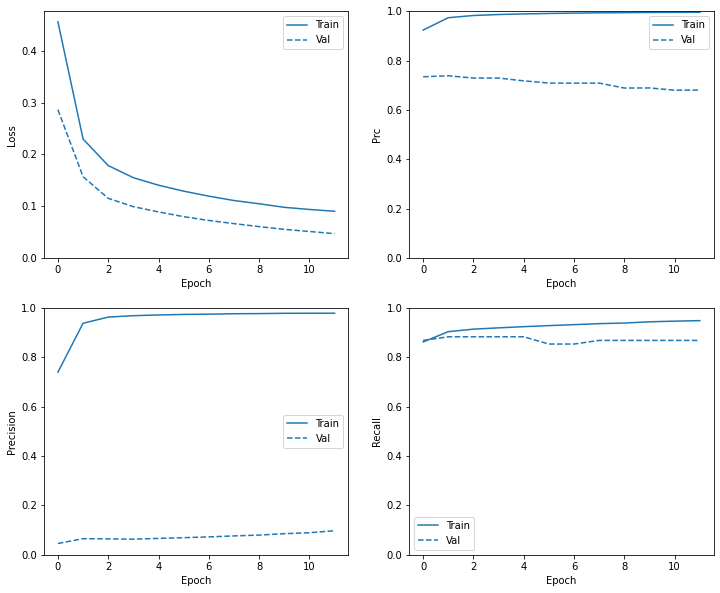

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000


 1/20 [>.............................] - ETA: 31s - loss: 1.1536 - tp: 623.0000 - fp: 1115.0000 - tn: 45415.0000 - fn: 464.0000 - accuracy: 0.9668 - precision: 0.3585 - recall: 0.5731 - auc: 0.9260 - prc: 0.5099

 5/20 [======>.......................] - ETA: 0s - loss: 1.1263 - tp: 1805.4000 - fp: 2298.8000 - tn: 46283.2000 - fn: 1325.6000 - accuracy: 0.9313 - precision: 0.4258 - recall: 0.5757 - auc: 0.9139 - prc: 0.5732

 8/20 [===========>..................] - ETA: 0s - loss: 1.1103 - tp: 2712.3750 - fp: 3179.2500 - tn: 46955.1250 - fn: 1938.2500 - accuracy: 0.9095 - precision: 0.4444 - recall: 0.5801 - auc: 0.9055 - prc: 0.5952

11/20 [===============>..............] - ETA: 0s - loss: 1.0937 - tp: 3653.0909 - fp: 4047.3636 - tn: 47630.0909 - fn: 2526.4545 - accuracy: 0.8911 - precision: 0.4573 - recall: 0.5857 - auc: 0.8985 - prc: 0.6123

14/20 [====================>.........] - ETA: 0s - loss: 1.0767 - tp: 4637.2857 - fp: 4914.6429 - tn: 48295.7857 - fn: 3081.2857 - accuracy: 0.8752 - precision: 0.4674 - recall: 0.5923 - auc: 0.8926 - prc: 0.6267

18/20 [==========================>...] - ETA: 0s - loss: 1.0550 - tp: 6004.0556 - fp: 6062.0000 - tn: 49187.1111 - fn: 3771.8333 - accuracy: 0.8575 - precision: 0.4784 - recall: 0.6018 - auc: 0.8861 - prc: 0.6432

20/20 [==============================] - 3s 66ms/step - loss: 1.0402 - tp: 7020.5714 - fp: 6901.5238 - tn: 49838.6667 - fn: 4238.7143 - accuracy: 0.8462 - precision: 0.4849 - recall: 0.6088 - auc: 0.8819 - prc: 0.6535 - val_loss: 0.8771 - val_tp: 59.0000 - val_fp: 26353.0000 - val_tn: 19148.0000 - val_fn: 9.0000 - val_accuracy: 0.4215 - val_precision: 0.0022 - val_recall: 0.8676 - val_auc: 0.8402 - val_prc: 0.3888


Epoch 2/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.7342 - tp: 764.0000 - fp: 575.0000 - tn: 460.0000 - fn: 249.0000 - accuracy: 0.5977 - precision: 0.5706 - recall: 0.7542 - auc: 0.7323 - prc: 0.8110

 5/20 [======>.......................] - ETA: 0s - loss: 0.7472 - tp: 2316.2000 - fp: 1692.6000 - tn: 1386.0000 - fn: 749.2000 - accuracy: 0.6010 - precision: 0.5765 - recall: 0.7544 - auc: 0.7305 - prc: 0.8096

 8/20 [===========>..................] - ETA: 0s - loss: 0.7450 - tp: 3490.7500 - fp: 2535.3750 - tn: 2098.2500 - fn: 1091.6250 - accuracy: 0.6041 - precision: 0.5780 - recall: 0.7588 - auc: 0.7344 - prc: 0.8117

11/20 [===============>..............] - ETA: 0s - loss: 0.7414 - tp: 4674.0909 - fp: 3378.3636 - tn: 2813.5455 - fn: 1422.0000 - accuracy: 0.6064 - precision: 0.5790 - recall: 0.7625 - auc: 0.7381 - prc: 0.8140

14/20 [====================>.........] - ETA: 0s - loss: 0.7368 - tp: 5880.5000 - fp: 4210.5714 - tn: 3531.8571 - fn: 1737.0714 - accuracy: 0.6090 - precision: 0.5806 - recall: 0.7664 - auc: 0.7420 - prc: 0.8168

17/20 [========================>.....] - ETA: 0s - loss: 0.7324 - tp: 7094.4706 - fp: 5040.5882 - tn: 4253.8235 - fn: 2043.1176 - accuracy: 0.6113 - precision: 0.5820 - recall: 0.7699 - auc: 0.7455 - prc: 0.8193

20/20 [==============================] - ETA: 0s - loss: 0.7280 - tp: 8325.5500 - fp: 5864.9000 - tn: 4977.1500 - fn: 2336.4000 - accuracy: 0.6136 - precision: 0.5836 - recall: 0.7733 - auc: 0.7490 - prc: 0.8219

20/20 [==============================] - 1s 38ms/step - loss: 0.7266 - tp: 8698.4762 - fp: 6112.2857 - tn: 5196.3333 - fn: 2423.3810 - accuracy: 0.6143 - precision: 0.5840 - recall: 0.7744 - auc: 0.7501 - prc: 0.8227 - val_loss: 0.8015 - val_tp: 61.0000 - val_fp: 24135.0000 - val_tn: 21366.0000 - val_fn: 7.0000 - val_accuracy: 0.4702 - val_precision: 0.0025 - val_recall: 0.8971 - val_auc: 0.8835 - val_prc: 0.5738


Epoch 3/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.6329 - tp: 848.0000 - fp: 534.0000 - tn: 493.0000 - fn: 173.0000 - accuracy: 0.6548 - precision: 0.6136 - recall: 0.8306 - auc: 0.8189 - prc: 0.8738

 5/20 [======>.......................] - ETA: 0s - loss: 0.6266 - tp: 2555.2000 - fp: 1561.8000 - tn: 1511.2000 - fn: 515.8000 - accuracy: 0.6598 - precision: 0.6192 - recall: 0.8307 - auc: 0.8188 - prc: 0.8743

 8/20 [===========>..................] - ETA: 0s - loss: 0.6211 - tp: 3855.7500 - fp: 2333.8750 - tn: 2280.1250 - fn: 746.2500 - accuracy: 0.6630 - precision: 0.6211 - recall: 0.8348 - auc: 0.8222 - prc: 0.8767

11/20 [===============>..............] - ETA: 0s - loss: 0.6175 - tp: 5164.2727 - fp: 3090.8182 - tn: 3061.7273 - fn: 971.1818 - accuracy: 0.6659 - precision: 0.6232 - recall: 0.8380 - auc: 0.8249 - prc: 0.8786

14/20 [====================>.........] - ETA: 0s - loss: 0.6142 - tp: 6477.5714 - fp: 3851.7857 - tn: 3838.3571 - fn: 1192.2857 - accuracy: 0.6679 - precision: 0.6246 - recall: 0.8404 - auc: 0.8271 - prc: 0.8801

17/20 [========================>.....] - ETA: 0s - loss: 0.6114 - tp: 7791.7059 - fp: 4609.7647 - tn: 4617.0588 - fn: 1413.4706 - accuracy: 0.6695 - precision: 0.6257 - recall: 0.8422 - auc: 0.8288 - prc: 0.8814

20/20 [==============================] - ETA: 0s - loss: 0.6088 - tp: 9105.0000 - fp: 5365.5000 - tn: 5399.9000 - fn: 1633.6000 - accuracy: 0.6708 - precision: 0.6266 - recall: 0.8436 - auc: 0.8303 - prc: 0.8825

20/20 [==============================] - 1s 28ms/step - loss: 0.6080 - tp: 9502.2381 - fp: 5591.0952 - tn: 5637.0952 - fn: 1700.0476 - accuracy: 0.6712 - precision: 0.6269 - recall: 0.8440 - auc: 0.8308 - prc: 0.8828 - val_loss: 0.7140 - val_tp: 61.0000 - val_fp: 20539.0000 - val_tn: 24962.0000 - val_fn: 7.0000 - val_accuracy: 0.5491 - val_precision: 0.0030 - val_recall: 0.8971 - val_auc: 0.9053 - val_prc: 0.6240


Epoch 4/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5604 - tp: 873.0000 - fp: 491.0000 - tn: 548.0000 - fn: 136.0000 - accuracy: 0.6938 - precision: 0.6400 - recall: 0.8652 - auc: 0.8578 - prc: 0.9029

 5/20 [======>.......................] - ETA: 0s - loss: 0.5490 - tp: 2674.0000 - fp: 1419.0000 - tn: 1630.6000 - fn: 420.4000 - accuracy: 0.6995 - precision: 0.6514 - recall: 0.8642 - auc: 0.8578 - prc: 0.9042

 8/20 [===========>..................] - ETA: 0s - loss: 0.5476 - tp: 4002.1250 - fp: 2122.6250 - tn: 2463.0000 - fn: 628.2500 - accuracy: 0.7004 - precision: 0.6521 - recall: 0.8643 - auc: 0.8585 - prc: 0.9045

11/20 [===============>..............] - ETA: 0s - loss: 0.5458 - tp: 5338.1818 - fp: 2814.9091 - tn: 3302.2727 - fn: 832.6364 - accuracy: 0.7017 - precision: 0.6533 - recall: 0.8648 - auc: 0.8595 - prc: 0.9052

14/20 [====================>.........] - ETA: 0s - loss: 0.5439 - tp: 6682.7857 - fp: 3504.5714 - tn: 4137.5714 - fn: 1035.0714 - accuracy: 0.7028 - precision: 0.6543 - recall: 0.8653 - auc: 0.8604 - prc: 0.9057

17/20 [========================>.....] - ETA: 0s - loss: 0.5415 - tp: 8039.7059 - fp: 4174.1176 - tn: 4984.0000 - fn: 1234.1765 - accuracy: 0.7043 - precision: 0.6559 - recall: 0.8660 - auc: 0.8615 - prc: 0.9066

20/20 [==============================] - ETA: 0s - loss: 0.5391 - tp: 9393.1500 - fp: 4838.6000 - tn: 5840.4500 - fn: 1431.8000 - accuracy: 0.7056 - precision: 0.6572 - recall: 0.8666 - auc: 0.8626 - prc: 0.9073

20/20 [==============================] - 1s 28ms/step - loss: 0.5383 - tp: 9802.5238 - fp: 5037.4286 - tn: 6099.2857 - fn: 1491.2381 - accuracy: 0.7060 - precision: 0.6576 - recall: 0.8667 - auc: 0.8629 - prc: 0.9076 - val_loss: 0.6353 - val_tp: 63.0000 - val_fp: 16267.0000 - val_tn: 29234.0000 - val_fn: 5.0000 - val_accuracy: 0.6429 - val_precision: 0.0039 - val_recall: 0.9265 - val_auc: 0.9249 - val_prc: 0.6533


Epoch 5/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5035 - tp: 873.0000 - fp: 425.0000 - tn: 628.0000 - fn: 122.0000 - accuracy: 0.7329 - precision: 0.6726 - recall: 0.8774 - auc: 0.8829 - prc: 0.9180

 5/20 [======>.......................] - ETA: 0s - loss: 0.4908 - tp: 2722.8000 - fp: 1225.0000 - tn: 1817.6000 - fn: 378.6000 - accuracy: 0.7388 - precision: 0.6878 - recall: 0.8779 - auc: 0.8843 - prc: 0.9224

 8/20 [===========>..................] - ETA: 0s - loss: 0.4886 - tp: 4080.6250 - fp: 1837.8750 - tn: 2726.8750 - fn: 570.6250 - accuracy: 0.7386 - precision: 0.6883 - recall: 0.8776 - auc: 0.8844 - prc: 0.9229

11/20 [===============>..............] - ETA: 0s - loss: 0.4871 - tp: 5426.8182 - fp: 2448.6364 - tn: 3652.9091 - fn: 759.6364 - accuracy: 0.7388 - precision: 0.6884 - recall: 0.8774 - auc: 0.8849 - prc: 0.9233

14/20 [====================>.........] - ETA: 0s - loss: 0.4859 - tp: 6773.0714 - fp: 3054.5714 - tn: 4588.0714 - fn: 944.2857 - accuracy: 0.7392 - precision: 0.6886 - recall: 0.8776 - auc: 0.8854 - prc: 0.9236

17/20 [========================>.....] - ETA: 0s - loss: 0.4845 - tp: 8113.8824 - fp: 3655.0000 - tn: 5537.8824 - fn: 1125.2353 - accuracy: 0.7399 - precision: 0.6888 - recall: 0.8779 - auc: 0.8860 - prc: 0.9239

20/20 [==============================] - ETA: 0s - loss: 0.4832 - tp: 9458.1500 - fp: 4241.3500 - tn: 6499.4000 - fn: 1305.1000 - accuracy: 0.7407 - precision: 0.6894 - recall: 0.8783 - auc: 0.8866 - prc: 0.9242

20/20 [==============================] - 1s 28ms/step - loss: 0.4828 - tp: 9863.6667 - fp: 4417.0000 - tn: 6790.9048 - fn: 1358.9048 - accuracy: 0.7410 - precision: 0.6897 - recall: 0.8784 - auc: 0.8868 - prc: 0.9243 - val_loss: 0.5696 - val_tp: 63.0000 - val_fp: 12252.0000 - val_tn: 33249.0000 - val_fn: 5.0000 - val_accuracy: 0.7310 - val_precision: 0.0051 - val_recall: 0.9265 - val_auc: 0.9352 - val_prc: 0.6709


Epoch 6/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4445 - tp: 913.0000 - fp: 361.0000 - tn: 657.0000 - fn: 117.0000 - accuracy: 0.7666 - precision: 0.7166 - recall: 0.8864 - auc: 0.9014 - prc: 0.9343

 5/20 [======>.......................] - ETA: 0s - loss: 0.4514 - tp: 2678.6000 - fp: 1126.2000 - tn: 1985.4000 - fn: 353.8000 - accuracy: 0.7604 - precision: 0.7059 - recall: 0.8842 - auc: 0.8991 - prc: 0.9314

 8/20 [===========>..................] - ETA: 0s - loss: 0.4519 - tp: 4020.1250 - fp: 1689.7500 - tn: 2971.2500 - fn: 534.8750 - accuracy: 0.7595 - precision: 0.7052 - recall: 0.8833 - auc: 0.8986 - prc: 0.9309

11/20 [===============>..............] - ETA: 0s - loss: 0.4500 - tp: 5369.5455 - fp: 2216.0909 - tn: 3985.1818 - fn: 717.1818 - accuracy: 0.7609 - precision: 0.7071 - recall: 0.8829 - auc: 0.8989 - prc: 0.9312

14/20 [====================>.........] - ETA: 0s - loss: 0.4484 - tp: 6717.3571 - fp: 2730.4286 - tn: 5011.7857 - fn: 900.4286 - accuracy: 0.7623 - precision: 0.7091 - recall: 0.8825 - auc: 0.8991 - prc: 0.9315

17/20 [========================>.....] - ETA: 0s - loss: 0.4466 - tp: 8061.1176 - fp: 3238.8235 - tn: 6051.6471 - fn: 1080.4118 - accuracy: 0.7637 - precision: 0.7108 - recall: 0.8824 - auc: 0.8995 - prc: 0.9318

20/20 [==============================] - ETA: 0s - loss: 0.4451 - tp: 9406.3000 - fp: 3737.0500 - tn: 7101.4000 - fn: 1259.2500 - accuracy: 0.7651 - precision: 0.7124 - recall: 0.8824 - auc: 0.8998 - prc: 0.9321

20/20 [==============================] - 1s 28ms/step - loss: 0.4447 - tp: 9811.3333 - fp: 3886.4762 - tn: 7419.8095 - fn: 1312.8571 - accuracy: 0.7655 - precision: 0.7129 - recall: 0.8824 - auc: 0.9000 - prc: 0.9322 - val_loss: 0.5133 - val_tp: 62.0000 - val_fp: 8676.0000 - val_tn: 36825.0000 - val_fn: 6.0000 - val_accuracy: 0.8095 - val_precision: 0.0071 - val_recall: 0.9118 - val_auc: 0.9379 - val_prc: 0.6861


Epoch 7/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4168 - tp: 917.0000 - fp: 303.0000 - tn: 697.0000 - fn: 131.0000 - accuracy: 0.7881 - precision: 0.7516 - recall: 0.8750 - auc: 0.9006 - prc: 0.9369

 5/20 [======>.......................] - ETA: 0s - loss: 0.4162 - tp: 2712.0000 - fp: 927.0000 - tn: 2134.8000 - fn: 370.2000 - accuracy: 0.7882 - precision: 0.7458 - recall: 0.8787 - auc: 0.9046 - prc: 0.9374

 8/20 [===========>..................] - ETA: 0s - loss: 0.4152 - tp: 4074.0000 - fp: 1384.5000 - tn: 3211.5000 - fn: 546.0000 - accuracy: 0.7895 - precision: 0.7463 - recall: 0.8804 - auc: 0.9058 - prc: 0.9378

11/20 [===============>..............] - ETA: 0s - loss: 0.4144 - tp: 5429.6364 - fp: 1837.8182 - tn: 4300.0909 - fn: 720.4545 - accuracy: 0.7905 - precision: 0.7468 - recall: 0.8814 - auc: 0.9066 - prc: 0.9382

14/20 [====================>.........] - ETA: 0s - loss: 0.4134 - tp: 6793.0000 - fp: 2289.5000 - tn: 5388.5714 - fn: 888.9286 - accuracy: 0.7915 - precision: 0.7473 - recall: 0.8825 - auc: 0.9074 - prc: 0.9386

17/20 [========================>.....] - ETA: 0s - loss: 0.4125 - tp: 8160.6471 - fp: 2732.7059 - tn: 6477.2353 - fn: 1061.4118 - accuracy: 0.7924 - precision: 0.7481 - recall: 0.8832 - auc: 0.9080 - prc: 0.9390

20/20 [==============================] - ETA: 0s - loss: 0.4115 - tp: 9526.5500 - fp: 3165.3500 - tn: 7576.6000 - fn: 1235.5000 - accuracy: 0.7933 - precision: 0.7491 - recall: 0.8836 - auc: 0.9085 - prc: 0.9393

20/20 [==============================] - 1s 27ms/step - loss: 0.4112 - tp: 9938.3333 - fp: 3295.3333 - tn: 7908.6667 - fn: 1288.1429 - accuracy: 0.7936 - precision: 0.7494 - recall: 0.8837 - auc: 0.9086 - prc: 0.9394 - val_loss: 0.4664 - val_tp: 61.0000 - val_fp: 5933.0000 - val_tn: 39568.0000 - val_fn: 7.0000 - val_accuracy: 0.8696 - val_precision: 0.0102 - val_recall: 0.8971 - val_auc: 0.9388 - val_prc: 0.6988


Epoch 8/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3731 - tp: 918.0000 - fp: 268.0000 - tn: 762.0000 - fn: 100.0000 - accuracy: 0.8203 - precision: 0.7740 - recall: 0.9018 - auc: 0.9239 - prc: 0.9495

 4/20 [=====>........................] - ETA: 0s - loss: 0.3803 - tp: 2264.5000 - fp: 659.2500 - tn: 1923.2500 - fn: 273.0000 - accuracy: 0.8188 - precision: 0.7748 - recall: 0.8946 - auc: 0.9198 - prc: 0.9466

 7/20 [=========>....................] - ETA: 0s - loss: 0.3822 - tp: 3619.8571 - fp: 1054.8571 - tn: 3076.4286 - fn: 440.8571 - accuracy: 0.8180 - precision: 0.7745 - recall: 0.8930 - auc: 0.9190 - prc: 0.9460

10/20 [==============>...............] - ETA: 0s - loss: 0.3817 - tp: 4993.0000 - fp: 1436.6000 - tn: 4222.2000 - fn: 612.2000 - accuracy: 0.8183 - precision: 0.7758 - recall: 0.8921 - auc: 0.9191 - prc: 0.9461

13/20 [==================>...........] - ETA: 0s - loss: 0.3809 - tp: 6363.7692 - fp: 1810.7692 - tn: 5380.1538 - fn: 781.3077 - accuracy: 0.8189 - precision: 0.7771 - recall: 0.8917 - auc: 0.9193 - prc: 0.9463

16/20 [=======================>......] - ETA: 0s - loss: 0.3803 - tp: 7728.1250 - fp: 2184.5000 - tn: 6546.1875 - fn: 949.1875 - accuracy: 0.8194 - precision: 0.7780 - recall: 0.8915 - auc: 0.9195 - prc: 0.9464

19/20 [===========================>..] - ETA: 0s - loss: 0.3795 - tp: 9092.3158 - fp: 2550.0000 - tn: 7720.5789 - fn: 1117.1053 - accuracy: 0.8200 - precision: 0.7790 - recall: 0.8914 - auc: 0.9197 - prc: 0.9465

20/20 [==============================] - 1s 29ms/step - loss: 0.3792 - tp: 9959.7143 - fp: 2782.7619 - tn: 8464.3333 - fn: 1223.6667 - accuracy: 0.8203 - precision: 0.7795 - recall: 0.8913 - auc: 0.9198 - prc: 0.9466 - val_loss: 0.4276 - val_tp: 61.0000 - val_fp: 4043.0000 - val_tn: 41458.0000 - val_fn: 7.0000 - val_accuracy: 0.9111 - val_precision: 0.0149 - val_recall: 0.8971 - val_auc: 0.9401 - val_prc: 0.7077


Epoch 9/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3760 - tp: 876.0000 - fp: 249.0000 - tn: 811.0000 - fn: 112.0000 - accuracy: 0.8237 - precision: 0.7787 - recall: 0.8866 - auc: 0.9195 - prc: 0.9446

 5/20 [======>.......................] - ETA: 0s - loss: 0.3643 - tp: 2712.4000 - fp: 689.4000 - tn: 2404.2000 - fn: 338.0000 - accuracy: 0.8311 - precision: 0.7943 - recall: 0.8884 - auc: 0.9229 - prc: 0.9482

 8/20 [===========>..................] - ETA: 0s - loss: 0.3623 - tp: 4090.7500 - fp: 1028.7500 - tn: 3595.8750 - fn: 500.6250 - accuracy: 0.8325 - precision: 0.7965 - recall: 0.8898 - auc: 0.9241 - prc: 0.9492

11/20 [===============>..............] - ETA: 0s - loss: 0.3614 - tp: 5469.0000 - fp: 1367.4545 - tn: 4783.2727 - fn: 668.2727 - accuracy: 0.8331 - precision: 0.7977 - recall: 0.8902 - auc: 0.9244 - prc: 0.9496

14/20 [====================>.........] - ETA: 0s - loss: 0.3605 - tp: 6830.5714 - fp: 1703.4286 - tn: 5995.0000 - fn: 831.0000 - accuracy: 0.8338 - precision: 0.7985 - recall: 0.8906 - auc: 0.9249 - prc: 0.9499

17/20 [========================>.....] - ETA: 0s - loss: 0.3597 - tp: 8189.8824 - fp: 2036.7059 - tn: 7209.9412 - fn: 995.4706 - accuracy: 0.8343 - precision: 0.7991 - recall: 0.8908 - auc: 0.9252 - prc: 0.9501

20/20 [==============================] - ETA: 0s - loss: 0.3590 - tp: 9547.7000 - fp: 2365.7500 - tn: 8429.4000 - fn: 1161.1500 - accuracy: 0.8347 - precision: 0.7996 - recall: 0.8909 - auc: 0.9254 - prc: 0.9503

20/20 [==============================] - 1s 28ms/step - loss: 0.3588 - tp: 9959.0000 - fp: 2463.6190 - tn: 8797.1429 - fn: 1210.7143 - accuracy: 0.8349 - precision: 0.7999 - recall: 0.8910 - auc: 0.9254 - prc: 0.9503 - val_loss: 0.3944 - val_tp: 60.0000 - val_fp: 2932.0000 - val_tn: 42569.0000 - val_fn: 8.0000 - val_accuracy: 0.9355 - val_precision: 0.0201 - val_recall: 0.8824 - val_auc: 0.9427 - val_prc: 0.7187


Epoch 10/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3369 - tp: 922.0000 - fp: 213.0000 - tn: 803.0000 - fn: 110.0000 - accuracy: 0.8423 - precision: 0.8123 - recall: 0.8934 - auc: 0.9317 - prc: 0.9552

 5/20 [======>.......................] - ETA: 0s - loss: 0.3426 - tp: 2734.0000 - fp: 629.2000 - tn: 2444.8000 - fn: 336.0000 - accuracy: 0.8423 - precision: 0.8124 - recall: 0.8907 - auc: 0.9301 - prc: 0.9535

 8/20 [===========>..................] - ETA: 0s - loss: 0.3414 - tp: 4112.7500 - fp: 927.0000 - tn: 3676.8750 - fn: 499.3750 - accuracy: 0.8440 - precision: 0.8145 - recall: 0.8914 - auc: 0.9309 - prc: 0.9538

11/20 [===============>..............] - ETA: 0s - loss: 0.3402 - tp: 5486.6364 - fp: 1209.4545 - tn: 4930.9091 - fn: 661.0000 - accuracy: 0.8458 - precision: 0.8169 - recall: 0.8919 - auc: 0.9315 - prc: 0.9541

14/20 [====================>.........] - ETA: 0s - loss: 0.3391 - tp: 6856.5714 - fp: 1488.5714 - tn: 6192.1429 - fn: 822.7143 - accuracy: 0.8473 - precision: 0.8187 - recall: 0.8923 - auc: 0.9318 - prc: 0.9543

17/20 [========================>.....] - ETA: 0s - loss: 0.3380 - tp: 8227.2353 - fp: 1770.4118 - tn: 7452.1765 - fn: 982.1765 - accuracy: 0.8483 - precision: 0.8200 - recall: 0.8926 - auc: 0.9322 - prc: 0.9546

20/20 [==============================] - ETA: 0s - loss: 0.3371 - tp: 9595.0000 - fp: 2049.6000 - tn: 8717.5000 - fn: 1141.9000 - accuracy: 0.8492 - precision: 0.8210 - recall: 0.8929 - auc: 0.9325 - prc: 0.9548

20/20 [==============================] - 1s 28ms/step - loss: 0.3368 - tp: 10007.8571 - fp: 2133.0476 - tn: 9099.9524 - fn: 1189.6190 - accuracy: 0.8494 - precision: 0.8213 - recall: 0.8930 - auc: 0.9327 - prc: 0.9548 - val_loss: 0.3658 - val_tp: 60.0000 - val_fp: 2290.0000 - val_tn: 43211.0000 - val_fn: 8.0000 - val_accuracy: 0.9496 - val_precision: 0.0255 - val_recall: 0.8824 - val_auc: 0.9464 - val_prc: 0.7227


Epoch 11/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3213 - tp: 943.0000 - fp: 173.0000 - tn: 831.0000 - fn: 101.0000 - accuracy: 0.8662 - precision: 0.8450 - recall: 0.9033 - auc: 0.9406 - prc: 0.9609

 5/20 [======>.......................] - ETA: 0s - loss: 0.3244 - tp: 2732.8000 - fp: 522.6000 - tn: 2574.6000 - fn: 314.0000 - accuracy: 0.8638 - precision: 0.8395 - recall: 0.8980 - auc: 0.9379 - prc: 0.9580

 8/20 [===========>..................] - ETA: 0s - loss: 0.3231 - tp: 4096.2500 - fp: 769.8750 - tn: 3875.5000 - fn: 474.3750 - accuracy: 0.8645 - precision: 0.8409 - recall: 0.8971 - auc: 0.9379 - prc: 0.9579

11/20 [===============>..............] - ETA: 0s - loss: 0.3220 - tp: 5471.6364 - fp: 1020.5455 - tn: 5165.1818 - fn: 630.6364 - accuracy: 0.8650 - precision: 0.8418 - recall: 0.8971 - auc: 0.9381 - prc: 0.9581

14/20 [====================>.........] - ETA: 0s - loss: 0.3213 - tp: 6848.7143 - fp: 1269.5714 - tn: 6450.0000 - fn: 791.7143 - accuracy: 0.8653 - precision: 0.8425 - recall: 0.8969 - auc: 0.9380 - prc: 0.9581

17/20 [========================>.....] - ETA: 0s - loss: 0.3209 - tp: 8223.4118 - fp: 1521.1176 - tn: 7732.4706 - fn: 955.0000 - accuracy: 0.8653 - precision: 0.8428 - recall: 0.8965 - auc: 0.9380 - prc: 0.9581

20/20 [==============================] - ETA: 0s - loss: 0.3204 - tp: 9598.6500 - fp: 1770.2000 - tn: 9016.9500 - fn: 1118.2000 - accuracy: 0.8653 - precision: 0.8432 - recall: 0.8963 - auc: 0.9380 - prc: 0.9581

20/20 [==============================] - 1s 28ms/step - loss: 0.3203 - tp: 10013.4762 - fp: 1845.1905 - tn: 9404.2381 - fn: 1167.5714 - accuracy: 0.8654 - precision: 0.8433 - recall: 0.8962 - auc: 0.9380 - prc: 0.9581 - val_loss: 0.3397 - val_tp: 60.0000 - val_fp: 1848.0000 - val_tn: 43653.0000 - val_fn: 8.0000 - val_accuracy: 0.9593 - val_precision: 0.0314 - val_recall: 0.8824 - val_auc: 0.9509 - val_prc: 0.7279


Epoch 12/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2996 - tp: 945.0000 - fp: 140.0000 - tn: 864.0000 - fn: 99.0000 - accuracy: 0.8833 - precision: 0.8710 - recall: 0.9052 - auc: 0.9459 - prc: 0.9643

 5/20 [======>.......................] - ETA: 0s - loss: 0.3044 - tp: 2811.2000 - fp: 422.6000 - tn: 2588.2000 - fn: 322.0000 - accuracy: 0.8795 - precision: 0.8696 - recall: 0.8986 - auc: 0.9415 - prc: 0.9618

 8/20 [===========>..................] - ETA: 0s - loss: 0.3046 - tp: 4182.2500 - fp: 631.1250 - tn: 3916.8750 - fn: 485.7500 - accuracy: 0.8793 - precision: 0.8693 - recall: 0.8972 - auc: 0.9410 - prc: 0.9613

11/20 [===============>..............] - ETA: 0s - loss: 0.3048 - tp: 5537.5455 - fp: 849.4545 - tn: 5257.1818 - fn: 643.8182 - accuracy: 0.8790 - precision: 0.8680 - recall: 0.8968 - auc: 0.9409 - prc: 0.9609

14/20 [====================>.........] - ETA: 0s - loss: 0.3049 - tp: 6895.1429 - fp: 1064.1429 - tn: 6597.1429 - fn: 803.5714 - accuracy: 0.8788 - precision: 0.8674 - recall: 0.8965 - auc: 0.9409 - prc: 0.9607

17/20 [========================>.....] - ETA: 0s - loss: 0.3048 - tp: 8261.2353 - fp: 1275.5882 - tn: 7929.0588 - fn: 966.1176 - accuracy: 0.8787 - precision: 0.8672 - recall: 0.8962 - auc: 0.9409 - prc: 0.9606

20/20 [==============================] - ETA: 0s - loss: 0.3046 - tp: 9631.9500 - fp: 1484.0000 - tn: 9258.3000 - fn: 1129.7500 - accuracy: 0.8787 - precision: 0.8672 - recall: 0.8959 - auc: 0.9409 - prc: 0.9605

20/20 [==============================] - 1s 28ms/step - loss: 0.3045 - tp: 10044.2381 - fp: 1546.7143 - tn: 9660.4286 - fn: 1179.0952 - accuracy: 0.8787 - precision: 0.8672 - recall: 0.8958 - auc: 0.9409 - prc: 0.9605 - val_loss: 0.3167 - val_tp: 60.0000 - val_fp: 1533.0000 - val_tn: 43968.0000 - val_fn: 8.0000 - val_accuracy: 0.9662 - val_precision: 0.0377 - val_recall: 0.8824 - val_auc: 0.9557 - val_prc: 0.7327


Epoch 13/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2865 - tp: 966.0000 - fp: 122.0000 - tn: 855.0000 - fn: 105.0000 - accuracy: 0.8892 - precision: 0.8879 - recall: 0.9020 - auc: 0.9466 - prc: 0.9661

 5/20 [======>.......................] - ETA: 0s - loss: 0.2882 - tp: 2816.0000 - fp: 377.6000 - tn: 2635.0000 - fn: 315.4000 - accuracy: 0.8875 - precision: 0.8828 - recall: 0.8995 - auc: 0.9469 - prc: 0.9647

 8/20 [===========>..................] - ETA: 0s - loss: 0.2886 - tp: 4199.5000 - fp: 570.8750 - tn: 3967.1250 - fn: 478.5000 - accuracy: 0.8867 - precision: 0.8814 - recall: 0.8984 - auc: 0.9467 - prc: 0.9643

11/20 [===============>..............] - ETA: 0s - loss: 0.2885 - tp: 5593.4545 - fp: 762.8182 - tn: 5290.3636 - fn: 641.3636 - accuracy: 0.8863 - precision: 0.8809 - recall: 0.8979 - auc: 0.9466 - prc: 0.9642

14/20 [====================>.........] - ETA: 0s - loss: 0.2887 - tp: 6979.9286 - fp: 958.1429 - tn: 6618.8571 - fn: 803.0714 - accuracy: 0.8859 - precision: 0.8803 - recall: 0.8975 - auc: 0.9464 - prc: 0.9640

17/20 [========================>.....] - ETA: 0s - loss: 0.2887 - tp: 8366.2941 - fp: 1142.5882 - tn: 7960.5294 - fn: 962.5882 - accuracy: 0.8861 - precision: 0.8805 - recall: 0.8974 - auc: 0.9464 - prc: 0.9639

20/20 [==============================] - ETA: 0s - loss: 0.2887 - tp: 9744.0500 - fp: 1321.5500 - tn: 9317.9500 - fn: 1120.4500 - accuracy: 0.8864 - precision: 0.8808 - recall: 0.8974 - auc: 0.9464 - prc: 0.9639

20/20 [==============================] - 1s 27ms/step - loss: 0.2887 - tp: 10159.0952 - fp: 1375.8095 - tn: 9727.7143 - fn: 1167.8571 - accuracy: 0.8865 - precision: 0.8808 - recall: 0.8973 - auc: 0.9464 - prc: 0.9639 - val_loss: 0.2971 - val_tp: 60.0000 - val_fp: 1288.0000 - val_tn: 44213.0000 - val_fn: 8.0000 - val_accuracy: 0.9716 - val_precision: 0.0445 - val_recall: 0.8824 - val_auc: 0.9592 - val_prc: 0.7340


Epoch 14/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2975 - tp: 928.0000 - fp: 131.0000 - tn: 872.0000 - fn: 117.0000 - accuracy: 0.8789 - precision: 0.8763 - recall: 0.8880 - auc: 0.9409 - prc: 0.9610

 5/20 [======>.......................] - ETA: 0s - loss: 0.2955 - tp: 2734.8000 - fp: 380.8000 - tn: 2693.2000 - fn: 335.2000 - accuracy: 0.8825 - precision: 0.8773 - recall: 0.8902 - auc: 0.9430 - prc: 0.9612

 8/20 [===========>..................] - ETA: 0s - loss: 0.2927 - tp: 4091.6250 - fp: 555.3750 - tn: 4073.5000 - fn: 495.5000 - accuracy: 0.8845 - precision: 0.8792 - recall: 0.8912 - auc: 0.9441 - prc: 0.9617

11/20 [===============>..............] - ETA: 0s - loss: 0.2906 - tp: 5464.7273 - fp: 725.2727 - tn: 5436.8182 - fn: 661.1818 - accuracy: 0.8856 - precision: 0.8809 - recall: 0.8915 - auc: 0.9447 - prc: 0.9622

14/20 [====================>.........] - ETA: 0s - loss: 0.2892 - tp: 6834.5714 - fp: 893.4286 - tn: 6807.9286 - fn: 824.0714 - accuracy: 0.8865 - precision: 0.8822 - recall: 0.8918 - auc: 0.9452 - prc: 0.9624

17/20 [========================>.....] - ETA: 0s - loss: 0.2879 - tp: 8208.1765 - fp: 1057.1176 - tn: 8181.9412 - fn: 984.7647 - accuracy: 0.8874 - precision: 0.8835 - recall: 0.8922 - auc: 0.9456 - prc: 0.9627

20/20 [==============================] - ETA: 0s - loss: 0.2870 - tp: 9578.1500 - fp: 1218.0500 - tn: 9561.5000 - fn: 1146.3000 - accuracy: 0.8881 - precision: 0.8845 - recall: 0.8924 - auc: 0.9459 - prc: 0.9629

20/20 [==============================] - 1s 28ms/step - loss: 0.2867 - tp: 9990.0952 - fp: 1266.4762 - tn: 9978.4286 - fn: 1195.4762 - accuracy: 0.8883 - precision: 0.8848 - recall: 0.8925 - auc: 0.9460 - prc: 0.9629 - val_loss: 0.2798 - val_tp: 59.0000 - val_fp: 1140.0000 - val_tn: 44361.0000 - val_fn: 9.0000 - val_accuracy: 0.9748 - val_precision: 0.0492 - val_recall: 0.8676 - val_auc: 0.9632 - val_prc: 0.7367


Epoch 15/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2722 - tp: 932.0000 - fp: 98.0000 - tn: 921.0000 - fn: 97.0000 - accuracy: 0.9048 - precision: 0.9049 - recall: 0.9057 - auc: 0.9517 - prc: 0.9669

 4/20 [=====>........................] - ETA: 0s - loss: 0.2778 - tp: 2309.7500 - fp: 257.5000 - tn: 2295.7500 - fn: 257.0000 - accuracy: 0.9005 - precision: 0.9003 - recall: 0.9012 - auc: 0.9490 - prc: 0.9652

 7/20 [=========>....................] - ETA: 0s - loss: 0.2780 - tp: 3681.5714 - fp: 412.0000 - tn: 3681.2857 - fn: 417.1429 - accuracy: 0.8995 - precision: 0.8997 - recall: 0.8996 - auc: 0.9486 - prc: 0.9648

10/20 [==============>...............] - ETA: 0s - loss: 0.2767 - tp: 5058.2000 - fp: 556.0000 - tn: 5072.5000 - fn: 577.3000 - accuracy: 0.8997 - precision: 0.9006 - recall: 0.8988 - auc: 0.9490 - prc: 0.9650

13/20 [==================>...........] - ETA: 0s - loss: 0.2758 - tp: 6445.2308 - fp: 702.8462 - tn: 6449.5385 - fn: 738.3846 - accuracy: 0.8997 - precision: 0.9011 - recall: 0.8983 - auc: 0.9494 - prc: 0.9652

16/20 [=======================>......] - ETA: 0s - loss: 0.2750 - tp: 7831.7500 - fp: 849.0000 - tn: 7827.7500 - fn: 899.5000 - accuracy: 0.8997 - precision: 0.9015 - recall: 0.8980 - auc: 0.9496 - prc: 0.9654

19/20 [===========================>..] - ETA: 0s - loss: 0.2743 - tp: 9213.3158 - fp: 994.7895 - tn: 9211.1053 - fn: 1060.7895 - accuracy: 0.8997 - precision: 0.9018 - recall: 0.8977 - auc: 0.9498 - prc: 0.9655

20/20 [==============================] - 1s 28ms/step - loss: 0.2740 - tp: 10086.0476 - fp: 1087.5714 - tn: 10093.1905 - fn: 1163.6667 - accuracy: 0.8997 - precision: 0.9019 - recall: 0.8975 - auc: 0.9499 - prc: 0.9655 - val_loss: 0.2645 - val_tp: 59.0000 - val_fp: 1065.0000 - val_tn: 44436.0000 - val_fn: 9.0000 - val_accuracy: 0.9764 - val_precision: 0.0525 - val_recall: 0.8676 - val_auc: 0.9656 - val_prc: 0.7374


Epoch 16/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2702 - tp: 904.0000 - fp: 95.0000 - tn: 951.0000 - fn: 98.0000 - accuracy: 0.9058 - precision: 0.9049 - recall: 0.9022 - auc: 0.9503 - prc: 0.9657

 5/20 [======>.......................] - ETA: 0s - loss: 0.2637 - tp: 2730.4000 - fp: 274.6000 - tn: 2839.2000 - fn: 299.8000 - accuracy: 0.9062 - precision: 0.9074 - recall: 0.9013 - auc: 0.9536 - prc: 0.9676

 8/20 [===========>..................] - ETA: 0s - loss: 0.2624 - tp: 4087.3750 - fp: 401.5000 - tn: 4269.6250 - fn: 457.5000 - accuracy: 0.9065 - precision: 0.9091 - recall: 0.9001 - auc: 0.9540 - prc: 0.9677

11/20 [===============>..............] - ETA: 0s - loss: 0.2618 - tp: 5464.1818 - fp: 530.0000 - tn: 5681.2727 - fn: 612.5455 - accuracy: 0.9067 - precision: 0.9101 - recall: 0.8998 - auc: 0.9543 - prc: 0.9679

14/20 [====================>.........] - ETA: 0s - loss: 0.2618 - tp: 6842.7143 - fp: 660.5000 - tn: 7085.6429 - fn: 771.1429 - accuracy: 0.9067 - precision: 0.9107 - recall: 0.8994 - auc: 0.9543 - prc: 0.9679

17/20 [========================>.....] - ETA: 0s - loss: 0.2619 - tp: 8225.1176 - fp: 792.7647 - tn: 8485.1176 - fn: 929.0000 - accuracy: 0.9066 - precision: 0.9110 - recall: 0.8992 - auc: 0.9543 - prc: 0.9678

20/20 [==============================] - ETA: 0s - loss: 0.2619 - tp: 9611.8500 - fp: 922.7000 - tn: 9881.6000 - fn: 1087.8500 - accuracy: 0.9065 - precision: 0.9113 - recall: 0.8990 - auc: 0.9543 - prc: 0.9679

20/20 [==============================] - 1s 29ms/step - loss: 0.2618 - tp: 10030.3810 - fp: 961.4762 - tn: 10303.2857 - fn: 1135.3333 - accuracy: 0.9065 - precision: 0.9114 - recall: 0.8989 - auc: 0.9543 - prc: 0.9679 - val_loss: 0.2503 - val_tp: 59.0000 - val_fp: 1000.0000 - val_tn: 44501.0000 - val_fn: 9.0000 - val_accuracy: 0.9779 - val_precision: 0.0557 - val_recall: 0.8676 - val_auc: 0.9674 - val_prc: 0.7414


Epoch 17/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2541 - tp: 925.0000 - fp: 85.0000 - tn: 925.0000 - fn: 113.0000 - accuracy: 0.9033 - precision: 0.9158 - recall: 0.8911 - auc: 0.9550 - prc: 0.9685

 5/20 [======>.......................] - ETA: 0s - loss: 0.2595 - tp: 2762.4000 - fp: 242.2000 - tn: 2810.4000 - fn: 329.0000 - accuracy: 0.9063 - precision: 0.9189 - recall: 0.8930 - auc: 0.9536 - prc: 0.9677

 8/20 [===========>..................] - ETA: 0s - loss: 0.2597 - tp: 4146.3750 - fp: 367.1250 - tn: 4217.0000 - fn: 485.5000 - accuracy: 0.9069 - precision: 0.9186 - recall: 0.8943 - auc: 0.9536 - prc: 0.9677

11/20 [===============>..............] - ETA: 0s - loss: 0.2602 - tp: 5527.0000 - fp: 497.2727 - tn: 5619.7273 - fn: 644.0000 - accuracy: 0.9068 - precision: 0.9179 - recall: 0.8948 - auc: 0.9534 - prc: 0.9676

14/20 [====================>.........] - ETA: 0s - loss: 0.2603 - tp: 6909.6429 - fp: 624.4286 - tn: 7027.2143 - fn: 798.7143 - accuracy: 0.9070 - precision: 0.9176 - recall: 0.8954 - auc: 0.9534 - prc: 0.9676

17/20 [========================>.....] - ETA: 0s - loss: 0.2602 - tp: 8289.1765 - fp: 747.4706 - tn: 8439.1765 - fn: 956.1765 - accuracy: 0.9072 - precision: 0.9176 - recall: 0.8957 - auc: 0.9534 - prc: 0.9677

20/20 [==============================] - ETA: 0s - loss: 0.2599 - tp: 9669.0000 - fp: 872.1500 - tn: 9852.4000 - fn: 1110.4500 - accuracy: 0.9074 - precision: 0.9175 - recall: 0.8960 - auc: 0.9535 - prc: 0.9678

20/20 [==============================] - 1s 28ms/step - loss: 0.2599 - tp: 10083.9524 - fp: 909.8095 - tn: 10279.7619 - fn: 1156.9524 - accuracy: 0.9074 - precision: 0.9175 - recall: 0.8961 - auc: 0.9535 - prc: 0.9678 - val_loss: 0.2389 - val_tp: 60.0000 - val_fp: 987.0000 - val_tn: 44514.0000 - val_fn: 8.0000 - val_accuracy: 0.9782 - val_precision: 0.0573 - val_recall: 0.8824 - val_auc: 0.9688 - val_prc: 0.7439


Epoch 18/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2423 - tp: 925.0000 - fp: 72.0000 - tn: 959.0000 - fn: 92.0000 - accuracy: 0.9199 - precision: 0.9278 - recall: 0.9095 - auc: 0.9620 - prc: 0.9717

 5/20 [======>.......................] - ETA: 0s - loss: 0.2480 - tp: 2795.4000 - fp: 239.4000 - tn: 2813.8000 - fn: 295.4000 - accuracy: 0.9143 - precision: 0.9220 - recall: 0.9059 - auc: 0.9599 - prc: 0.9708

 8/20 [===========>..................] - ETA: 0s - loss: 0.2484 - tp: 4178.0000 - fp: 357.8750 - tn: 4223.5000 - fn: 456.6250 - accuracy: 0.9130 - precision: 0.9217 - recall: 0.9035 - auc: 0.9593 - prc: 0.9705

11/20 [===============>..............] - ETA: 0s - loss: 0.2491 - tp: 5544.4545 - fp: 474.1818 - tn: 5655.6364 - fn: 613.7273 - accuracy: 0.9125 - precision: 0.9216 - recall: 0.9023 - auc: 0.9588 - prc: 0.9702

14/20 [====================>.........] - ETA: 0s - loss: 0.2493 - tp: 6917.3571 - fp: 588.2857 - tn: 7087.7143 - fn: 766.6429 - accuracy: 0.9125 - precision: 0.9217 - recall: 0.9018 - auc: 0.9586 - prc: 0.9701

17/20 [========================>.....] - ETA: 0s - loss: 0.2495 - tp: 8293.6471 - fp: 702.6471 - tn: 8515.1765 - fn: 920.5294 - accuracy: 0.9124 - precision: 0.9219 - recall: 0.9014 - auc: 0.9584 - prc: 0.9700

20/20 [==============================] - ETA: 0s - loss: 0.2497 - tp: 9659.8500 - fp: 817.1000 - tn: 9952.8000 - fn: 1074.2500 - accuracy: 0.9124 - precision: 0.9220 - recall: 0.9011 - auc: 0.9582 - prc: 0.9699

20/20 [==============================] - 1s 28ms/step - loss: 0.2498 - tp: 10070.7619 - fp: 851.9524 - tn: 10387.0000 - fn: 1120.7619 - accuracy: 0.9124 - precision: 0.9219 - recall: 0.9011 - auc: 0.9582 - prc: 0.9699 - val_loss: 0.2282 - val_tp: 60.0000 - val_fp: 964.0000 - val_tn: 44537.0000 - val_fn: 8.0000 - val_accuracy: 0.9787 - val_precision: 0.0586 - val_recall: 0.8824 - val_auc: 0.9701 - val_prc: 0.7446


Epoch 19/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2502 - tp: 958.0000 - fp: 79.0000 - tn: 906.0000 - fn: 105.0000 - accuracy: 0.9102 - precision: 0.9238 - recall: 0.9012 - auc: 0.9568 - prc: 0.9713

 5/20 [======>.......................] - ETA: 0s - loss: 0.2439 - tp: 2815.6000 - fp: 213.4000 - tn: 2808.0000 - fn: 307.0000 - accuracy: 0.9146 - precision: 0.9288 - recall: 0.9019 - auc: 0.9586 - prc: 0.9718

 8/20 [===========>..................] - ETA: 0s - loss: 0.2437 - tp: 4192.7500 - fp: 318.0000 - tn: 4245.5000 - fn: 459.7500 - accuracy: 0.9150 - precision: 0.9290 - recall: 0.9015 - auc: 0.9588 - prc: 0.9716

11/20 [===============>..............] - ETA: 0s - loss: 0.2435 - tp: 5583.4545 - fp: 416.9091 - tn: 5674.3636 - fn: 613.2727 - accuracy: 0.9155 - precision: 0.9298 - recall: 0.9013 - auc: 0.9590 - prc: 0.9716

14/20 [====================>.........] - ETA: 0s - loss: 0.2432 - tp: 6982.7857 - fp: 514.1429 - tn: 7093.3571 - fn: 769.7143 - accuracy: 0.9158 - precision: 0.9304 - recall: 0.9011 - auc: 0.9591 - prc: 0.9716

17/20 [========================>.....] - ETA: 0s - loss: 0.2430 - tp: 8387.4706 - fp: 610.1765 - tn: 8510.0588 - fn: 924.2941 - accuracy: 0.9161 - precision: 0.9310 - recall: 0.9010 - auc: 0.9591 - prc: 0.9716

20/20 [==============================] - ETA: 0s - loss: 0.2428 - tp: 9788.6500 - fp: 709.5500 - tn: 9928.9000 - fn: 1076.9000 - accuracy: 0.9163 - precision: 0.9313 - recall: 0.9011 - auc: 0.9592 - prc: 0.9716

20/20 [==============================] - 1s 28ms/step - loss: 0.2428 - tp: 10210.7143 - fp: 739.7143 - tn: 10357.0952 - fn: 1122.9524 - accuracy: 0.9163 - precision: 0.9314 - recall: 0.9011 - auc: 0.9592 - prc: 0.9716 - val_loss: 0.2190 - val_tp: 60.0000 - val_fp: 966.0000 - val_tn: 44535.0000 - val_fn: 8.0000 - val_accuracy: 0.9786 - val_precision: 0.0585 - val_recall: 0.8824 - val_auc: 0.9705 - val_prc: 0.7449


Epoch 20/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2387 - tp: 948.0000 - fp: 64.0000 - tn: 936.0000 - fn: 100.0000 - accuracy: 0.9199 - precision: 0.9368 - recall: 0.9046 - auc: 0.9629 - prc: 0.9737

 5/20 [======>.......................] - ETA: 0s - loss: 0.2382 - tp: 2821.6000 - fp: 188.8000 - tn: 2824.2000 - fn: 309.4000 - accuracy: 0.9193 - precision: 0.9375 - recall: 0.9019 - auc: 0.9608 - prc: 0.9728

 8/20 [===========>..................] - ETA: 0s - loss: 0.2377 - tp: 4219.8750 - fp: 290.7500 - tn: 4250.8750 - fn: 454.5000 - accuracy: 0.9193 - precision: 0.9363 - recall: 0.9026 - auc: 0.9611 - prc: 0.9729

11/20 [===============>..............] - ETA: 0s - loss: 0.2379 - tp: 5615.4545 - fp: 395.0909 - tn: 5674.6364 - fn: 602.8182 - accuracy: 0.9190 - precision: 0.9354 - recall: 0.9028 - auc: 0.9610 - prc: 0.9728

14/20 [====================>.........] - ETA: 0s - loss: 0.2380 - tp: 7007.6429 - fp: 497.4286 - tn: 7104.4286 - fn: 750.5000 - accuracy: 0.9190 - precision: 0.9348 - recall: 0.9030 - auc: 0.9610 - prc: 0.9727

17/20 [========================>.....] - ETA: 0s - loss: 0.2379 - tp: 8402.3529 - fp: 596.1765 - tn: 8533.4118 - fn: 900.0588 - accuracy: 0.9190 - precision: 0.9346 - recall: 0.9030 - auc: 0.9610 - prc: 0.9727

20/20 [==============================] - ETA: 0s - loss: 0.2376 - tp: 9804.0000 - fp: 695.1000 - tn: 9956.9500 - fn: 1047.9500 - accuracy: 0.9190 - precision: 0.9345 - recall: 0.9032 - auc: 0.9611 - prc: 0.9727

20/20 [==============================] - 1s 28ms/step - loss: 0.2375 - tp: 10226.6190 - fp: 724.9048 - tn: 10386.2381 - fn: 1092.7143 - accuracy: 0.9190 - precision: 0.9345 - recall: 0.9032 - auc: 0.9611 - prc: 0.9727 - val_loss: 0.2099 - val_tp: 60.0000 - val_fp: 956.0000 - val_tn: 44545.0000 - val_fn: 8.0000 - val_accuracy: 0.9788 - val_precision: 0.0591 - val_recall: 0.8824 - val_auc: 0.9715 - val_prc: 0.7359


Epoch 21/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2334 - tp: 951.0000 - fp: 63.0000 - tn: 936.0000 - fn: 98.0000 - accuracy: 0.9214 - precision: 0.9379 - recall: 0.9066 - auc: 0.9623 - prc: 0.9745

 5/20 [======>.......................] - ETA: 0s - loss: 0.2303 - tp: 2834.6000 - fp: 186.0000 - tn: 2830.4000 - fn: 293.0000 - accuracy: 0.9218 - precision: 0.9384 - recall: 0.9062 - auc: 0.9633 - prc: 0.9747

 8/20 [===========>..................] - ETA: 0s - loss: 0.2292 - tp: 4215.6250 - fp: 274.8750 - tn: 4285.2500 - fn: 440.2500 - accuracy: 0.9222 - precision: 0.9387 - recall: 0.9057 - auc: 0.9638 - prc: 0.9747

11/20 [===============>..............] - ETA: 0s - loss: 0.2289 - tp: 5599.9091 - fp: 368.2727 - tn: 5732.6364 - fn: 587.1818 - accuracy: 0.9221 - precision: 0.9384 - recall: 0.9054 - auc: 0.9641 - prc: 0.9747

14/20 [====================>.........] - ETA: 0s - loss: 0.2286 - tp: 6983.0000 - fp: 460.0000 - tn: 7186.7857 - fn: 730.2143 - accuracy: 0.9223 - precision: 0.9383 - recall: 0.9055 - auc: 0.9642 - prc: 0.9746

17/20 [========================>.....] - ETA: 0s - loss: 0.2285 - tp: 8366.5882 - fp: 547.8824 - tn: 8640.5882 - fn: 876.9412 - accuracy: 0.9224 - precision: 0.9385 - recall: 0.9053 - auc: 0.9643 - prc: 0.9746

20/20 [==============================] - ETA: 0s - loss: 0.2283 - tp: 9748.9500 - fp: 635.2500 - tn: 10097.0000 - fn: 1022.8000 - accuracy: 0.9226 - precision: 0.9387 - recall: 0.9053 - auc: 0.9643 - prc: 0.9745

20/20 [==============================] - 1s 29ms/step - loss: 0.2282 - tp: 10165.0000 - fp: 661.7619 - tn: 10537.2381 - fn: 1066.4762 - accuracy: 0.9226 - precision: 0.9387 - recall: 0.9053 - auc: 0.9643 - prc: 0.9745 - val_loss: 0.2010 - val_tp: 60.0000 - val_fp: 933.0000 - val_tn: 44568.0000 - val_fn: 8.0000 - val_accuracy: 0.9793 - val_precision: 0.0604 - val_recall: 0.8824 - val_auc: 0.9720 - val_prc: 0.7365


Epoch 22/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2358 - tp: 971.0000 - fp: 67.0000 - tn: 908.0000 - fn: 102.0000 - accuracy: 0.9175 - precision: 0.9355 - recall: 0.9049 - auc: 0.9609 - prc: 0.9739

 5/20 [======>.......................] - ETA: 0s - loss: 0.2265 - tp: 2831.8000 - fp: 171.4000 - tn: 2849.6000 - fn: 291.2000 - accuracy: 0.9234 - precision: 0.9418 - recall: 0.9061 - auc: 0.9644 - prc: 0.9752

 8/20 [===========>..................] - ETA: 0s - loss: 0.2247 - tp: 4228.6250 - fp: 251.3750 - tn: 4302.3750 - fn: 433.6250 - accuracy: 0.9245 - precision: 0.9428 - recall: 0.9065 - auc: 0.9651 - prc: 0.9755

11/20 [===============>..............] - ETA: 0s - loss: 0.2239 - tp: 5631.7273 - fp: 333.6364 - tn: 5742.2727 - fn: 580.3636 - accuracy: 0.9248 - precision: 0.9432 - recall: 0.9064 - auc: 0.9654 - prc: 0.9756

14/20 [====================>.........] - ETA: 0s - loss: 0.2235 - tp: 7028.5714 - fp: 416.6429 - tn: 7188.2857 - fn: 726.5000 - accuracy: 0.9250 - precision: 0.9434 - recall: 0.9063 - auc: 0.9655 - prc: 0.9756

17/20 [========================>.....] - ETA: 0s - loss: 0.2231 - tp: 8429.4706 - fp: 500.0588 - tn: 8629.5882 - fn: 872.8824 - accuracy: 0.9250 - precision: 0.9435 - recall: 0.9062 - auc: 0.9656 - prc: 0.9756

20/20 [==============================] - ETA: 0s - loss: 0.2228 - tp: 9825.6000 - fp: 581.0500 - tn: 10079.2500 - fn: 1018.1000 - accuracy: 0.9252 - precision: 0.9436 - recall: 0.9062 - auc: 0.9657 - prc: 0.9756

20/20 [==============================] - 1s 28ms/step - loss: 0.2227 - tp: 10246.2381 - fp: 605.0000 - tn: 10517.3333 - fn: 1061.9048 - accuracy: 0.9252 - precision: 0.9437 - recall: 0.9061 - auc: 0.9657 - prc: 0.9757 - val_loss: 0.1930 - val_tp: 60.0000 - val_fp: 930.0000 - val_tn: 44571.0000 - val_fn: 8.0000 - val_accuracy: 0.9794 - val_precision: 0.0606 - val_recall: 0.8824 - val_auc: 0.9724 - val_prc: 0.7370


Epoch 23/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2109 - tp: 922.0000 - fp: 42.0000 - tn: 994.0000 - fn: 90.0000 - accuracy: 0.9355 - precision: 0.9564 - recall: 0.9111 - auc: 0.9688 - prc: 0.9774

 5/20 [======>.......................] - ETA: 0s - loss: 0.2181 - tp: 2782.4000 - fp: 159.0000 - tn: 2918.4000 - fn: 284.2000 - accuracy: 0.9289 - precision: 0.9476 - recall: 0.9075 - auc: 0.9664 - prc: 0.9756

 8/20 [===========>..................] - ETA: 0s - loss: 0.2179 - tp: 4195.7500 - fp: 240.1250 - tn: 4351.2500 - fn: 428.8750 - accuracy: 0.9282 - precision: 0.9470 - recall: 0.9074 - auc: 0.9668 - prc: 0.9759

11/20 [===============>..............] - ETA: 0s - loss: 0.2178 - tp: 5607.7273 - fp: 327.2727 - tn: 5778.7273 - fn: 574.2727 - accuracy: 0.9275 - precision: 0.9461 - recall: 0.9073 - auc: 0.9671 - prc: 0.9762

14/20 [====================>.........] - ETA: 0s - loss: 0.2180 - tp: 7002.5714 - fp: 415.0714 - tn: 7223.4286 - fn: 718.9286 - accuracy: 0.9271 - precision: 0.9453 - recall: 0.9071 - auc: 0.9672 - prc: 0.9762

17/20 [========================>.....] - ETA: 0s - loss: 0.2181 - tp: 8391.4706 - fp: 502.3529 - tn: 8676.0588 - fn: 862.1176 - accuracy: 0.9268 - precision: 0.9448 - recall: 0.9070 - auc: 0.9673 - prc: 0.9762

20/20 [==============================] - ETA: 0s - loss: 0.2182 - tp: 9780.0000 - fp: 586.8000 - tn: 10131.8500 - fn: 1005.3500 - accuracy: 0.9267 - precision: 0.9446 - recall: 0.9070 - auc: 0.9673 - prc: 0.9762

20/20 [==============================] - 1s 29ms/step - loss: 0.2182 - tp: 10200.3810 - fp: 612.1429 - tn: 10569.2381 - fn: 1048.7143 - accuracy: 0.9266 - precision: 0.9445 - recall: 0.9070 - auc: 0.9673 - prc: 0.9762 - val_loss: 0.1852 - val_tp: 60.0000 - val_fp: 923.0000 - val_tn: 44578.0000 - val_fn: 8.0000 - val_accuracy: 0.9796 - val_precision: 0.0610 - val_recall: 0.8824 - val_auc: 0.9727 - val_prc: 0.7375


Epoch 24/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2143 - tp: 924.0000 - fp: 50.0000 - tn: 980.0000 - fn: 94.0000 - accuracy: 0.9297 - precision: 0.9487 - recall: 0.9077 - auc: 0.9692 - prc: 0.9772

 4/20 [=====>........................] - ETA: 0s - loss: 0.2129 - tp: 2313.0000 - fp: 117.2500 - tn: 2455.5000 - fn: 234.2500 - accuracy: 0.9312 - precision: 0.9516 - recall: 0.9079 - auc: 0.9688 - prc: 0.9772

 7/20 [=========>....................] - ETA: 0s - loss: 0.2131 - tp: 3685.0000 - fp: 190.8571 - tn: 3943.0000 - fn: 373.1429 - accuracy: 0.9311 - precision: 0.9510 - recall: 0.9080 - auc: 0.9690 - prc: 0.9772

10/20 [==============>...............] - ETA: 0s - loss: 0.2135 - tp: 5066.4000 - fp: 265.4000 - tn: 5420.3000 - fn: 511.9000 - accuracy: 0.9310 - precision: 0.9506 - recall: 0.9081 - auc: 0.9691 - prc: 0.9772

13/20 [==================>...........] - ETA: 0s - loss: 0.2134 - tp: 6450.0769 - fp: 336.8462 - tn: 6898.4615 - fn: 650.6154 - accuracy: 0.9311 - precision: 0.9506 - recall: 0.9082 - auc: 0.9691 - prc: 0.9772

16/20 [=======================>......] - ETA: 0s - loss: 0.2131 - tp: 7844.0000 - fp: 407.3125 - tn: 8365.6875 - fn: 791.0000 - accuracy: 0.9311 - precision: 0.9507 - recall: 0.9083 - auc: 0.9692 - prc: 0.9772

19/20 [===========================>..] - ETA: 0s - loss: 0.2128 - tp: 9245.0526 - fp: 478.5789 - tn: 9825.2105 - fn: 931.1579 - accuracy: 0.9311 - precision: 0.9508 - recall: 0.9083 - auc: 0.9693 - prc: 0.9772

20/20 [==============================] - 1s 28ms/step - loss: 0.2127 - tp: 10135.4286 - fp: 524.9048 - tn: 10749.3810 - fn: 1020.7619 - accuracy: 0.9311 - precision: 0.9508 - recall: 0.9084 - auc: 0.9693 - prc: 0.9773 - val_loss: 0.1776 - val_tp: 60.0000 - val_fp: 900.0000 - val_tn: 44601.0000 - val_fn: 8.0000 - val_accuracy: 0.9801 - val_precision: 0.0625 - val_recall: 0.8824 - val_auc: 0.9729 - val_prc: 0.7371


Epoch 25/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2017 - tp: 970.0000 - fp: 44.0000 - tn: 941.0000 - fn: 93.0000 - accuracy: 0.9331 - precision: 0.9566 - recall: 0.9125 - auc: 0.9710 - prc: 0.9803

 4/20 [=====>........................] - ETA: 0s - loss: 0.2052 - tp: 2375.2500 - fp: 105.0000 - tn: 2406.0000 - fn: 233.7500 - accuracy: 0.9339 - precision: 0.9574 - recall: 0.9112 - auc: 0.9701 - prc: 0.9791

 7/20 [=========>....................] - ETA: 0s - loss: 0.2060 - tp: 3767.8571 - fp: 173.8571 - tn: 3870.5714 - fn: 379.7143 - accuracy: 0.9330 - precision: 0.9564 - recall: 0.9096 - auc: 0.9699 - prc: 0.9788

10/20 [==============>...............] - ETA: 0s - loss: 0.2059 - tp: 5167.1000 - fp: 243.5000 - tn: 5329.8000 - fn: 523.6000 - accuracy: 0.9325 - precision: 0.9557 - recall: 0.9089 - auc: 0.9700 - prc: 0.9787

13/20 [==================>...........] - ETA: 0s - loss: 0.2059 - tp: 6559.3846 - fp: 315.3077 - tn: 6800.0000 - fn: 661.3077 - accuracy: 0.9323 - precision: 0.9550 - recall: 0.9089 - auc: 0.9700 - prc: 0.9786

16/20 [=======================>......] - ETA: 0s - loss: 0.2060 - tp: 7948.4375 - fp: 387.9375 - tn: 8269.6250 - fn: 802.0000 - accuracy: 0.9321 - precision: 0.9545 - recall: 0.9088 - auc: 0.9700 - prc: 0.9785

19/20 [===========================>..] - ETA: 0s - loss: 0.2062 - tp: 9336.2105 - fp: 462.4737 - tn: 9740.7895 - fn: 940.5263 - accuracy: 0.9319 - precision: 0.9540 - recall: 0.9088 - auc: 0.9700 - prc: 0.9784

20/20 [==============================] - 1s 28ms/step - loss: 0.2064 - tp: 10212.3810 - fp: 509.5714 - tn: 10681.6667 - fn: 1026.8571 - accuracy: 0.9319 - precision: 0.9537 - recall: 0.9089 - auc: 0.9700 - prc: 0.9784 - val_loss: 0.1712 - val_tp: 60.0000 - val_fp: 890.0000 - val_tn: 44611.0000 - val_fn: 8.0000 - val_accuracy: 0.9803 - val_precision: 0.0632 - val_recall: 0.8824 - val_auc: 0.9733 - val_prc: 0.7388


Epoch 26/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2105 - tp: 905.0000 - fp: 50.0000 - tn: 1009.0000 - fn: 84.0000 - accuracy: 0.9346 - precision: 0.9476 - recall: 0.9151 - auc: 0.9700 - prc: 0.9769

 4/20 [=====>........................] - ETA: 0s - loss: 0.2085 - tp: 2300.7500 - fp: 121.0000 - tn: 2474.7500 - fn: 223.5000 - accuracy: 0.9332 - precision: 0.9496 - recall: 0.9123 - auc: 0.9709 - prc: 0.9776

 7/20 [=========>....................] - ETA: 0s - loss: 0.2063 - tp: 3678.0000 - fp: 183.5714 - tn: 3974.2857 - fn: 356.1429 - accuracy: 0.9339 - precision: 0.9514 - recall: 0.9122 - auc: 0.9713 - prc: 0.9780

10/20 [==============>...............] - ETA: 0s - loss: 0.2058 - tp: 5057.4000 - fp: 248.4000 - tn: 5459.9000 - fn: 498.3000 - accuracy: 0.9337 - precision: 0.9521 - recall: 0.9112 - auc: 0.9711 - prc: 0.9780

13/20 [==================>...........] - ETA: 0s - loss: 0.2056 - tp: 6442.9231 - fp: 313.8462 - tn: 6933.0000 - fn: 646.2308 - accuracy: 0.9333 - precision: 0.9526 - recall: 0.9101 - auc: 0.9709 - prc: 0.9779

16/20 [=======================>......] - ETA: 0s - loss: 0.2056 - tp: 7831.7500 - fp: 382.3125 - tn: 8401.8750 - fn: 792.0625 - accuracy: 0.9330 - precision: 0.9527 - recall: 0.9095 - auc: 0.9708 - prc: 0.9779

19/20 [===========================>..] - ETA: 0s - loss: 0.2053 - tp: 9217.1053 - fp: 449.5263 - tn: 9879.6842 - fn: 933.6842 - accuracy: 0.9329 - precision: 0.9529 - recall: 0.9092 - auc: 0.9707 - prc: 0.9779

20/20 [==============================] - 1s 28ms/step - loss: 0.2052 - tp: 10093.9524 - fp: 492.6190 - tn: 10820.2857 - fn: 1023.6190 - accuracy: 0.9328 - precision: 0.9529 - recall: 0.9091 - auc: 0.9707 - prc: 0.9779 - val_loss: 0.1651 - val_tp: 60.0000 - val_fp: 876.0000 - val_tn: 44625.0000 - val_fn: 8.0000 - val_accuracy: 0.9806 - val_precision: 0.0641 - val_recall: 0.8824 - val_auc: 0.9737 - val_prc: 0.7388


Epoch 27/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2074 - tp: 916.0000 - fp: 48.0000 - tn: 978.0000 - fn: 106.0000 - accuracy: 0.9248 - precision: 0.9502 - recall: 0.8963 - auc: 0.9693 - prc: 0.9769

 4/20 [=====>........................] - ETA: 0s - loss: 0.2033 - tp: 2300.7500 - fp: 116.7500 - tn: 2445.2500 - fn: 257.2500 - accuracy: 0.9265 - precision: 0.9515 - recall: 0.8987 - auc: 0.9705 - prc: 0.9777

 7/20 [=========>....................] - ETA: 0s - loss: 0.2031 - tp: 3705.4286 - fp: 188.1429 - tn: 3893.1429 - fn: 405.2857 - accuracy: 0.9271 - precision: 0.9516 - recall: 0.9003 - auc: 0.9707 - prc: 0.9779

10/20 [==============>...............] - ETA: 0s - loss: 0.2026 - tp: 5097.7000 - fp: 254.8000 - tn: 5363.7000 - fn: 547.8000 - accuracy: 0.9279 - precision: 0.9520 - recall: 0.9015 - auc: 0.9709 - prc: 0.9781

13/20 [==================>...........] - ETA: 0s - loss: 0.2022 - tp: 6482.7692 - fp: 320.1538 - tn: 6847.3077 - fn: 685.7692 - accuracy: 0.9287 - precision: 0.9524 - recall: 0.9027 - auc: 0.9711 - prc: 0.9783

16/20 [=======================>......] - ETA: 0s - loss: 0.2020 - tp: 7866.4375 - fp: 387.1875 - tn: 8331.3125 - fn: 823.0625 - accuracy: 0.9293 - precision: 0.9526 - recall: 0.9035 - auc: 0.9712 - prc: 0.9784

19/20 [===========================>..] - ETA: 0s - loss: 0.2017 - tp: 9253.8947 - fp: 452.6316 - tn: 9812.0000 - fn: 961.4737 - accuracy: 0.9298 - precision: 0.9528 - recall: 0.9041 - auc: 0.9713 - prc: 0.9784

20/20 [==============================] - 1s 28ms/step - loss: 0.2015 - tp: 10138.9524 - fp: 493.2381 - tn: 10747.9048 - fn: 1050.3810 - accuracy: 0.9300 - precision: 0.9530 - recall: 0.9044 - auc: 0.9713 - prc: 0.9785 - val_loss: 0.1590 - val_tp: 60.0000 - val_fp: 853.0000 - val_tn: 44648.0000 - val_fn: 8.0000 - val_accuracy: 0.9811 - val_precision: 0.0657 - val_recall: 0.8824 - val_auc: 0.9746 - val_prc: 0.7389


Epoch 28/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2008 - tp: 913.0000 - fp: 54.0000 - tn: 1003.0000 - fn: 78.0000 - accuracy: 0.9355 - precision: 0.9442 - recall: 0.9213 - auc: 0.9727 - prc: 0.9792

 5/20 [======>.......................] - ETA: 0s - loss: 0.2016 - tp: 2814.2000 - fp: 140.2000 - tn: 2931.4000 - fn: 258.2000 - accuracy: 0.9353 - precision: 0.9512 - recall: 0.9169 - auc: 0.9716 - prc: 0.9792

 8/20 [===========>..................] - ETA: 0s - loss: 0.2011 - tp: 4231.1250 - fp: 206.2500 - tn: 4381.8750 - fn: 396.7500 - accuracy: 0.9349 - precision: 0.9523 - recall: 0.9155 - auc: 0.9716 - prc: 0.9793

11/20 [===============>..............] - ETA: 0s - loss: 0.2003 - tp: 5624.8182 - fp: 270.1818 - tn: 5859.5455 - fn: 533.4545 - accuracy: 0.9348 - precision: 0.9530 - recall: 0.9146 - auc: 0.9719 - prc: 0.9794

14/20 [====================>.........] - ETA: 0s - loss: 0.1998 - tp: 7003.0714 - fp: 335.0714 - tn: 7354.0714 - fn: 667.7857 - accuracy: 0.9348 - precision: 0.9534 - recall: 0.9141 - auc: 0.9720 - prc: 0.9794

17/20 [========================>.....] - ETA: 0s - loss: 0.1995 - tp: 8388.7647 - fp: 400.0000 - tn: 8838.7647 - fn: 804.4706 - accuracy: 0.9348 - precision: 0.9536 - recall: 0.9136 - auc: 0.9721 - prc: 0.9794

20/20 [==============================] - ETA: 0s - loss: 0.1993 - tp: 9770.9500 - fp: 465.4000 - tn: 10325.6000 - fn: 942.0500 - accuracy: 0.9347 - precision: 0.9538 - recall: 0.9132 - auc: 0.9721 - prc: 0.9794

20/20 [==============================] - 1s 29ms/step - loss: 0.1992 - tp: 10187.8571 - fp: 484.9524 - tn: 10774.2381 - fn: 983.4286 - accuracy: 0.9347 - precision: 0.9538 - recall: 0.9131 - auc: 0.9721 - prc: 0.9794 - val_loss: 0.1538 - val_tp: 60.0000 - val_fp: 854.0000 - val_tn: 44647.0000 - val_fn: 8.0000 - val_accuracy: 0.9811 - val_precision: 0.0656 - val_recall: 0.8824 - val_auc: 0.9750 - val_prc: 0.7390


Epoch 29/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1893 - tp: 925.0000 - fp: 43.0000 - tn: 994.0000 - fn: 86.0000 - accuracy: 0.9370 - precision: 0.9556 - recall: 0.9149 - auc: 0.9749 - prc: 0.9810

 5/20 [======>.......................] - ETA: 0s - loss: 0.1933 - tp: 2805.6000 - fp: 126.4000 - tn: 2934.2000 - fn: 277.8000 - accuracy: 0.9347 - precision: 0.9566 - recall: 0.9110 - auc: 0.9729 - prc: 0.9800

 8/20 [===========>..................] - ETA: 0s - loss: 0.1940 - tp: 4196.1250 - fp: 185.5000 - tn: 4411.3750 - fn: 423.0000 - accuracy: 0.9344 - precision: 0.9572 - recall: 0.9097 - auc: 0.9725 - prc: 0.9797

11/20 [===============>..............] - ETA: 0s - loss: 0.1943 - tp: 5594.5455 - fp: 246.7273 - tn: 5883.2727 - fn: 563.4545 - accuracy: 0.9343 - precision: 0.9574 - recall: 0.9094 - auc: 0.9724 - prc: 0.9796

14/20 [====================>.........] - ETA: 0s - loss: 0.1943 - tp: 6997.7857 - fp: 307.2143 - tn: 7354.8571 - fn: 700.1429 - accuracy: 0.9345 - precision: 0.9576 - recall: 0.9095 - auc: 0.9725 - prc: 0.9797

17/20 [========================>.....] - ETA: 0s - loss: 0.1942 - tp: 8407.7647 - fp: 366.9412 - tn: 8820.1176 - fn: 837.1765 - accuracy: 0.9346 - precision: 0.9578 - recall: 0.9096 - auc: 0.9726 - prc: 0.9797

20/20 [==============================] - ETA: 0s - loss: 0.1940 - tp: 9818.3000 - fp: 428.6500 - tn: 10283.7000 - fn: 973.3500 - accuracy: 0.9347 - precision: 0.9578 - recall: 0.9098 - auc: 0.9727 - prc: 0.9798

20/20 [==============================] - 1s 29ms/step - loss: 0.1939 - tp: 10243.2381 - fp: 447.3810 - tn: 10725.4286 - fn: 1014.4286 - accuracy: 0.9347 - precision: 0.9578 - recall: 0.9099 - auc: 0.9727 - prc: 0.9798 - val_loss: 0.1502 - val_tp: 60.0000 - val_fp: 863.0000 - val_tn: 44638.0000 - val_fn: 8.0000 - val_accuracy: 0.9809 - val_precision: 0.0650 - val_recall: 0.8824 - val_auc: 0.9755 - val_prc: 0.7388


Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


### Re-check training history

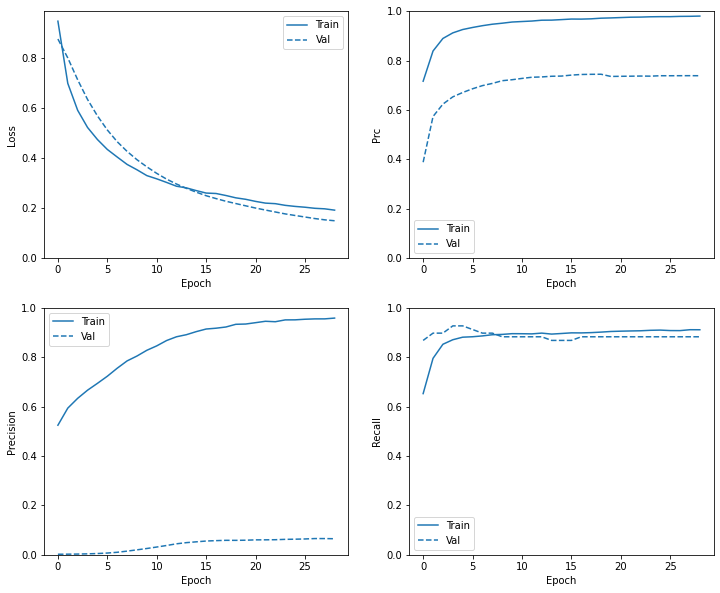

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.21728233993053436
tp :  106.0
fp :  1097.0
tn :  55751.0
fn :  8.0
accuracy :  0.9806011319160461
precision :  0.08811304718255997
recall :  0.9298245906829834
auc :  0.9770026206970215
prc :  0.7156160473823547

Legitimate Transactions Detected (True Negatives):  55751
Legitimate Transactions Incorrectly Detected (False Positives):  1097
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  106
Total Fraudulent Transactions:  114


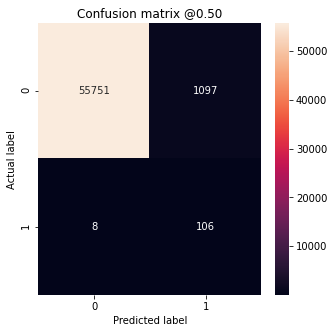

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

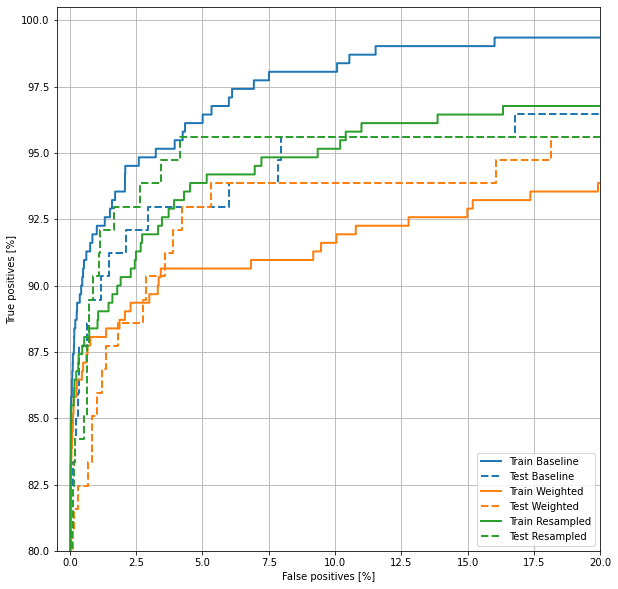

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Plot the AUPRC


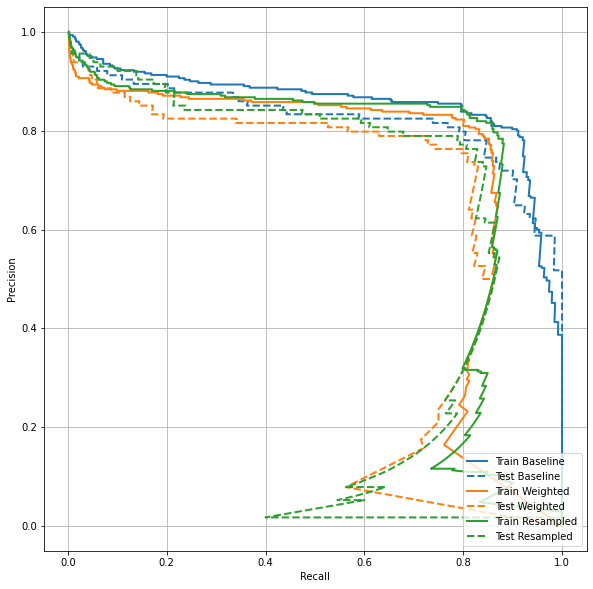

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.